In [1]:
# Design CIS 3D color router
# Resoultion 20 
# RGGB pattern
# First FoM: -22.775187623735164
# Current FoM: 264.1704627386973

# Elapsed run time = 57921.2683 s





# ## 1. Simulation Environment

import meep as mp
import meep.adjoint as mpa
import numpy as np
import nlopt
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
from matplotlib import pyplot as plt
import os

mp.verbosity(1)

seed = 240  # 난수 발생 시드(seed)를 240으로 설정 (재현성을 위해 난수 시드를 고정)
np.random.seed(seed)  # numpy의 난수 생성기의 시드를 설정하여 난수의 재현성 보장

design_dir = "./CIS_result/"

# 디렉터리가 없으면 생성
if not os.path.exists(design_dir):
    os.makedirs(design_dir)

# scaling & refractive index
um_scale = 1/0.675 # 1A = 675nm

Air = mp.Medium(index=1.0)
SiN = mp.Medium(index=2.1)
SiO2 = mp.Medium(index=1.4)
HfO2 = mp.Medium(index=1.9)
# SiPD = mp.Medium(epsilon=11.8)

# 해상도 및 사이즈 설정
resolution = 25 # 1 pixel = 27nm
ar_thk = 0.081 * um_scale # AR thickness
fl_size = 0.513 * um_scale # focal layer size
ml_size = 0.216 * um_scale # multi layer size
el_size = 0.027 * um_scale # etch layer size

dti_thk = ar_thk * 2 # DTI thickness 
sp_size = 0.621 * um_scale # subpixel size
# sp_size = 2 * um_scale # SiPD size

Lpml = 0.5 # PML 영역 크기
pml_layers = [mp.PML(thickness = Lpml, direction = mp.Z)]
Sourcespace = 0.5

# 설계 공간
design_region_width_x = sp_size * 4 # 디자인 영역 x
design_region_width_y = sp_size * 4 # 디자인 영역 y
design_region_height = ml_size * 5 + el_size * 4 # 디자인 영역 높이 z

# 전체 공간
Sx = design_region_width_x
Sy = design_region_width_y
Sz = Lpml + ar_thk + fl_size + design_region_height + Sourcespace + Lpml
cell_size = mp.Vector3(Sx, Sy, Sz)


# 파장, 주파수 설정
wavelengths = np.linspace(0.425*um_scale, 0.655*um_scale, 24) 
frequencies = 1/wavelengths
nf = len(frequencies) # number of frequencies

# Fabrication Constraints 설정

minimum_length = 0.027 * um_scale # minimum length scale (microns)
eta_i = 0.5  # blueprint (or intermediate) design field thresholding point (between 0 and 1)
eta_e = 0.55  # erosion design field thresholding point (between 0 and 1)
eta_d = 1 - eta_e  # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)
design_region_resolution = int(resolution)


# source 설정
width = 0.4

fcen_red = 1/(0.625*um_scale)
fwidth_red = fcen_red * width

fcen_green = 1/(0.545*um_scale)
fwidth_green = fcen_green * width

fcen_blue = 1/(0.455*um_scale)
fwidth_blue = fcen_blue * width

src_0 = mp.GaussianSource(frequency=fcen_red, fwidth=fwidth_red, is_integrated=True)

src_1 = mp.GaussianSource(frequency=fcen_green, fwidth=fwidth_green, is_integrated=True)

src_2 = mp.GaussianSource(frequency=fcen_blue, fwidth=fwidth_blue, is_integrated=True)

source_center = [0, 0, Sz / 2 - Lpml - Sourcespace / 2 ] # Source 위치
source_size = mp.Vector3(Sx, Sy, 0)

source = [mp.Source(src_0, component=mp.Ex, size=source_size, center=source_center,),mp.Source(src_0, component=mp.Ey, size=source_size, center=source_center,),
            mp.Source(src_1, component=mp.Ex, size=source_size, center=source_center,),mp.Source(src_1, component=mp.Ey, size=source_size, center=source_center,),
            mp.Source(src_2, component=mp.Ex, size=source_size, center=source_center,),mp.Source(src_2, component=mp.Ey, size=source_size, center=source_center,)]


# 설계 영역의 픽셀 - 해상도와 디자인 영역에 따라 결정
Nx = int(round(design_region_resolution * design_region_width_x)/2) 
Ny = int(round(design_region_resolution * design_region_width_y)/2) 
Nz = int(round(design_region_resolution * design_region_height))

# 설계 영역과 물질을 바탕으로 설계 영역 설정
design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny, Nz), SiO2, SiN, grid_type="U_MEAN",do_averaging=False)

design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(0, 0, Sz / 2 - Lpml - Sourcespace - design_region_height/2),
        size=mp.Vector3(design_region_width_x, design_region_width_y, design_region_height),
    ),
)

# 대각선대칭

def mapping(x, eta, beta):
    x_copy = (x.reshape(Nx * Ny, Nz)).transpose()

    # projection
    z = 0
    x2 = []

    while z < Nz:
        
        number = z
        x1 = x_copy[int(number)]
        
        # filter
        filtered_field = mpa.conic_filter(
            x1,
            filter_radius,
            1.8,
            1.8,
            design_region_resolution,
        )
        
        z_slice = ((filtered_field.reshape(Nx, Ny)) + filtered_field.reshape(Nx, Ny).transpose()) / 2
        x2 = npa.concatenate((x2,z_slice.flatten()),axis=0) 
        z = z + 1

    x2 = ((x2.reshape(Nz,Nx*Ny)).transpose()).flatten()
    
    x2 = (x2.reshape(Nx * Ny, Nz)).transpose()
        
    # Compute the mean for the pairs of columns
    mean_columns_1layer = npa.mean(x2[:8, :], axis=0)  # Mean for columns 
    mean_columns_2layer = npa.mean(x2[9:17, :], axis=0)  # Mean for columns 
    mean_columns_3layer = npa.mean(x2[18:26, :], axis=0)  # Mean for columns 
    mean_columns_4layer = npa.mean(x2[27:35, :], axis=0)  # Mean for columns 
    mean_columns_5layer = npa.mean(x2[36:44, :], axis=0)  # Mean for columns 
    
    # Create new arrays with mean values
    new_x2_1layer = npa.tile(mean_columns_1layer, 8).reshape(8, -1).flatten()
    new_x2_1layer_e = npa.zeros(Nx * Ny).flatten()
    new_x2_2layer = npa.tile(mean_columns_2layer, 8).reshape(8, -1).flatten()
    new_x2_2layer_e = npa.zeros(Nx * Ny).flatten()
    new_x2_3layer = npa.tile(mean_columns_3layer, 8).reshape(8, -1).flatten()
    new_x2_3layer_e = npa.zeros(Nx * Ny).flatten()
    new_x2_4layer = npa.tile(mean_columns_4layer, 8).reshape(8, -1).flatten()
    new_x2_4layer_e = npa.zeros(Nx * Ny).flatten()
    new_x2_5layer = npa.tile(mean_columns_5layer, 8).reshape(8, -1).flatten()
    
    # Concatenate the arrays to get the final result
    x2 = npa.concatenate([new_x2_1layer, new_x2_1layer_e,new_x2_2layer, new_x2_2layer_e,new_x2_3layer, new_x2_3layer_e,new_x2_4layer, new_x2_4layer_e,new_x2_5layer],axis=0)
    x2 = ((x2.reshape(Nz,Nx*Ny)).transpose()).flatten()
    x2 = mpa.tanh_projection(x2, beta, eta).flatten()
    x = x2

    return x


# design region과 동일한 size의 Block 생성
geometry = [
    mp.Block(
        center=design_region.center, size=design_region.size, material=design_variables
    ),

    # Focal Layer
    mp.Block(
        center=mp.Vector3(0, 0, Sz / 2 - Lpml - Sourcespace - design_region_height - fl_size/2), size=mp.Vector3(Sx, Sy, fl_size), material=SiO2
    ),

    #AR coating
    mp.Block(
        center=mp.Vector3(0, 0, Sz / 2 - Lpml - Sourcespace - design_region_height - fl_size - ar_thk/2 - Lpml/2), size=mp.Vector3(Sx, Sy, ar_thk + Lpml), material=HfO2
    ),

    # # DTI가 있을 경우 사용
    # mp.Block(
    #     center=mp.Vector3(Sx/4, Sy/4, -Sz/2 + ar_thk/2), size=mp.Vector3(subpixelsize, subpixelsize,  ar_thk), material=SiPD
    # ),
    # mp.Block(
    #     center=mp.Vector3(-Sx/4, -Sy/4, -Sz/2 + ar_thk/2), size=mp.Vector3(subpixelsize, subpixelsize,  ar_thk), material=SiPD
    # ),
    # mp.Block(
    #     center=mp.Vector3(Sx/4, -Sy/4, -Sz/2 + ar_thk/2), size=mp.Vector3(subpixelsize, subpixelsize,  ar_thk), material=SiPD
    # ),
    # mp.Block(
    #     center=mp.Vector3(-Sx/4, Sy/4, -Sz/2 + ar_thk/2), size=mp.Vector3(subpixelsize, subpixelsize,  ar_thk), material=SiPD
    # )
]

# Meep simulation 세팅

sim = mp.Simulation(
    cell_size=cell_size, 
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air, # 빈공간
    resolution=resolution,
    k_point = mp.Vector3(0,0,0)
)

###############################################################################################################################
# ## 2. Optimization Environment

# 모니터 위치와 크기 설정 (focal point)
monitor_position_0, monitor_size_0 = mp.Vector3(-design_region_width_x/4, design_region_width_y/4, -Sz/2 + Lpml + 0.5/resolution), mp.Vector3(0.01,0.01,0) 
monitor_position_1, monitor_size_1 = mp.Vector3(-design_region_width_x/4, -design_region_width_y/4, -Sz/2 + Lpml + 0.5/resolution), mp.Vector3(0.01,0.01,0) 
monitor_position_2, monitor_size_2 = mp.Vector3(design_region_width_x/4, -design_region_width_y/4, -Sz/2 + Lpml + 0.5/resolution), mp.Vector3(0.01,0.01,0) 
monitor_position_3, monitor_size_3 = mp.Vector3(design_region_width_x/4, design_region_width_y/4, -Sz/2 + Lpml + 0.5/resolution), mp.Vector3(0.01,0.01,0) 

# FourierFields를 통해 monitor_position에서 monitor_size만큼의 영역에 대한 Fourier transform을 구함

FourierFields_0_x = mpa.FourierFields(sim,mp.Volume(center=monitor_position_0,size=monitor_size_0),mp.Ex,yee_grid=True)

FourierFields_1_x = mpa.FourierFields(sim,mp.Volume(center=monitor_position_1,size=monitor_size_1),mp.Ex,yee_grid=True)

FourierFields_2_x = mpa.FourierFields(sim,mp.Volume(center=monitor_position_2,size=monitor_size_2),mp.Ex,yee_grid=True)

FourierFields_3_x = mpa.FourierFields(sim,mp.Volume(center=monitor_position_3,size=monitor_size_3),mp.Ex,yee_grid=True)

FourierFields_0_y = mpa.FourierFields(sim,mp.Volume(center=monitor_position_0,size=monitor_size_0),mp.Ey,yee_grid=True)

FourierFields_1_y = mpa.FourierFields(sim,mp.Volume(center=monitor_position_1,size=monitor_size_1),mp.Ey,yee_grid=True)

FourierFields_2_y = mpa.FourierFields(sim,mp.Volume(center=monitor_position_2,size=monitor_size_2),mp.Ey,yee_grid=True)

FourierFields_3_y = mpa.FourierFields(sim,mp.Volume(center=monitor_position_3,size=monitor_size_3),mp.Ey,yee_grid=True)

ob_list = [FourierFields_0_x, FourierFields_0_y, FourierFields_1_x,FourierFields_1_y, FourierFields_2_x, FourierFields_2_y, FourierFields_3_x, FourierFields_3_y]


fred = []
fgreen = []
fblue = []
# J : Objective function
# FourierFields가 측정한 필드, 모니터의 중심에서 E 구성요소의 절댓값을 제곱한 값을 취한 후 평균을 계산하여 평균 강도를 계산
# [frequency index, moniter index]
def J(fields_0_x, fields_0_y, fields_1_x, fields_1_y, fields_2_x, fields_2_y, fields_3_x, fields_3_y):
    red = npa.sum(npa.abs(fields_1_x[17:23,1]) ** 2)  + npa.sum(npa.abs(fields_1_y[17:23,1]) ** 2)
    green = npa.sum(npa.abs(fields_0_x[9:15,1]) ** 2) + npa.sum(npa.abs(fields_0_y[9:15,1]) ** 2) + npa.sum(npa.abs(fields_2_x[9:15,1]) ** 2) + npa.sum(npa.abs(fields_2_y[9:15,1]) ** 2)
    blue = npa.sum(npa.abs(fields_3_x[0:6,1]) ** 2) + npa.sum(npa.abs(fields_3_y[0:6,1]) ** 2)
    redfactor = 1
    greenfactor = 0.7
    bluefactor = 0.5
    
    red_c = npa.sum(npa.abs(fields_1_x[0:6,1]) ** 2)  + npa.sum(npa.abs(fields_1_y[0:6,1]) ** 2) + npa.sum(npa.abs(fields_1_x[9:15,1]) ** 2)  + npa.sum(npa.abs(fields_1_y[9:15,1]) ** 2)
    green_c = npa.sum(npa.abs(fields_0_x[0:6,1]) ** 2) + npa.sum(npa.abs(fields_0_y[0:6,1]) ** 2) + npa.sum(npa.abs(fields_2_x[0:6,1]) ** 2) + npa.sum(npa.abs(fields_2_y[0:6,1]) ** 2) + npa.sum(npa.abs(fields_0_x[17:23,1]) ** 2) + npa.sum(npa.abs(fields_0_y[17:23,1]) ** 2) + npa.sum(npa.abs(fields_2_x[17:23,1]) ** 2) + npa.sum(npa.abs(fields_2_y[17:23,1]) ** 2)
    blue_c = npa.sum(npa.abs(fields_3_x[9:15,1]) ** 2) + npa.sum(npa.abs(fields_3_y[9:15,1]) ** 2) + npa.sum(npa.abs(fields_3_x[17:23,1]) ** 2) + npa.sum(npa.abs(fields_3_y[17:23,1]) ** 2)
    
    fred.append(red/redfactor)
    fgreen.append(green/greenfactor)
    fblue.append(blue/bluefactor)
    OE = blue/bluefactor + green/greenfactor + red/redfactor
    CT = blue_c/bluefactor + green_c/greenfactor + red_c/redfactor
    return OE - CT

# optimization 설정

opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=[J],
    objective_arguments=ob_list,
    design_regions=[design_region],
    frequencies=frequencies,
    decay_by=1e-3,
)

# 함수 설정

evaluation_history = []
cur_iter = [0]
numevl = 1

def f(v, gradient, beta):
    global numevl
    print("Current iteration: {}".format(cur_iter[0] + 1))

    f0, dJ_du = opt([mapping(v, eta_i, beta)])  # compute objective and gradient
    # f0, dJ_du = opt()

    # Adjoint gradient
    if gradient.size > 0:
        gradient[:] = tensor_jacobian_product(mapping, 0)(
            v, eta_i, beta, np.sum(dJ_du, axis=1)
        )  # backprop

    evaluation_history.append(np.real(f0))

    np.savetxt(design_dir+"structure_0"+str(numevl) +".txt", design_variables.weights)
    
    numevl += 1
    
    print("First FoM: {}".format(evaluation_history[0]))
    print("Current FoM: {}".format(np.real(f0)))

    cur_iter[0] = cur_iter[0] + 1

    return np.real(f0)


/home/user/anaconda3/envs/mp/lib/python3.11/site-packages/meep/visualization.py:271: UserWarning: The specified user volume is larger than the simulation domain and has been truncated.
  warnings.warn(


     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)


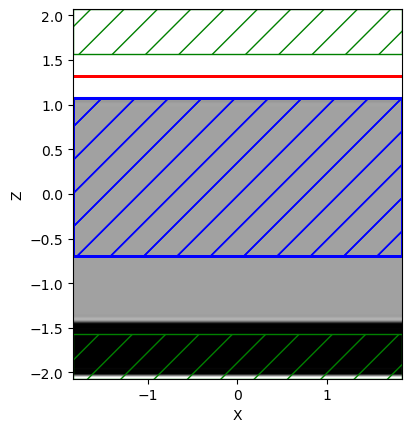

In [2]:
opt.plot2D(True,output_plane = mp.Volume(size = (np.inf, 0, np.inf), center = (0,0,0)))

In [3]:
print(design_variables.weights)

[0. 0. 0. ... 0. 0. 0.]


In [4]:
f0, dJ_du = opt()

Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 3.00407e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39279 s
-----------
on time step 234 (time=4.68), 0.01721 s/step
on time step 506 (time=10.12), 0.0147438 s/step
on time step 755 (time=15.1), 0.016106 s/step
on time step 1027 (time=20.54), 0.0148572 s/step
run 0 finished at t = 23.7 (1185 timesteps)
Starting adjoint run...


/home/user/anaconda3/envs/mp/lib/python3.11/site-packages/meep/adjoint/filter_source.py:175: RuntimeWarning: divide by zero encountered in divide
  l2_err = np.sum(np.abs(H - H_hat.T) ** 2 / np.abs(H) ** 2)
/home/user/anaconda3/envs/mp/lib/python3.11/site-packages/meep/adjoint/filter_source.py:175: RuntimeWarning: invalid value encountered in divide
  l2_err = np.sum(np.abs(H - H_hat.T) ** 2 / np.abs(H) ** 2)


on time step 183 (time=3.66), 0.0219135 s/step
on time step 368 (time=7.36), 0.0216906 s/step
on time step 555 (time=11.1), 0.0215488 s/step
on time step 747 (time=14.94), 0.0208855 s/step
on time step 941 (time=18.82), 0.0206687 s/step
on time step 1135 (time=22.7), 0.0206384 s/step
on time step 1329 (time=26.58), 0.0206404 s/step
on time step 1525 (time=30.5), 0.0204421 s/step
on time step 1713 (time=34.26), 0.0213127 s/step
on time step 1898 (time=37.96), 0.021684 s/step
on time step 2084 (time=41.68), 0.0215645 s/step
on time step 2271 (time=45.42), 0.0214751 s/step
on time step 2459 (time=49.18), 0.0213182 s/step
on time step 2645 (time=52.9), 0.0215726 s/step
on time step 2832 (time=56.64), 0.0213927 s/step
on time step 3017 (time=60.34), 0.0216239 s/step
on time step 3252 (time=65.04), 0.0170648 s/step
on time step 3554 (time=71.08), 0.0132721 s/step
on time step 3855 (time=77.1), 0.0133681 s/step
on time step 4155 (time=83.1), 0.0133349 s/step
run 1 finished at t = 88.34 (4417 

In [5]:
print(dJ_du)
print(f0)


[[-8.97863147e-04  4.05261080e-03  7.70929721e-03 ... -8.54086777e-03
  -8.67904819e-03  4.27805900e-04]
 [-8.94464465e-04  5.02108984e-03  4.45462980e-03 ... -7.90346571e-03
  -8.18237946e-03  3.58027212e-04]
 [ 1.29197954e-04  4.43426831e-03  8.82404495e-04 ... -8.08922796e-03
  -8.26458629e-03  3.16410310e-04]
 ...
 [-8.02993280e-04  6.42740280e-03  1.49275446e-02 ... -1.49177749e-03
  -2.94964095e-03 -1.35740613e-04]
 [ 2.02316344e-03  8.32891008e-03  1.17270754e-02 ... -3.21859036e-03
  -4.45155183e-03 -5.88138067e-05]
 [ 3.12412090e-03  6.20254589e-03  5.57932825e-03 ... -3.22819118e-03
  -4.00082516e-03 -2.70970367e-06]]
-20.208495670172184


In [6]:
print(design_variables.weights)

[0. 0. 0. ... 0. 0. 0.]


In [7]:
db = 1e-5
choose = 1000
g_discrete, idx = opt.calculate_fd_gradient(num_gradients=choose, db=db)

-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47317 s
-----------
on time step 289 (time=5.78), 0.0138776 s/step
on time step 621 (time=12.42), 0.0120526 s/step
on time step 963 (time=19.26), 0.0117075 s/step


run 2 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37886 s
-----------
on time step 310 (time=6.2), 0.0129329 s/step
on time step 659 (time=13.18), 0.0114916 s/step
on time step 1010 (time=20.2), 0.0114239 s/step


run 3 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39166 s
-----------
on time step 309 (time=6.18), 0.0129556 s/step
on time step 661 (time=13.22), 0.0113894 s/step
on time step 1012 (time=20.24), 0.0114128 s/step


run 4 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.69549e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3862 s
-----------
on time step 308 (time=6.16), 0.0129947 s/step
on time step 654 (time=13.08), 0.0115617 s/step
on time step 1000 (time=20), 0.0115611 s/step


run 5 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39297 s
-----------
on time step 305 (time=6.1), 0.0131524 s/step
on time step 652 (time=13.04), 0.0115466 s/step
on time step 995 (time=19.9), 0.0116867 s/step


run 6 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.384 s
-----------
on time step 304 (time=6.08), 0.0131704 s/step
on time step 652 (time=13.04), 0.0115136 s/step
on time step 1000 (time=20), 0.0115034 s/step


run 7 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38915 s
-----------
on time step 306 (time=6.12), 0.0130832 s/step
on time step 651 (time=13.02), 0.0116209 s/step
on time step 995 (time=19.9), 0.0116379 s/step


run 8 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39794 s
-----------
on time step 303 (time=6.06), 0.0132185 s/step
on time step 647 (time=12.94), 0.0116404 s/step
on time step 983 (time=19.66), 0.0119274 s/step


run 9 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.43413 s
-----------
on time step 289 (time=5.78), 0.0138698 s/step
on time step 630 (time=12.6), 0.0117335 s/step
on time step 971 (time=19.42), 0.0117359 s/step


run 10 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4004 s
-----------
on time step 301 (time=6.02), 0.013291 s/step
on time step 640 (time=12.8), 0.011828 s/step
on time step 979 (time=19.58), 0.0118011 s/step


run 11 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40302 s
-----------
on time step 301 (time=6.02), 0.0133104 s/step
on time step 642 (time=12.84), 0.0117622 s/step
on time step 984 (time=19.68), 0.0117186 s/step


run 12 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41267 s
-----------
on time step 296 (time=5.92), 0.0135477 s/step
on time step 637 (time=12.74), 0.0117608 s/step
on time step 975 (time=19.5), 0.0118603 s/step


run 13 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.50542 s
-----------
on time step 294 (time=5.88), 0.0136332 s/step
on time step 620 (time=12.4), 0.012304 s/step
on time step 947 (time=18.94), 0.0122475 s/step


run 14 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.45977 s
-----------
on time step 282 (time=5.64), 0.014193 s/step
on time step 610 (time=12.2), 0.012212 s/step
on time step 927 (time=18.54), 0.012647 s/step
on time step 1247 (time=24.94), 0.0125379 s/step


run 15 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.43666 s
-----------
on time step 292 (time=5.84), 0.0137076 s/step
on time step 614 (time=12.28), 0.0124532 s/step
on time step 956 (time=19.12), 0.0117136 s/step


run 16 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38959 s
-----------
on time step 292 (time=5.84), 0.0137238 s/step
on time step 611 (time=12.22), 0.012561 s/step
on time step 942 (time=18.84), 0.0120989 s/step


run 17 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40206 s
-----------
on time step 295 (time=5.9), 0.0135645 s/step
on time step 627 (time=12.54), 0.0120717 s/step
on time step 966 (time=19.32), 0.0118184 s/step


run 18 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.42842 s
-----------
on time step 291 (time=5.82), 0.0137745 s/step
on time step 630 (time=12.6), 0.0118292 s/step
on time step 970 (time=19.4), 0.0117939 s/step


run 19 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40421 s
-----------
on time step 297 (time=5.94), 0.0134805 s/step
on time step 630 (time=12.6), 0.0120249 s/step
on time step 966 (time=19.32), 0.0119104 s/step


run 20 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.432 s
-----------
on time step 287 (time=5.74), 0.0139767 s/step
on time step 628 (time=12.56), 0.0117323 s/step
on time step 965 (time=19.3), 0.0118957 s/step


run 21 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39296 s
-----------
on time step 299 (time=5.98), 0.0133928 s/step
on time step 640 (time=12.8), 0.0117342 s/step
on time step 980 (time=19.6), 0.0117761 s/step


run 22 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38331 s
-----------
on time step 306 (time=6.12), 0.0130949 s/step
on time step 652 (time=13.04), 0.0115673 s/step
on time step 991 (time=19.82), 0.0118038 s/step


run 23 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39492 s
-----------
on time step 299 (time=5.98), 0.0134169 s/step
on time step 642 (time=12.84), 0.0116782 s/step
on time step 980 (time=19.6), 0.0118569 s/step


run 24 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38734 s
-----------
on time step 301 (time=6.02), 0.0133088 s/step
on time step 633 (time=12.66), 0.0120791 s/step
on time step 973 (time=19.46), 0.0117814 s/step


run 25 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40332 s
-----------
on time step 304 (time=6.08), 0.0131783 s/step
on time step 642 (time=12.84), 0.0118604 s/step
on time step 979 (time=19.58), 0.0118977 s/step


run 26 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39933 s
-----------
on time step 300 (time=6), 0.0133714 s/step
on time step 642 (time=12.84), 0.0117121 s/step
on time step 969 (time=19.38), 0.0122393 s/step


run 27 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.51311 s
-----------
on time step 298 (time=5.96), 0.0134253 s/step
on time step 639 (time=12.78), 0.0117564 s/step
on time step 981 (time=19.62), 0.0117054 s/step


run 28 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4092 s
-----------
on time step 299 (time=5.98), 0.0133914 s/step
on time step 636 (time=12.72), 0.0119 s/step
on time step 981 (time=19.62), 0.0116032 s/step


run 29 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38617 s
-----------
on time step 303 (time=6.06), 0.0132029 s/step
on time step 643 (time=12.86), 0.0117896 s/step
on time step 983 (time=19.66), 0.0117808 s/step


run 30 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39026 s
-----------
on time step 306 (time=6.12), 0.0130828 s/step
on time step 652 (time=13.04), 0.0115684 s/step
on time step 993 (time=19.86), 0.0117392 s/step


run 31 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37989 s
-----------
on time step 299 (time=5.98), 0.0133819 s/step
on time step 641 (time=12.82), 0.0117194 s/step
on time step 982 (time=19.64), 0.0117543 s/step


run 32 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38623 s
-----------
on time step 302 (time=6.04), 0.0132528 s/step
on time step 641 (time=12.82), 0.0118064 s/step
on time step 976 (time=19.52), 0.0119403 s/step


run 33 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38645 s
-----------
on time step 298 (time=5.96), 0.0134378 s/step
on time step 632 (time=12.64), 0.0119903 s/step
on time step 978 (time=19.56), 0.0115772 s/step


run 34 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38499 s
-----------
on time step 302 (time=6.04), 0.013276 s/step
on time step 642 (time=12.84), 0.011772 s/step
on time step 989 (time=19.78), 0.0115448 s/step


run 35 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37815 s
-----------
on time step 300 (time=6), 0.0133387 s/step
on time step 640 (time=12.8), 0.0117712 s/step
on time step 975 (time=19.5), 0.0119436 s/step


run 36 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.35642 s
-----------
on time step 309 (time=6.18), 0.0129467 s/step
on time step 660 (time=13.2), 0.0114062 s/step
on time step 1004 (time=20.08), 0.0116572 s/step


run 37 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.35301 s
-----------
on time step 304 (time=6.08), 0.013173 s/step
on time step 655 (time=13.1), 0.0114204 s/step
on time step 1002 (time=20.04), 0.0115585 s/step


run 38 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36421 s
-----------
on time step 314 (time=6.28), 0.0127607 s/step
on time step 672 (time=13.44), 0.0111911 s/step
on time step 1015 (time=20.3), 0.0116807 s/step


run 39 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37412 s
-----------
on time step 301 (time=6.02), 0.0133225 s/step
on time step 642 (time=12.84), 0.0117447 s/step
on time step 992 (time=19.84), 0.0114382 s/step


run 40 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.35197 s
-----------
on time step 305 (time=6.1), 0.01313 s/step
on time step 654 (time=13.08), 0.0114697 s/step
on time step 1006 (time=20.12), 0.0113816 s/step


run 41 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36198 s
-----------
on time step 306 (time=6.12), 0.0130958 s/step
on time step 659 (time=13.18), 0.0113407 s/step
on time step 1002 (time=20.04), 0.0116931 s/step


run 42 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3526 s
-----------
on time step 310 (time=6.2), 0.0129307 s/step
on time step 660 (time=13.2), 0.0114591 s/step
on time step 1006 (time=20.12), 0.0115798 s/step


run 43 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.44293 s
-----------
on time step 306 (time=6.12), 0.013082 s/step
on time step 652 (time=13.04), 0.0115849 s/step
on time step 1002 (time=20.04), 0.0114487 s/step


run 44 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.46098 s
-----------
on time step 305 (time=6.1), 0.0131332 s/step
on time step 651 (time=13.02), 0.0115829 s/step
on time step 998 (time=19.96), 0.011558 s/step


run 45 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36618 s
-----------
on time step 304 (time=6.08), 0.013188 s/step
on time step 653 (time=13.06), 0.0114917 s/step
on time step 997 (time=19.94), 0.0116519 s/step


run 46 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36695 s
-----------
on time step 294 (time=5.88), 0.0136148 s/step
on time step 633 (time=12.66), 0.0118002 s/step
on time step 981 (time=19.62), 0.0115267 s/step


run 47 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.00679e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38675 s
-----------
on time step 306 (time=6.12), 0.0131038 s/step
on time step 645 (time=12.9), 0.0118285 s/step
on time step 992 (time=19.84), 0.0115569 s/step


run 48 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36748 s
-----------
on time step 310 (time=6.2), 0.0129033 s/step
on time step 651 (time=13.02), 0.0117357 s/step
on time step 1001 (time=20.02), 0.0114327 s/step


run 49 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.35533 s
-----------
on time step 312 (time=6.24), 0.012821 s/step
on time step 665 (time=13.3), 0.0113322 s/step
on time step 1017 (time=20.34), 0.0113643 s/step


run 50 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.35326 s
-----------
on time step 308 (time=6.16), 0.0130143 s/step
on time step 658 (time=13.16), 0.0114313 s/step
on time step 1009 (time=20.18), 0.0114045 s/step


run 51 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.35485 s
-----------
on time step 309 (time=6.18), 0.0129595 s/step
on time step 660 (time=13.2), 0.011409 s/step
on time step 1008 (time=20.16), 0.0115244 s/step


run 52 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36117 s
-----------
on time step 311 (time=6.22), 0.0128853 s/step
on time step 661 (time=13.22), 0.0114411 s/step
on time step 1010 (time=20.2), 0.0114682 s/step


run 53 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.43221 s
-----------
on time step 316 (time=6.32), 0.0126866 s/step
on time step 652 (time=13.04), 0.0119399 s/step
on time step 998 (time=19.96), 0.0115972 s/step


run 54 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.34769 s
-----------
on time step 303 (time=6.06), 0.0132333 s/step
on time step 650 (time=13), 0.0115426 s/step
on time step 996 (time=19.92), 0.0115797 s/step


run 55 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36434 s
-----------
on time step 311 (time=6.22), 0.0128978 s/step
on time step 660 (time=13.2), 0.0114794 s/step
on time step 1013 (time=20.26), 0.0113518 s/step


run 56 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36262 s
-----------
on time step 307 (time=6.14), 0.0130316 s/step
on time step 657 (time=13.14), 0.0114497 s/step
on time step 1005 (time=20.1), 0.0115153 s/step


run 57 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.34963 s
-----------
on time step 303 (time=6.06), 0.0132207 s/step
on time step 655 (time=13.1), 0.0113831 s/step
on time step 1006 (time=20.12), 0.011426 s/step


run 58 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.34855 s
-----------
on time step 308 (time=6.16), 0.0129892 s/step
on time step 663 (time=13.26), 0.0112711 s/step
on time step 1005 (time=20.1), 0.0117219 s/step


run 59 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.33028 s
-----------
on time step 317 (time=6.34), 0.0126202 s/step
on time step 676 (time=13.52), 0.0111598 s/step
on time step 1025 (time=20.5), 0.0114826 s/step


run 60 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38437 s
-----------
on time step 310 (time=6.2), 0.0129155 s/step
on time step 665 (time=13.3), 0.0112728 s/step
on time step 1000 (time=20), 0.011961 s/step


run 61 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38397 s
-----------
on time step 300 (time=6), 0.0133409 s/step
on time step 640 (time=12.8), 0.0117894 s/step
on time step 981 (time=19.62), 0.0117584 s/step


run 62 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37705 s
-----------
on time step 297 (time=5.94), 0.013471 s/step
on time step 635 (time=12.7), 0.0118521 s/step
on time step 971 (time=19.42), 0.0119265 s/step


run 63 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38161 s
-----------
on time step 298 (time=5.96), 0.0134508 s/step
on time step 634 (time=12.68), 0.0119103 s/step
on time step 962 (time=19.24), 0.0122139 s/step


run 64 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40749 s
-----------
on time step 295 (time=5.9), 0.0135879 s/step
on time step 627 (time=12.54), 0.0120515 s/step
on time step 955 (time=19.1), 0.0121979 s/step


run 65 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41784 s
-----------
on time step 294 (time=5.88), 0.0136477 s/step
on time step 628 (time=12.56), 0.012007 s/step
on time step 958 (time=19.16), 0.012134 s/step


run 66 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40475 s
-----------
on time step 289 (time=5.78), 0.0138505 s/step
on time step 625 (time=12.5), 0.0119315 s/step
on time step 954 (time=19.08), 0.0121746 s/step


run 67 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.42618 s
-----------
on time step 294 (time=5.88), 0.0136146 s/step
on time step 628 (time=12.56), 0.0119966 s/step
on time step 963 (time=19.26), 0.0119527 s/step


run 68 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 4.88758e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38966 s
-----------
on time step 293 (time=5.86), 0.0136653 s/step
on time step 625 (time=12.5), 0.0120503 s/step
on time step 955 (time=19.1), 0.0121335 s/step


run 69 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38913 s
-----------
on time step 286 (time=5.72), 0.0140007 s/step
on time step 612 (time=12.24), 0.0122755 s/step
on time step 944 (time=18.88), 0.0120531 s/step


run 70 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49514 s
-----------
on time step 288 (time=5.76), 0.0138971 s/step
on time step 619 (time=12.38), 0.012119 s/step
on time step 953 (time=19.06), 0.0119946 s/step


run 71 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47674 s
-----------
on time step 299 (time=5.98), 0.0134169 s/step
on time step 638 (time=12.76), 0.011811 s/step
on time step 978 (time=19.56), 0.0117947 s/step


run 72 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39943 s
-----------
on time step 292 (time=5.84), 0.0137128 s/step
on time step 627 (time=12.54), 0.0119584 s/step
on time step 961 (time=19.22), 0.0119769 s/step


run 73 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.79086e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.52244 s
-----------
on time step 295 (time=5.9), 0.0135658 s/step
on time step 632 (time=12.64), 0.0118734 s/step
on time step 971 (time=19.42), 0.0118009 s/step


run 74 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39378 s
-----------
on time step 301 (time=6.02), 0.0133106 s/step
on time step 641 (time=12.82), 0.0117945 s/step
on time step 976 (time=19.52), 0.0119481 s/step


run 75 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.42521 s
-----------
on time step 299 (time=5.98), 0.0133808 s/step
on time step 636 (time=12.72), 0.0118771 s/step
on time step 975 (time=19.5), 0.0118266 s/step


run 76 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40249 s
-----------
on time step 301 (time=6.02), 0.0132999 s/step
on time step 638 (time=12.76), 0.0118699 s/step
on time step 981 (time=19.62), 0.0116864 s/step


run 77 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4878 s
-----------
on time step 304 (time=6.08), 0.0131653 s/step
on time step 649 (time=12.98), 0.0116143 s/step
on time step 993 (time=19.86), 0.0116543 s/step


run 78 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.65395 s
-----------
on time step 292 (time=5.84), 0.0137229 s/step
on time step 627 (time=12.54), 0.0119477 s/step
on time step 967 (time=19.34), 0.0117927 s/step


run 79 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38219 s
-----------
on time step 292 (time=5.84), 0.0137208 s/step
on time step 632 (time=12.64), 0.0117935 s/step
on time step 968 (time=19.36), 0.0119359 s/step


run 80 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40087 s
-----------
on time step 292 (time=5.84), 0.0137229 s/step
on time step 622 (time=12.44), 0.0121398 s/step
on time step 956 (time=19.12), 0.0119932 s/step


run 81 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.42053 s
-----------
on time step 287 (time=5.74), 0.0139583 s/step
on time step 627 (time=12.54), 0.0117979 s/step
on time step 960 (time=19.2), 0.0120279 s/step


run 82 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40351 s
-----------
on time step 285 (time=5.7), 0.0140662 s/step
on time step 619 (time=12.38), 0.0119774 s/step
on time step 948 (time=18.96), 0.0121818 s/step


run 83 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39944 s
-----------
on time step 297 (time=5.94), 0.013496 s/step
on time step 638 (time=12.76), 0.0117445 s/step
on time step 989 (time=19.78), 0.0113997 s/step


run 84 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37769 s
-----------
on time step 304 (time=6.08), 0.0131587 s/step
on time step 649 (time=12.98), 0.0116235 s/step
on time step 990 (time=19.8), 0.0117458 s/step


run 85 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36757 s
-----------
on time step 315 (time=6.3), 0.0127304 s/step
on time step 657 (time=13.14), 0.0116987 s/step
on time step 1003 (time=20.06), 0.0115826 s/step


run 86 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.46593 s
-----------
on time step 304 (time=6.08), 0.0131742 s/step
on time step 654 (time=13.08), 0.0114506 s/step
on time step 998 (time=19.96), 0.0116288 s/step


run 87 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.71933e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37626 s
-----------
on time step 308 (time=6.16), 0.0129876 s/step
on time step 662 (time=13.24), 0.0113178 s/step
on time step 1008 (time=20.16), 0.0115656 s/step


run 88 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.35006 s
-----------
on time step 308 (time=6.16), 0.0130009 s/step
on time step 658 (time=13.16), 0.0114519 s/step
on time step 1013 (time=20.26), 0.0112698 s/step


run 89 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.34032 s
-----------
on time step 314 (time=6.28), 0.0127564 s/step
on time step 656 (time=13.12), 0.0116993 s/step
on time step 1003 (time=20.06), 0.0115565 s/step


run 90 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36753 s
-----------
on time step 313 (time=6.26), 0.0128074 s/step
on time step 662 (time=13.24), 0.0114764 s/step
on time step 1014 (time=20.28), 0.0113799 s/step


run 91 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37022 s
-----------
on time step 297 (time=5.94), 0.0134705 s/step
on time step 650 (time=13), 0.0113598 s/step
on time step 1006 (time=20.12), 0.0112454 s/step


run 92 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3311 s
-----------
on time step 311 (time=6.22), 0.0128908 s/step
on time step 654 (time=13.08), 0.0116791 s/step
on time step 1004 (time=20.08), 0.0114484 s/step


run 93 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37042 s
-----------
on time step 309 (time=6.18), 0.0129474 s/step
on time step 657 (time=13.14), 0.0114963 s/step
on time step 1010 (time=20.2), 0.0113388 s/step


run 94 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.35833 s
-----------
on time step 311 (time=6.22), 0.0128761 s/step
on time step 664 (time=13.28), 0.0113636 s/step
on time step 1012 (time=20.24), 0.0115208 s/step


run 95 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36338 s
-----------
on time step 308 (time=6.16), 0.0130171 s/step
on time step 660 (time=13.2), 0.0113851 s/step
on time step 1011 (time=20.22), 0.0114207 s/step


run 96 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.34623 s
-----------
on time step 314 (time=6.28), 0.0127526 s/step
on time step 669 (time=13.38), 0.0112739 s/step
on time step 1020 (time=20.4), 0.0114263 s/step


run 97 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47097 s
-----------
on time step 308 (time=6.16), 0.013019 s/step
on time step 647 (time=12.94), 0.0117997 s/step
on time step 976 (time=19.52), 0.0121779 s/step


run 98 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41741 s
-----------
on time step 300 (time=6), 0.0133523 s/step
on time step 643 (time=12.86), 0.0116631 s/step
on time step 977 (time=19.54), 0.0120093 s/step


run 99 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37029 s
-----------
on time step 291 (time=5.82), 0.0137575 s/step
on time step 624 (time=12.48), 0.0120463 s/step
on time step 953 (time=19.06), 0.0121885 s/step


run 100 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.46886 s
-----------
on time step 306 (time=6.12), 0.0130738 s/step
on time step 652 (time=13.04), 0.0115846 s/step
on time step 982 (time=19.64), 0.0121523 s/step


run 101 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.42199 s
-----------
on time step 308 (time=6.16), 0.0130221 s/step
on time step 656 (time=13.12), 0.0115058 s/step
on time step 1005 (time=20.1), 0.0114624 s/step


run 102 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.44604 s
-----------
on time step 305 (time=6.1), 0.0131514 s/step
on time step 659 (time=13.18), 0.0113236 s/step
on time step 1007 (time=20.14), 0.011509 s/step


run 103 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.35404 s
-----------
on time step 309 (time=6.18), 0.012965 s/step
on time step 649 (time=12.98), 0.0117956 s/step
on time step 994 (time=19.88), 0.0115976 s/step


run 104 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38764 s
-----------
on time step 305 (time=6.1), 0.0131414 s/step
on time step 665 (time=13.3), 0.0111163 s/step
on time step 1025 (time=20.5), 0.0111448 s/step


run 105 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37993 s
-----------
on time step 301 (time=6.02), 0.0132957 s/step
on time step 649 (time=12.98), 0.0115133 s/step
on time step 1001 (time=20.02), 0.0113889 s/step


run 106 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.32792 s
-----------
on time step 316 (time=6.32), 0.0126843 s/step
on time step 669 (time=13.38), 0.0113497 s/step
on time step 1011 (time=20.22), 0.0117136 s/step


run 107 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.34476 s
-----------
on time step 303 (time=6.06), 0.0132068 s/step
on time step 651 (time=13.02), 0.0115036 s/step
on time step 1001 (time=20.02), 0.011445 s/step


run 108 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36777 s
-----------
on time step 314 (time=6.28), 0.0127506 s/step
on time step 670 (time=13.4), 0.0112392 s/step
on time step 1018 (time=20.36), 0.0115233 s/step


run 109 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37446 s
-----------
on time step 306 (time=6.12), 0.013106 s/step
on time step 654 (time=13.08), 0.0115172 s/step
on time step 1001 (time=20.02), 0.0115278 s/step


run 110 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.34044 s
-----------
on time step 309 (time=6.18), 0.0129557 s/step
on time step 661 (time=13.22), 0.0113892 s/step
on time step 1007 (time=20.14), 0.0115756 s/step


run 111 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39429 s
-----------
on time step 308 (time=6.16), 0.0129924 s/step
on time step 661 (time=13.22), 0.011353 s/step
on time step 1012 (time=20.24), 0.0114146 s/step


run 112 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.44959 s
-----------
on time step 307 (time=6.14), 0.0130631 s/step
on time step 654 (time=13.08), 0.0115355 s/step
on time step 1010 (time=20.2), 0.0112671 s/step


run 113 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36875 s
-----------
on time step 317 (time=6.34), 0.0126418 s/step
on time step 676 (time=13.52), 0.0111597 s/step
on time step 1032 (time=20.64), 0.0112616 s/step


run 114 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.35004 s
-----------
on time step 289 (time=5.78), 0.0138594 s/step
on time step 622 (time=12.44), 0.0120314 s/step
on time step 949 (time=18.98), 0.0122371 s/step


run 115 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3904 s
-----------
on time step 280 (time=5.6), 0.0143228 s/step
on time step 590 (time=11.8), 0.0129055 s/step
on time step 928 (time=18.56), 0.0118369 s/step
on time step 1235 (time=24.7), 0.0130595 s/step


run 116 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39208 s
-----------
on time step 273 (time=5.46), 0.0146889 s/step
on time step 583 (time=11.66), 0.0129036 s/step
on time step 909 (time=18.18), 0.0123014 s/step
on time step 1231 (time=24.62), 0.0124479 s/step


run 117 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37423 s
-----------
on time step 279 (time=5.58), 0.0143371 s/step
on time step 596 (time=11.92), 0.0126202 s/step
on time step 913 (time=18.26), 0.0126407 s/step
on time step 1234 (time=24.68), 0.0124781 s/step


run 118 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37547 s
-----------
on time step 290 (time=5.8), 0.0138125 s/step
on time step 624 (time=12.48), 0.0119975 s/step
on time step 958 (time=19.16), 0.0119965 s/step


run 119 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36381 s
-----------
on time step 295 (time=5.9), 0.013575 s/step
on time step 615 (time=12.3), 0.0125092 s/step
on time step 938 (time=18.76), 0.0123865 s/step


run 120 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36423 s
-----------
on time step 296 (time=5.92), 0.0135277 s/step
on time step 630 (time=12.6), 0.0119884 s/step
on time step 951 (time=19.02), 0.012466 s/step


run 121 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40702 s
-----------
on time step 279 (time=5.58), 0.0143685 s/step
on time step 584 (time=11.68), 0.0131512 s/step
on time step 899 (time=17.98), 0.0127035 s/step
on time step 1218 (time=24.36), 0.0125418 s/step


run 122 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40017 s
-----------
on time step 285 (time=5.7), 0.014074 s/step
on time step 605 (time=12.1), 0.0125398 s/step
on time step 929 (time=18.58), 0.0123464 s/step
on time step 1252 (time=25.04), 0.0123929 s/step


run 123 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37171 s
-----------
on time step 285 (time=5.7), 0.0140773 s/step
on time step 612 (time=12.24), 0.0122426 s/step
on time step 927 (time=18.54), 0.012712 s/step
on time step 1244 (time=24.88), 0.0126197 s/step
run 124 finished at t = 25.12 (1256 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.46413 s
-----------
on time step 281 (time=5.62), 0.014242 s/step
on time step 602 (time=12.04), 0.0124752 s/step
on time step 924 (time=18.48), 0.0124382 s/step
on time step 1242 (time=24.84), 0.0125973 s/step
run 125 finished at t = 25.12 (1256 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.378 s
-----------
on time step 286 (time=5.72), 0.0140113 s/step
on time step 607 (time=12.14), 0.0124685 s/step
on time step 924 (time=18.48), 0.0126202 s/step
on time step 1250 (time=25), 0.0122792 s/step


run 126 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.00407e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3862 s
-----------
on time step 282 (time=5.64), 0.0142261 s/step
on time step 607 (time=12.14), 0.0123313 s/step
on time step 932 (time=18.64), 0.012329 s/step
on time step 1247 (time=24.94), 0.0127049 s/step
run 127 finished at t = 25.12 (1256 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38847 s
-----------
on time step 269 (time=5.38), 0.0149105 s/step
on time step 594 (time=11.88), 0.0123319 s/step
on time step 919 (time=18.38), 0.0123084 s/step
on time step 1247 (time=24.94), 0.0122143 s/step
run 128 finished at t = 25.12 (1256 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 3.8147e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38341 s
-----------
on time step 289 (time=5.78), 0.0138678 s/step
on time step 611 (time=12.22), 0.0124462 s/step
on time step 928 (time=18.56), 0.0126501 s/step
on time step 1248 (time=24.96), 0.0125272 s/step


run 129 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37789 s
-----------
on time step 277 (time=5.54), 0.0144823 s/step
on time step 602 (time=12.04), 0.0123445 s/step
on time step 911 (time=18.22), 0.0129657 s/step
on time step 1219 (time=24.38), 0.0129873 s/step


run 130 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36268 s
-----------
on time step 288 (time=5.76), 0.0138993 s/step
on time step 608 (time=12.16), 0.0125211 s/step
on time step 937 (time=18.74), 0.0121927 s/step


run 131 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37379 s
-----------
on time step 292 (time=5.84), 0.0137224 s/step
on time step 620 (time=12.4), 0.012209 s/step
on time step 940 (time=18.8), 0.012515 s/step


run 132 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38922 s
-----------
on time step 282 (time=5.64), 0.0142153 s/step
on time step 596 (time=11.92), 0.0127574 s/step
on time step 924 (time=18.48), 0.0122198 s/step
on time step 1245 (time=24.9), 0.0124696 s/step
run 133 finished at t = 25.12 (1256 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37175 s
-----------
on time step 282 (time=5.64), 0.0142186 s/step
on time step 607 (time=12.14), 0.0123115 s/step
on time step 917 (time=18.34), 0.0129263 s/step
on time step 1225 (time=24.5), 0.0129934 s/step


run 134 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3803 s
-----------
on time step 277 (time=5.54), 0.0144809 s/step
on time step 606 (time=12.12), 0.0121671 s/step
on time step 933 (time=18.66), 0.0122515 s/step


run 135 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37215 s
-----------
on time step 271 (time=5.42), 0.0147722 s/step
on time step 599 (time=11.98), 0.012203 s/step
on time step 931 (time=18.62), 0.0120579 s/step
on time step 1246 (time=24.92), 0.0127147 s/step
run 136 finished at t = 25.12 (1256 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39414 s
-----------
on time step 271 (time=5.42), 0.0147868 s/step
on time step 591 (time=11.82), 0.0125101 s/step
on time step 918 (time=18.36), 0.0122327 s/step
on time step 1247 (time=24.94), 0.012193 s/step
run 137 finished at t = 25.12 (1256 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.42574 s
-----------
on time step 278 (time=5.56), 0.0143981 s/step
on time step 600 (time=12), 0.0124429 s/step
on time step 926 (time=18.52), 0.012288 s/step
on time step 1242 (time=24.84), 0.0127005 s/step
run 138 finished at t = 25.12 (1256 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37571 s
-----------
on time step 284 (time=5.68), 0.0140849 s/step
on time step 603 (time=12.06), 0.0125571 s/step
on time step 924 (time=18.48), 0.0124621 s/step
on time step 1239 (time=24.78), 0.0127181 s/step


run 139 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38217 s
-----------
on time step 291 (time=5.82), 0.0137472 s/step
on time step 622 (time=12.44), 0.0121184 s/step
on time step 954 (time=19.08), 0.0120778 s/step


run 140 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36895 s
-----------
on time step 293 (time=5.86), 0.0136626 s/step
on time step 625 (time=12.5), 0.0120651 s/step
on time step 959 (time=19.18), 0.0120051 s/step


run 141 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37957 s
-----------
on time step 292 (time=5.84), 0.0137357 s/step
on time step 623 (time=12.46), 0.0121094 s/step
on time step 953 (time=19.06), 0.012152 s/step


run 142 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.43427 s
-----------
on time step 286 (time=5.72), 0.0139867 s/step
on time step 610 (time=12.2), 0.0123471 s/step
on time step 922 (time=18.44), 0.0128465 s/step
on time step 1241 (time=24.82), 0.0125569 s/step
run 143 finished at t = 25.12 (1256 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39135 s
-----------
on time step 287 (time=5.74), 0.0139717 s/step
on time step 613 (time=12.26), 0.0122901 s/step
on time step 905 (time=18.1), 0.0137111 s/step
on time step 1206 (time=24.12), 0.0133223 s/step


run 144 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40418 s
-----------
on time step 258 (time=5.16), 0.0155395 s/step
on time step 558 (time=11.16), 0.0133771 s/step
on time step 870 (time=17.4), 0.012858 s/step
on time step 1188 (time=23.76), 0.0125834 s/step


run 145 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3659 s
-----------
on time step 291 (time=5.82), 0.0137594 s/step
on time step 621 (time=12.42), 0.0121359 s/step
on time step 953 (time=19.06), 0.0120548 s/step


run 146 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36604 s
-----------
on time step 292 (time=5.84), 0.0137131 s/step
on time step 624 (time=12.48), 0.0120723 s/step
on time step 956 (time=19.12), 0.0120739 s/step


run 147 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36531 s
-----------
on time step 292 (time=5.84), 0.0137231 s/step
on time step 605 (time=12.1), 0.0127949 s/step
on time step 925 (time=18.5), 0.0125289 s/step
on time step 1250 (time=25), 0.0123187 s/step


run 148 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36834 s
-----------
on time step 283 (time=5.66), 0.0141653 s/step
on time step 614 (time=12.28), 0.0120962 s/step
on time step 933 (time=18.66), 0.0125434 s/step


run 149 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38102 s
-----------
on time step 282 (time=5.64), 0.0142182 s/step
on time step 598 (time=11.96), 0.012679 s/step
on time step 914 (time=18.28), 0.0126773 s/step
on time step 1225 (time=24.5), 0.0128718 s/step


run 150 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47645 s
-----------
on time step 281 (time=5.62), 0.0142528 s/step
on time step 589 (time=11.78), 0.0130078 s/step
on time step 912 (time=18.24), 0.0123996 s/step
on time step 1235 (time=24.7), 0.0124003 s/step


run 151 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38044 s
-----------
on time step 289 (time=5.78), 0.0138718 s/step
on time step 614 (time=12.28), 0.0123403 s/step
on time step 932 (time=18.64), 0.0125793 s/step


run 152 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38184 s
-----------
on time step 279 (time=5.58), 0.0143714 s/step
on time step 596 (time=11.92), 0.0126561 s/step
on time step 917 (time=18.34), 0.0124773 s/step
on time step 1248 (time=24.96), 0.0121176 s/step


run 153 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36408 s
-----------
on time step 293 (time=5.86), 0.013689 s/step
on time step 626 (time=12.52), 0.0120247 s/step
on time step 950 (time=19), 0.0123492 s/step
on time step 1249 (time=24.98), 0.0134181 s/step
run 154 finished at t = 25.12 (1256 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41625 s
-----------
on time step 283 (time=5.66), 0.0141481 s/step
on time step 605 (time=12.1), 0.012436 s/step
on time step 927 (time=18.54), 0.012438 s/step
on time step 1231 (time=24.62), 0.0131824 s/step


run 155 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.50718 s
-----------
on time step 266 (time=5.32), 0.0150382 s/step
on time step 576 (time=11.52), 0.0129173 s/step
on time step 898 (time=17.96), 0.0124484 s/step
on time step 1223 (time=24.46), 0.0123115 s/step


run 156 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36334 s
-----------
on time step 289 (time=5.78), 0.013869 s/step
on time step 616 (time=12.32), 0.0122638 s/step
on time step 938 (time=18.76), 0.0124577 s/step


run 157 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36772 s
-----------
on time step 288 (time=5.76), 0.0139011 s/step
on time step 612 (time=12.24), 0.0123687 s/step
on time step 921 (time=18.42), 0.0129683 s/step
on time step 1240 (time=24.8), 0.0125504 s/step


run 158 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41716 s
-----------
on time step 271 (time=5.42), 0.014794 s/step
on time step 556 (time=11.12), 0.014069 s/step
on time step 860 (time=17.2), 0.0131738 s/step
on time step 1154 (time=23.08), 0.0136341 s/step


run 159 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39432 s
-----------
on time step 258 (time=5.16), 0.0155221 s/step
on time step 566 (time=11.32), 0.0130134 s/step
on time step 884 (time=17.68), 0.0126124 s/step
on time step 1186 (time=23.72), 0.0132669 s/step


run 160 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.09944e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40759 s
-----------
on time step 275 (time=5.5), 0.0145957 s/step
on time step 585 (time=11.7), 0.0129352 s/step
on time step 891 (time=17.82), 0.0130802 s/step
on time step 1208 (time=24.16), 0.0126282 s/step


run 161 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39584 s
-----------
on time step 283 (time=5.66), 0.0141674 s/step
on time step 602 (time=12.04), 0.0125771 s/step
on time step 913 (time=18.26), 0.0128663 s/step
on time step 1202 (time=24.04), 0.0138654 s/step


run 162 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38096 s
-----------
on time step 287 (time=5.74), 0.0139788 s/step
on time step 611 (time=12.22), 0.0123812 s/step
on time step 936 (time=18.72), 0.01234 s/step


run 163 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36491 s
-----------
on time step 289 (time=5.78), 0.0138675 s/step
on time step 616 (time=12.32), 0.0122374 s/step
on time step 938 (time=18.76), 0.0124605 s/step


run 164 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36981 s
-----------
on time step 288 (time=5.76), 0.0139267 s/step
on time step 610 (time=12.2), 0.0124442 s/step
on time step 936 (time=18.72), 0.0122939 s/step


run 165 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38083 s
-----------
on time step 287 (time=5.74), 0.0139448 s/step
on time step 613 (time=12.26), 0.0123039 s/step
on time step 939 (time=18.78), 0.0122814 s/step


run 166 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39344 s
-----------
on time step 278 (time=5.56), 0.0143967 s/step
on time step 602 (time=12.04), 0.0123604 s/step
on time step 924 (time=18.48), 0.0124543 s/step
on time step 1247 (time=24.94), 0.0123968 s/step
run 167 finished at t = 25.12 (1256 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 3.69549e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37295 s
-----------
on time step 283 (time=5.66), 0.0141438 s/step
on time step 606 (time=12.12), 0.0124014 s/step
on time step 925 (time=18.5), 0.012547 s/step
on time step 1244 (time=24.88), 0.0125668 s/step
run 168 finished at t = 25.12 (1256 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36902 s
-----------
on time step 278 (time=5.56), 0.0143923 s/step
on time step 597 (time=11.94), 0.0125471 s/step
on time step 914 (time=18.28), 0.0126234 s/step
on time step 1230 (time=24.6), 0.0126831 s/step


run 169 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37788 s
-----------
on time step 281 (time=5.62), 0.0142659 s/step
on time step 599 (time=11.98), 0.0125944 s/step
on time step 917 (time=18.34), 0.0126071 s/step
on time step 1231 (time=24.62), 0.0127525 s/step


run 170 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.46966 s
-----------
on time step 273 (time=5.46), 0.0146657 s/step
on time step 599 (time=11.98), 0.0123024 s/step
on time step 926 (time=18.52), 0.012252 s/step
on time step 1254 (time=25.08), 0.012221 s/step


run 171 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38217 s
-----------
on time step 290 (time=5.8), 0.0138211 s/step
on time step 617 (time=12.34), 0.0122408 s/step
on time step 942 (time=18.84), 0.0123353 s/step


run 172 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38364 s
-----------
on time step 283 (time=5.66), 0.0141424 s/step
on time step 604 (time=12.08), 0.0124943 s/step
on time step 919 (time=18.38), 0.0127322 s/step
on time step 1242 (time=24.84), 0.0124019 s/step
run 173 finished at t = 25.12 (1256 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48579 s
-----------
on time step 276 (time=5.52), 0.0145313 s/step
on time step 595 (time=11.9), 0.0125478 s/step
on time step 900 (time=18), 0.013152 s/step
on time step 1196 (time=23.92), 0.0135352 s/step


run 174 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36965 s
-----------
on time step 272 (time=5.44), 0.0147493 s/step
on time step 562 (time=11.24), 0.0138177 s/step
on time step 871 (time=17.42), 0.0129721 s/step
on time step 1193 (time=23.86), 0.0124567 s/step


run 175 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3924 s
-----------
on time step 279 (time=5.58), 0.0143448 s/step
on time step 604 (time=12.08), 0.0123087 s/step
on time step 927 (time=18.54), 0.0124121 s/step
on time step 1236 (time=24.72), 0.0129719 s/step


run 176 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38815 s
-----------
on time step 278 (time=5.56), 0.0144302 s/step
on time step 583 (time=11.66), 0.0131173 s/step
on time step 907 (time=18.14), 0.0123512 s/step
on time step 1231 (time=24.62), 0.0123595 s/step


run 177 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37444 s
-----------
on time step 256 (time=5.12), 0.0156667 s/step
on time step 558 (time=11.16), 0.0132803 s/step
on time step 849 (time=16.98), 0.0137516 s/step
on time step 1167 (time=23.34), 0.0126107 s/step


run 178 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38869 s
-----------
on time step 248 (time=4.96), 0.0161639 s/step
on time step 552 (time=11.04), 0.0131769 s/step
on time step 844 (time=16.88), 0.0137235 s/step
on time step 1134 (time=22.68), 0.0138205 s/step


run 179 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.50208 s
-----------
on time step 252 (time=5.04), 0.0159108 s/step
on time step 549 (time=10.98), 0.0134727 s/step
on time step 848 (time=16.96), 0.0133868 s/step
on time step 1159 (time=23.18), 0.012878 s/step


run 180 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38523 s
-----------
on time step 279 (time=5.58), 0.0143684 s/step
on time step 608 (time=12.16), 0.0121811 s/step
on time step 935 (time=18.7), 0.0122335 s/step


run 181 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37203 s
-----------
on time step 276 (time=5.52), 0.0145027 s/step
on time step 602 (time=12.04), 0.0123049 s/step
on time step 930 (time=18.6), 0.0122212 s/step


run 182 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36382 s
-----------
on time step 289 (time=5.78), 0.013854 s/step
on time step 609 (time=12.18), 0.0125181 s/step
on time step 938 (time=18.76), 0.0121774 s/step


run 183 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3641 s
-----------
on time step 290 (time=5.8), 0.0138046 s/step
on time step 620 (time=12.4), 0.0121382 s/step
on time step 949 (time=18.98), 0.012168 s/step


run 184 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36452 s
-----------
on time step 291 (time=5.82), 0.0137497 s/step
on time step 623 (time=12.46), 0.012078 s/step
on time step 952 (time=19.04), 0.0121656 s/step


run 185 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36378 s
-----------
on time step 290 (time=5.8), 0.0138046 s/step
on time step 623 (time=12.46), 0.0120432 s/step
on time step 952 (time=19.04), 0.01218 s/step


run 186 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3641 s
-----------
on time step 290 (time=5.8), 0.0137946 s/step
on time step 621 (time=12.42), 0.0121187 s/step
on time step 951 (time=19.02), 0.0121296 s/step


run 187 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.45677 s
-----------
on time step 292 (time=5.84), 0.0137256 s/step
on time step 625 (time=12.5), 0.0120405 s/step
on time step 956 (time=19.12), 0.0121017 s/step


run 188 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36896 s
-----------
on time step 292 (time=5.84), 0.0137112 s/step
on time step 624 (time=12.48), 0.0120737 s/step
on time step 955 (time=19.1), 0.0120885 s/step


run 189 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36523 s
-----------
on time step 291 (time=5.82), 0.013772 s/step
on time step 620 (time=12.4), 0.0121891 s/step
on time step 919 (time=18.38), 0.0133809 s/step
on time step 1232 (time=24.64), 0.0127855 s/step


run 190 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36879 s
-----------
on time step 291 (time=5.82), 0.0137603 s/step
on time step 623 (time=12.46), 0.0120706 s/step
on time step 953 (time=19.06), 0.0121572 s/step


run 191 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36528 s
-----------
on time step 291 (time=5.82), 0.0137604 s/step
on time step 623 (time=12.46), 0.0120614 s/step
on time step 955 (time=19.1), 0.0120586 s/step


run 192 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36266 s
-----------
on time step 292 (time=5.84), 0.0137351 s/step
on time step 623 (time=12.46), 0.0120861 s/step
on time step 955 (time=19.1), 0.0120605 s/step


run 193 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.46091 s
-----------
on time step 290 (time=5.8), 0.0138254 s/step
on time step 619 (time=12.38), 0.012174 s/step
on time step 950 (time=19), 0.0120997 s/step


run 194 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36348 s
-----------
on time step 291 (time=5.82), 0.0137513 s/step
on time step 622 (time=12.44), 0.012118 s/step
on time step 954 (time=19.08), 0.0120787 s/step


run 195 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.8147e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36724 s
-----------
on time step 292 (time=5.84), 0.0137269 s/step
on time step 621 (time=12.42), 0.0121732 s/step
on time step 952 (time=19.04), 0.0120906 s/step


run 196 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36601 s
-----------
on time step 289 (time=5.78), 0.0138668 s/step
on time step 612 (time=12.24), 0.0123993 s/step
on time step 932 (time=18.64), 0.0125218 s/step


run 197 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36647 s
-----------
on time step 292 (time=5.84), 0.0137243 s/step
on time step 623 (time=12.46), 0.0120974 s/step
on time step 952 (time=19.04), 0.0121706 s/step


run 198 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40048 s
-----------
on time step 280 (time=5.6), 0.014289 s/step
on time step 590 (time=11.8), 0.0129127 s/step
on time step 910 (time=18.2), 0.0125261 s/step
on time step 1224 (time=24.48), 0.0127445 s/step


run 199 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38772 s
-----------
on time step 284 (time=5.68), 0.0141166 s/step
on time step 614 (time=12.28), 0.012149 s/step
on time step 945 (time=18.9), 0.0120945 s/step


run 200 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37026 s
-----------
on time step 292 (time=5.84), 0.013702 s/step
on time step 622 (time=12.44), 0.0121559 s/step
on time step 954 (time=19.08), 0.0120535 s/step


run 201 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3694 s
-----------
on time step 291 (time=5.82), 0.0137641 s/step
on time step 621 (time=12.42), 0.012153 s/step
on time step 951 (time=19.02), 0.0121305 s/step


run 202 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37281 s
-----------
on time step 291 (time=5.82), 0.0137837 s/step
on time step 622 (time=12.44), 0.0121194 s/step
on time step 953 (time=19.06), 0.01209 s/step


run 203 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37299 s
-----------
on time step 292 (time=5.84), 0.0137287 s/step
on time step 623 (time=12.46), 0.0120905 s/step
on time step 956 (time=19.12), 0.0120354 s/step


run 204 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36371 s
-----------
on time step 292 (time=5.84), 0.013717 s/step
on time step 625 (time=12.5), 0.0120273 s/step
on time step 959 (time=19.18), 0.0119801 s/step


run 205 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36764 s
-----------
on time step 291 (time=5.82), 0.0137808 s/step
on time step 620 (time=12.4), 0.0121844 s/step
on time step 951 (time=19.02), 0.0120907 s/step


run 206 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36788 s
-----------
on time step 291 (time=5.82), 0.0137685 s/step
on time step 607 (time=12.14), 0.0126615 s/step
on time step 907 (time=18.14), 0.0133574 s/step
on time step 1231 (time=24.62), 0.0123714 s/step


run 207 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36729 s
-----------
on time step 291 (time=5.82), 0.0137593 s/step
on time step 609 (time=12.18), 0.0125997 s/step
on time step 931 (time=18.62), 0.0124444 s/step


run 208 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3675 s
-----------
on time step 290 (time=5.8), 0.0138133 s/step
on time step 610 (time=12.2), 0.0125405 s/step
on time step 938 (time=18.76), 0.0122302 s/step


run 209 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38233 s
-----------
on time step 288 (time=5.76), 0.0139304 s/step
on time step 603 (time=12.06), 0.0127033 s/step
on time step 911 (time=18.22), 0.0130186 s/step
on time step 1229 (time=24.58), 0.0126009 s/step


run 210 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40281 s
-----------
on time step 290 (time=5.8), 0.0137968 s/step
on time step 614 (time=12.28), 0.0123678 s/step
on time step 918 (time=18.36), 0.0131847 s/step
on time step 1219 (time=24.38), 0.0133178 s/step


run 211 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.50841 s
-----------
on time step 275 (time=5.5), 0.0145657 s/step
on time step 585 (time=11.7), 0.0129417 s/step
on time step 897 (time=17.94), 0.0128463 s/step
on time step 1203 (time=24.06), 0.0130991 s/step


run 212 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37449 s
-----------
on time step 276 (time=5.52), 0.0145188 s/step
on time step 593 (time=11.86), 0.0126188 s/step
on time step 910 (time=18.2), 0.0126185 s/step
on time step 1231 (time=24.62), 0.0124875 s/step


run 213 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38418 s
-----------
on time step 282 (time=5.64), 0.0141856 s/step
on time step 612 (time=12.24), 0.0121465 s/step
on time step 944 (time=18.88), 0.0120618 s/step


run 214 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38535 s
-----------
on time step 283 (time=5.66), 0.014169 s/step
on time step 611 (time=12.22), 0.0122097 s/step
on time step 942 (time=18.84), 0.012117 s/step


run 215 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.81334e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38186 s
-----------
on time step 288 (time=5.76), 0.0138964 s/step
on time step 605 (time=12.1), 0.0126252 s/step
on time step 920 (time=18.4), 0.0127095 s/step
on time step 1244 (time=24.88), 0.0123613 s/step
run 216 finished at t = 25.12 (1256 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39094 s
-----------
on time step 273 (time=5.46), 0.0146567 s/step
on time step 590 (time=11.8), 0.0126462 s/step
on time step 903 (time=18.06), 0.0127976 s/step
on time step 1218 (time=24.36), 0.0127261 s/step


run 217 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.81334e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39798 s
-----------
on time step 275 (time=5.5), 0.0145565 s/step
on time step 588 (time=11.76), 0.012799 s/step
on time step 903 (time=18.06), 0.0127267 s/step
on time step 1220 (time=24.4), 0.0126258 s/step


run 218 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38099 s
-----------
on time step 279 (time=5.58), 0.0143375 s/step
on time step 603 (time=12.06), 0.0123742 s/step
on time step 918 (time=18.36), 0.0127216 s/step
on time step 1237 (time=24.74), 0.0125637 s/step


run 219 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.81334e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39399 s
-----------
on time step 274 (time=5.48), 0.0146471 s/step
on time step 592 (time=11.84), 0.0125887 s/step
on time step 906 (time=18.12), 0.0127771 s/step
on time step 1222 (time=24.44), 0.0126845 s/step


run 220 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38845 s
-----------
on time step 276 (time=5.52), 0.0145276 s/step
on time step 600 (time=12), 0.0123596 s/step
on time step 904 (time=18.08), 0.0131789 s/step
on time step 1230 (time=24.6), 0.0122956 s/step


run 221 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38146 s
-----------
on time step 281 (time=5.62), 0.014257 s/step
on time step 603 (time=12.06), 0.0124367 s/step
on time step 916 (time=18.32), 0.0128099 s/step
on time step 1230 (time=24.6), 0.012757 s/step


run 222 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.00407e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37848 s
-----------
on time step 283 (time=5.66), 0.014176 s/step
on time step 611 (time=12.22), 0.0122239 s/step
on time step 945 (time=18.9), 0.0119987 s/step


run 223 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.88486e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3908 s
-----------
on time step 269 (time=5.38), 0.01488 s/step
on time step 581 (time=11.62), 0.0128359 s/step
on time step 897 (time=17.94), 0.0126678 s/step
on time step 1220 (time=24.4), 0.0123845 s/step


run 224 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48981 s
-----------
on time step 284 (time=5.68), 0.0141072 s/step
on time step 612 (time=12.24), 0.0122243 s/step
on time step 944 (time=18.88), 0.0120525 s/step


run 225 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36246 s
-----------
on time step 297 (time=5.94), 0.0134917 s/step
on time step 632 (time=12.64), 0.0119567 s/step
on time step 967 (time=19.34), 0.0119702 s/step


run 226 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36396 s
-----------
on time step 298 (time=5.96), 0.0134576 s/step
on time step 634 (time=12.68), 0.0119247 s/step
on time step 969 (time=19.38), 0.0119502 s/step


run 227 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37224 s
-----------
on time step 291 (time=5.82), 0.0137731 s/step
on time step 593 (time=11.86), 0.013255 s/step
on time step 899 (time=17.98), 0.0131034 s/step
on time step 1214 (time=24.28), 0.0127153 s/step


run 228 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38399 s
-----------
on time step 292 (time=5.84), 0.0137357 s/step
on time step 609 (time=12.18), 0.0126505 s/step
on time step 934 (time=18.68), 0.0123115 s/step


run 229 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38196 s
-----------
on time step 287 (time=5.74), 0.0139639 s/step
on time step 616 (time=12.32), 0.0121769 s/step
on time step 944 (time=18.88), 0.0122282 s/step


run 230 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37299 s
-----------
on time step 284 (time=5.68), 0.0140908 s/step
on time step 609 (time=12.18), 0.0123172 s/step
on time step 928 (time=18.56), 0.0125739 s/step
on time step 1251 (time=25.02), 0.0124036 s/step


run 231 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40525 s
-----------
on time step 283 (time=5.66), 0.0141412 s/step
on time step 611 (time=12.22), 0.0122084 s/step
on time step 939 (time=18.78), 0.012209 s/step


run 232 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38557 s
-----------
on time step 285 (time=5.7), 0.0140595 s/step
on time step 606 (time=12.12), 0.012495 s/step
on time step 923 (time=18.46), 0.0126252 s/step
on time step 1252 (time=25.04), 0.0121726 s/step


run 233 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37583 s
-----------
on time step 291 (time=5.82), 0.013767 s/step
on time step 617 (time=12.34), 0.0122938 s/step
on time step 947 (time=18.94), 0.0121508 s/step


run 234 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36411 s
-----------
on time step 270 (time=5.4), 0.0148157 s/step
on time step 596 (time=11.92), 0.0122789 s/step
on time step 919 (time=18.38), 0.0123858 s/step
on time step 1222 (time=24.44), 0.0132095 s/step


run 235 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37603 s
-----------
on time step 278 (time=5.56), 0.0143981 s/step
on time step 598 (time=11.96), 0.0125211 s/step
on time step 896 (time=17.92), 0.0134392 s/step
on time step 1197 (time=23.94), 0.0132948 s/step


run 236 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.42088 s
-----------
on time step 273 (time=5.46), 0.0146901 s/step
on time step 606 (time=12.12), 0.01205 s/step
on time step 937 (time=18.74), 0.0121127 s/step


run 237 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36651 s
-----------
on time step 284 (time=5.68), 0.0141061 s/step
on time step 601 (time=12.02), 0.0126379 s/step
on time step 926 (time=18.52), 0.0123282 s/step
on time step 1255 (time=25.1), 0.0121897 s/step


run 238 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37396 s
-----------
on time step 268 (time=5.36), 0.0149494 s/step
on time step 583 (time=11.66), 0.0127356 s/step
on time step 900 (time=18), 0.0126442 s/step
on time step 1221 (time=24.42), 0.0124736 s/step


run 239 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38002 s
-----------
on time step 252 (time=5.04), 0.0159228 s/step
on time step 542 (time=10.84), 0.0138043 s/step
on time step 856 (time=17.12), 0.0127436 s/step
on time step 1169 (time=23.38), 0.0127926 s/step


run 240 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.42161 s
-----------
on time step 282 (time=5.64), 0.0142188 s/step
on time step 602 (time=12.04), 0.012534 s/step
on time step 929 (time=18.58), 0.0122458 s/step


run 241 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36682 s
-----------
on time step 291 (time=5.82), 0.0137669 s/step
on time step 623 (time=12.46), 0.0120693 s/step
on time step 953 (time=19.06), 0.0121435 s/step


run 242 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37119 s
-----------
on time step 282 (time=5.64), 0.014228 s/step
on time step 592 (time=11.84), 0.012907 s/step
on time step 914 (time=18.28), 0.0124509 s/step
on time step 1240 (time=24.8), 0.0122792 s/step
run 243 finished at t = 25.12 (1256 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38965 s
-----------
on time step 289 (time=5.78), 0.0138488 s/step
on time step 610 (time=12.2), 0.0124705 s/step
on time step 931 (time=18.62), 0.0124982 s/step
on time step 1252 (time=25.04), 0.0124657 s/step


run 244 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37546 s
-----------
on time step 285 (time=5.7), 0.01404 s/step
on time step 595 (time=11.9), 0.0129108 s/step
on time step 900 (time=18), 0.0131471 s/step
on time step 1213 (time=24.26), 0.0128112 s/step


run 245 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.09944e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.43151 s
-----------
on time step 287 (time=5.74), 0.013942 s/step
on time step 618 (time=12.36), 0.0120978 s/step
on time step 949 (time=18.98), 0.0121172 s/step


run 246 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3694 s
-----------
on time step 269 (time=5.38), 0.0148777 s/step
on time step 591 (time=11.82), 0.0124318 s/step
on time step 915 (time=18.3), 0.0123633 s/step
on time step 1238 (time=24.76), 0.0124024 s/step


run 247 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38506 s
-----------
on time step 290 (time=5.8), 0.0138026 s/step
on time step 619 (time=12.38), 0.0121814 s/step
on time step 950 (time=19), 0.0121124 s/step


run 248 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39343 s
-----------
on time step 268 (time=5.36), 0.0149714 s/step
on time step 554 (time=11.08), 0.0140115 s/step
on time step 879 (time=17.58), 0.0123472 s/step
on time step 1191 (time=23.82), 0.0128398 s/step


run 249 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.6226e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36385 s
-----------
on time step 291 (time=5.82), 0.0137661 s/step
on time step 619 (time=12.38), 0.0122309 s/step
on time step 952 (time=19.04), 0.0120466 s/step


run 250 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36173 s
-----------
on time step 293 (time=5.86), 0.0136721 s/step
on time step 625 (time=12.5), 0.0120846 s/step
on time step 960 (time=19.2), 0.0119586 s/step


run 251 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36478 s
-----------
on time step 291 (time=5.82), 0.0137464 s/step
on time step 622 (time=12.44), 0.0120863 s/step
on time step 956 (time=19.12), 0.0120014 s/step


run 252 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36496 s
-----------
on time step 292 (time=5.84), 0.01372 s/step
on time step 623 (time=12.46), 0.0120905 s/step
on time step 954 (time=19.08), 0.0120968 s/step


run 253 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36506 s
-----------
on time step 292 (time=5.84), 0.0136997 s/step
on time step 625 (time=12.5), 0.0120314 s/step
on time step 960 (time=19.2), 0.0119539 s/step


run 254 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36334 s
-----------
on time step 293 (time=5.86), 0.0136674 s/step
on time step 626 (time=12.52), 0.0120436 s/step
on time step 961 (time=19.22), 0.0119739 s/step


run 255 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36701 s
-----------
on time step 291 (time=5.82), 0.0137668 s/step
on time step 622 (time=12.44), 0.0121167 s/step
on time step 955 (time=19.1), 0.0120449 s/step


run 256 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36911 s
-----------
on time step 291 (time=5.82), 0.013749 s/step
on time step 622 (time=12.44), 0.012097 s/step
on time step 955 (time=19.1), 0.012046 s/step


run 257 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36559 s
-----------
on time step 290 (time=5.8), 0.0137989 s/step
on time step 619 (time=12.38), 0.0121636 s/step
on time step 951 (time=19.02), 0.012057 s/step


run 258 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.46045 s
-----------
on time step 289 (time=5.78), 0.0138464 s/step
on time step 621 (time=12.42), 0.0120808 s/step
on time step 954 (time=19.08), 0.0120151 s/step


run 259 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36241 s
-----------
on time step 293 (time=5.86), 0.0136695 s/step
on time step 625 (time=12.5), 0.0120575 s/step
on time step 959 (time=19.18), 0.011989 s/step


run 260 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.368 s
-----------
on time step 292 (time=5.84), 0.0137234 s/step
on time step 624 (time=12.48), 0.0120738 s/step
on time step 958 (time=19.16), 0.0119856 s/step


run 261 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37822 s
-----------
on time step 275 (time=5.5), 0.0145503 s/step
on time step 604 (time=12.08), 0.0121606 s/step
on time step 935 (time=18.7), 0.0121034 s/step
on time step 1240 (time=24.8), 0.0131163 s/step


run 262 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.46932 s
-----------
on time step 267 (time=5.34), 0.0149921 s/step
on time step 572 (time=11.44), 0.0131163 s/step
on time step 883 (time=17.66), 0.0128871 s/step
on time step 1203 (time=24.06), 0.012502 s/step


run 263 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.46062 s
-----------
on time step 289 (time=5.78), 0.0138824 s/step
on time step 606 (time=12.12), 0.0126539 s/step
on time step 932 (time=18.64), 0.0122942 s/step
on time step 1234 (time=24.68), 0.0132823 s/step


run 264 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41764 s
-----------
on time step 268 (time=5.36), 0.0149291 s/step
on time step 576 (time=11.52), 0.0130045 s/step
on time step 882 (time=17.64), 0.0130754 s/step
on time step 1180 (time=23.6), 0.0134485 s/step


run 265 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39166 s
-----------
on time step 284 (time=5.68), 0.0140999 s/step
on time step 602 (time=12.04), 0.0126081 s/step
on time step 926 (time=18.52), 0.0123685 s/step
on time step 1229 (time=24.58), 0.0132342 s/step


run 266 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39708 s
-----------
on time step 261 (time=5.22), 0.0153327 s/step
on time step 569 (time=11.38), 0.0130099 s/step
on time step 883 (time=17.66), 0.0127518 s/step
on time step 1188 (time=23.76), 0.0131262 s/step


run 267 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.50475e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40841 s
-----------
on time step 186 (time=3.72), 0.0215904 s/step
on time step 399 (time=7.98), 0.0188061 s/step
on time step 620 (time=12.4), 0.0181482 s/step
on time step 858 (time=17.16), 0.0168173 s/step
on time step 1083 (time=21.66), 0.0178412 s/step
run 268 finished at t = 25.12 (1256 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 3.50475e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.43499 s
-----------
on time step 204 (time=4.08), 0.0196164 s/step
on time step 439 (time=8.78), 0.0170319 s/step
on time step 673 (time=13.46), 0.0171379 s/step
on time step 911 (time=18.22), 0.0168694 s/step
on time step 1139 (time=22.78), 0.0176154 s/step
run 269 finished at t = 25.12 (1256 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 2.81334e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37757 s
-----------
on time step 210 (time=4.2), 0.0191 s/step
on time step 442 (time=8.84), 0.0172943 s/step
on time step 663 (time=13.26), 0.0181085 s/step
on time step 880 (time=17.6), 0.0184814 s/step
on time step 1102 (time=22.04), 0.0180851 s/step
run 270 finished at t = 25.12 (1256 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 3.09944e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.42923 s
-----------
on time step 199 (time=3.98), 0.0201249 s/step
on time step 407 (time=8.14), 0.0192705 s/step
on time step 643 (time=12.86), 0.0169872 s/step
on time step 862 (time=17.24), 0.0183109 s/step
on time step 1082 (time=21.64), 0.0182538 s/step
run 271 finished at t = 25.12 (1256 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 3.09944e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40073 s
-----------
on time step 208 (time=4.16), 0.0192653 s/step
on time step 498 (time=9.96), 0.013799 s/step
on time step 750 (time=15), 0.0159065 s/step
on time step 987 (time=19.74), 0.0169228 s/step
on time step 1220 (time=24.4), 0.0171865 s/step
run 272 finished at t = 25.12 (1256 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 2.81334e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39883 s
-----------
on time step 208 (time=4.16), 0.0192347 s/step
on time step 448 (time=8.96), 0.0167174 s/step
on time step 687 (time=13.74), 0.0167746 s/step
on time step 927 (time=18.54), 0.0167154 s/step
on time step 1165 (time=23.3), 0.0168357 s/step
run 273 finished at t = 25.12 (1256 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 3.00407e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38747 s
-----------
on time step 211 (time=4.22), 0.0189728 s/step
on time step 450 (time=9), 0.0167993 s/step
on time step 738 (time=14.76), 0.0138948 s/step
on time step 969 (time=19.38), 0.0173352 s/step
on time step 1200 (time=24), 0.0173608 s/step
run 274 finished at t = 25.12 (1256 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37689 s
-----------
on time step 205 (time=4.1), 0.0195875 s/step
on time step 445 (time=8.9), 0.0166728 s/step
on time step 683 (time=13.66), 0.0168664 s/step
on time step 922 (time=18.44), 0.0167405 s/step
on time step 1161 (time=23.22), 0.0167752 s/step
run 275 finished at t = 25.12 (1256 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47512 s
-----------
on time step 200 (time=4), 0.0200456 s/step
on time step 418 (time=8.36), 0.0184291 s/step
on time step 640 (time=12.8), 0.0180616 s/step
on time step 859 (time=17.18), 0.0182844 s/step
on time step 1083 (time=21.66), 0.0178755 s/step
run 276 finished at t = 25.12 (1256 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 2.81334e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39691 s
-----------
on time step 210 (time=4.2), 0.0190836 s/step
on time step 450 (time=9), 0.01667 s/step
on time step 692 (time=13.84), 0.0165454 s/step
on time step 931 (time=18.62), 0.0167757 s/step
on time step 1173 (time=23.46), 0.0165427 s/step
run 277 finished at t = 25.12 (1256 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 3.00407e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39173 s
-----------
on time step 250 (time=5), 0.0160412 s/step
on time step 492 (time=9.84), 0.0165838 s/step
on time step 734 (time=14.68), 0.0165827 s/step
on time step 977 (time=19.54), 0.0165193 s/step
on time step 1218 (time=24.36), 0.0166024 s/step


run 278 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37535 s
-----------
on time step 209 (time=4.18), 0.0191992 s/step
on time step 448 (time=8.96), 0.0167422 s/step
on time step 735 (time=14.7), 0.0139657 s/step
on time step 994 (time=19.88), 0.0154536 s/step
on time step 1234 (time=24.68), 0.0166749 s/step
run 279 finished at t = 25.12 (1256 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 3.21865e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38662 s
-----------
on time step 208 (time=4.16), 0.0192342 s/step
on time step 447 (time=8.94), 0.0167531 s/step
on time step 688 (time=13.76), 0.0166033 s/step
on time step 910 (time=18.2), 0.0180229 s/step
on time step 1127 (time=22.54), 0.0185161 s/step
run 280 finished at t = 25.12 (1256 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 3.60012e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39152 s
-----------
on time step 191 (time=3.82), 0.0210244 s/step
on time step 403 (time=8.06), 0.018913 s/step
on time step 624 (time=12.48), 0.0181239 s/step
on time step 837 (time=16.74), 0.0188656 s/step
on time step 1052 (time=21.04), 0.0186399 s/step


run 281 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.31402e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40852 s
-----------
on time step 214 (time=4.28), 0.0187282 s/step
on time step 452 (time=9.04), 0.0168228 s/step
on time step 670 (time=13.4), 0.0184298 s/step
on time step 899 (time=17.98), 0.0174861 s/step
on time step 1130 (time=22.6), 0.0173516 s/step
run 282 finished at t = 25.12 (1256 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 2.81334e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39094 s
-----------
on time step 211 (time=4.22), 0.0189687 s/step
on time step 446 (time=8.92), 0.0170447 s/step
on time step 681 (time=13.62), 0.0170475 s/step
on time step 919 (time=18.38), 0.0168263 s/step
on time step 1157 (time=23.14), 0.0168116 s/step
run 283 finished at t = 25.12 (1256 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 3.29018e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40912 s
-----------
on time step 194 (time=3.88), 0.0206448 s/step
on time step 429 (time=8.58), 0.0170234 s/step
on time step 665 (time=13.3), 0.0169991 s/step
on time step 905 (time=18.1), 0.0167161 s/step
on time step 1144 (time=22.88), 0.0167613 s/step
run 284 finished at t = 25.12 (1256 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 2.98023e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4071 s
-----------
on time step 195 (time=3.9), 0.0205843 s/step
on time step 416 (time=8.32), 0.0181064 s/step
on time step 650 (time=13), 0.0171362 s/step
on time step 884 (time=17.68), 0.0171025 s/step
on time step 1119 (time=22.38), 0.0170399 s/step
run 285 finished at t = 25.12 (1256 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38342 s
-----------
on time step 209 (time=4.18), 0.0191859 s/step
on time step 446 (time=8.92), 0.0169127 s/step
on time step 686 (time=13.72), 0.016707 s/step
on time step 926 (time=18.52), 0.0166833 s/step
on time step 1169 (time=23.38), 0.0165136 s/step
run 286 finished at t = 25.12 (1256 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39032 s
-----------
on time step 232 (time=4.64), 0.0172976 s/step
on time step 558 (time=11.16), 0.0122871 s/step
on time step 890 (time=17.8), 0.0120677 s/step
on time step 1222 (time=24.44), 0.0120512 s/step


run 287 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36616 s
-----------
on time step 291 (time=5.82), 0.0137719 s/step
on time step 610 (time=12.2), 0.0125636 s/step
on time step 918 (time=18.36), 0.013008 s/step
on time step 1239 (time=24.78), 0.0124819 s/step


run 288 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.6226e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38628 s
-----------
on time step 261 (time=5.22), 0.0153298 s/step
on time step 542 (time=10.84), 0.0142829 s/step
on time step 840 (time=16.8), 0.0134311 s/step
on time step 1154 (time=23.08), 0.012753 s/step


run 289 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38725 s
-----------
on time step 276 (time=5.52), 0.0145472 s/step
on time step 580 (time=11.6), 0.0131957 s/step
on time step 902 (time=18.04), 0.0124437 s/step
on time step 1215 (time=24.3), 0.0128107 s/step


run 290 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37039 s
-----------
on time step 284 (time=5.68), 0.0140971 s/step
on time step 606 (time=12.12), 0.01245 s/step
on time step 922 (time=18.44), 0.0126865 s/step
on time step 1236 (time=24.72), 0.0127397 s/step


run 291 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37948 s
-----------
on time step 289 (time=5.78), 0.0138537 s/step
on time step 620 (time=12.4), 0.0121169 s/step
on time step 948 (time=18.96), 0.0122231 s/step


run 292 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3901 s
-----------
on time step 294 (time=5.88), 0.0136283 s/step
on time step 622 (time=12.44), 0.01223 s/step
on time step 947 (time=18.94), 0.0123417 s/step


run 293 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3874 s
-----------
on time step 279 (time=5.58), 0.0143637 s/step
on time step 610 (time=12.2), 0.012101 s/step
on time step 942 (time=18.84), 0.0120685 s/step


run 294 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3644 s
-----------
on time step 294 (time=5.88), 0.013607 s/step
on time step 628 (time=12.56), 0.0120117 s/step
on time step 961 (time=19.22), 0.0120151 s/step


run 295 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36298 s
-----------
on time step 296 (time=5.92), 0.0135318 s/step
on time step 631 (time=12.62), 0.0119654 s/step
on time step 965 (time=19.3), 0.0119808 s/step


run 296 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36658 s
-----------
on time step 295 (time=5.9), 0.0135795 s/step
on time step 630 (time=12.6), 0.0119751 s/step
on time step 965 (time=19.3), 0.0119523 s/step


run 297 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36682 s
-----------
on time step 294 (time=5.88), 0.0136218 s/step
on time step 628 (time=12.56), 0.0120046 s/step
on time step 961 (time=19.22), 0.0120328 s/step


run 298 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36078 s
-----------
on time step 293 (time=5.86), 0.0136783 s/step
on time step 626 (time=12.52), 0.0120456 s/step
on time step 958 (time=19.16), 0.0120533 s/step


run 299 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36226 s
-----------
on time step 296 (time=5.92), 0.0135286 s/step
on time step 630 (time=12.6), 0.012006 s/step
on time step 965 (time=19.3), 0.0119656 s/step


run 300 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36635 s
-----------
on time step 295 (time=5.9), 0.0135714 s/step
on time step 629 (time=12.58), 0.0120008 s/step
on time step 962 (time=19.24), 0.0120384 s/step


run 301 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37317 s
-----------
on time step 296 (time=5.92), 0.0135145 s/step
on time step 629 (time=12.58), 0.0120261 s/step
on time step 962 (time=19.24), 0.0120306 s/step


run 302 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36917 s
-----------
on time step 276 (time=5.52), 0.014519 s/step
on time step 574 (time=11.48), 0.0134546 s/step
on time step 901 (time=18.02), 0.0122379 s/step
on time step 1208 (time=24.16), 0.0130498 s/step


run 303 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37234 s
-----------
on time step 284 (time=5.68), 0.0141048 s/step
on time step 605 (time=12.1), 0.0124946 s/step
on time step 921 (time=18.42), 0.0126838 s/step
on time step 1255 (time=25.1), 0.0119971 s/step


run 304 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37298 s
-----------
on time step 294 (time=5.88), 0.0136197 s/step
on time step 626 (time=12.52), 0.0120559 s/step
on time step 959 (time=19.18), 0.012035 s/step


run 305 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36422 s
-----------
on time step 294 (time=5.88), 0.0136298 s/step
on time step 624 (time=12.48), 0.0121264 s/step
on time step 954 (time=19.08), 0.0121357 s/step


run 306 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36549 s
-----------
on time step 293 (time=5.86), 0.0136859 s/step
on time step 626 (time=12.52), 0.012022 s/step
on time step 958 (time=19.16), 0.0120692 s/step


run 307 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36393 s
-----------
on time step 295 (time=5.9), 0.013592 s/step
on time step 631 (time=12.62), 0.0119224 s/step
on time step 965 (time=19.3), 0.0119912 s/step


run 308 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36486 s
-----------
on time step 291 (time=5.82), 0.0137726 s/step
on time step 626 (time=12.52), 0.011963 s/step
on time step 959 (time=19.18), 0.0120268 s/step


run 309 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36224 s
-----------
on time step 294 (time=5.88), 0.0136335 s/step
on time step 628 (time=12.56), 0.011986 s/step
on time step 962 (time=19.24), 0.0120074 s/step


run 310 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.35928 s
-----------
on time step 294 (time=5.88), 0.0136215 s/step
on time step 623 (time=12.46), 0.0121776 s/step
on time step 950 (time=19), 0.0122596 s/step


run 311 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37388 s
-----------
on time step 293 (time=5.86), 0.0136847 s/step
on time step 623 (time=12.46), 0.012133 s/step
on time step 956 (time=19.12), 0.0120401 s/step


run 312 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3687 s
-----------
on time step 292 (time=5.84), 0.0137101 s/step
on time step 620 (time=12.4), 0.0122258 s/step
on time step 954 (time=19.08), 0.0120069 s/step


run 313 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36276 s
-----------
on time step 293 (time=5.86), 0.013689 s/step
on time step 626 (time=12.52), 0.0120452 s/step
on time step 958 (time=19.16), 0.0120641 s/step


run 314 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36379 s
-----------
on time step 293 (time=5.86), 0.0136838 s/step
on time step 626 (time=12.52), 0.012041 s/step
on time step 960 (time=19.2), 0.0120113 s/step


run 315 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36322 s
-----------
on time step 293 (time=5.86), 0.013668 s/step
on time step 619 (time=12.38), 0.0122879 s/step
on time step 946 (time=18.92), 0.0122696 s/step


run 316 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38279 s
-----------
on time step 290 (time=5.8), 0.0138073 s/step
on time step 612 (time=12.24), 0.0124455 s/step
on time step 905 (time=18.1), 0.0136583 s/step
on time step 1234 (time=24.68), 0.0121642 s/step


run 317 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36407 s
-----------
on time step 293 (time=5.86), 0.0136633 s/step
on time step 625 (time=12.5), 0.0120727 s/step
on time step 959 (time=19.18), 0.0119806 s/step


run 318 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36568 s
-----------
on time step 293 (time=5.86), 0.0136624 s/step
on time step 626 (time=12.52), 0.0120271 s/step
on time step 960 (time=19.2), 0.0119873 s/step


run 319 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36181 s
-----------
on time step 292 (time=5.84), 0.0137098 s/step
on time step 624 (time=12.48), 0.0120694 s/step
on time step 959 (time=19.18), 0.0119599 s/step


run 320 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36272 s
-----------
on time step 291 (time=5.82), 0.013759 s/step
on time step 621 (time=12.42), 0.0121446 s/step
on time step 952 (time=19.04), 0.0121184 s/step


run 321 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36352 s
-----------
on time step 291 (time=5.82), 0.0137825 s/step
on time step 620 (time=12.4), 0.0121848 s/step
on time step 950 (time=19), 0.0121508 s/step


run 322 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40993 s
-----------
on time step 260 (time=5.2), 0.0154388 s/step
on time step 560 (time=11.2), 0.0133724 s/step
on time step 866 (time=17.32), 0.0130925 s/step
on time step 1166 (time=23.32), 0.0133769 s/step


run 323 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40443 s
-----------
on time step 274 (time=5.48), 0.0146012 s/step
on time step 571 (time=11.42), 0.0134863 s/step
on time step 875 (time=17.5), 0.0131978 s/step
on time step 1204 (time=24.08), 0.0121853 s/step


run 324 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36739 s
-----------
on time step 289 (time=5.78), 0.0138476 s/step
on time step 616 (time=12.32), 0.0122557 s/step
on time step 943 (time=18.86), 0.0122364 s/step


run 325 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37323 s
-----------
on time step 290 (time=5.8), 0.013807 s/step
on time step 607 (time=12.14), 0.0126506 s/step
on time step 924 (time=18.48), 0.0126499 s/step
on time step 1252 (time=25.04), 0.0121977 s/step


run 326 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37314 s
-----------
on time step 287 (time=5.74), 0.0139728 s/step
on time step 614 (time=12.28), 0.0122511 s/step
on time step 941 (time=18.82), 0.0122589 s/step


run 327 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38472 s
-----------
on time step 287 (time=5.74), 0.0139464 s/step
on time step 615 (time=12.3), 0.0122308 s/step
on time step 941 (time=18.82), 0.0122783 s/step


run 328 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37562 s
-----------
on time step 286 (time=5.72), 0.0140193 s/step
on time step 611 (time=12.22), 0.0123082 s/step
on time step 938 (time=18.76), 0.0122648 s/step


run 329 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.09944e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37982 s
-----------
on time step 264 (time=5.28), 0.0151944 s/step
on time step 566 (time=11.32), 0.0132661 s/step
on time step 874 (time=17.48), 0.0130183 s/step
on time step 1181 (time=23.62), 0.0130694 s/step


run 330 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39698 s
-----------
on time step 280 (time=5.6), 0.0142889 s/step
on time step 609 (time=12.18), 0.0121601 s/step
on time step 933 (time=18.66), 0.0123739 s/step
on time step 1231 (time=24.62), 0.01344 s/step


run 331 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36549 s
-----------
on time step 265 (time=5.3), 0.0150976 s/step
on time step 579 (time=11.58), 0.0127597 s/step
on time step 900 (time=18), 0.012484 s/step
on time step 1227 (time=24.54), 0.0122462 s/step


run 332 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.6226e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38441 s
-----------
on time step 277 (time=5.54), 0.0144817 s/step
on time step 595 (time=11.9), 0.0125831 s/step
on time step 922 (time=18.44), 0.0122412 s/step
on time step 1244 (time=24.88), 0.0124367 s/step
run 333 finished at t = 25.12 (1256 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39986 s
-----------
on time step 280 (time=5.6), 0.0142912 s/step
on time step 594 (time=11.88), 0.0127553 s/step
on time step 893 (time=17.86), 0.0133899 s/step
on time step 1189 (time=23.78), 0.013519 s/step


run 334 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39609 s
-----------
on time step 266 (time=5.32), 0.0150542 s/step
on time step 586 (time=11.72), 0.012537 s/step
on time step 891 (time=17.82), 0.0131443 s/step
on time step 1201 (time=24.02), 0.0129293 s/step


run 335 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38206 s
-----------
on time step 290 (time=5.8), 0.0138 s/step
on time step 616 (time=12.32), 0.0122986 s/step
on time step 929 (time=18.58), 0.01278 s/step


run 336 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38896 s
-----------
on time step 278 (time=5.56), 0.0144367 s/step
on time step 583 (time=11.66), 0.0131476 s/step
on time step 907 (time=18.14), 0.0123839 s/step
on time step 1224 (time=24.48), 0.0126412 s/step


run 337 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.397 s
-----------
on time step 275 (time=5.5), 0.0145909 s/step
on time step 584 (time=11.68), 0.0129529 s/step
on time step 906 (time=18.12), 0.0124615 s/step
on time step 1215 (time=24.3), 0.0129509 s/step


run 338 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37241 s
-----------
on time step 280 (time=5.6), 0.014316 s/step
on time step 596 (time=11.92), 0.0126915 s/step
on time step 917 (time=18.34), 0.0124731 s/step
on time step 1237 (time=24.74), 0.0125298 s/step


run 339 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37791 s
-----------
on time step 285 (time=5.7), 0.0140435 s/step
on time step 614 (time=12.28), 0.0121592 s/step
on time step 939 (time=18.78), 0.0123346 s/step


run 340 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39013 s
-----------
on time step 284 (time=5.68), 0.0140976 s/step
on time step 604 (time=12.08), 0.0125083 s/step
on time step 925 (time=18.5), 0.0124703 s/step
on time step 1248 (time=24.96), 0.012412 s/step


run 341 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4776 s
-----------
on time step 283 (time=5.66), 0.0141585 s/step
on time step 591 (time=11.82), 0.0130325 s/step
on time step 919 (time=18.38), 0.0122196 s/step
on time step 1228 (time=24.56), 0.0129643 s/step


run 342 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38444 s
-----------
on time step 280 (time=5.6), 0.0142875 s/step
on time step 595 (time=11.9), 0.0127215 s/step
on time step 908 (time=18.16), 0.0127962 s/step
on time step 1221 (time=24.42), 0.0127966 s/step


run 343 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39514 s
-----------
on time step 282 (time=5.64), 0.0142181 s/step
on time step 596 (time=11.92), 0.0127537 s/step
on time step 912 (time=18.24), 0.0127006 s/step
on time step 1211 (time=24.22), 0.0134018 s/step


run 344 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37313 s
-----------
on time step 289 (time=5.78), 0.013862 s/step
on time step 588 (time=11.76), 0.013384 s/step
on time step 899 (time=17.98), 0.0128646 s/step
on time step 1221 (time=24.42), 0.0124298 s/step


run 345 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36911 s
-----------
on time step 278 (time=5.56), 0.0144157 s/step
on time step 597 (time=11.94), 0.0125668 s/step
on time step 916 (time=18.32), 0.0125628 s/step
on time step 1239 (time=24.78), 0.0124069 s/step


run 346 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38567 s
-----------
on time step 284 (time=5.68), 0.0141139 s/step
on time step 604 (time=12.08), 0.0125262 s/step
on time step 909 (time=18.18), 0.0131548 s/step
on time step 1219 (time=24.38), 0.0129357 s/step


run 347 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39998 s
-----------
on time step 283 (time=5.66), 0.0141423 s/step
on time step 598 (time=11.96), 0.0127005 s/step
on time step 906 (time=18.12), 0.0130203 s/step
on time step 1212 (time=24.24), 0.0130768 s/step


run 348 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.44302 s
-----------
on time step 267 (time=5.34), 0.0150025 s/step
on time step 582 (time=11.64), 0.0127267 s/step
on time step 891 (time=17.82), 0.0129573 s/step
on time step 1198 (time=23.96), 0.0130297 s/step


run 349 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37967 s
-----------
on time step 280 (time=5.6), 0.0143046 s/step
on time step 605 (time=12.1), 0.0123425 s/step
on time step 920 (time=18.4), 0.0127169 s/step
on time step 1249 (time=24.98), 0.0121813 s/step
run 350 finished at t = 25.12 (1256 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.371 s
-----------
on time step 281 (time=5.62), 0.0142403 s/step
on time step 597 (time=11.94), 0.0126687 s/step
on time step 911 (time=18.22), 0.012746 s/step
on time step 1232 (time=24.64), 0.0124695 s/step


run 351 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36975 s
-----------
on time step 285 (time=5.7), 0.0140493 s/step
on time step 599 (time=11.98), 0.0127468 s/step
on time step 914 (time=18.28), 0.012721 s/step
on time step 1233 (time=24.66), 0.0125536 s/step


run 352 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37219 s
-----------
on time step 273 (time=5.46), 0.0146585 s/step
on time step 587 (time=11.74), 0.0127776 s/step
on time step 902 (time=18.04), 0.0127014 s/step
on time step 1226 (time=24.52), 0.0123492 s/step


run 353 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38565 s
-----------
on time step 283 (time=5.66), 0.014151 s/step
on time step 603 (time=12.06), 0.0125296 s/step
on time step 918 (time=18.36), 0.0127103 s/step
on time step 1239 (time=24.78), 0.0124697 s/step


run 354 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3716 s
-----------
on time step 281 (time=5.62), 0.0142382 s/step
on time step 606 (time=12.12), 0.0123357 s/step
on time step 932 (time=18.64), 0.0123023 s/step
on time step 1251 (time=25.02), 0.012548 s/step


run 355 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48364 s
-----------
on time step 282 (time=5.64), 0.0141932 s/step
on time step 606 (time=12.12), 0.0123549 s/step
on time step 925 (time=18.5), 0.0125519 s/step
on time step 1250 (time=25), 0.0123379 s/step


run 356 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36819 s
-----------
on time step 284 (time=5.68), 0.0140937 s/step
on time step 609 (time=12.18), 0.0123402 s/step
on time step 925 (time=18.5), 0.0126716 s/step
on time step 1248 (time=24.96), 0.0123936 s/step
run 357 finished at t = 25.12 (1256 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36403 s
-----------
on time step 287 (time=5.74), 0.013944 s/step
on time step 613 (time=12.26), 0.0123047 s/step
on time step 933 (time=18.66), 0.0125384 s/step
on time step 1254 (time=25.08), 0.0124925 s/step


run 358 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37207 s
-----------
on time step 267 (time=5.34), 0.0149843 s/step
on time step 577 (time=11.54), 0.0129306 s/step
on time step 881 (time=17.62), 0.0131594 s/step
on time step 1205 (time=24.1), 0.0123763 s/step


run 359 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38571 s
-----------
on time step 285 (time=5.7), 0.0140463 s/step
on time step 600 (time=12), 0.0127303 s/step
on time step 907 (time=18.14), 0.0130415 s/step
on time step 1221 (time=24.42), 0.0127502 s/step


run 360 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39758 s
-----------
on time step 272 (time=5.44), 0.0147322 s/step
on time step 591 (time=11.82), 0.0125465 s/step
on time step 916 (time=18.32), 0.0123162 s/step
on time step 1234 (time=24.68), 0.0125961 s/step


run 361 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36728 s
-----------
on time step 283 (time=5.66), 0.0141799 s/step
on time step 605 (time=12.1), 0.0124594 s/step
on time step 926 (time=18.52), 0.0124652 s/step
on time step 1248 (time=24.96), 0.0124562 s/step


run 362 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37416 s
-----------
on time step 270 (time=5.4), 0.0148174 s/step
on time step 592 (time=11.84), 0.0124319 s/step
on time step 893 (time=17.86), 0.0133233 s/step
on time step 1210 (time=24.2), 0.0126224 s/step


run 363 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38434 s
-----------
on time step 274 (time=5.48), 0.0146084 s/step
on time step 574 (time=11.48), 0.0133443 s/step
on time step 884 (time=17.68), 0.0129183 s/step
on time step 1187 (time=23.74), 0.0132118 s/step


run 364 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38762 s
-----------
on time step 282 (time=5.64), 0.0142036 s/step
on time step 611 (time=12.22), 0.0121783 s/step
on time step 931 (time=18.62), 0.0125005 s/step
on time step 1253 (time=25.06), 0.0124431 s/step


run 365 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36452 s
-----------
on time step 289 (time=5.78), 0.0138513 s/step
on time step 604 (time=12.08), 0.0127001 s/step
on time step 912 (time=18.24), 0.0129882 s/step
on time step 1228 (time=24.56), 0.0126722 s/step


run 366 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40422 s
-----------
on time step 278 (time=5.56), 0.0143932 s/step
on time step 602 (time=12.04), 0.0123598 s/step
on time step 921 (time=18.42), 0.0125426 s/step
on time step 1240 (time=24.8), 0.012541 s/step
run 367 finished at t = 25.12 (1256 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37119 s
-----------
on time step 275 (time=5.5), 0.0145681 s/step
on time step 607 (time=12.14), 0.0120748 s/step
on time step 936 (time=18.72), 0.0121946 s/step


run 368 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38185 s
-----------
on time step 280 (time=5.6), 0.0143233 s/step
on time step 599 (time=11.98), 0.0125459 s/step
on time step 927 (time=18.54), 0.0122059 s/step
on time step 1246 (time=24.92), 0.0125707 s/step
run 369 finished at t = 25.12 (1256 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 2.81334e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38348 s
-----------
on time step 284 (time=5.68), 0.0140906 s/step
on time step 606 (time=12.12), 0.0124293 s/step
on time step 916 (time=18.32), 0.0129293 s/step
on time step 1240 (time=24.8), 0.0123574 s/step
run 370 finished at t = 25.12 (1256 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.45998 s
-----------
on time step 292 (time=5.84), 0.0137164 s/step
on time step 613 (time=12.26), 0.0124977 s/step
on time step 937 (time=18.74), 0.0123786 s/step


run 371 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37179 s
-----------
on time step 289 (time=5.78), 0.0138758 s/step
on time step 609 (time=12.18), 0.012512 s/step
on time step 940 (time=18.8), 0.0121136 s/step


run 372 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36924 s
-----------
on time step 289 (time=5.78), 0.0138581 s/step
on time step 595 (time=11.9), 0.0131113 s/step
on time step 920 (time=18.4), 0.0123334 s/step
on time step 1233 (time=24.66), 0.0127966 s/step


run 373 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37146 s
-----------
on time step 279 (time=5.58), 0.0143823 s/step
on time step 603 (time=12.06), 0.0123672 s/step
on time step 929 (time=18.58), 0.0122957 s/step
on time step 1221 (time=24.42), 0.0137037 s/step


run 374 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.19481e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49249 s
-----------
on time step 266 (time=5.32), 0.0150794 s/step
on time step 573 (time=11.46), 0.0130327 s/step
on time step 886 (time=17.72), 0.0128084 s/step
on time step 1196 (time=23.92), 0.0129097 s/step


run 375 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39491 s
-----------
on time step 281 (time=5.62), 0.0142628 s/step
on time step 601 (time=12.02), 0.0125335 s/step
on time step 917 (time=18.34), 0.0126882 s/step
on time step 1229 (time=24.58), 0.012854 s/step


run 376 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.81334e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38197 s
-----------
on time step 274 (time=5.48), 0.0146252 s/step
on time step 595 (time=11.9), 0.0124761 s/step
on time step 916 (time=18.32), 0.012491 s/step
on time step 1241 (time=24.82), 0.0123364 s/step
run 377 finished at t = 25.12 (1256 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36968 s
-----------
on time step 283 (time=5.66), 0.0141467 s/step
on time step 609 (time=12.18), 0.0122955 s/step
on time step 932 (time=18.64), 0.0124235 s/step
on time step 1242 (time=24.84), 0.0129123 s/step
run 378 finished at t = 25.12 (1256 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36684 s
-----------
on time step 288 (time=5.76), 0.013891 s/step
on time step 597 (time=11.94), 0.0129583 s/step
on time step 920 (time=18.4), 0.0124134 s/step
on time step 1235 (time=24.7), 0.0127281 s/step


run 379 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47327 s
-----------
on time step 276 (time=5.52), 0.014523 s/step
on time step 600 (time=12), 0.0123693 s/step
on time step 931 (time=18.62), 0.0120975 s/step


run 380 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36267 s
-----------
on time step 291 (time=5.82), 0.013759 s/step
on time step 621 (time=12.42), 0.0121358 s/step
on time step 950 (time=19), 0.0121584 s/step


run 381 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39106 s
-----------
on time step 276 (time=5.52), 0.0145032 s/step
on time step 601 (time=12.02), 0.0123424 s/step
on time step 908 (time=18.16), 0.0130497 s/step
on time step 1229 (time=24.58), 0.0124679 s/step


run 382 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39838 s
-----------
on time step 287 (time=5.74), 0.0139454 s/step
on time step 611 (time=12.22), 0.0123533 s/step
on time step 934 (time=18.68), 0.0124147 s/step


run 383 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.368 s
-----------
on time step 283 (time=5.66), 0.0141664 s/step
on time step 604 (time=12.08), 0.0124807 s/step
on time step 917 (time=18.34), 0.0128058 s/step
on time step 1227 (time=24.54), 0.0129406 s/step


run 384 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37746 s
-----------
on time step 277 (time=5.54), 0.0144753 s/step
on time step 602 (time=12.04), 0.0123368 s/step
on time step 912 (time=18.24), 0.0129069 s/step
on time step 1217 (time=24.34), 0.0131267 s/step


run 385 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.88486e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37364 s
-----------
on time step 284 (time=5.68), 0.0141419 s/step
on time step 589 (time=11.78), 0.0131169 s/step
on time step 910 (time=18.2), 0.0124923 s/step
on time step 1232 (time=24.64), 0.0124586 s/step


run 386 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38405 s
-----------
on time step 278 (time=5.56), 0.0143936 s/step
on time step 597 (time=11.94), 0.0125392 s/step
on time step 921 (time=18.42), 0.0123706 s/step
on time step 1250 (time=25), 0.0121863 s/step


run 387 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36266 s
-----------
on time step 291 (time=5.82), 0.0137805 s/step
on time step 616 (time=12.32), 0.0123098 s/step
on time step 943 (time=18.86), 0.012266 s/step


run 388 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36671 s
-----------
on time step 281 (time=5.62), 0.0142503 s/step
on time step 593 (time=11.86), 0.0128525 s/step
on time step 912 (time=18.24), 0.0125694 s/step
on time step 1233 (time=24.66), 0.0124904 s/step


run 389 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37315 s
-----------
on time step 284 (time=5.68), 0.0140942 s/step
on time step 596 (time=11.92), 0.0128391 s/step
on time step 914 (time=18.28), 0.0126119 s/step
on time step 1229 (time=24.58), 0.0127125 s/step


run 390 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3922 s
-----------
on time step 259 (time=5.18), 0.0154601 s/step
on time step 576 (time=11.52), 0.0126401 s/step
on time step 882 (time=17.64), 0.0131017 s/step
on time step 1187 (time=23.74), 0.013121 s/step


run 391 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39671 s
-----------
on time step 265 (time=5.3), 0.0151451 s/step
on time step 578 (time=11.56), 0.0128097 s/step
on time step 895 (time=17.9), 0.0126396 s/step
on time step 1221 (time=24.42), 0.012288 s/step


run 392 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36406 s
-----------
on time step 280 (time=5.6), 0.0143243 s/step
on time step 596 (time=11.92), 0.0126784 s/step
on time step 918 (time=18.36), 0.0124476 s/step
on time step 1226 (time=24.52), 0.0130159 s/step


run 393 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38335 s
-----------
on time step 260 (time=5.2), 0.0154179 s/step
on time step 565 (time=11.3), 0.0131346 s/step
on time step 878 (time=17.56), 0.0127958 s/step
on time step 1201 (time=24.02), 0.012414 s/step


run 394 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37934 s
-----------
on time step 287 (time=5.74), 0.0139543 s/step
on time step 616 (time=12.32), 0.0121585 s/step
on time step 945 (time=18.9), 0.0121852 s/step


run 395 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37641 s
-----------
on time step 279 (time=5.58), 0.0143556 s/step
on time step 602 (time=12.04), 0.0124062 s/step
on time step 933 (time=18.66), 0.0121109 s/step
on time step 1249 (time=24.98), 0.0126999 s/step
run 396 finished at t = 25.12 (1256 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38142 s
-----------
on time step 274 (time=5.48), 0.0146187 s/step
on time step 591 (time=11.82), 0.0126313 s/step
on time step 906 (time=18.12), 0.0127286 s/step
on time step 1219 (time=24.38), 0.0127954 s/step


run 397 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.469 s
-----------
on time step 288 (time=5.76), 0.0139003 s/step
on time step 611 (time=12.22), 0.0123874 s/step
on time step 916 (time=18.32), 0.0131328 s/step
on time step 1242 (time=24.84), 0.0123021 s/step
run 398 finished at t = 25.12 (1256 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3743 s
-----------
on time step 292 (time=5.84), 0.0136989 s/step
on time step 623 (time=12.46), 0.0120907 s/step
on time step 953 (time=19.06), 0.0121368 s/step


run 399 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40965 s
-----------
on time step 271 (time=5.42), 0.0147653 s/step
on time step 598 (time=11.96), 0.012266 s/step
on time step 915 (time=18.3), 0.0126224 s/step
on time step 1241 (time=24.82), 0.0122888 s/step
run 400 finished at t = 25.12 (1256 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37196 s
-----------
on time step 286 (time=5.72), 0.0140247 s/step
on time step 607 (time=12.14), 0.012497 s/step
on time step 928 (time=18.56), 0.0124876 s/step
on time step 1238 (time=24.76), 0.0129073 s/step


run 401 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.98023e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37942 s
-----------
on time step 291 (time=5.82), 0.0137863 s/step
on time step 614 (time=12.28), 0.0124123 s/step
on time step 932 (time=18.64), 0.0125982 s/step


run 402 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36345 s
-----------
on time step 286 (time=5.72), 0.0140252 s/step
on time step 606 (time=12.12), 0.012509 s/step
on time step 904 (time=18.08), 0.0134371 s/step
on time step 1218 (time=24.36), 0.0127714 s/step


run 403 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38597 s
-----------
on time step 276 (time=5.52), 0.0145326 s/step
on time step 602 (time=12.04), 0.0123067 s/step
on time step 924 (time=18.48), 0.0124508 s/step
on time step 1255 (time=25.1), 0.0121058 s/step


run 404 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.46247 s
-----------
on time step 289 (time=5.78), 0.0138775 s/step
on time step 616 (time=12.32), 0.0122588 s/step
on time step 933 (time=18.66), 0.0126348 s/step


run 405 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37422 s
-----------
on time step 290 (time=5.8), 0.0138058 s/step
on time step 594 (time=11.88), 0.0131641 s/step
on time step 900 (time=18), 0.013101 s/step
on time step 1198 (time=23.96), 0.0134536 s/step


run 406 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38037 s
-----------
on time step 276 (time=5.52), 0.0145338 s/step
on time step 586 (time=11.72), 0.012926 s/step
on time step 901 (time=18.02), 0.0127279 s/step
on time step 1224 (time=24.48), 0.0123921 s/step


run 407 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4724 s
-----------
on time step 290 (time=5.8), 0.0138257 s/step
on time step 602 (time=12.04), 0.0128256 s/step
on time step 920 (time=18.4), 0.0126154 s/step
on time step 1230 (time=24.6), 0.012932 s/step


run 408 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.46705 s
-----------
on time step 283 (time=5.66), 0.014174 s/step
on time step 595 (time=11.9), 0.0128439 s/step
on time step 905 (time=18.1), 0.0129301 s/step
on time step 1222 (time=24.44), 0.0126396 s/step


run 409 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.19481e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37823 s
-----------
on time step 275 (time=5.5), 0.0145685 s/step
on time step 597 (time=11.94), 0.0124367 s/step
on time step 920 (time=18.4), 0.012387 s/step
on time step 1246 (time=24.92), 0.0122792 s/step


run 410 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47234 s
-----------
on time step 280 (time=5.6), 0.0142861 s/step
on time step 583 (time=11.66), 0.0132269 s/step
on time step 885 (time=17.7), 0.0132569 s/step
on time step 1181 (time=23.62), 0.013555 s/step


run 411 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.88486e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.42752 s
-----------
on time step 268 (time=5.36), 0.0149357 s/step
on time step 569 (time=11.38), 0.0132967 s/step
on time step 874 (time=17.48), 0.013141 s/step
on time step 1187 (time=23.74), 0.0127883 s/step


run 412 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.42899 s
-----------
on time step 264 (time=5.28), 0.0151588 s/step
on time step 569 (time=11.38), 0.0131538 s/step
on time step 875 (time=17.5), 0.0131013 s/step
on time step 1185 (time=23.7), 0.0129211 s/step


run 413 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.6093 s
-----------
on time step 246 (time=4.92), 0.0162925 s/step
on time step 533 (time=10.66), 0.0139674 s/step
on time step 832 (time=16.64), 0.0133902 s/step
on time step 1129 (time=22.58), 0.01349 s/step


run 414 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.29018e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48506 s
-----------
on time step 231 (time=4.62), 0.0173557 s/step
on time step 505 (time=10.1), 0.0145997 s/step
on time step 806 (time=16.12), 0.0133274 s/step
on time step 1095 (time=21.9), 0.0138797 s/step


run 415 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40114 s
-----------
on time step 289 (time=5.78), 0.0138491 s/step
on time step 616 (time=12.32), 0.0122379 s/step
on time step 933 (time=18.66), 0.0126553 s/step
on time step 1225 (time=24.5), 0.0137023 s/step


run 416 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.46946 s
-----------
on time step 275 (time=5.5), 0.0145664 s/step
on time step 582 (time=11.64), 0.0130422 s/step
on time step 898 (time=17.96), 0.0126786 s/step
on time step 1210 (time=24.2), 0.0128736 s/step


run 417 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4988 s
-----------
on time step 277 (time=5.54), 0.0144422 s/step
on time step 589 (time=11.78), 0.0128603 s/step
on time step 899 (time=17.98), 0.0129386 s/step
on time step 1210 (time=24.2), 0.0128976 s/step


run 418 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.45171 s
-----------
on time step 276 (time=5.52), 0.0145357 s/step
on time step 588 (time=11.76), 0.012834 s/step
on time step 900 (time=18), 0.0128372 s/step
on time step 1224 (time=24.48), 0.0123531 s/step


run 419 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.50193 s
-----------
on time step 285 (time=5.7), 0.0140673 s/step
on time step 610 (time=12.2), 0.0123277 s/step
on time step 932 (time=18.64), 0.0124242 s/step
on time step 1250 (time=25), 0.0125861 s/step


run 420 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.50226 s
-----------
on time step 276 (time=5.52), 0.0145362 s/step
on time step 568 (time=11.36), 0.0137087 s/step
on time step 861 (time=17.22), 0.0136972 s/step
on time step 1122 (time=22.44), 0.0153582 s/step


run 421 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.57952 s
-----------
on time step 233 (time=4.66), 0.0172142 s/step
on time step 503 (time=10.06), 0.0148231 s/step
on time step 755 (time=15.1), 0.0158781 s/step
on time step 970 (time=19.4), 0.018614 s/step
on time step 1205 (time=24.1), 0.0170345 s/step


run 422 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47353 s
-----------
on time step 235 (time=4.7), 0.0170773 s/step
on time step 503 (time=10.06), 0.0149819 s/step
on time step 767 (time=15.34), 0.0151995 s/step
on time step 1033 (time=20.66), 0.0150676 s/step


run 423 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4742 s
-----------
on time step 241 (time=4.82), 0.0166036 s/step
on time step 508 (time=10.16), 0.0150134 s/step
on time step 777 (time=15.54), 0.0149313 s/step
on time step 1043 (time=20.86), 0.0150703 s/step


run 424 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47422 s
-----------
on time step 233 (time=4.66), 0.0171911 s/step
on time step 500 (time=10), 0.0150236 s/step
on time step 758 (time=15.16), 0.0155119 s/step
on time step 1014 (time=20.28), 0.0156775 s/step


run 425 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47988 s
-----------
on time step 256 (time=5.12), 0.0156556 s/step
on time step 537 (time=10.74), 0.0142401 s/step
on time step 808 (time=16.16), 0.0147812 s/step
on time step 1077 (time=21.54), 0.014905 s/step


run 426 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48381 s
-----------
on time step 238 (time=4.76), 0.0168687 s/step
on time step 505 (time=10.1), 0.0150047 s/step
on time step 774 (time=15.48), 0.0148867 s/step
on time step 1042 (time=20.84), 0.0149451 s/step


run 427 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48153 s
-----------
on time step 240 (time=4.8), 0.0166955 s/step
on time step 497 (time=9.94), 0.015599 s/step
on time step 758 (time=15.16), 0.0153374 s/step
on time step 1026 (time=20.52), 0.0149523 s/step


run 428 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.45377 s
-----------
on time step 256 (time=5.12), 0.0156341 s/step
on time step 548 (time=10.96), 0.0137239 s/step
on time step 811 (time=16.22), 0.0152244 s/step
on time step 1083 (time=21.66), 0.0147453 s/step


run 429 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.45573 s
-----------
on time step 245 (time=4.9), 0.0163446 s/step
on time step 517 (time=10.34), 0.0147118 s/step
on time step 781 (time=15.62), 0.0151838 s/step
on time step 1047 (time=20.94), 0.0150889 s/step


run 430 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48183 s
-----------
on time step 243 (time=4.86), 0.016472 s/step
on time step 516 (time=10.32), 0.014678 s/step
on time step 785 (time=15.7), 0.0148912 s/step
on time step 1057 (time=21.14), 0.0147117 s/step


run 431 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47945 s
-----------
on time step 244 (time=4.88), 0.0164401 s/step
on time step 512 (time=10.24), 0.0149518 s/step
on time step 780 (time=15.6), 0.014965 s/step
on time step 1049 (time=20.98), 0.0148998 s/step


run 432 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.46274 s
-----------
on time step 238 (time=4.76), 0.0168478 s/step
on time step 518 (time=10.36), 0.0142864 s/step
on time step 820 (time=16.4), 0.0132763 s/step
on time step 1094 (time=21.88), 0.0146534 s/step


run 433 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.81334e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47084 s
-----------
on time step 241 (time=4.82), 0.0166024 s/step
on time step 510 (time=10.2), 0.014907 s/step
on time step 779 (time=15.58), 0.0148765 s/step
on time step 1056 (time=21.12), 0.014446 s/step


run 434 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.43912 s
-----------
on time step 243 (time=4.86), 0.016513 s/step
on time step 517 (time=10.34), 0.0146392 s/step
on time step 791 (time=15.82), 0.0146453 s/step
on time step 1063 (time=21.26), 0.014713 s/step


run 435 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.56332 s
-----------
on time step 239 (time=4.78), 0.0167717 s/step
on time step 518 (time=10.36), 0.0143499 s/step
on time step 798 (time=15.96), 0.0142966 s/step
on time step 1073 (time=21.46), 0.0145887 s/step


run 436 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.46097 s
-----------
on time step 245 (time=4.9), 0.016339 s/step
on time step 522 (time=10.44), 0.014484 s/step
on time step 794 (time=15.88), 0.014747 s/step
on time step 1065 (time=21.3), 0.0148081 s/step


run 437 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.46852 s
-----------
on time step 280 (time=5.6), 0.0142975 s/step
on time step 600 (time=12), 0.0125247 s/step
on time step 919 (time=18.38), 0.0125743 s/step
on time step 1232 (time=24.64), 0.0127819 s/step


run 438 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.46464 s
-----------
on time step 261 (time=5.22), 0.0153492 s/step
on time step 551 (time=11.02), 0.0138067 s/step
on time step 855 (time=17.1), 0.0131871 s/step
on time step 1176 (time=23.52), 0.0124938 s/step


run 439 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.44197 s
-----------
on time step 267 (time=5.34), 0.0150175 s/step
on time step 572 (time=11.44), 0.0131359 s/step
on time step 876 (time=17.52), 0.0131982 s/step
on time step 1178 (time=23.56), 0.0132759 s/step


run 440 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.57416 s
-----------
on time step 271 (time=5.42), 0.0147862 s/step
on time step 576 (time=11.52), 0.0131214 s/step
on time step 872 (time=17.44), 0.0135371 s/step
on time step 1172 (time=23.44), 0.0133716 s/step


run 441 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.54034 s
-----------
on time step 270 (time=5.4), 0.0148383 s/step
on time step 586 (time=11.72), 0.0126587 s/step
on time step 892 (time=17.84), 0.0130942 s/step
on time step 1201 (time=24.02), 0.0129775 s/step


run 442 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.52989 s
-----------
on time step 278 (time=5.56), 0.014407 s/step
on time step 597 (time=11.94), 0.0125659 s/step
on time step 912 (time=18.24), 0.0127291 s/step
on time step 1232 (time=24.64), 0.0125247 s/step


run 443 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.43298 s
-----------
on time step 278 (time=5.56), 0.0144128 s/step
on time step 588 (time=11.76), 0.0129413 s/step
on time step 901 (time=18.02), 0.0127824 s/step
on time step 1198 (time=23.96), 0.0134789 s/step


run 444 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49243 s
-----------
on time step 254 (time=5.08), 0.0157538 s/step
on time step 545 (time=10.9), 0.0137813 s/step
on time step 839 (time=16.78), 0.01361 s/step
on time step 1148 (time=22.96), 0.0129774 s/step


run 445 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.54878 s
-----------
on time step 244 (time=4.88), 0.016441 s/step
on time step 528 (time=10.56), 0.0141184 s/step
on time step 815 (time=16.3), 0.0139697 s/step
on time step 1091 (time=21.82), 0.0145206 s/step


run 446 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.46942 s
-----------
on time step 235 (time=4.7), 0.0170695 s/step
on time step 501 (time=10.02), 0.0150493 s/step
on time step 769 (time=15.38), 0.0149271 s/step
on time step 1039 (time=20.78), 0.0148321 s/step


run 447 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.46865 s
-----------
on time step 234 (time=4.68), 0.0171214 s/step
on time step 511 (time=10.22), 0.0144609 s/step
on time step 779 (time=15.58), 0.0149294 s/step
on time step 1047 (time=20.94), 0.0149773 s/step


run 448 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4674 s
-----------
on time step 234 (time=4.68), 0.0171187 s/step
on time step 500 (time=10), 0.0150765 s/step
on time step 770 (time=15.4), 0.014827 s/step
on time step 1038 (time=20.76), 0.0149406 s/step


run 449 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.19481e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47427 s
-----------
on time step 238 (time=4.76), 0.0168666 s/step
on time step 503 (time=10.06), 0.0151383 s/step
on time step 774 (time=15.48), 0.0147608 s/step
on time step 1040 (time=20.8), 0.0150782 s/step


run 450 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.5752 s
-----------
on time step 233 (time=4.66), 0.0172198 s/step
on time step 498 (time=9.96), 0.0151082 s/step
on time step 764 (time=15.28), 0.0150506 s/step
on time step 1029 (time=20.58), 0.0150998 s/step


run 451 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.57705 s
-----------
on time step 231 (time=4.62), 0.0173468 s/step
on time step 498 (time=9.96), 0.0150298 s/step
on time step 766 (time=15.32), 0.0149518 s/step
on time step 1037 (time=20.74), 0.0148031 s/step


run 452 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.6226e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47806 s
-----------
on time step 238 (time=4.76), 0.0168606 s/step
on time step 507 (time=10.14), 0.0148833 s/step
on time step 777 (time=15.54), 0.0148409 s/step
on time step 1053 (time=21.06), 0.0145381 s/step


run 453 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.46676 s
-----------
on time step 232 (time=4.64), 0.017257 s/step
on time step 501 (time=10.02), 0.0149271 s/step
on time step 772 (time=15.44), 0.0148145 s/step
on time step 1040 (time=20.8), 0.0149339 s/step


run 454 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.56804 s
-----------
on time step 233 (time=4.66), 0.0172099 s/step
on time step 504 (time=10.08), 0.0148056 s/step
on time step 779 (time=15.58), 0.0145619 s/step
on time step 1046 (time=20.92), 0.0150078 s/step


run 455 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4776 s
-----------
on time step 232 (time=4.64), 0.0172833 s/step
on time step 501 (time=10.02), 0.0149193 s/step
on time step 769 (time=15.38), 0.014937 s/step
on time step 1035 (time=20.7), 0.0150559 s/step


run 456 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.00407e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.46353 s
-----------
on time step 232 (time=4.64), 0.0172643 s/step
on time step 496 (time=9.92), 0.0151876 s/step
on time step 768 (time=15.36), 0.0147332 s/step
on time step 1035 (time=20.7), 0.0150215 s/step


run 457 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.46004 s
-----------
on time step 233 (time=4.66), 0.0171814 s/step
on time step 505 (time=10.1), 0.014753 s/step
on time step 773 (time=15.46), 0.01493 s/step
on time step 1041 (time=20.82), 0.0149276 s/step


run 458 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.46752 s
-----------
on time step 234 (time=4.68), 0.017127 s/step
on time step 499 (time=9.98), 0.0151005 s/step
on time step 767 (time=15.34), 0.0149631 s/step
on time step 1034 (time=20.68), 0.0150004 s/step


run 459 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4696 s
-----------
on time step 234 (time=4.68), 0.0171231 s/step
on time step 499 (time=9.98), 0.0151154 s/step
on time step 767 (time=15.34), 0.0149415 s/step
on time step 1033 (time=20.66), 0.0150623 s/step


run 460 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.57683 s
-----------
on time step 235 (time=4.7), 0.0170663 s/step
on time step 500 (time=10), 0.0151487 s/step
on time step 767 (time=15.34), 0.0150071 s/step
on time step 1031 (time=20.62), 0.0152021 s/step


run 461 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.58058 s
-----------
on time step 241 (time=4.82), 0.0166517 s/step
on time step 511 (time=10.22), 0.0148557 s/step
on time step 778 (time=15.56), 0.0149948 s/step
on time step 1042 (time=20.84), 0.0151615 s/step


run 462 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.5781 s
-----------
on time step 233 (time=4.66), 0.0171998 s/step
on time step 499 (time=9.98), 0.0150786 s/step
on time step 767 (time=15.34), 0.0149685 s/step
on time step 1033 (time=20.66), 0.0150786 s/step


run 463 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.09944e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.56747 s
-----------
on time step 237 (time=4.74), 0.0169291 s/step
on time step 505 (time=10.1), 0.0149658 s/step
on time step 774 (time=15.48), 0.0149043 s/step
on time step 1037 (time=20.74), 0.0152117 s/step


run 464 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47684 s
-----------
on time step 242 (time=4.84), 0.0165558 s/step
on time step 513 (time=10.26), 0.0147744 s/step
on time step 779 (time=15.58), 0.0150409 s/step
on time step 1053 (time=21.06), 0.0146081 s/step


run 465 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4762 s
-----------
on time step 239 (time=4.78), 0.0167596 s/step
on time step 504 (time=10.08), 0.0151396 s/step
on time step 778 (time=15.56), 0.0146535 s/step
on time step 1046 (time=20.92), 0.01497 s/step


run 466 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.56922 s
-----------
on time step 238 (time=4.76), 0.0168088 s/step
on time step 509 (time=10.18), 0.0147886 s/step
on time step 781 (time=15.62), 0.0147513 s/step
on time step 1054 (time=21.08), 0.0146654 s/step


run 467 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4682 s
-----------
on time step 237 (time=4.74), 0.0169233 s/step
on time step 507 (time=10.14), 0.0148547 s/step
on time step 773 (time=15.46), 0.0150746 s/step
on time step 1039 (time=20.78), 0.0150595 s/step


run 468 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.45885 s
-----------
on time step 232 (time=4.64), 0.0172436 s/step
on time step 505 (time=10.1), 0.0146787 s/step
on time step 772 (time=15.44), 0.015009 s/step
on time step 1034 (time=20.68), 0.0152914 s/step


run 469 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47456 s
-----------
on time step 234 (time=4.68), 0.0171052 s/step
on time step 509 (time=10.18), 0.0145609 s/step
on time step 776 (time=15.52), 0.0150158 s/step
on time step 1051 (time=21.02), 0.0145815 s/step


run 470 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4723 s
-----------
on time step 234 (time=4.68), 0.0171184 s/step
on time step 502 (time=10.04), 0.0149408 s/step
on time step 771 (time=15.42), 0.0148831 s/step
on time step 1035 (time=20.7), 0.0151875 s/step


run 471 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.587 s
-----------
on time step 235 (time=4.7), 0.0170636 s/step
on time step 508 (time=10.16), 0.0146853 s/step
on time step 778 (time=15.56), 0.0148366 s/step
on time step 1050 (time=21), 0.0147241 s/step


run 472 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.46489 s
-----------
on time step 232 (time=4.64), 0.0172927 s/step
on time step 504 (time=10.08), 0.0147318 s/step
on time step 768 (time=15.36), 0.0151649 s/step
on time step 1039 (time=20.78), 0.0147792 s/step


run 473 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.46032 s
-----------
on time step 230 (time=4.6), 0.0174338 s/step
on time step 496 (time=9.92), 0.0150464 s/step
on time step 766 (time=15.32), 0.0148244 s/step
on time step 1033 (time=20.66), 0.0150351 s/step


run 474 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.45772 s
-----------
on time step 234 (time=4.68), 0.0171436 s/step
on time step 501 (time=10.02), 0.0149945 s/step
on time step 769 (time=15.38), 0.0149292 s/step
on time step 1031 (time=20.62), 0.0152704 s/step


run 475 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47137 s
-----------
on time step 235 (time=4.7), 0.0170216 s/step
on time step 507 (time=10.14), 0.0147162 s/step
on time step 776 (time=15.52), 0.014902 s/step
on time step 1045 (time=20.9), 0.0148805 s/step


run 476 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.46922 s
-----------
on time step 238 (time=4.76), 0.0168619 s/step
on time step 503 (time=10.06), 0.0150999 s/step
on time step 767 (time=15.34), 0.0151759 s/step
on time step 1033 (time=20.66), 0.0150581 s/step


run 477 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47367 s
-----------
on time step 234 (time=4.68), 0.0171366 s/step
on time step 505 (time=10.1), 0.0148166 s/step
on time step 770 (time=15.4), 0.0151157 s/step
on time step 1034 (time=20.68), 0.0151588 s/step


run 478 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.46698 s
-----------
on time step 231 (time=4.62), 0.0173252 s/step
on time step 495 (time=9.9), 0.0151984 s/step
on time step 760 (time=15.2), 0.0150988 s/step
on time step 1027 (time=20.54), 0.015002 s/step


run 479 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4677 s
-----------
on time step 236 (time=4.72), 0.016962 s/step
on time step 511 (time=10.22), 0.0145928 s/step
on time step 779 (time=15.58), 0.01494 s/step
on time step 1048 (time=20.96), 0.0148852 s/step


run 480 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.46818 s
-----------
on time step 234 (time=4.68), 0.0170968 s/step
on time step 502 (time=10.04), 0.0149651 s/step
on time step 772 (time=15.44), 0.0148661 s/step
on time step 1043 (time=20.86), 0.0147887 s/step


run 481 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.48091e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47444 s
-----------
on time step 233 (time=4.66), 0.0172266 s/step
on time step 505 (time=10.1), 0.0147309 s/step
on time step 770 (time=15.4), 0.0151243 s/step
on time step 1038 (time=20.76), 0.0149797 s/step


run 482 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.46303 s
-----------
on time step 239 (time=4.78), 0.0167821 s/step
on time step 508 (time=10.16), 0.0149285 s/step
on time step 777 (time=15.54), 0.0149051 s/step
on time step 1040 (time=20.8), 0.0152422 s/step


run 483 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4722 s
-----------
on time step 235 (time=4.7), 0.0170528 s/step
on time step 507 (time=10.14), 0.0147092 s/step
on time step 785 (time=15.7), 0.0144038 s/step
on time step 1058 (time=21.16), 0.0146686 s/step


run 484 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.56514 s
-----------
on time step 236 (time=4.72), 0.0169594 s/step
on time step 508 (time=10.16), 0.0147615 s/step
on time step 784 (time=15.68), 0.0145118 s/step
on time step 1061 (time=21.22), 0.01448 s/step


run 485 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.56155 s
-----------
on time step 241 (time=4.82), 0.0166339 s/step
on time step 513 (time=10.26), 0.014747 s/step
on time step 780 (time=15.6), 0.0149882 s/step
on time step 1055 (time=21.1), 0.0145752 s/step


run 486 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47239 s
-----------
on time step 239 (time=4.78), 0.0167617 s/step
on time step 511 (time=10.22), 0.0147336 s/step
on time step 778 (time=15.56), 0.0149946 s/step
on time step 1052 (time=21.04), 0.0146014 s/step


run 487 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.46079 s
-----------
on time step 238 (time=4.76), 0.0168295 s/step
on time step 515 (time=10.3), 0.0144929 s/step
on time step 794 (time=15.88), 0.0143683 s/step
on time step 1074 (time=21.48), 0.0143158 s/step


run 488 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47578 s
-----------
on time step 232 (time=4.64), 0.0172781 s/step
on time step 497 (time=9.94), 0.0151148 s/step
on time step 759 (time=15.18), 0.01531 s/step
on time step 1028 (time=20.56), 0.0149203 s/step


run 489 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48875 s
-----------
on time step 229 (time=4.58), 0.0175359 s/step
on time step 498 (time=9.96), 0.0148937 s/step
on time step 764 (time=15.28), 0.015079 s/step
on time step 1035 (time=20.7), 0.0147863 s/step


run 490 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.46995 s
-----------
on time step 233 (time=4.66), 0.0171928 s/step
on time step 496 (time=9.92), 0.0152176 s/step
on time step 774 (time=15.48), 0.0144248 s/step
on time step 1044 (time=20.88), 0.014828 s/step


run 491 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47855 s
-----------
on time step 216 (time=4.32), 0.0185595 s/step
on time step 460 (time=9.2), 0.0164524 s/step
on time step 715 (time=14.3), 0.0157109 s/step
on time step 981 (time=19.62), 0.0150869 s/step
on time step 1231 (time=24.62), 0.0160051 s/step


run 492 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.69549e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48771 s
-----------
on time step 239 (time=4.78), 0.0167497 s/step
on time step 510 (time=10.2), 0.0148187 s/step
on time step 774 (time=15.48), 0.0152066 s/step
on time step 1048 (time=20.96), 0.0146262 s/step


run 493 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49003 s
-----------
on time step 251 (time=5.02), 0.0159656 s/step
on time step 543 (time=10.86), 0.0137245 s/step
on time step 809 (time=16.18), 0.0150503 s/step
on time step 1084 (time=21.68), 0.0145961 s/step


run 494 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.46272 s
-----------
on time step 232 (time=4.64), 0.0172783 s/step
on time step 498 (time=9.96), 0.0150636 s/step
on time step 779 (time=15.58), 0.0142587 s/step
on time step 1068 (time=21.36), 0.0138465 s/step


run 495 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.54261 s
-----------
on time step 259 (time=5.18), 0.0154614 s/step
on time step 566 (time=11.32), 0.0130675 s/step
on time step 870 (time=17.4), 0.0131954 s/step
on time step 1154 (time=23.08), 0.0141293 s/step


run 496 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48489 s
-----------
on time step 235 (time=4.7), 0.0170588 s/step
on time step 519 (time=10.38), 0.0140977 s/step
on time step 792 (time=15.84), 0.0146728 s/step
on time step 1059 (time=21.18), 0.0149927 s/step


run 497 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.45867 s
-----------
on time step 236 (time=4.72), 0.0169685 s/step
on time step 509 (time=10.18), 0.0146589 s/step
on time step 785 (time=15.7), 0.0145354 s/step
on time step 1063 (time=21.26), 0.014421 s/step


run 498 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.46631 s
-----------
on time step 247 (time=4.94), 0.0162475 s/step
on time step 524 (time=10.48), 0.014454 s/step
on time step 809 (time=16.18), 0.014061 s/step
on time step 1090 (time=21.8), 0.014252 s/step


run 499 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 4.00543e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.44291 s
-----------
on time step 245 (time=4.9), 0.0163285 s/step
on time step 528 (time=10.56), 0.0141619 s/step
on time step 806 (time=16.12), 0.0144177 s/step
on time step 1085 (time=21.7), 0.0143626 s/step


run 500 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.54441 s
-----------
on time step 243 (time=4.86), 0.0164651 s/step
on time step 517 (time=10.34), 0.0146222 s/step
on time step 789 (time=15.78), 0.014745 s/step
on time step 1066 (time=21.32), 0.0144753 s/step


run 501 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.45768 s
-----------
on time step 246 (time=4.92), 0.0162967 s/step
on time step 525 (time=10.5), 0.0143895 s/step
on time step 800 (time=16), 0.0145701 s/step
on time step 1073 (time=21.46), 0.0146599 s/step


run 502 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.44936 s
-----------
on time step 247 (time=4.94), 0.0161982 s/step
on time step 525 (time=10.5), 0.0143893 s/step
on time step 805 (time=16.1), 0.0143044 s/step
on time step 1088 (time=21.76), 0.0141599 s/step


run 503 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.44573 s
-----------
on time step 249 (time=4.98), 0.0160889 s/step
on time step 528 (time=10.56), 0.0143779 s/step
on time step 809 (time=16.18), 0.0142384 s/step
on time step 1093 (time=21.86), 0.0141113 s/step


run 504 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.46159 s
-----------
on time step 241 (time=4.82), 0.0166458 s/step
on time step 516 (time=10.32), 0.0145625 s/step
on time step 790 (time=15.8), 0.0146018 s/step
on time step 1066 (time=21.32), 0.0145324 s/step


run 505 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4576 s
-----------
on time step 246 (time=4.92), 0.0162939 s/step
on time step 524 (time=10.48), 0.0144197 s/step
on time step 801 (time=16.02), 0.0144497 s/step
on time step 1084 (time=21.68), 0.0141705 s/step


run 506 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.43779 s
-----------
on time step 243 (time=4.86), 0.0164677 s/step
on time step 515 (time=10.3), 0.0147447 s/step
on time step 791 (time=15.82), 0.0144936 s/step
on time step 1066 (time=21.32), 0.0145491 s/step


run 507 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.46613 s
-----------
on time step 246 (time=4.92), 0.0162975 s/step
on time step 524 (time=10.48), 0.0143991 s/step
on time step 802 (time=16.04), 0.0144166 s/step
on time step 1075 (time=21.5), 0.01466 s/step


run 508 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47029 s
-----------
on time step 240 (time=4.8), 0.0167072 s/step
on time step 515 (time=10.3), 0.0145626 s/step
on time step 782 (time=15.64), 0.0150082 s/step
on time step 1049 (time=20.98), 0.0150285 s/step


run 509 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.46894 s
-----------
on time step 237 (time=4.74), 0.0169119 s/step
on time step 506 (time=10.12), 0.014876 s/step
on time step 777 (time=15.54), 0.0147985 s/step
on time step 1051 (time=21.02), 0.0146018 s/step


run 510 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.81334e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.57233 s
-----------
on time step 238 (time=4.76), 0.0168266 s/step
on time step 516 (time=10.32), 0.0143969 s/step
on time step 793 (time=15.86), 0.0144858 s/step
on time step 1069 (time=21.38), 0.0145224 s/step


run 511 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.56556 s
-----------
on time step 236 (time=4.72), 0.016968 s/step
on time step 512 (time=10.24), 0.0145236 s/step
on time step 790 (time=15.8), 0.0144043 s/step
on time step 1059 (time=21.18), 0.0149267 s/step


run 512 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47589 s
-----------
on time step 240 (time=4.8), 0.0166688 s/step
on time step 520 (time=10.4), 0.0142971 s/step
on time step 800 (time=16), 0.0142944 s/step
on time step 1074 (time=21.48), 0.0146003 s/step


run 513 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48269 s
-----------
on time step 245 (time=4.9), 0.0163737 s/step
on time step 517 (time=10.34), 0.0147581 s/step
on time step 787 (time=15.74), 0.0148171 s/step
on time step 1060 (time=21.2), 0.0146633 s/step


run 514 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.81334e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.46173 s
-----------
on time step 242 (time=4.84), 0.0165524 s/step
on time step 516 (time=10.32), 0.0146333 s/step
on time step 789 (time=15.78), 0.0146816 s/step
on time step 1060 (time=21.2), 0.014771 s/step


run 515 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48308 s
-----------
on time step 239 (time=4.78), 0.0167539 s/step
on time step 527 (time=10.54), 0.0139371 s/step
on time step 813 (time=16.26), 0.0140257 s/step
on time step 1097 (time=21.94), 0.0140976 s/step


run 516 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.57655 s
-----------
on time step 243 (time=4.86), 0.0164963 s/step
on time step 520 (time=10.4), 0.014487 s/step
on time step 798 (time=15.96), 0.0144043 s/step
on time step 1085 (time=21.7), 0.0139384 s/step


run 517 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.45906 s
-----------
on time step 253 (time=5.06), 0.0158382 s/step
on time step 543 (time=10.86), 0.0138067 s/step
on time step 843 (time=16.86), 0.013351 s/step
on time step 1143 (time=22.86), 0.0133774 s/step


run 518 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.48091e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.44825 s
-----------
on time step 253 (time=5.06), 0.0158214 s/step
on time step 521 (time=10.42), 0.014961 s/step
on time step 801 (time=16.02), 0.0142986 s/step
on time step 1084 (time=21.68), 0.0141553 s/step


run 519 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.44422 s
-----------
on time step 245 (time=4.9), 0.0163657 s/step
on time step 524 (time=10.48), 0.0143507 s/step
on time step 802 (time=16.04), 0.0144365 s/step
on time step 1099 (time=21.98), 0.0135094 s/step


run 520 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.43538 s
-----------
on time step 254 (time=5.08), 0.015773 s/step
on time step 542 (time=10.84), 0.0139172 s/step
on time step 831 (time=16.62), 0.0138695 s/step
on time step 1119 (time=22.38), 0.0139018 s/step


run 521 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.88486e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.44108 s
-----------
on time step 229 (time=4.58), 0.0175021 s/step
on time step 477 (time=9.54), 0.016133 s/step
on time step 727 (time=14.54), 0.0160572 s/step
on time step 973 (time=19.46), 0.0163064 s/step
on time step 1253 (time=25.06), 0.0143313 s/step


run 522 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.79086e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.45853 s
-----------
on time step 242 (time=4.84), 0.0165407 s/step
on time step 532 (time=10.64), 0.0138143 s/step
on time step 825 (time=16.5), 0.0136522 s/step
on time step 1124 (time=22.48), 0.0134111 s/step


run 523 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.19753e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.54159 s
-----------
on time step 256 (time=5.12), 0.0156697 s/step
on time step 550 (time=11), 0.0136163 s/step
on time step 824 (time=16.48), 0.0146256 s/step
on time step 1110 (time=22.2), 0.0140018 s/step


run 524 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.45615 s
-----------
on time step 257 (time=5.14), 0.0155975 s/step
on time step 542 (time=10.84), 0.0140491 s/step
on time step 831 (time=16.62), 0.01385 s/step
on time step 1102 (time=22.04), 0.0147863 s/step


run 525 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.45178 s
-----------
on time step 242 (time=4.84), 0.0165416 s/step
on time step 521 (time=10.42), 0.0143697 s/step
on time step 794 (time=15.88), 0.0146611 s/step
on time step 1068 (time=21.36), 0.0146472 s/step


run 526 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.45802 s
-----------
on time step 243 (time=4.86), 0.0165069 s/step
on time step 517 (time=10.34), 0.014646 s/step
on time step 801 (time=16.02), 0.0141082 s/step
on time step 1097 (time=21.94), 0.013552 s/step


run 527 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.09944e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.44641 s
-----------
on time step 241 (time=4.82), 0.0166341 s/step
on time step 503 (time=10.06), 0.0152715 s/step
on time step 771 (time=15.42), 0.014926 s/step
on time step 1042 (time=20.84), 0.0148133 s/step


run 528 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.55132 s
-----------
on time step 255 (time=5.1), 0.0157339 s/step
on time step 542 (time=10.84), 0.0139441 s/step
on time step 813 (time=16.26), 0.0147885 s/step
on time step 1066 (time=21.32), 0.0158382 s/step


run 529 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.55491 s
-----------
on time step 246 (time=4.92), 0.0163052 s/step
on time step 542 (time=10.84), 0.0135383 s/step
on time step 794 (time=15.88), 0.0159183 s/step
on time step 1058 (time=21.16), 0.0151585 s/step


run 530 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4554 s
-----------
on time step 248 (time=4.96), 0.0161869 s/step
on time step 534 (time=10.68), 0.0140127 s/step
on time step 815 (time=16.3), 0.0142632 s/step
on time step 1109 (time=22.18), 0.0136178 s/step


run 531 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.44395 s
-----------
on time step 270 (time=5.4), 0.0148323 s/step
on time step 573 (time=11.46), 0.0132251 s/step
on time step 891 (time=17.82), 0.0125916 s/step
on time step 1194 (time=23.88), 0.0132446 s/step


run 532 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.45233 s
-----------
on time step 276 (time=5.52), 0.0145051 s/step
on time step 596 (time=11.92), 0.0125052 s/step
on time step 913 (time=18.26), 0.0126492 s/step
on time step 1238 (time=24.76), 0.0123308 s/step


run 533 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.51755 s
-----------
on time step 284 (time=5.68), 0.0141055 s/step
on time step 609 (time=12.18), 0.0123258 s/step
on time step 939 (time=18.78), 0.0121577 s/step


run 534 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.43909 s
-----------
on time step 284 (time=5.68), 0.0140949 s/step
on time step 608 (time=12.16), 0.0123559 s/step
on time step 924 (time=18.48), 0.0126718 s/step
on time step 1217 (time=24.34), 0.0136553 s/step


run 535 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.53721 s
-----------
on time step 272 (time=5.44), 0.0147187 s/step
on time step 581 (time=11.62), 0.012948 s/step
on time step 900 (time=18), 0.0125524 s/step
on time step 1197 (time=23.94), 0.0134819 s/step


run 536 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.43562 s
-----------
on time step 251 (time=5.02), 0.0159483 s/step
on time step 548 (time=10.96), 0.0134896 s/step
on time step 853 (time=17.06), 0.0131287 s/step
on time step 1157 (time=23.14), 0.0131822 s/step


run 537 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.44026 s
-----------
on time step 266 (time=5.32), 0.0150726 s/step
on time step 578 (time=11.56), 0.0128318 s/step
on time step 899 (time=17.98), 0.0124985 s/step
on time step 1203 (time=24.06), 0.013199 s/step


run 538 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.44084 s
-----------
on time step 281 (time=5.62), 0.014251 s/step
on time step 593 (time=11.86), 0.0128482 s/step
on time step 902 (time=18.04), 0.0129522 s/step
on time step 1227 (time=24.54), 0.0123293 s/step


run 539 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.45584 s
-----------
on time step 282 (time=5.64), 0.0141891 s/step
on time step 605 (time=12.1), 0.0123925 s/step
on time step 914 (time=18.28), 0.0129617 s/step
on time step 1233 (time=24.66), 0.0125691 s/step


run 540 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.44868 s
-----------
on time step 270 (time=5.4), 0.0148398 s/step
on time step 578 (time=11.56), 0.0129874 s/step
on time step 904 (time=18.08), 0.0123008 s/step
on time step 1221 (time=24.42), 0.0126386 s/step


run 541 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.44757 s
-----------
on time step 280 (time=5.6), 0.014304 s/step
on time step 592 (time=11.84), 0.0128659 s/step
on time step 907 (time=18.14), 0.0127068 s/step
on time step 1225 (time=24.5), 0.0125834 s/step


run 542 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.43843 s
-----------
on time step 281 (time=5.62), 0.0142418 s/step
on time step 595 (time=11.9), 0.012778 s/step
on time step 905 (time=18.1), 0.0129318 s/step
on time step 1220 (time=24.4), 0.0127367 s/step


run 543 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.52517 s
-----------
on time step 270 (time=5.4), 0.01485 s/step
on time step 584 (time=11.68), 0.0127738 s/step
on time step 896 (time=17.92), 0.0128303 s/step
on time step 1210 (time=24.2), 0.012744 s/step


run 544 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.43762 s
-----------
on time step 279 (time=5.58), 0.0143492 s/step
on time step 598 (time=11.96), 0.0125506 s/step
on time step 921 (time=18.42), 0.0123933 s/step
on time step 1230 (time=24.6), 0.0129475 s/step


run 545 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.55199 s
-----------
on time step 278 (time=5.56), 0.0144293 s/step
on time step 594 (time=11.88), 0.0126778 s/step
on time step 909 (time=18.18), 0.0127178 s/step
on time step 1224 (time=24.48), 0.0127165 s/step


run 546 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40632 s
-----------
on time step 277 (time=5.54), 0.0144544 s/step
on time step 577 (time=11.54), 0.0133474 s/step
on time step 891 (time=17.82), 0.0127682 s/step
on time step 1203 (time=24.06), 0.0128218 s/step


run 547 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38479 s
-----------
on time step 276 (time=5.52), 0.0145007 s/step
on time step 583 (time=11.66), 0.0130423 s/step
on time step 895 (time=17.9), 0.0128462 s/step
on time step 1208 (time=24.16), 0.0127878 s/step


run 548 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.6226e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47284 s
-----------
on time step 275 (time=5.5), 0.0145549 s/step
on time step 579 (time=11.58), 0.0131637 s/step
on time step 882 (time=17.64), 0.0132381 s/step
on time step 1182 (time=23.64), 0.013354 s/step


run 549 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40807 s
-----------
on time step 257 (time=5.14), 0.0155977 s/step
on time step 559 (time=11.18), 0.0132452 s/step
on time step 872 (time=17.44), 0.0128136 s/step
on time step 1189 (time=23.78), 0.0126287 s/step


run 550 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36485 s
-----------
on time step 279 (time=5.58), 0.0143463 s/step
on time step 595 (time=11.9), 0.0126818 s/step
on time step 911 (time=18.22), 0.0126818 s/step
on time step 1215 (time=24.3), 0.0131588 s/step


run 551 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38861 s
-----------
on time step 273 (time=5.46), 0.0146929 s/step
on time step 588 (time=11.76), 0.012729 s/step
on time step 899 (time=17.98), 0.0129021 s/step
on time step 1208 (time=24.16), 0.0129623 s/step


run 552 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39272 s
-----------
on time step 274 (time=5.48), 0.0146073 s/step
on time step 580 (time=11.6), 0.0130762 s/step
on time step 891 (time=17.82), 0.0128721 s/step
on time step 1199 (time=23.98), 0.0130186 s/step


run 553 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.81334e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39998 s
-----------
on time step 264 (time=5.28), 0.0151569 s/step
on time step 564 (time=11.28), 0.0133751 s/step
on time step 875 (time=17.5), 0.0129025 s/step
on time step 1192 (time=23.84), 0.0126458 s/step


run 554 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36666 s
-----------
on time step 280 (time=5.6), 0.0142888 s/step
on time step 591 (time=11.82), 0.0128888 s/step
on time step 906 (time=18.12), 0.0127222 s/step
on time step 1223 (time=24.46), 0.0126291 s/step


run 555 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37568 s
-----------
on time step 278 (time=5.56), 0.0143959 s/step
on time step 595 (time=11.9), 0.0126241 s/step
on time step 909 (time=18.18), 0.012777 s/step
on time step 1224 (time=24.48), 0.0127055 s/step


run 556 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36824 s
-----------
on time step 277 (time=5.54), 0.0144778 s/step
on time step 592 (time=11.84), 0.0127211 s/step
on time step 908 (time=18.16), 0.0126743 s/step
on time step 1223 (time=24.46), 0.0127001 s/step


run 557 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3766 s
-----------
on time step 278 (time=5.56), 0.0144195 s/step
on time step 594 (time=11.88), 0.0126916 s/step
on time step 911 (time=18.22), 0.0126187 s/step
on time step 1226 (time=24.52), 0.0127221 s/step


run 558 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36575 s
-----------
on time step 281 (time=5.62), 0.0142659 s/step
on time step 595 (time=11.9), 0.0127599 s/step
on time step 911 (time=18.22), 0.0126795 s/step
on time step 1229 (time=24.58), 0.0126002 s/step


run 559 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.21865e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.46301 s
-----------
on time step 281 (time=5.62), 0.0142393 s/step
on time step 602 (time=12.04), 0.0124907 s/step
on time step 918 (time=18.36), 0.0126668 s/step
on time step 1231 (time=24.62), 0.0128169 s/step


run 560 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48133 s
-----------
on time step 267 (time=5.34), 0.0150266 s/step
on time step 574 (time=11.48), 0.0130383 s/step
on time step 881 (time=17.62), 0.0130446 s/step
on time step 1182 (time=23.64), 0.0133295 s/step


run 561 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.6226e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37333 s
-----------
on time step 262 (time=5.24), 0.0153028 s/step
on time step 569 (time=11.38), 0.0130572 s/step
on time step 874 (time=17.48), 0.0131252 s/step
on time step 1177 (time=23.54), 0.0132127 s/step


run 562 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.6226e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40547 s
-----------
on time step 269 (time=5.38), 0.0149081 s/step
on time step 571 (time=11.42), 0.0132812 s/step
on time step 875 (time=17.5), 0.013174 s/step
on time step 1184 (time=23.68), 0.0129815 s/step


run 563 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39803 s
-----------
on time step 273 (time=5.46), 0.014672 s/step
on time step 578 (time=11.56), 0.0131386 s/step
on time step 865 (time=17.3), 0.0139657 s/step
on time step 1167 (time=23.34), 0.0132453 s/step


run 564 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40853 s
-----------
on time step 268 (time=5.36), 0.0149625 s/step
on time step 568 (time=11.36), 0.0133767 s/step
on time step 870 (time=17.4), 0.0132739 s/step
on time step 1182 (time=23.64), 0.0128378 s/step


run 565 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37667 s
-----------
on time step 268 (time=5.36), 0.0149525 s/step
on time step 577 (time=11.54), 0.0129599 s/step
on time step 871 (time=17.42), 0.0136141 s/step
on time step 1164 (time=23.28), 0.0136638 s/step


run 566 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.51974 s
-----------
on time step 251 (time=5.02), 0.0159752 s/step
on time step 534 (time=10.68), 0.0141616 s/step
on time step 826 (time=16.52), 0.0137007 s/step
on time step 1116 (time=22.32), 0.0137941 s/step


run 567 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.88486e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41575 s
-----------
on time step 259 (time=5.18), 0.0154734 s/step
on time step 552 (time=11.04), 0.0136855 s/step
on time step 862 (time=17.24), 0.0129374 s/step
on time step 1164 (time=23.28), 0.0132789 s/step


run 568 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.42576 s
-----------
on time step 264 (time=5.28), 0.0151761 s/step
on time step 564 (time=11.28), 0.0133665 s/step
on time step 870 (time=17.4), 0.0130952 s/step
on time step 1181 (time=23.62), 0.0128802 s/step


run 569 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37137 s
-----------
on time step 272 (time=5.44), 0.0147068 s/step
on time step 581 (time=11.62), 0.0129678 s/step
on time step 891 (time=17.82), 0.0129303 s/step
on time step 1205 (time=24.1), 0.012759 s/step


run 570 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.6226e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37408 s
-----------
on time step 276 (time=5.52), 0.0145156 s/step
on time step 579 (time=11.58), 0.0132415 s/step
on time step 879 (time=17.58), 0.0133656 s/step
on time step 1185 (time=23.7), 0.0130981 s/step


run 571 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39697 s
-----------
on time step 271 (time=5.42), 0.0148022 s/step
on time step 582 (time=11.64), 0.0128847 s/step
on time step 886 (time=17.72), 0.0131588 s/step
on time step 1195 (time=23.9), 0.0129762 s/step


run 572 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40411 s
-----------
on time step 266 (time=5.32), 0.0150598 s/step
on time step 570 (time=11.4), 0.0131599 s/step
on time step 871 (time=17.42), 0.0133166 s/step
on time step 1158 (time=23.16), 0.0139596 s/step


run 573 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38084 s
-----------
on time step 263 (time=5.26), 0.0152394 s/step
on time step 557 (time=11.14), 0.0136489 s/step
on time step 844 (time=16.88), 0.0139622 s/step
on time step 1139 (time=22.78), 0.013561 s/step


run 574 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41441 s
-----------
on time step 259 (time=5.18), 0.0154523 s/step
on time step 563 (time=11.26), 0.0131928 s/step
on time step 859 (time=17.18), 0.0135446 s/step
on time step 1168 (time=23.36), 0.0129685 s/step


run 575 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.6226e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47091 s
-----------
on time step 261 (time=5.22), 0.0153297 s/step
on time step 555 (time=11.1), 0.0136144 s/step
on time step 854 (time=17.08), 0.0134224 s/step
on time step 1160 (time=23.2), 0.0131104 s/step


run 576 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37865 s
-----------
on time step 270 (time=5.4), 0.0148376 s/step
on time step 573 (time=11.46), 0.0132305 s/step
on time step 864 (time=17.28), 0.013757 s/step
on time step 1158 (time=23.16), 0.0136188 s/step


run 577 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.43454 s
-----------
on time step 241 (time=4.82), 0.0166311 s/step
on time step 536 (time=10.72), 0.0135791 s/step
on time step 838 (time=16.76), 0.0132465 s/step
on time step 1127 (time=22.54), 0.0138735 s/step


run 578 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41087 s
-----------
on time step 244 (time=4.88), 0.0163964 s/step
on time step 543 (time=10.86), 0.0133903 s/step
on time step 838 (time=16.76), 0.0135903 s/step
on time step 1142 (time=22.84), 0.0131597 s/step


run 579 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40605 s
-----------
on time step 275 (time=5.5), 0.0145909 s/step
on time step 586 (time=11.72), 0.0128978 s/step
on time step 885 (time=17.7), 0.0134011 s/step
on time step 1192 (time=23.84), 0.0130525 s/step


run 580 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37874 s
-----------
on time step 277 (time=5.54), 0.0144698 s/step
on time step 590 (time=11.8), 0.0127864 s/step
on time step 903 (time=18.06), 0.0127896 s/step
on time step 1215 (time=24.3), 0.012835 s/step


run 581 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40444 s
-----------
on time step 275 (time=5.5), 0.0145653 s/step
on time step 589 (time=11.78), 0.0127476 s/step
on time step 897 (time=17.94), 0.0129893 s/step
on time step 1199 (time=23.98), 0.0132487 s/step


run 582 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.46702 s
-----------
on time step 286 (time=5.72), 0.0140061 s/step
on time step 612 (time=12.24), 0.0122965 s/step
on time step 943 (time=18.86), 0.0121159 s/step


run 583 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36821 s
-----------
on time step 293 (time=5.86), 0.0136763 s/step
on time step 624 (time=12.48), 0.0120981 s/step
on time step 919 (time=18.38), 0.0135643 s/step
on time step 1214 (time=24.28), 0.0135766 s/step


run 584 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.29018e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37264 s
-----------
on time step 274 (time=5.48), 0.0146388 s/step
on time step 561 (time=11.22), 0.0139625 s/step
on time step 858 (time=17.16), 0.0134957 s/step
on time step 1161 (time=23.22), 0.0132409 s/step


run 585 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40584 s
-----------
on time step 275 (time=5.5), 0.0145763 s/step
on time step 594 (time=11.88), 0.0125689 s/step
on time step 906 (time=18.12), 0.0128383 s/step
on time step 1219 (time=24.38), 0.0128027 s/step


run 586 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.42239 s
-----------
on time step 272 (time=5.44), 0.0147315 s/step
on time step 589 (time=11.78), 0.0126322 s/step
on time step 897 (time=17.94), 0.0130156 s/step
on time step 1220 (time=24.4), 0.012413 s/step


run 587 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37551 s
-----------
on time step 273 (time=5.46), 0.0146903 s/step
on time step 579 (time=11.58), 0.0130878 s/step
on time step 895 (time=17.9), 0.0126779 s/step
on time step 1187 (time=23.74), 0.0137149 s/step


run 588 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.44816 s
-----------
on time step 250 (time=5), 0.0160427 s/step
on time step 556 (time=11.12), 0.0131081 s/step
on time step 856 (time=17.12), 0.0133646 s/step
on time step 1136 (time=22.72), 0.0142921 s/step


run 589 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41089 s
-----------
on time step 268 (time=5.36), 0.0149665 s/step
on time step 582 (time=11.64), 0.0127592 s/step
on time step 910 (time=18.2), 0.0121993 s/step
on time step 1226 (time=24.52), 0.0126671 s/step


run 590 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.42279 s
-----------
on time step 272 (time=5.44), 0.0147456 s/step
on time step 580 (time=11.6), 0.0130132 s/step
on time step 890 (time=17.8), 0.0129412 s/step
on time step 1206 (time=24.12), 0.0126679 s/step


run 591 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.42223 s
-----------
on time step 273 (time=5.46), 0.0146967 s/step
on time step 588 (time=11.76), 0.0127087 s/step
on time step 898 (time=17.96), 0.0129153 s/step
on time step 1209 (time=24.18), 0.0128988 s/step


run 592 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3857 s
-----------
on time step 276 (time=5.52), 0.014533 s/step
on time step 589 (time=11.78), 0.0128059 s/step
on time step 901 (time=18.02), 0.0128412 s/step
on time step 1214 (time=24.28), 0.0127983 s/step


run 593 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36799 s
-----------
on time step 288 (time=5.76), 0.0139176 s/step
on time step 604 (time=12.08), 0.0126724 s/step
on time step 929 (time=18.58), 0.0123118 s/step
on time step 1220 (time=24.4), 0.0137651 s/step


run 594 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41383 s
-----------
on time step 277 (time=5.54), 0.0144454 s/step
on time step 579 (time=11.58), 0.0132544 s/step
on time step 898 (time=17.96), 0.0125752 s/step
on time step 1206 (time=24.12), 0.0130193 s/step


run 595 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37663 s
-----------
on time step 278 (time=5.56), 0.0144125 s/step
on time step 594 (time=11.88), 0.0126828 s/step
on time step 924 (time=18.48), 0.012155 s/step


run 596 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37545 s
-----------
on time step 285 (time=5.7), 0.014072 s/step
on time step 611 (time=12.22), 0.0122923 s/step
on time step 924 (time=18.48), 0.0127855 s/step
on time step 1241 (time=24.82), 0.012639 s/step
run 597 finished at t = 25.12 (1256 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40149 s
-----------
on time step 277 (time=5.54), 0.0144499 s/step
on time step 599 (time=11.98), 0.0124254 s/step
on time step 918 (time=18.36), 0.0125746 s/step
on time step 1244 (time=24.88), 0.0122717 s/step
run 598 finished at t = 25.12 (1256 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37445 s
-----------
on time step 285 (time=5.7), 0.0140453 s/step
on time step 614 (time=12.28), 0.0121941 s/step
on time step 945 (time=18.9), 0.0121174 s/step


run 599 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37664 s
-----------
on time step 278 (time=5.56), 0.0144027 s/step
on time step 594 (time=11.88), 0.0126664 s/step
on time step 919 (time=18.38), 0.0123231 s/step
on time step 1237 (time=24.74), 0.0126139 s/step


run 600 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40928 s
-----------
on time step 277 (time=5.54), 0.0144487 s/step
on time step 603 (time=12.06), 0.0122951 s/step
on time step 928 (time=18.56), 0.012335 s/step
on time step 1254 (time=25.08), 0.012306 s/step


run 601 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38465 s
-----------
on time step 284 (time=5.68), 0.0140946 s/step
on time step 604 (time=12.08), 0.012528 s/step
on time step 921 (time=18.42), 0.0126559 s/step
on time step 1243 (time=24.86), 0.0124259 s/step
run 602 finished at t = 25.12 (1256 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3792 s
-----------
on time step 288 (time=5.76), 0.0139299 s/step
on time step 617 (time=12.34), 0.0121891 s/step
on time step 950 (time=19), 0.0120386 s/step


run 603 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37895 s
-----------
on time step 289 (time=5.78), 0.0138532 s/step
on time step 616 (time=12.32), 0.0122375 s/step
on time step 942 (time=18.84), 0.0122766 s/step


run 604 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.10216e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3969 s
-----------
on time step 277 (time=5.54), 0.0144543 s/step
on time step 598 (time=11.96), 0.0124914 s/step
on time step 925 (time=18.5), 0.0122486 s/step
on time step 1254 (time=25.08), 0.0121906 s/step


run 605 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36869 s
-----------
on time step 283 (time=5.66), 0.0141694 s/step
on time step 614 (time=12.28), 0.012108 s/step
on time step 937 (time=18.74), 0.012414 s/step


run 606 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41528 s
-----------
on time step 262 (time=5.24), 0.0153149 s/step
on time step 559 (time=11.18), 0.0134771 s/step
on time step 859 (time=17.18), 0.0133669 s/step
on time step 1174 (time=23.48), 0.0127222 s/step


run 607 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.42231 s
-----------
on time step 267 (time=5.34), 0.0150073 s/step
on time step 559 (time=11.18), 0.0137402 s/step
on time step 855 (time=17.1), 0.0135518 s/step
on time step 1154 (time=23.08), 0.0133807 s/step


run 608 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41003 s
-----------
on time step 264 (time=5.28), 0.0151926 s/step
on time step 561 (time=11.22), 0.0134769 s/step
on time step 859 (time=17.18), 0.0134609 s/step
on time step 1174 (time=23.48), 0.0127158 s/step


run 609 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40082 s
-----------
on time step 284 (time=5.68), 0.0140869 s/step
on time step 605 (time=12.1), 0.0124612 s/step
on time step 925 (time=18.5), 0.0125084 s/step
on time step 1251 (time=25.02), 0.0123054 s/step


run 610 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38365 s
-----------
on time step 283 (time=5.66), 0.0141465 s/step
on time step 604 (time=12.08), 0.012481 s/step
on time step 935 (time=18.7), 0.0121215 s/step


run 611 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.81334e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3866 s
-----------
on time step 269 (time=5.38), 0.0148957 s/step
on time step 574 (time=11.48), 0.0131288 s/step
on time step 892 (time=17.84), 0.0126026 s/step
on time step 1222 (time=24.44), 0.0121415 s/step


run 612 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36851 s
-----------
on time step 294 (time=5.88), 0.0136283 s/step
on time step 624 (time=12.48), 0.0121404 s/step
on time step 929 (time=18.58), 0.0131214 s/step
on time step 1239 (time=24.78), 0.0129123 s/step


run 613 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3997 s
-----------
on time step 284 (time=5.68), 0.0141068 s/step
on time step 612 (time=12.24), 0.0122042 s/step
on time step 923 (time=18.46), 0.0128959 s/step
on time step 1252 (time=25.04), 0.0121884 s/step


run 614 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37255 s
-----------
on time step 286 (time=5.72), 0.0140189 s/step
on time step 617 (time=12.34), 0.0121206 s/step
on time step 928 (time=18.56), 0.0128704 s/step
on time step 1249 (time=24.98), 0.012477 s/step


run 615 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37463 s
-----------
on time step 285 (time=5.7), 0.0140743 s/step
on time step 612 (time=12.24), 0.012246 s/step
on time step 937 (time=18.74), 0.0123375 s/step
on time step 1235 (time=24.7), 0.0134634 s/step


run 616 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41593 s
-----------
on time step 288 (time=5.76), 0.0139335 s/step
on time step 612 (time=12.24), 0.0123788 s/step
on time step 940 (time=18.8), 0.0122073 s/step
on time step 1247 (time=24.94), 0.0130326 s/step
run 617 finished at t = 25.12 (1256 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.46752 s
-----------
on time step 282 (time=5.64), 0.0141934 s/step
on time step 591 (time=11.82), 0.0129656 s/step
on time step 905 (time=18.1), 0.0127415 s/step
on time step 1221 (time=24.42), 0.0126633 s/step


run 618 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38113 s
-----------
on time step 292 (time=5.84), 0.0137393 s/step
on time step 625 (time=12.5), 0.0120222 s/step
on time step 958 (time=19.16), 0.0120206 s/step


run 619 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36804 s
-----------
on time step 291 (time=5.82), 0.0137732 s/step
on time step 622 (time=12.44), 0.0120855 s/step
on time step 953 (time=19.06), 0.0120868 s/step


run 620 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36844 s
-----------
on time step 292 (time=5.84), 0.0136987 s/step
on time step 624 (time=12.48), 0.0120766 s/step
on time step 956 (time=19.12), 0.0120827 s/step


run 621 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36385 s
-----------
on time step 295 (time=5.9), 0.0135693 s/step
on time step 629 (time=12.58), 0.0120082 s/step
on time step 963 (time=19.26), 0.0119937 s/step


run 622 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39981 s
-----------
on time step 266 (time=5.32), 0.0150784 s/step
on time step 575 (time=11.5), 0.0129541 s/step
on time step 872 (time=17.44), 0.0134854 s/step
on time step 1171 (time=23.42), 0.0134162 s/step


run 623 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.51479 s
-----------
on time step 281 (time=5.62), 0.0142551 s/step
on time step 580 (time=11.6), 0.0133867 s/step
on time step 894 (time=17.88), 0.0127684 s/step
on time step 1210 (time=24.2), 0.012687 s/step


run 624 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3698 s
-----------
on time step 279 (time=5.58), 0.0143381 s/step
on time step 578 (time=11.56), 0.0133821 s/step
on time step 900 (time=18), 0.0124382 s/step
on time step 1228 (time=24.56), 0.0122187 s/step


run 625 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3753 s
-----------
on time step 290 (time=5.8), 0.0138325 s/step
on time step 618 (time=12.36), 0.0122226 s/step
on time step 940 (time=18.8), 0.0124227 s/step


run 626 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40307 s
-----------
on time step 276 (time=5.52), 0.0145246 s/step
on time step 583 (time=11.66), 0.0130398 s/step
on time step 911 (time=18.22), 0.0122309 s/step
on time step 1235 (time=24.7), 0.0123631 s/step


run 627 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.36881 s
-----------
on time step 288 (time=5.76), 0.0139234 s/step
on time step 598 (time=11.96), 0.0129449 s/step
on time step 905 (time=18.1), 0.0130673 s/step
on time step 1221 (time=24.42), 0.0126635 s/step


run 628 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37478 s
-----------
on time step 289 (time=5.78), 0.0138468 s/step
on time step 619 (time=12.38), 0.0121274 s/step
on time step 943 (time=18.86), 0.0123629 s/step


run 629 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.60012e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40766 s
-----------
on time step 259 (time=5.18), 0.0154451 s/step
on time step 565 (time=11.3), 0.0131 s/step
on time step 878 (time=17.56), 0.0127851 s/step
on time step 1188 (time=23.76), 0.0129251 s/step


run 630 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38467 s
-----------
on time step 260 (time=5.2), 0.0154265 s/step
on time step 559 (time=11.18), 0.0134137 s/step
on time step 851 (time=17.02), 0.0137146 s/step
on time step 1144 (time=22.88), 0.013657 s/step


run 631 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.42848 s
-----------
on time step 267 (time=5.34), 0.0150094 s/step
on time step 581 (time=11.62), 0.0127827 s/step
on time step 901 (time=18.02), 0.0125196 s/step
on time step 1228 (time=24.56), 0.0122332 s/step


run 632 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37171 s
-----------
on time step 275 (time=5.5), 0.0145708 s/step
on time step 598 (time=11.96), 0.0123892 s/step
on time step 888 (time=17.76), 0.0138298 s/step
on time step 1172 (time=23.44), 0.0140872 s/step


run 633 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.60012e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.57198 s
-----------
on time step 250 (time=5), 0.0160051 s/step
on time step 521 (time=10.42), 0.014801 s/step
on time step 779 (time=15.58), 0.0155132 s/step
on time step 1055 (time=21.1), 0.0145145 s/step


run 634 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47257 s
-----------
on time step 239 (time=4.78), 0.0167688 s/step
on time step 563 (time=11.26), 0.0123713 s/step
on time step 883 (time=17.66), 0.0125351 s/step
on time step 1210 (time=24.2), 0.0122653 s/step


run 635 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48187 s
-----------
on time step 275 (time=5.5), 0.0145493 s/step
on time step 578 (time=11.56), 0.0132364 s/step
on time step 851 (time=17.02), 0.0146836 s/step
on time step 1139 (time=22.78), 0.0139028 s/step


run 636 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49446 s
-----------
on time step 234 (time=4.68), 0.0171173 s/step
on time step 519 (time=10.38), 0.0140665 s/step
on time step 807 (time=16.14), 0.0139082 s/step
on time step 1092 (time=21.84), 0.0140881 s/step


run 637 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48167 s
-----------
on time step 266 (time=5.32), 0.0150536 s/step
on time step 574 (time=11.48), 0.0130201 s/step
on time step 890 (time=17.8), 0.0126714 s/step
on time step 1212 (time=24.24), 0.0124317 s/step


run 638 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48509 s
-----------
on time step 284 (time=5.68), 0.0140846 s/step
on time step 576 (time=11.52), 0.0137443 s/step
on time step 866 (time=17.32), 0.0138274 s/step
on time step 1144 (time=22.88), 0.0144483 s/step


run 639 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48475 s
-----------
on time step 227 (time=4.54), 0.0176594 s/step
on time step 465 (time=9.3), 0.0168727 s/step
on time step 718 (time=14.36), 0.0158161 s/step
on time step 1005 (time=20.1), 0.0139683 s/step
on time step 1240 (time=24.8), 0.0170774 s/step
run 640 finished at t = 25.12 (1256 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 3.50475e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.77808 s
-----------
on time step 239 (time=4.78), 0.0167886 s/step
on time step 557 (time=11.14), 0.0126156 s/step
on time step 880 (time=17.6), 0.0124022 s/step
on time step 1204 (time=24.08), 0.0123647 s/step


run 641 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.51786 s
-----------
on time step 253 (time=5.06), 0.0158506 s/step
on time step 545 (time=10.9), 0.0137007 s/step
on time step 831 (time=16.62), 0.0140227 s/step
on time step 1096 (time=21.92), 0.0151515 s/step
run 642 finished at t = 25.12 (1256 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 3.60012e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.73742 s
-----------
on time step 207 (time=4.14), 0.019378 s/step
on time step 453 (time=9.06), 0.0162793 s/step
on time step 717 (time=14.34), 0.0151908 s/step
on time step 975 (time=19.5), 0.0155466 s/step
on time step 1221 (time=24.42), 0.0163181 s/step


run 643 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.59053 s
-----------
on time step 242 (time=4.84), 0.016568 s/step
on time step 500 (time=10), 0.015549 s/step
on time step 794 (time=15.88), 0.0136086 s/step
on time step 1107 (time=22.14), 0.0127892 s/step


run 644 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.73472 s
-----------
on time step 228 (time=4.56), 0.0175509 s/step
on time step 477 (time=9.54), 0.0161104 s/step
on time step 752 (time=15.04), 0.0145932 s/step
on time step 977 (time=19.54), 0.0178424 s/step
on time step 1210 (time=24.2), 0.0172193 s/step


run 645 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.56918 s
-----------
on time step 253 (time=5.06), 0.0158406 s/step
on time step 555 (time=11.1), 0.013263 s/step
on time step 835 (time=16.7), 0.0143203 s/step
on time step 1123 (time=22.46), 0.0139044 s/step


run 646 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.58375 s
-----------
on time step 244 (time=4.88), 0.0164457 s/step
on time step 546 (time=10.92), 0.013265 s/step
on time step 854 (time=17.08), 0.0130013 s/step
on time step 1167 (time=23.34), 0.0128239 s/step


run 647 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.76294 s
-----------
on time step 223 (time=4.46), 0.0179508 s/step
on time step 488 (time=9.76), 0.0151345 s/step
on time step 771 (time=15.42), 0.0141761 s/step
on time step 1036 (time=20.72), 0.0151245 s/step


run 648 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.97448 s
-----------
on time step 205 (time=4.1), 0.0195687 s/step
on time step 450 (time=9), 0.0163443 s/step
on time step 696 (time=13.92), 0.0163102 s/step
on time step 967 (time=19.34), 0.0148113 s/step
on time step 1222 (time=24.44), 0.015713 s/step
run 649 finished at t = 25.12 (1256 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 3.50475e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.88797 s
-----------
on time step 270 (time=5.4), 0.0148175 s/step
on time step 582 (time=11.64), 0.0128584 s/step
on time step 892 (time=17.84), 0.0129289 s/step
on time step 1219 (time=24.38), 0.0122532 s/step


run 650 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5851 s
-----------
on time step 246 (time=4.92), 0.0162847 s/step
on time step 533 (time=10.66), 0.0139797 s/step
on time step 828 (time=16.56), 0.0135817 s/step
on time step 1086 (time=21.72), 0.0155501 s/step


run 651 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.62134 s
-----------
on time step 229 (time=4.58), 0.017486 s/step
on time step 481 (time=9.62), 0.0159132 s/step
on time step 756 (time=15.12), 0.0145863 s/step
on time step 1033 (time=20.66), 0.0144974 s/step


run 652 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.33174 s
-----------
on time step 265 (time=5.3), 0.0151264 s/step
on time step 578 (time=11.56), 0.0128201 s/step
on time step 889 (time=17.78), 0.0128794 s/step
on time step 1155 (time=23.1), 0.0150444 s/step


run 653 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.55683 s
-----------
on time step 242 (time=4.84), 0.0165864 s/step
on time step 533 (time=10.66), 0.0137492 s/step
on time step 835 (time=16.7), 0.0132568 s/step
on time step 1121 (time=22.42), 0.0140271 s/step


run 654 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.6521 s
-----------
on time step 207 (time=4.14), 0.0193626 s/step
on time step 492 (time=9.84), 0.0140417 s/step
on time step 767 (time=15.34), 0.0145933 s/step
on time step 1001 (time=20.02), 0.0171329 s/step


run 655 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.51055 s
-----------
on time step 219 (time=4.38), 0.0183227 s/step
on time step 515 (time=10.3), 0.0135536 s/step
on time step 838 (time=16.76), 0.0124162 s/step
on time step 1154 (time=23.08), 0.0126692 s/step


run 656 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.21313 s
-----------
on time step 207 (time=4.14), 0.0193847 s/step
on time step 472 (time=9.44), 0.0151295 s/step
on time step 724 (time=14.48), 0.0158757 s/step
on time step 997 (time=19.94), 0.0146778 s/step
on time step 1227 (time=24.54), 0.0174298 s/step


run 657 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.31402e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.59443 s
-----------
on time step 253 (time=5.06), 0.0158381 s/step
on time step 543 (time=10.86), 0.013837 s/step
on time step 833 (time=16.66), 0.0138169 s/step
on time step 1107 (time=22.14), 0.014608 s/step


run 658 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.09944e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.24774 s
-----------
on time step 271 (time=5.42), 0.0147809 s/step
on time step 572 (time=11.44), 0.0133052 s/step
on time step 837 (time=16.74), 0.0151016 s/step
on time step 1137 (time=22.74), 0.0133392 s/step


run 659 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.57283 s
-----------
on time step 257 (time=5.14), 0.0155791 s/step
on time step 524 (time=10.48), 0.0149858 s/step
on time step 794 (time=15.88), 0.0148164 s/step
on time step 1059 (time=21.18), 0.0151173 s/step


run 660 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.69549e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.28297 s
-----------
on time step 197 (time=3.94), 0.0203344 s/step
on time step 451 (time=9.02), 0.0157546 s/step
on time step 734 (time=14.68), 0.014155 s/step
on time step 1019 (time=20.38), 0.0140583 s/step


run 661 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48024 s
-----------
on time step 286 (time=5.72), 0.0140136 s/step
on time step 613 (time=12.26), 0.0122521 s/step
on time step 943 (time=18.86), 0.0121362 s/step


run 662 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.53316 s
-----------
on time step 244 (time=4.88), 0.0164261 s/step
on time step 526 (time=10.52), 0.0141897 s/step
on time step 812 (time=16.24), 0.0140316 s/step
on time step 1076 (time=21.52), 0.0151716 s/step


run 663 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.56897 s
-----------
on time step 247 (time=4.94), 0.0162183 s/step
on time step 533 (time=10.66), 0.0140233 s/step
on time step 817 (time=16.34), 0.0141094 s/step
on time step 1122 (time=22.44), 0.0131365 s/step


run 664 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.50046 s
-----------
on time step 276 (time=5.52), 0.0144993 s/step
on time step 602 (time=12.04), 0.0123061 s/step
on time step 929 (time=18.58), 0.0122645 s/step
on time step 1245 (time=24.9), 0.0126632 s/step


run 665 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49876 s
-----------
on time step 240 (time=4.8), 0.0166811 s/step
on time step 531 (time=10.62), 0.0137679 s/step
on time step 824 (time=16.48), 0.0136753 s/step
on time step 1111 (time=22.22), 0.0139653 s/step


run 666 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47479 s
-----------
on time step 251 (time=5.02), 0.0159856 s/step
on time step 533 (time=10.66), 0.0141991 s/step
on time step 837 (time=16.74), 0.0131961 s/step
on time step 1165 (time=23.3), 0.012232 s/step


run 667 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48671 s
-----------
on time step 288 (time=5.76), 0.0139154 s/step
on time step 616 (time=12.32), 0.0122035 s/step
on time step 944 (time=18.88), 0.012209 s/step
on time step 1233 (time=24.66), 0.0139079 s/step


run 668 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4988 s
-----------
on time step 227 (time=4.54), 0.0176734 s/step
on time step 496 (time=9.92), 0.0148965 s/step
on time step 771 (time=15.42), 0.014558 s/step
on time step 1043 (time=20.86), 0.0147424 s/step


run 669 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48083 s
-----------
on time step 250 (time=5), 0.0160495 s/step
on time step 539 (time=10.78), 0.0138769 s/step
on time step 866 (time=17.32), 0.0122717 s/step
on time step 1185 (time=23.7), 0.0125577 s/step


run 670 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.58269 s
-----------
on time step 287 (time=5.74), 0.013947 s/step
on time step 610 (time=12.2), 0.0123956 s/step
on time step 913 (time=18.26), 0.0132569 s/step
on time step 1188 (time=23.76), 0.0145571 s/step


run 671 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.00407e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49407 s
-----------
on time step 249 (time=4.98), 0.016111 s/step
on time step 520 (time=10.4), 0.014764 s/step
on time step 810 (time=16.2), 0.0138334 s/step
on time step 1101 (time=22.02), 0.01376 s/step


run 672 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48176 s
-----------
on time step 256 (time=5.12), 0.0156741 s/step
on time step 572 (time=11.44), 0.0126692 s/step
on time step 903 (time=18.06), 0.0121214 s/step
on time step 1233 (time=24.66), 0.0121304 s/step


run 673 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48211 s
-----------
on time step 288 (time=5.76), 0.013926 s/step
on time step 616 (time=12.32), 0.01221 s/step
on time step 904 (time=18.08), 0.0139147 s/step
on time step 1190 (time=23.8), 0.0140005 s/step


run 674 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47646 s
-----------
on time step 254 (time=5.08), 0.0157823 s/step
on time step 544 (time=10.88), 0.0138385 s/step
on time step 835 (time=16.7), 0.013756 s/step
on time step 1124 (time=22.48), 0.0138623 s/step


run 675 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47897 s
-----------
on time step 263 (time=5.26), 0.0152153 s/step
on time step 594 (time=11.88), 0.0121146 s/step
on time step 925 (time=18.5), 0.0121052 s/step


run 676 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48189 s
-----------
on time step 288 (time=5.76), 0.0139285 s/step
on time step 609 (time=12.18), 0.0124697 s/step
on time step 892 (time=17.84), 0.0141535 s/step
on time step 1183 (time=23.66), 0.0137613 s/step


run 677 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47732 s
-----------
on time step 254 (time=5.08), 0.0157925 s/step
on time step 544 (time=10.88), 0.0138021 s/step
on time step 836 (time=16.72), 0.0137429 s/step
on time step 1126 (time=22.52), 0.0138023 s/step


run 678 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48699 s
-----------
on time step 278 (time=5.56), 0.0144188 s/step
on time step 608 (time=12.16), 0.0121393 s/step
on time step 939 (time=18.78), 0.0121105 s/step


run 679 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47847 s
-----------
on time step 289 (time=5.78), 0.0138639 s/step
on time step 560 (time=11.2), 0.0147966 s/step
on time step 835 (time=16.7), 0.0145629 s/step
on time step 1118 (time=22.36), 0.0141513 s/step


run 680 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47964 s
-----------
on time step 253 (time=5.06), 0.01583 s/step
on time step 543 (time=10.86), 0.0137962 s/step
on time step 835 (time=16.7), 0.0137452 s/step
on time step 1124 (time=22.48), 0.0138592 s/step


run 681 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4781 s
-----------
on time step 289 (time=5.78), 0.0138622 s/step
on time step 619 (time=12.38), 0.0121411 s/step
on time step 944 (time=18.88), 0.0123329 s/step


run 682 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.52723 s
-----------
on time step 278 (time=5.56), 0.014395 s/step
on time step 560 (time=11.2), 0.0142295 s/step
on time step 849 (time=16.98), 0.0138875 s/step
on time step 1142 (time=22.84), 0.0136608 s/step


run 683 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47627 s
-----------
on time step 248 (time=4.96), 0.0161444 s/step
on time step 532 (time=10.64), 0.0141128 s/step
on time step 819 (time=16.38), 0.0139377 s/step
on time step 1105 (time=22.1), 0.0139904 s/step


run 684 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.50356 s
-----------
on time step 289 (time=5.78), 0.0138497 s/step
on time step 614 (time=12.28), 0.0123078 s/step
on time step 938 (time=18.76), 0.0123516 s/step


run 685 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48694 s
-----------
on time step 251 (time=5.02), 0.0159811 s/step
on time step 539 (time=10.78), 0.0139338 s/step
on time step 827 (time=16.54), 0.0138915 s/step
on time step 1117 (time=22.34), 0.0138057 s/step


run 686 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.19481e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4924 s
-----------
on time step 231 (time=4.62), 0.0173303 s/step
on time step 511 (time=10.22), 0.0143196 s/step
on time step 802 (time=16.04), 0.0137648 s/step
on time step 1086 (time=21.72), 0.0141245 s/step


run 687 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.50134 s
-----------
on time step 286 (time=5.72), 0.0140077 s/step
on time step 613 (time=12.26), 0.0122418 s/step
on time step 940 (time=18.8), 0.0122439 s/step


run 688 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.62224 s
-----------
on time step 251 (time=5.02), 0.0159445 s/step
on time step 541 (time=10.82), 0.0138327 s/step
on time step 828 (time=16.56), 0.0139756 s/step
on time step 1116 (time=22.32), 0.0138927 s/step


run 689 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48521 s
-----------
on time step 241 (time=4.82), 0.016609 s/step
on time step 521 (time=10.42), 0.0143281 s/step
on time step 788 (time=15.76), 0.0149931 s/step
on time step 1093 (time=21.86), 0.0131153 s/step


run 690 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49958 s
-----------
on time step 285 (time=5.7), 0.0140724 s/step
on time step 611 (time=12.22), 0.0122839 s/step
on time step 939 (time=18.78), 0.0122071 s/step


run 691 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.50249 s
-----------
on time step 252 (time=5.04), 0.0159082 s/step
on time step 543 (time=10.86), 0.0137751 s/step
on time step 834 (time=16.68), 0.0137648 s/step
on time step 1124 (time=22.48), 0.0138132 s/step


run 692 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48346 s
-----------
on time step 258 (time=5.16), 0.0155542 s/step
on time step 549 (time=10.98), 0.013792 s/step
on time step 853 (time=17.06), 0.0131857 s/step
on time step 1176 (time=23.52), 0.0124041 s/step


run 693 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48948 s
-----------
on time step 292 (time=5.84), 0.013702 s/step
on time step 601 (time=12.02), 0.012969 s/step
on time step 904 (time=18.08), 0.0132458 s/step
on time step 1174 (time=23.48), 0.0148172 s/step


run 694 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 4.00543e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49047 s
-----------
on time step 213 (time=4.26), 0.0188418 s/step
on time step 454 (time=9.08), 0.0166343 s/step
on time step 694 (time=13.88), 0.0167163 s/step
on time step 941 (time=18.82), 0.0162374 s/step
on time step 1200 (time=24), 0.0154622 s/step


run 695 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.09944e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49372 s
-----------
on time step 224 (time=4.48), 0.0178712 s/step
on time step 490 (time=9.8), 0.0150536 s/step
on time step 789 (time=15.78), 0.0133873 s/step
on time step 1086 (time=21.72), 0.013483 s/step


run 696 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4931 s
-----------
on time step 261 (time=5.22), 0.0153491 s/step
on time step 558 (time=11.16), 0.0135008 s/step
on time step 808 (time=16.16), 0.0160492 s/step
on time step 1060 (time=21.2), 0.0159034 s/step


run 697 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4926 s
-----------
on time step 225 (time=4.5), 0.017798 s/step
on time step 482 (time=9.64), 0.0156044 s/step
on time step 739 (time=14.78), 0.0155659 s/step
on time step 999 (time=19.98), 0.0153889 s/step


run 698 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.58061 s
-----------
on time step 264 (time=5.28), 0.015172 s/step
on time step 563 (time=11.26), 0.0133813 s/step
on time step 865 (time=17.3), 0.0132797 s/step
on time step 1168 (time=23.36), 0.0132276 s/step


run 699 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49123 s
-----------
on time step 238 (time=4.76), 0.0168075 s/step
on time step 498 (time=9.96), 0.0154343 s/step
on time step 756 (time=15.12), 0.015532 s/step
on time step 1016 (time=20.32), 0.0153967 s/step


run 700 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48633 s
-----------
on time step 226 (time=4.52), 0.0177228 s/step
on time step 486 (time=9.72), 0.0154054 s/step
on time step 748 (time=14.96), 0.0152699 s/step
on time step 1007 (time=20.14), 0.0154846 s/step


run 701 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48862 s
-----------
on time step 263 (time=5.26), 0.0152264 s/step
on time step 563 (time=11.26), 0.0133476 s/step
on time step 865 (time=17.3), 0.0132653 s/step
on time step 1166 (time=23.32), 0.0133267 s/step


run 702 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.51717 s
-----------
on time step 228 (time=4.56), 0.0176051 s/step
on time step 487 (time=9.74), 0.0154765 s/step
on time step 745 (time=14.9), 0.0155234 s/step
on time step 1005 (time=20.1), 0.0154277 s/step


run 703 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4723 s
-----------
on time step 230 (time=4.6), 0.0174489 s/step
on time step 488 (time=9.76), 0.0155449 s/step
on time step 757 (time=15.14), 0.0149049 s/step
on time step 1057 (time=21.14), 0.0133689 s/step


run 704 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.50061 s
-----------
on time step 262 (time=5.24), 0.0153113 s/step
on time step 563 (time=11.26), 0.0133131 s/step
on time step 863 (time=17.26), 0.013379 s/step
on time step 1111 (time=22.22), 0.016191 s/step


run 705 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47021 s
-----------
on time step 225 (time=4.5), 0.0177857 s/step
on time step 481 (time=9.62), 0.015633 s/step
on time step 739 (time=14.78), 0.0155137 s/step
on time step 994 (time=19.88), 0.0156974 s/step
on time step 1251 (time=25.02), 0.0156107 s/step
run 706 finished at t = 25.12 (1256 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48527 s
-----------
on time step 224 (time=4.48), 0.0178767 s/step
on time step 521 (time=10.42), 0.0134999 s/step
on time step 823 (time=16.46), 0.013279 s/step
on time step 1121 (time=22.42), 0.013447 s/step


run 707 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.69549e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.58145 s
-----------
on time step 264 (time=5.28), 0.0151658 s/step
on time step 530 (time=10.6), 0.01504 s/step
on time step 783 (time=15.66), 0.0158118 s/step
on time step 1039 (time=20.78), 0.0156345 s/step


run 708 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47559 s
-----------
on time step 225 (time=4.5), 0.0177815 s/step
on time step 484 (time=9.68), 0.0154859 s/step
on time step 743 (time=14.86), 0.0154917 s/step
on time step 1002 (time=20.04), 0.0154733 s/step


run 709 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.63194 s
-----------
on time step 263 (time=5.26), 0.0152417 s/step
on time step 566 (time=11.32), 0.013225 s/step
on time step 864 (time=17.28), 0.0134479 s/step
on time step 1164 (time=23.28), 0.0133335 s/step


run 710 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.40939e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.54373 s
-----------
on time step 211 (time=4.22), 0.0189643 s/step
on time step 466 (time=9.32), 0.0157182 s/step
on time step 728 (time=14.56), 0.0152917 s/step
on time step 986 (time=19.72), 0.0155085 s/step
on time step 1242 (time=24.84), 0.0156483 s/step


run 711 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.50475e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4861 s
-----------
on time step 226 (time=4.52), 0.01772 s/step
on time step 484 (time=9.68), 0.0155521 s/step
on time step 741 (time=14.82), 0.0155922 s/step
on time step 1028 (time=20.56), 0.0139788 s/step


run 712 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49901 s
-----------
on time step 267 (time=5.34), 0.0150251 s/step
on time step 568 (time=11.36), 0.0133114 s/step
on time step 871 (time=17.42), 0.0132457 s/step
on time step 1143 (time=22.86), 0.0147144 s/step


run 713 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.00407e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48009 s
-----------
on time step 226 (time=4.52), 0.0177297 s/step
on time step 485 (time=9.7), 0.0154576 s/step
on time step 743 (time=14.86), 0.0155623 s/step
on time step 1001 (time=20.02), 0.0155566 s/step


run 714 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 4.00543e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48652 s
-----------
on time step 227 (time=4.54), 0.0176957 s/step
on time step 499 (time=9.98), 0.0147483 s/step
on time step 797 (time=15.94), 0.0134421 s/step
on time step 1098 (time=21.96), 0.0132903 s/step


run 715 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.29018e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4979 s
-----------
on time step 264 (time=5.28), 0.0151935 s/step
on time step 567 (time=11.34), 0.0132343 s/step
on time step 818 (time=16.36), 0.0159397 s/step
on time step 1072 (time=21.44), 0.015753 s/step


run 716 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49404 s
-----------
on time step 226 (time=4.52), 0.0177469 s/step
on time step 483 (time=9.66), 0.0155926 s/step
on time step 744 (time=14.88), 0.0153562 s/step
on time step 1003 (time=20.06), 0.0154593 s/step


run 717 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47545 s
-----------
on time step 263 (time=5.26), 0.0152224 s/step
on time step 562 (time=11.24), 0.0133999 s/step
on time step 863 (time=17.26), 0.0133135 s/step
on time step 1167 (time=23.34), 0.0131876 s/step


run 718 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49306 s
-----------
on time step 243 (time=4.86), 0.0165425 s/step
on time step 499 (time=9.98), 0.0156549 s/step
on time step 756 (time=15.12), 0.0155971 s/step
on time step 1018 (time=20.36), 0.0153169 s/step


run 719 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49058 s
-----------
on time step 225 (time=4.5), 0.0178131 s/step
on time step 486 (time=9.72), 0.015363 s/step
on time step 746 (time=14.92), 0.0154105 s/step
on time step 1005 (time=20.1), 0.0154952 s/step


run 720 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.50995 s
-----------
on time step 265 (time=5.3), 0.0151081 s/step
on time step 571 (time=11.42), 0.0130921 s/step
on time step 875 (time=17.5), 0.0131824 s/step
on time step 1177 (time=23.54), 0.0132665 s/step


run 721 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.65051 s
-----------
on time step 225 (time=4.5), 0.0178401 s/step
on time step 483 (time=9.66), 0.0155189 s/step
on time step 742 (time=14.84), 0.0154915 s/step
on time step 998 (time=19.96), 0.0156359 s/step
on time step 1255 (time=25.1), 0.0155759 s/step


run 722 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.50056 s
-----------
on time step 228 (time=4.56), 0.0176037 s/step
on time step 488 (time=9.76), 0.0154061 s/step
on time step 757 (time=15.14), 0.0148736 s/step
on time step 1059 (time=21.18), 0.0132567 s/step


run 723 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.50083 s
-----------
on time step 266 (time=5.32), 0.0150589 s/step
on time step 566 (time=11.32), 0.013342 s/step
on time step 864 (time=17.28), 0.0134285 s/step
on time step 1114 (time=22.28), 0.0160416 s/step


run 724 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.50634 s
-----------
on time step 227 (time=4.54), 0.0176578 s/step
on time step 488 (time=9.76), 0.0153808 s/step
on time step 747 (time=14.94), 0.0154444 s/step
on time step 1005 (time=20.1), 0.0155322 s/step


run 725 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.79086e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48508 s
-----------
on time step 226 (time=4.52), 0.0177602 s/step
on time step 523 (time=10.46), 0.0134732 s/step
on time step 823 (time=16.46), 0.0133435 s/step
on time step 1125 (time=22.5), 0.0132644 s/step


run 726 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48316 s
-----------
on time step 264 (time=5.28), 0.0151583 s/step
on time step 541 (time=10.82), 0.0144631 s/step
on time step 801 (time=16.02), 0.015397 s/step
on time step 1060 (time=21.2), 0.0154523 s/step


run 727 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.09944e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49256 s
-----------
on time step 226 (time=4.52), 0.0177601 s/step
on time step 485 (time=9.7), 0.0154902 s/step
on time step 745 (time=14.9), 0.0154119 s/step
on time step 1004 (time=20.08), 0.0154787 s/step


run 728 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48091 s
-----------
on time step 267 (time=5.34), 0.0149904 s/step
on time step 568 (time=11.36), 0.0132972 s/step
on time step 870 (time=17.4), 0.013256 s/step
on time step 1172 (time=23.44), 0.013252 s/step


run 729 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4885 s
-----------
on time step 224 (time=4.48), 0.0178757 s/step
on time step 483 (time=9.66), 0.0154584 s/step
on time step 743 (time=14.86), 0.0153888 s/step
on time step 1003 (time=20.06), 0.0154413 s/step


run 730 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48665 s
-----------
on time step 224 (time=4.48), 0.017919 s/step
on time step 486 (time=9.72), 0.0152901 s/step
on time step 743 (time=14.86), 0.015579 s/step
on time step 1013 (time=20.26), 0.0148563 s/step


run 731 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.81334e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.53229 s
-----------
on time step 263 (time=5.26), 0.0152371 s/step
on time step 563 (time=11.26), 0.0133511 s/step
on time step 865 (time=17.3), 0.0132482 s/step
on time step 1161 (time=23.22), 0.0135233 s/step


run 732 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4782 s
-----------
on time step 226 (time=4.52), 0.0177651 s/step
on time step 484 (time=9.68), 0.015546 s/step
on time step 737 (time=14.74), 0.0158444 s/step
on time step 995 (time=19.9), 0.0155499 s/step
on time step 1251 (time=25.02), 0.0156758 s/step
run 733 finished at t = 25.12 (1256 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47878 s
-----------
on time step 227 (time=4.54), 0.0176429 s/step
on time step 484 (time=9.68), 0.0155698 s/step
on time step 778 (time=15.56), 0.0136481 s/step
on time step 1078 (time=21.56), 0.0133579 s/step


run 734 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49498 s
-----------
on time step 264 (time=5.28), 0.0151584 s/step
on time step 564 (time=11.28), 0.0133472 s/step
on time step 831 (time=16.62), 0.0150337 s/step
on time step 1090 (time=21.8), 0.0154818 s/step


run 735 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.51363 s
-----------
on time step 224 (time=4.48), 0.0178597 s/step
on time step 484 (time=9.68), 0.0154397 s/step
on time step 741 (time=14.82), 0.0155994 s/step
on time step 998 (time=19.96), 0.0156033 s/step


run 736 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.58033 s
-----------
on time step 247 (time=4.94), 0.016204 s/step
on time step 546 (time=10.92), 0.0133995 s/step
on time step 847 (time=16.94), 0.0133126 s/step
on time step 1142 (time=22.84), 0.0135609 s/step


run 737 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.50821 s
-----------
on time step 262 (time=5.24), 0.0153016 s/step
on time step 515 (time=10.3), 0.015824 s/step
on time step 772 (time=15.44), 0.0155884 s/step
on time step 1031 (time=20.62), 0.0154513 s/step


run 738 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.46984 s
-----------
on time step 226 (time=4.52), 0.0177657 s/step
on time step 483 (time=9.66), 0.015592 s/step
on time step 740 (time=14.8), 0.0156158 s/step
on time step 1001 (time=20.02), 0.0153732 s/step


run 739 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.55342 s
-----------
on time step 261 (time=5.22), 0.0153448 s/step
on time step 558 (time=11.16), 0.013486 s/step
on time step 856 (time=17.12), 0.0134326 s/step
on time step 1157 (time=23.14), 0.013319 s/step


run 740 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.55657 s
-----------
on time step 223 (time=4.46), 0.0179677 s/step
on time step 481 (time=9.62), 0.015545 s/step
on time step 736 (time=14.72), 0.0157006 s/step
on time step 994 (time=19.88), 0.0155111 s/step
on time step 1254 (time=25.08), 0.0154184 s/step


run 741 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47049 s
-----------
on time step 227 (time=4.54), 0.0176315 s/step
on time step 488 (time=9.76), 0.0153404 s/step
on time step 747 (time=14.94), 0.0154848 s/step
on time step 1046 (time=20.92), 0.0133937 s/step


run 742 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.59159 s
-----------
on time step 262 (time=5.24), 0.0152786 s/step
on time step 560 (time=11.2), 0.0134413 s/step
on time step 861 (time=17.22), 0.0132924 s/step
on time step 1122 (time=22.44), 0.0153308 s/step


run 743 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49678 s
-----------
on time step 224 (time=4.48), 0.0178789 s/step
on time step 482 (time=9.64), 0.0155518 s/step
on time step 741 (time=14.82), 0.0155074 s/step
on time step 1001 (time=20.02), 0.0153858 s/step


run 744 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49572 s
-----------
on time step 226 (time=4.52), 0.0177407 s/step
on time step 502 (time=10.04), 0.0145227 s/step
on time step 802 (time=16.04), 0.013347 s/step
on time step 1102 (time=22.04), 0.013366 s/step


run 745 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.5095 s
-----------
on time step 263 (time=5.26), 0.0152289 s/step
on time step 563 (time=11.26), 0.0134087 s/step
on time step 810 (time=16.2), 0.0162391 s/step
on time step 1063 (time=21.26), 0.0158239 s/step


run 746 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.50592 s
-----------
on time step 223 (time=4.46), 0.0179592 s/step
on time step 483 (time=9.66), 0.0154401 s/step
on time step 740 (time=14.8), 0.0155906 s/step
on time step 997 (time=19.94), 0.0156121 s/step


run 747 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.59154 s
-----------
on time step 261 (time=5.22), 0.0153515 s/step
on time step 562 (time=11.24), 0.0132976 s/step
on time step 863 (time=17.26), 0.0133215 s/step
on time step 1165 (time=23.3), 0.0132532 s/step


run 748 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.54036 s
-----------
on time step 238 (time=4.76), 0.0168749 s/step
on time step 496 (time=9.92), 0.0155102 s/step
on time step 760 (time=15.2), 0.0151831 s/step
on time step 1022 (time=20.44), 0.0153202 s/step


run 749 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.81334e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.51115 s
-----------
on time step 227 (time=4.54), 0.0176568 s/step
on time step 487 (time=9.74), 0.0154071 s/step
on time step 748 (time=14.96), 0.0153617 s/step
on time step 1012 (time=20.24), 0.0151626 s/step


run 750 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.51582 s
-----------
on time step 266 (time=5.32), 0.0150555 s/step
on time step 568 (time=11.36), 0.0132555 s/step
on time step 870 (time=17.4), 0.0132633 s/step
on time step 1173 (time=23.46), 0.0132015 s/step


run 751 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.62309 s
-----------
on time step 225 (time=4.5), 0.0178223 s/step
on time step 483 (time=9.66), 0.0155178 s/step
on time step 742 (time=14.84), 0.0154917 s/step
on time step 1000 (time=20), 0.015543 s/step


run 752 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.50325 s
-----------
on time step 224 (time=4.48), 0.0179095 s/step
on time step 486 (time=9.72), 0.015303 s/step
on time step 762 (time=15.24), 0.0145341 s/step
on time step 1062 (time=21.24), 0.0133582 s/step


run 753 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49414 s
-----------
on time step 262 (time=5.24), 0.01531 s/step
on time step 562 (time=11.24), 0.0133467 s/step
on time step 861 (time=17.22), 0.0133904 s/step
on time step 1111 (time=22.22), 0.0160466 s/step


run 754 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48204 s
-----------
on time step 228 (time=4.56), 0.0175502 s/step
on time step 485 (time=9.7), 0.0155871 s/step
on time step 744 (time=14.88), 0.015467 s/step
on time step 1003 (time=20.06), 0.0154572 s/step


run 755 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49922 s
-----------
on time step 230 (time=4.6), 0.0174119 s/step
on time step 522 (time=10.44), 0.0137371 s/step
on time step 821 (time=16.42), 0.0133917 s/step
on time step 1122 (time=22.44), 0.0133092 s/step


run 756 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49823 s
-----------
on time step 265 (time=5.3), 0.0151127 s/step
on time step 544 (time=10.88), 0.0143485 s/step
on time step 802 (time=16.04), 0.0155432 s/step
on time step 1060 (time=21.2), 0.0155057 s/step


run 757 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47372 s
-----------
on time step 227 (time=4.54), 0.0176785 s/step
on time step 488 (time=9.76), 0.0153369 s/step
on time step 747 (time=14.94), 0.0154996 s/step
on time step 1006 (time=20.12), 0.0154451 s/step


run 758 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48762 s
-----------
on time step 262 (time=5.24), 0.015298 s/step
on time step 562 (time=11.24), 0.0133341 s/step
on time step 860 (time=17.2), 0.0134644 s/step
on time step 1159 (time=23.18), 0.0133927 s/step


run 759 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.60461 s
-----------
on time step 224 (time=4.48), 0.0178755 s/step
on time step 480 (time=9.6), 0.0156328 s/step
on time step 740 (time=14.8), 0.0154123 s/step
on time step 1000 (time=20), 0.0154174 s/step


run 760 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.58942 s
-----------
on time step 226 (time=4.52), 0.0177399 s/step
on time step 484 (time=9.68), 0.0155051 s/step
on time step 743 (time=14.86), 0.0154736 s/step
on time step 1015 (time=20.3), 0.0147248 s/step


run 761 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.51265 s
-----------
on time step 264 (time=5.28), 0.0151876 s/step
on time step 566 (time=11.32), 0.0132588 s/step
on time step 865 (time=17.3), 0.0133834 s/step
on time step 1163 (time=23.26), 0.0134575 s/step


run 762 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.38554e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48622 s
-----------
on time step 226 (time=4.52), 0.0177674 s/step
on time step 485 (time=9.7), 0.0154708 s/step
on time step 743 (time=14.86), 0.015528 s/step
on time step 1000 (time=20), 0.0155851 s/step


run 763 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48658 s
-----------
on time step 227 (time=4.54), 0.0176321 s/step
on time step 485 (time=9.7), 0.0155509 s/step
on time step 776 (time=15.52), 0.0137483 s/step
on time step 1077 (time=21.54), 0.013308 s/step


run 764 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.31402e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49553 s
-----------
on time step 262 (time=5.24), 0.015278 s/step
on time step 562 (time=11.24), 0.0133441 s/step
on time step 830 (time=16.6), 0.01498 s/step
on time step 1086 (time=21.72), 0.0156846 s/step


run 765 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48012 s
-----------
on time step 225 (time=4.5), 0.0178129 s/step
on time step 481 (time=9.62), 0.0156756 s/step
on time step 738 (time=14.76), 0.0155706 s/step
on time step 998 (time=19.96), 0.0154281 s/step


run 766 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.5386 s
-----------
on time step 252 (time=5.04), 0.0159122 s/step
on time step 553 (time=11.06), 0.0133111 s/step
on time step 855 (time=17.1), 0.013274 s/step
on time step 1158 (time=23.16), 0.0132322 s/step


run 767 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.50046 s
-----------
on time step 259 (time=5.18), 0.0154842 s/step
on time step 508 (time=10.16), 0.0160656 s/step
on time step 761 (time=15.22), 0.0158624 s/step
on time step 1019 (time=20.38), 0.0155091 s/step


run 768 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.50588 s
-----------
on time step 225 (time=4.5), 0.0177961 s/step
on time step 483 (time=9.66), 0.0155152 s/step
on time step 740 (time=14.8), 0.0156098 s/step
on time step 997 (time=19.94), 0.0155743 s/step


run 769 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49296 s
-----------
on time step 262 (time=5.24), 0.0152693 s/step
on time step 562 (time=11.24), 0.0133399 s/step
on time step 860 (time=17.2), 0.0134637 s/step
on time step 1159 (time=23.18), 0.0134107 s/step


run 770 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.64926 s
-----------
on time step 222 (time=4.44), 0.018037 s/step
on time step 480 (time=9.6), 0.0155219 s/step
on time step 740 (time=14.8), 0.0154062 s/step
on time step 995 (time=19.9), 0.0156917 s/step
on time step 1252 (time=25.04), 0.0155745 s/step


run 771 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.50147 s
-----------
on time step 226 (time=4.52), 0.0177283 s/step
on time step 481 (time=9.62), 0.0157432 s/step
on time step 749 (time=14.98), 0.0149482 s/step
on time step 1050 (time=21), 0.0133295 s/step


run 772 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.8147e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.58196 s
-----------
on time step 253 (time=5.06), 0.0158118 s/step
on time step 549 (time=10.98), 0.0135175 s/step
on time step 842 (time=16.84), 0.0136948 s/step
on time step 1090 (time=21.8), 0.0161733 s/step


run 773 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.46967 s
-----------
on time step 228 (time=4.56), 0.0176169 s/step
on time step 485 (time=9.7), 0.0155869 s/step
on time step 742 (time=14.84), 0.015583 s/step
on time step 1000 (time=20), 0.0155557 s/step


run 774 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48081 s
-----------
on time step 228 (time=4.56), 0.0175547 s/step
on time step 528 (time=10.56), 0.0133602 s/step
on time step 821 (time=16.42), 0.0136833 s/step
on time step 1118 (time=22.36), 0.0134846 s/step


run 775 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49347 s
-----------
on time step 259 (time=5.18), 0.015474 s/step
on time step 517 (time=10.34), 0.015526 s/step
on time step 775 (time=15.5), 0.015559 s/step
on time step 1034 (time=20.68), 0.0154863 s/step


run 776 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.46801 s
-----------
on time step 224 (time=4.48), 0.0178733 s/step
on time step 481 (time=9.62), 0.0155697 s/step
on time step 741 (time=14.82), 0.0154068 s/step
on time step 1001 (time=20.02), 0.0154299 s/step


run 777 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.58602 s
-----------
on time step 265 (time=5.3), 0.0151025 s/step
on time step 567 (time=11.34), 0.013261 s/step
on time step 869 (time=17.38), 0.0132712 s/step
on time step 1171 (time=23.42), 0.01326 s/step


run 778 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.5752 s
-----------
on time step 225 (time=4.5), 0.0178288 s/step
on time step 483 (time=9.66), 0.0155464 s/step
on time step 742 (time=14.84), 0.0154549 s/step
on time step 999 (time=19.98), 0.0155667 s/step


run 779 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49517 s
-----------
on time step 225 (time=4.5), 0.0177854 s/step
on time step 484 (time=9.68), 0.0154898 s/step
on time step 741 (time=14.82), 0.0155982 s/step
on time step 1037 (time=20.74), 0.013552 s/step


run 780 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.54637 s
-----------
on time step 257 (time=5.14), 0.0155822 s/step
on time step 557 (time=11.14), 0.0133697 s/step
on time step 855 (time=17.1), 0.0134444 s/step
on time step 1111 (time=22.22), 0.0156402 s/step


run 781 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.52327 s
-----------
on time step 227 (time=4.54), 0.017648 s/step
on time step 484 (time=9.68), 0.015583 s/step
on time step 742 (time=14.84), 0.0155527 s/step
on time step 999 (time=19.98), 0.0156135 s/step


run 782 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.58266 s
-----------
on time step 227 (time=4.54), 0.0176827 s/step
on time step 513 (time=10.26), 0.0140326 s/step
on time step 810 (time=16.2), 0.0135022 s/step
on time step 1110 (time=22.2), 0.0133639 s/step


run 783 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49508 s
-----------
on time step 265 (time=5.3), 0.0151159 s/step
on time step 542 (time=10.84), 0.0144803 s/step
on time step 796 (time=15.92), 0.0157765 s/step
on time step 1057 (time=21.14), 0.0153653 s/step


run 784 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48533 s
-----------
on time step 226 (time=4.52), 0.0177222 s/step
on time step 485 (time=9.7), 0.0154512 s/step
on time step 743 (time=14.86), 0.0155216 s/step
on time step 1003 (time=20.06), 0.0154375 s/step


run 785 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.59274 s
-----------
on time step 264 (time=5.28), 0.0151754 s/step
on time step 566 (time=11.32), 0.013246 s/step
on time step 865 (time=17.3), 0.0133953 s/step
on time step 1165 (time=23.3), 0.0133451 s/step


run 786 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.59282 s
-----------
on time step 227 (time=4.54), 0.0176272 s/step
on time step 485 (time=9.7), 0.0155295 s/step
on time step 745 (time=14.9), 0.0154012 s/step
on time step 1007 (time=20.14), 0.0153237 s/step


run 787 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.58826 s
-----------
on time step 228 (time=4.56), 0.0175569 s/step
on time step 486 (time=9.72), 0.0155359 s/step
on time step 746 (time=14.92), 0.0154194 s/step
on time step 1013 (time=20.26), 0.0150084 s/step


run 788 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.51015 s
-----------
on time step 261 (time=5.22), 0.0153304 s/step
on time step 561 (time=11.22), 0.0133634 s/step
on time step 859 (time=17.18), 0.0134277 s/step
on time step 1156 (time=23.12), 0.0134973 s/step


run 789 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.5009 s
-----------
on time step 227 (time=4.54), 0.0176768 s/step
on time step 491 (time=9.82), 0.0151754 s/step
on time step 747 (time=14.94), 0.0156542 s/step
on time step 1006 (time=20.12), 0.0154899 s/step


run 790 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47656 s
-----------
on time step 226 (time=4.52), 0.0177498 s/step
on time step 485 (time=9.7), 0.0154602 s/step
on time step 775 (time=15.5), 0.0138171 s/step
on time step 1073 (time=21.46), 0.0134639 s/step


run 791 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.69549e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.58584 s
-----------
on time step 260 (time=5.2), 0.0153937 s/step
on time step 558 (time=11.16), 0.0134604 s/step
on time step 835 (time=16.7), 0.0144406 s/step
on time step 1092 (time=21.84), 0.0156053 s/step


run 792 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.50744 s
-----------
on time step 229 (time=4.58), 0.0175307 s/step
on time step 487 (time=9.74), 0.0155184 s/step
on time step 745 (time=14.9), 0.0155298 s/step
on time step 1007 (time=20.14), 0.0153172 s/step


run 793 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47553 s
-----------
on time step 243 (time=4.86), 0.0164959 s/step
on time step 542 (time=10.84), 0.0134035 s/step
on time step 844 (time=16.88), 0.0132712 s/step
on time step 1146 (time=22.92), 0.0132554 s/step


run 794 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48279 s
-----------
on time step 264 (time=5.28), 0.0151661 s/step
on time step 520 (time=10.4), 0.0156731 s/step
on time step 779 (time=15.58), 0.0154964 s/step
on time step 1039 (time=20.78), 0.0154208 s/step


run 795 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.46789 s
-----------
on time step 227 (time=4.54), 0.0176806 s/step
on time step 488 (time=9.76), 0.0153639 s/step
on time step 749 (time=14.98), 0.0153741 s/step
on time step 1009 (time=20.18), 0.0153995 s/step


run 796 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.5892 s
-----------
on time step 264 (time=5.28), 0.0151873 s/step
on time step 565 (time=11.3), 0.0133216 s/step
on time step 868 (time=17.36), 0.0132141 s/step
on time step 1168 (time=23.36), 0.0133377 s/step


run 797 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.60012e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.53958 s
-----------
on time step 214 (time=4.28), 0.0187044 s/step
on time step 473 (time=9.46), 0.0154872 s/step
on time step 732 (time=14.64), 0.0154622 s/step
on time step 991 (time=19.82), 0.0154556 s/step
on time step 1248 (time=24.96), 0.0156039 s/step
run 798 finished at t = 25.12 (1256 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.50451 s
-----------
on time step 226 (time=4.52), 0.0177247 s/step
on time step 483 (time=9.66), 0.015599 s/step
on time step 741 (time=14.82), 0.0155206 s/step
on time step 1030 (time=20.6), 0.0138796 s/step


run 799 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.48091e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49293 s
-----------
on time step 262 (time=5.24), 0.0152858 s/step
on time step 563 (time=11.26), 0.0133316 s/step
on time step 861 (time=17.22), 0.0134616 s/step
on time step 1124 (time=22.48), 0.0152329 s/step


run 800 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.51013 s
-----------
on time step 229 (time=4.58), 0.0175313 s/step
on time step 490 (time=9.8), 0.0153748 s/step
on time step 747 (time=14.94), 0.0155903 s/step
on time step 1005 (time=20.1), 0.0155379 s/step


run 801 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.46642 s
-----------
on time step 227 (time=4.54), 0.0176367 s/step
on time step 507 (time=10.14), 0.0143212 s/step
on time step 808 (time=16.16), 0.0133272 s/step
on time step 1108 (time=22.16), 0.0133682 s/step


run 802 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.57834 s
-----------
on time step 263 (time=5.26), 0.0152419 s/step
on time step 560 (time=11.2), 0.0135035 s/step
on time step 814 (time=16.28), 0.0157958 s/step
on time step 1069 (time=21.38), 0.0156903 s/step


run 803 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.46611 s
-----------
on time step 229 (time=4.58), 0.0175286 s/step
on time step 488 (time=9.76), 0.0154885 s/step
on time step 747 (time=14.94), 0.0155019 s/step
on time step 1008 (time=20.16), 0.0153659 s/step


run 804 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.46857 s
-----------
on time step 263 (time=5.26), 0.0152546 s/step
on time step 564 (time=11.28), 0.0133073 s/step
on time step 866 (time=17.32), 0.0132706 s/step
on time step 1168 (time=23.36), 0.0132724 s/step


run 805 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48178 s
-----------
on time step 239 (time=4.78), 0.0167899 s/step
on time step 499 (time=9.98), 0.015403 s/step
on time step 760 (time=15.2), 0.0153845 s/step
on time step 1020 (time=20.4), 0.0153889 s/step


run 806 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.52047 s
-----------
on time step 226 (time=4.52), 0.0177134 s/step
on time step 484 (time=9.68), 0.0155125 s/step
on time step 745 (time=14.9), 0.0153702 s/step
on time step 1002 (time=20.04), 0.0155657 s/step


run 807 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48821 s
-----------
on time step 262 (time=5.24), 0.0152715 s/step
on time step 560 (time=11.2), 0.0134296 s/step
on time step 860 (time=17.2), 0.0133735 s/step
on time step 1158 (time=23.16), 0.0134361 s/step


run 808 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.51867 s
-----------
on time step 225 (time=4.5), 0.0177968 s/step
on time step 484 (time=9.68), 0.0154707 s/step
on time step 742 (time=14.84), 0.0155459 s/step
on time step 1000 (time=20), 0.0155326 s/step


run 809 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49313 s
-----------
on time step 226 (time=4.52), 0.0177483 s/step
on time step 483 (time=9.66), 0.0155675 s/step
on time step 760 (time=15.2), 0.0144532 s/step
on time step 1059 (time=21.18), 0.0134183 s/step


run 810 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.51536 s
-----------
on time step 261 (time=5.22), 0.0153268 s/step
on time step 562 (time=11.24), 0.0132945 s/step
on time step 853 (time=17.06), 0.0137489 s/step
on time step 1098 (time=21.96), 0.0163463 s/step


run 811 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.61383 s
-----------
on time step 226 (time=4.52), 0.0177013 s/step
on time step 484 (time=9.68), 0.015554 s/step
on time step 743 (time=14.86), 0.0154634 s/step
on time step 1000 (time=20), 0.0155948 s/step


run 812 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.69549e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49004 s
-----------
on time step 231 (time=4.62), 0.0173344 s/step
on time step 529 (time=10.58), 0.013448 s/step
on time step 828 (time=16.56), 0.0134127 s/step
on time step 1128 (time=22.56), 0.0133641 s/step


run 813 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.50142 s
-----------
on time step 263 (time=5.26), 0.0152577 s/step
on time step 522 (time=10.44), 0.0154469 s/step
on time step 776 (time=15.52), 0.0157908 s/step
on time step 1037 (time=20.74), 0.0153575 s/step


run 814 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 4.3869e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48844 s
-----------
on time step 223 (time=4.46), 0.0179386 s/step
on time step 480 (time=9.6), 0.0156145 s/step
on time step 738 (time=14.76), 0.0155492 s/step
on time step 997 (time=19.94), 0.0155043 s/step


run 815 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48878 s
-----------
on time step 264 (time=5.28), 0.0151522 s/step
on time step 568 (time=11.36), 0.0131924 s/step
on time step 867 (time=17.34), 0.0133855 s/step
on time step 1169 (time=23.38), 0.0132856 s/step


run 816 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.55221 s
-----------
on time step 224 (time=4.48), 0.0178824 s/step
on time step 483 (time=9.66), 0.0154909 s/step
on time step 747 (time=14.94), 0.0151729 s/step
on time step 1005 (time=20.1), 0.0155169 s/step


run 817 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.46899 s
-----------
on time step 230 (time=4.6), 0.0174421 s/step
on time step 489 (time=9.78), 0.0154558 s/step
on time step 749 (time=14.98), 0.0154374 s/step
on time step 1042 (time=20.84), 0.0136665 s/step


run 818 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49349 s
-----------
on time step 265 (time=5.3), 0.0151046 s/step
on time step 564 (time=11.28), 0.0133923 s/step
on time step 863 (time=17.26), 0.0134228 s/step
on time step 1130 (time=22.6), 0.0150175 s/step


run 819 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.59842 s
-----------
on time step 226 (time=4.52), 0.0177377 s/step
on time step 483 (time=9.66), 0.0155651 s/step
on time step 741 (time=14.82), 0.0155326 s/step
on time step 999 (time=19.98), 0.0155574 s/step


run 820 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48842 s
-----------
on time step 225 (time=4.5), 0.0177954 s/step
on time step 504 (time=10.08), 0.0143407 s/step
on time step 805 (time=16.1), 0.0133206 s/step
on time step 1107 (time=22.14), 0.0132739 s/step


run 821 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.5706 s
-----------
on time step 263 (time=5.26), 0.015254 s/step
on time step 558 (time=11.16), 0.0135709 s/step
on time step 807 (time=16.14), 0.016121 s/step
on time step 1064 (time=21.28), 0.0156143 s/step


run 822 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.60012e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.54175 s
-----------
on time step 224 (time=4.48), 0.0178862 s/step
on time step 480 (time=9.6), 0.015626 s/step
on time step 736 (time=14.72), 0.0156427 s/step
on time step 993 (time=19.86), 0.0155882 s/step
on time step 1249 (time=24.98), 0.0156444 s/step
run 823 finished at t = 25.12 (1256 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 3.60012e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.60234 s
-----------
on time step 261 (time=5.22), 0.01537 s/step
on time step 559 (time=11.18), 0.0134572 s/step
on time step 860 (time=17.2), 0.0133176 s/step
on time step 1159 (time=23.18), 0.0134112 s/step


run 824 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49792 s
-----------
on time step 228 (time=4.56), 0.0175649 s/step
on time step 487 (time=9.74), 0.0154927 s/step
on time step 746 (time=14.92), 0.0154538 s/step
on time step 1004 (time=20.08), 0.0155561 s/step


run 825 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49374 s
-----------
on time step 225 (time=4.5), 0.0178219 s/step
on time step 485 (time=9.7), 0.0154433 s/step
on time step 747 (time=14.94), 0.0153141 s/step
on time step 1013 (time=20.26), 0.0150418 s/step


run 826 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49745 s
-----------
on time step 264 (time=5.28), 0.0151623 s/step
on time step 567 (time=11.34), 0.0132151 s/step
on time step 871 (time=17.42), 0.013201 s/step
on time step 1168 (time=23.36), 0.0134728 s/step


run 827 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49266 s
-----------
on time step 229 (time=4.58), 0.0174754 s/step
on time step 490 (time=9.8), 0.0153433 s/step
on time step 749 (time=14.98), 0.0154763 s/step
on time step 1008 (time=20.16), 0.0154519 s/step


run 828 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.46879 s
-----------
on time step 225 (time=4.5), 0.0178195 s/step
on time step 485 (time=9.7), 0.0153882 s/step
on time step 775 (time=15.5), 0.0138127 s/step
on time step 1075 (time=21.5), 0.0133625 s/step


run 829 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.98023e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.59791 s
-----------
on time step 260 (time=5.2), 0.0153949 s/step
on time step 561 (time=11.22), 0.0133059 s/step
on time step 825 (time=16.5), 0.0151659 s/step
on time step 1080 (time=21.6), 0.0157327 s/step


run 830 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48548 s
-----------
on time step 227 (time=4.54), 0.0176682 s/step
on time step 484 (time=9.68), 0.0155755 s/step
on time step 743 (time=14.86), 0.0154546 s/step
on time step 1001 (time=20.02), 0.0155502 s/step


run 831 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49884 s
-----------
on time step 247 (time=4.94), 0.0162395 s/step
on time step 547 (time=10.94), 0.0133574 s/step
on time step 849 (time=16.98), 0.0132536 s/step
on time step 1147 (time=22.94), 0.0134247 s/step


run 832 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49754 s
-----------
on time step 265 (time=5.3), 0.0151104 s/step
on time step 516 (time=10.32), 0.015941 s/step
on time step 775 (time=15.5), 0.0154664 s/step
on time step 1038 (time=20.76), 0.015228 s/step


run 833 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.46852 s
-----------
on time step 228 (time=4.56), 0.0176061 s/step
on time step 487 (time=9.74), 0.0154556 s/step
on time step 745 (time=14.9), 0.0155168 s/step
on time step 1002 (time=20.04), 0.0155828 s/step


run 834 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.60012e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.59916 s
-----------
on time step 264 (time=5.28), 0.0151888 s/step
on time step 566 (time=11.32), 0.0132663 s/step
on time step 868 (time=17.36), 0.0132836 s/step
on time step 1169 (time=23.38), 0.0133001 s/step


run 835 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.5704 s
-----------
on time step 226 (time=4.52), 0.0177259 s/step
on time step 486 (time=9.72), 0.0153935 s/step
on time step 746 (time=14.92), 0.0154173 s/step
on time step 1004 (time=20.08), 0.0155326 s/step


run 836 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49573 s
-----------
on time step 227 (time=4.54), 0.0176515 s/step
on time step 484 (time=9.68), 0.0156113 s/step
on time step 746 (time=14.92), 0.0153121 s/step
on time step 1045 (time=20.9), 0.0133796 s/step


run 837 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.5205 s
-----------
on time step 263 (time=5.26), 0.0152203 s/step
on time step 563 (time=11.26), 0.0133655 s/step
on time step 862 (time=17.24), 0.013401 s/step
on time step 1117 (time=22.34), 0.0157174 s/step


run 838 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49819 s
-----------
on time step 228 (time=4.56), 0.0175833 s/step
on time step 482 (time=9.64), 0.0157692 s/step
on time step 738 (time=14.76), 0.0156739 s/step
on time step 996 (time=19.92), 0.0155436 s/step


run 839 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.50985 s
-----------
on time step 224 (time=4.48), 0.0179043 s/step
on time step 518 (time=10.36), 0.0136299 s/step
on time step 818 (time=16.36), 0.0133768 s/step
on time step 1116 (time=22.32), 0.0134634 s/step


run 840 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48329 s
-----------
on time step 260 (time=5.2), 0.015433 s/step
on time step 534 (time=10.68), 0.0146085 s/step
on time step 791 (time=15.82), 0.0155652 s/step
on time step 1045 (time=20.9), 0.0157496 s/step


run 841 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.38554e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.5468 s
-----------
on time step 228 (time=4.56), 0.0176066 s/step
on time step 487 (time=9.74), 0.0154861 s/step
on time step 749 (time=14.98), 0.015296 s/step
on time step 1009 (time=20.18), 0.0154226 s/step


run 842 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.81334e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.51047 s
-----------
on time step 267 (time=5.34), 0.0149817 s/step
on time step 568 (time=11.36), 0.013333 s/step
on time step 868 (time=17.36), 0.0133346 s/step
on time step 1170 (time=23.4), 0.0132501 s/step


run 843 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49478 s
-----------
on time step 221 (time=4.42), 0.0181576 s/step
on time step 478 (time=9.56), 0.015582 s/step
on time step 737 (time=14.74), 0.0154909 s/step
on time step 994 (time=19.88), 0.0156117 s/step
on time step 1250 (time=25), 0.0156527 s/step
run 844 finished at t = 25.12 (1256 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 3.00407e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.58125 s
-----------
on time step 225 (time=4.5), 0.0178179 s/step
on time step 483 (time=9.66), 0.0155234 s/step
on time step 743 (time=14.86), 0.0154103 s/step
on time step 1019 (time=20.38), 0.014503 s/step


run 845 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48417 s
-----------
on time step 262 (time=5.24), 0.0153095 s/step
on time step 559 (time=11.18), 0.0134773 s/step
on time step 856 (time=17.12), 0.0135057 s/step
on time step 1144 (time=22.88), 0.0139039 s/step


run 846 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48843 s
-----------
on time step 226 (time=4.52), 0.0177649 s/step
on time step 483 (time=9.66), 0.0156218 s/step
on time step 741 (time=14.82), 0.0155545 s/step
on time step 996 (time=19.92), 0.0157176 s/step
on time step 1254 (time=25.08), 0.0155544 s/step


run 847 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47233 s
-----------
on time step 228 (time=4.56), 0.0175561 s/step
on time step 488 (time=9.76), 0.0154097 s/step
on time step 789 (time=15.78), 0.0133023 s/step
on time step 1093 (time=21.86), 0.0131754 s/step


run 848 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47706 s
-----------
on time step 267 (time=5.34), 0.0150246 s/step
on time step 569 (time=11.38), 0.0132647 s/step
on time step 839 (time=16.78), 0.0148505 s/step
on time step 1098 (time=21.96), 0.0155037 s/step


run 849 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4779 s
-----------
on time step 226 (time=4.52), 0.0177025 s/step
on time step 486 (time=9.72), 0.0154246 s/step
on time step 741 (time=14.82), 0.0157277 s/step
on time step 1000 (time=20), 0.0154578 s/step


run 850 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47629 s
-----------
on time step 245 (time=4.9), 0.0163514 s/step
on time step 543 (time=10.86), 0.0134415 s/step
on time step 845 (time=16.9), 0.0132734 s/step
on time step 1145 (time=22.9), 0.0133505 s/step


run 851 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.51114 s
-----------
on time step 265 (time=5.3), 0.0151126 s/step
on time step 517 (time=10.34), 0.0158756 s/step
on time step 775 (time=15.5), 0.0155494 s/step
on time step 1039 (time=20.78), 0.0151912 s/step


run 852 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.31402e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48904 s
-----------
on time step 228 (time=4.56), 0.0175549 s/step
on time step 486 (time=9.72), 0.0155062 s/step
on time step 745 (time=14.9), 0.0154912 s/step
on time step 1003 (time=20.06), 0.0155243 s/step


run 853 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4915 s
-----------
on time step 263 (time=5.26), 0.0152443 s/step
on time step 563 (time=11.26), 0.0133686 s/step
on time step 862 (time=17.24), 0.0133907 s/step
on time step 1161 (time=23.22), 0.0133961 s/step


run 854 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.54187 s
-----------
on time step 220 (time=4.4), 0.01821 s/step
on time step 479 (time=9.58), 0.0154807 s/step
on time step 743 (time=14.86), 0.0151832 s/step
on time step 1001 (time=20.02), 0.0155435 s/step


run 855 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.62778 s
-----------
on time step 226 (time=4.52), 0.0177187 s/step
on time step 485 (time=9.7), 0.0154815 s/step
on time step 747 (time=14.94), 0.0153233 s/step
on time step 1039 (time=20.78), 0.0137403 s/step


run 856 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48369 s
-----------
on time step 263 (time=5.26), 0.015242 s/step
on time step 563 (time=11.26), 0.0133381 s/step
on time step 863 (time=17.26), 0.0133653 s/step
on time step 1126 (time=22.52), 0.0152333 s/step


run 857 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.53933 s
-----------
on time step 228 (time=4.56), 0.0175733 s/step
on time step 485 (time=9.7), 0.0155891 s/step
on time step 740 (time=14.8), 0.0157186 s/step
on time step 996 (time=19.92), 0.0156592 s/step
on time step 1255 (time=25.1), 0.0154577 s/step


run 858 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.58323 s
-----------
on time step 225 (time=4.5), 0.0177827 s/step
on time step 508 (time=10.16), 0.0141733 s/step
on time step 806 (time=16.12), 0.0134641 s/step
on time step 1104 (time=22.08), 0.0134392 s/step


run 859 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.50669 s
-----------
on time step 262 (time=5.24), 0.0153028 s/step
on time step 547 (time=10.94), 0.0140497 s/step
on time step 799 (time=15.98), 0.0159307 s/step
on time step 1055 (time=21.1), 0.0156386 s/step


run 860 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.5816 s
-----------
on time step 227 (time=4.54), 0.0176559 s/step
on time step 483 (time=9.66), 0.0156586 s/step
on time step 744 (time=14.88), 0.0153777 s/step
on time step 1001 (time=20.02), 0.0155693 s/step


run 861 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.60636 s
-----------
on time step 261 (time=5.22), 0.015337 s/step
on time step 560 (time=11.2), 0.0133988 s/step
on time step 864 (time=17.28), 0.0131992 s/step
on time step 1166 (time=23.32), 0.0132815 s/step


run 862 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48116 s
-----------
on time step 224 (time=4.48), 0.0179107 s/step
on time step 480 (time=9.6), 0.0156395 s/step
on time step 739 (time=14.78), 0.0154803 s/step
on time step 997 (time=19.94), 0.0155206 s/step


run 863 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.59186 s
-----------
on time step 224 (time=4.48), 0.0178701 s/step
on time step 481 (time=9.62), 0.0155874 s/step
on time step 738 (time=14.76), 0.0155937 s/step
on time step 1004 (time=20.08), 0.0150737 s/step


run 864 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.50935 s
-----------
on time step 262 (time=5.24), 0.0152958 s/step
on time step 564 (time=11.28), 0.0132567 s/step
on time step 863 (time=17.26), 0.0133927 s/step
on time step 1156 (time=23.12), 0.013696 s/step


run 865 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.38554e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49867 s
-----------
on time step 223 (time=4.46), 0.0180039 s/step
on time step 480 (time=9.6), 0.0156012 s/step
on time step 739 (time=14.78), 0.015476 s/step
on time step 995 (time=19.9), 0.0156742 s/step
on time step 1252 (time=25.04), 0.0156221 s/step
run 866 finished at t = 25.12 (1256 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 3.60012e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.58303 s
-----------
on time step 224 (time=4.48), 0.0178593 s/step
on time step 479 (time=9.58), 0.0157058 s/step
on time step 778 (time=15.56), 0.0133874 s/step
on time step 1077 (time=21.54), 0.013379 s/step


run 867 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.50249 s
-----------
on time step 261 (time=5.22), 0.0153697 s/step
on time step 559 (time=11.18), 0.0134591 s/step
on time step 814 (time=16.28), 0.0157099 s/step
on time step 1068 (time=21.36), 0.0157686 s/step


run 868 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49745 s
-----------
on time step 226 (time=4.52), 0.0177622 s/step
on time step 484 (time=9.68), 0.0155284 s/step
on time step 743 (time=14.86), 0.015476 s/step
on time step 1002 (time=20.04), 0.0154638 s/step


run 869 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.57959 s
-----------
on time step 263 (time=5.26), 0.0152564 s/step
on time step 566 (time=11.32), 0.0132413 s/step
on time step 869 (time=17.38), 0.0132355 s/step
on time step 1170 (time=23.4), 0.0133185 s/step


run 870 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48432 s
-----------
on time step 258 (time=5.16), 0.0155196 s/step
on time step 505 (time=10.1), 0.0162403 s/step
on time step 765 (time=15.3), 0.0153895 s/step
on time step 1026 (time=20.52), 0.0153501 s/step


run 871 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.60012e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.57214 s
-----------
on time step 224 (time=4.48), 0.0178669 s/step
on time step 482 (time=9.64), 0.0155611 s/step
on time step 742 (time=14.84), 0.0154201 s/step
on time step 997 (time=19.94), 0.0156953 s/step


run 872 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.58585 s
-----------
on time step 264 (time=5.28), 0.0151894 s/step
on time step 562 (time=11.24), 0.0134458 s/step
on time step 865 (time=17.3), 0.0132382 s/step
on time step 1162 (time=23.24), 0.0134886 s/step


run 873 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.54277 s
-----------
on time step 227 (time=4.54), 0.0176533 s/step
on time step 487 (time=9.74), 0.0153901 s/step
on time step 748 (time=14.96), 0.0153662 s/step
on time step 1008 (time=20.16), 0.0154113 s/step


run 874 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.56422 s
-----------
on time step 226 (time=4.52), 0.0177359 s/step
on time step 488 (time=9.76), 0.0152861 s/step
on time step 750 (time=15), 0.0153088 s/step
on time step 1049 (time=20.98), 0.0134108 s/step


run 875 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.58842 s
-----------
on time step 264 (time=5.28), 0.0151834 s/step
on time step 566 (time=11.32), 0.0132826 s/step
on time step 868 (time=17.36), 0.0132816 s/step
on time step 1120 (time=22.4), 0.0159067 s/step


run 876 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48458 s
-----------
on time step 229 (time=4.58), 0.0174705 s/step
on time step 487 (time=9.74), 0.0155325 s/step
on time step 748 (time=14.96), 0.0153272 s/step
on time step 1006 (time=20.12), 0.0155612 s/step


run 877 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.29018e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49812 s
-----------
on time step 221 (time=4.42), 0.0181095 s/step
on time step 504 (time=10.08), 0.0141748 s/step
on time step 802 (time=16.04), 0.0134554 s/step
on time step 1103 (time=22.06), 0.0132952 s/step


run 878 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.40939e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48378 s
-----------
on time step 267 (time=5.34), 0.0150141 s/step
on time step 548 (time=10.96), 0.0143133 s/step
on time step 804 (time=16.08), 0.0156649 s/step
on time step 1063 (time=21.26), 0.0154809 s/step


run 879 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47195 s
-----------
on time step 224 (time=4.48), 0.0178693 s/step
on time step 483 (time=9.66), 0.0154477 s/step
on time step 740 (time=14.8), 0.0155897 s/step
on time step 998 (time=19.96), 0.015525 s/step


run 880 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49275 s
-----------
on time step 263 (time=5.26), 0.0152139 s/step
on time step 565 (time=11.3), 0.0132546 s/step
on time step 866 (time=17.32), 0.013296 s/step
on time step 1166 (time=23.32), 0.0133395 s/step


run 881 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48042 s
-----------
on time step 221 (time=4.42), 0.0181175 s/step
on time step 478 (time=9.56), 0.0155727 s/step
on time step 741 (time=14.82), 0.0152211 s/step
on time step 999 (time=19.98), 0.015539 s/step


run 882 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.50132 s
-----------
on time step 225 (time=4.5), 0.0177787 s/step
on time step 481 (time=9.62), 0.015671 s/step
on time step 739 (time=14.78), 0.015544 s/step
on time step 1010 (time=20.2), 0.0147981 s/step


run 883 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.81334e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.50072 s
-----------
on time step 265 (time=5.3), 0.015104 s/step
on time step 565 (time=11.3), 0.0133649 s/step
on time step 864 (time=17.28), 0.0134132 s/step
on time step 1155 (time=23.1), 0.0137622 s/step


run 884 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.69549e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4903 s
-----------
on time step 229 (time=4.58), 0.0175163 s/step
on time step 493 (time=9.86), 0.0151858 s/step
on time step 753 (time=15.06), 0.0154217 s/step
on time step 1011 (time=20.22), 0.0155198 s/step


run 885 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49215 s
-----------
on time step 227 (time=4.54), 0.0176703 s/step
on time step 486 (time=9.72), 0.0154508 s/step
on time step 784 (time=15.68), 0.0134626 s/step
on time step 1084 (time=21.68), 0.0133768 s/step


run 886 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47556 s
-----------
on time step 261 (time=5.22), 0.0153496 s/step
on time step 557 (time=11.14), 0.0135356 s/step
on time step 819 (time=16.38), 0.0152875 s/step
on time step 1076 (time=21.52), 0.0155668 s/step


run 887 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48929 s
-----------
on time step 229 (time=4.58), 0.0174741 s/step
on time step 488 (time=9.76), 0.0155047 s/step
on time step 748 (time=14.96), 0.015416 s/step
on time step 1012 (time=20.24), 0.0152003 s/step


run 888 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47156 s
-----------
on time step 251 (time=5.02), 0.0159704 s/step
on time step 554 (time=11.08), 0.0132439 s/step
on time step 855 (time=17.1), 0.0133074 s/step
on time step 1160 (time=23.2), 0.0131198 s/step


run 889 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.58592 s
-----------
on time step 264 (time=5.28), 0.0151981 s/step
on time step 517 (time=10.34), 0.0158627 s/step
on time step 776 (time=15.52), 0.0154734 s/step
on time step 1037 (time=20.74), 0.0153374 s/step


run 890 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47192 s
-----------
on time step 225 (time=4.5), 0.017795 s/step
on time step 484 (time=9.68), 0.0154923 s/step
on time step 746 (time=14.92), 0.015289 s/step
on time step 1002 (time=20.04), 0.0156326 s/step


run 891 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.62248 s
-----------
on time step 259 (time=5.18), 0.0154967 s/step
on time step 558 (time=11.16), 0.0134019 s/step
on time step 855 (time=17.1), 0.0134739 s/step
on time step 1148 (time=22.96), 0.0136553 s/step


run 892 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.5977 s
-----------
on time step 226 (time=4.52), 0.0177471 s/step
on time step 484 (time=9.68), 0.0155592 s/step
on time step 743 (time=14.86), 0.0154655 s/step
on time step 1003 (time=20.06), 0.0154196 s/step


run 893 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.69549e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49535 s
-----------
on time step 227 (time=4.54), 0.0176337 s/step
on time step 486 (time=9.72), 0.0154768 s/step
on time step 748 (time=14.96), 0.0153154 s/step
on time step 1045 (time=20.9), 0.0135148 s/step


run 894 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.52199 s
-----------
on time step 261 (time=5.22), 0.0153482 s/step
on time step 561 (time=11.22), 0.0133448 s/step
on time step 856 (time=17.12), 0.0135986 s/step
on time step 1105 (time=22.1), 0.0161202 s/step


run 895 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47872 s
-----------
on time step 227 (time=4.54), 0.017637 s/step
on time step 485 (time=9.7), 0.0155471 s/step
on time step 745 (time=14.9), 0.0154037 s/step
on time step 1001 (time=20.02), 0.0156663 s/step


run 896 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.81334e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.50336 s
-----------
on time step 224 (time=4.48), 0.0178733 s/step
on time step 519 (time=10.38), 0.0135992 s/step
on time step 821 (time=16.42), 0.0132674 s/step
on time step 1120 (time=22.4), 0.0134197 s/step


run 897 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48672 s
-----------
on time step 257 (time=5.14), 0.0155768 s/step
on time step 521 (time=10.42), 0.0151697 s/step
on time step 777 (time=15.54), 0.0156642 s/step
on time step 1040 (time=20.8), 0.0152408 s/step


run 898 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.52804 s
-----------
on time step 229 (time=4.58), 0.0175108 s/step
on time step 488 (time=9.76), 0.0154632 s/step
on time step 748 (time=14.96), 0.0154034 s/step
on time step 1011 (time=20.22), 0.0152451 s/step


run 899 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48638 s
-----------
on time step 264 (time=5.28), 0.0151858 s/step
on time step 567 (time=11.34), 0.0132317 s/step
on time step 864 (time=17.28), 0.0135133 s/step
on time step 1160 (time=23.2), 0.0135517 s/step


run 900 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48437 s
-----------
on time step 214 (time=4.28), 0.0186931 s/step
on time step 471 (time=9.42), 0.0155949 s/step
on time step 727 (time=14.54), 0.0156571 s/step
on time step 982 (time=19.64), 0.0156951 s/step
on time step 1239 (time=24.78), 0.015605 s/step


run 901 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48715 s
-----------
on time step 225 (time=4.5), 0.0177849 s/step
on time step 481 (time=9.62), 0.0156409 s/step
on time step 739 (time=14.78), 0.0155146 s/step
on time step 1017 (time=20.34), 0.0144349 s/step


run 902 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.50614 s
-----------
on time step 264 (time=5.28), 0.0151709 s/step
on time step 565 (time=11.3), 0.0132942 s/step
on time step 867 (time=17.34), 0.0132502 s/step
on time step 1141 (time=22.82), 0.014632 s/step


run 903 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.55376 s
-----------
on time step 230 (time=4.6), 0.0174238 s/step
on time step 489 (time=9.78), 0.0154513 s/step
on time step 748 (time=14.96), 0.0154756 s/step
on time step 1010 (time=20.2), 0.0152825 s/step


run 904 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.60012e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48725 s
-----------
on time step 227 (time=4.54), 0.0176537 s/step
on time step 490 (time=9.8), 0.0152477 s/step
on time step 789 (time=15.78), 0.0133882 s/step
on time step 1090 (time=21.8), 0.0133156 s/step


run 905 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47743 s
-----------
on time step 262 (time=5.24), 0.0152943 s/step
on time step 567 (time=11.34), 0.0131521 s/step
on time step 829 (time=16.58), 0.0152933 s/step
on time step 1084 (time=21.68), 0.0157069 s/step


run 906 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4906 s
-----------
on time step 228 (time=4.56), 0.0175667 s/step
on time step 487 (time=9.74), 0.0154618 s/step
on time step 748 (time=14.96), 0.0153339 s/step
on time step 1009 (time=20.18), 0.0153608 s/step


run 907 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49113 s
-----------
on time step 251 (time=5.02), 0.0159476 s/step
on time step 552 (time=11.04), 0.0132961 s/step
on time step 853 (time=17.06), 0.0132945 s/step
on time step 1153 (time=23.06), 0.0133342 s/step


run 908 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.60722 s
-----------
on time step 260 (time=5.2), 0.0154313 s/step
on time step 509 (time=10.18), 0.0160647 s/step
on time step 768 (time=15.36), 0.0154837 s/step
on time step 1029 (time=20.58), 0.0153856 s/step


run 909 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48655 s
-----------
on time step 231 (time=4.62), 0.0173443 s/step
on time step 492 (time=9.84), 0.0153718 s/step
on time step 755 (time=15.1), 0.0152629 s/step
on time step 1016 (time=20.32), 0.0153373 s/step


run 910 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47708 s
-----------
on time step 266 (time=5.32), 0.0150562 s/step
on time step 571 (time=11.42), 0.0131556 s/step
on time step 875 (time=17.5), 0.0131706 s/step
on time step 1177 (time=23.54), 0.0132813 s/step


run 911 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.60023 s
-----------
on time step 225 (time=4.5), 0.0178056 s/step
on time step 483 (time=9.66), 0.0155344 s/step
on time step 745 (time=14.9), 0.0152796 s/step
on time step 1006 (time=20.12), 0.015371 s/step


run 912 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.46891 s
-----------
on time step 229 (time=4.58), 0.0175202 s/step
on time step 488 (time=9.76), 0.0154581 s/step
on time step 752 (time=15.04), 0.0151735 s/step
on time step 1047 (time=20.94), 0.0135848 s/step


run 913 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48994 s
-----------
on time step 266 (time=5.32), 0.0150647 s/step
on time step 567 (time=11.34), 0.0132986 s/step
on time step 868 (time=17.36), 0.0133012 s/step
on time step 1132 (time=22.64), 0.0151863 s/step


run 914 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47697 s
-----------
on time step 229 (time=4.58), 0.0175035 s/step
on time step 490 (time=9.8), 0.0153352 s/step
on time step 750 (time=15), 0.0154279 s/step
on time step 1009 (time=20.18), 0.0154788 s/step


run 915 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.8147e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.46861 s
-----------
on time step 222 (time=4.44), 0.0180772 s/step
on time step 498 (time=9.96), 0.0145218 s/step
on time step 798 (time=15.96), 0.0133494 s/step
on time step 1098 (time=21.96), 0.0133582 s/step


run 916 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.81334e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4881 s
-----------
on time step 262 (time=5.24), 0.0153122 s/step
on time step 560 (time=11.2), 0.0134732 s/step
on time step 813 (time=16.26), 0.0158397 s/step
on time step 1070 (time=21.4), 0.0155716 s/step


run 917 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.50744 s
-----------
on time step 228 (time=4.56), 0.0175961 s/step
on time step 486 (time=9.72), 0.0155581 s/step
on time step 743 (time=14.86), 0.0155704 s/step
on time step 1007 (time=20.14), 0.0152004 s/step


run 918 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47565 s
-----------
on time step 266 (time=5.32), 0.0150494 s/step
on time step 568 (time=11.36), 0.0132794 s/step
on time step 869 (time=17.38), 0.0133048 s/step
on time step 1171 (time=23.42), 0.0132659 s/step


run 919 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.50271 s
-----------
on time step 255 (time=5.1), 0.0157368 s/step
on time step 503 (time=10.06), 0.0161588 s/step
on time step 759 (time=15.18), 0.015633 s/step
on time step 1017 (time=20.34), 0.0155545 s/step


run 920 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.50475e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.51871 s
-----------
on time step 228 (time=4.56), 0.0175789 s/step
on time step 486 (time=9.72), 0.0155343 s/step
on time step 746 (time=14.92), 0.0154107 s/step
on time step 1005 (time=20.1), 0.015473 s/step


run 921 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.62889 s
-----------
on time step 261 (time=5.22), 0.0153482 s/step
on time step 559 (time=11.18), 0.0134249 s/step
on time step 860 (time=17.2), 0.0132975 s/step
on time step 1159 (time=23.18), 0.013401 s/step


run 922 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.09944e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.60841 s
-----------
on time step 226 (time=4.52), 0.0177603 s/step
on time step 485 (time=9.7), 0.0154911 s/step
on time step 739 (time=14.78), 0.0157779 s/step
on time step 997 (time=19.94), 0.0155068 s/step
on time step 1254 (time=25.08), 0.0156153 s/step


run 923 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.88486e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.59942 s
-----------
on time step 225 (time=4.5), 0.0178207 s/step
on time step 483 (time=9.66), 0.0155115 s/step
on time step 765 (time=15.3), 0.0142256 s/step
on time step 1064 (time=21.28), 0.0134121 s/step


run 924 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.5959 s
-----------
on time step 263 (time=5.26), 0.0152496 s/step
on time step 565 (time=11.3), 0.0132679 s/step
on time step 843 (time=16.86), 0.0144186 s/step
on time step 1099 (time=21.98), 0.0156538 s/step


run 925 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 4.29153e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.5815 s
-----------
on time step 225 (time=4.5), 0.0177844 s/step
on time step 482 (time=9.64), 0.0156038 s/step
on time step 740 (time=14.8), 0.0155669 s/step
on time step 1000 (time=20), 0.015435 s/step


run 926 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 4.19617e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48488 s
-----------
on time step 236 (time=4.72), 0.0169901 s/step
on time step 536 (time=10.72), 0.0133403 s/step
on time step 838 (time=16.76), 0.0132762 s/step
on time step 1140 (time=22.8), 0.0132696 s/step


run 927 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.51143 s
-----------
on time step 265 (time=5.3), 0.015109 s/step
on time step 523 (time=10.46), 0.0155608 s/step
on time step 778 (time=15.56), 0.0156881 s/step
on time step 1038 (time=20.76), 0.0153924 s/step


run 928 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.50548 s
-----------
on time step 223 (time=4.46), 0.0179824 s/step
on time step 483 (time=9.66), 0.0154017 s/step
on time step 742 (time=14.84), 0.0154998 s/step
on time step 1001 (time=20.02), 0.0154893 s/step


run 929 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49816 s
-----------
on time step 262 (time=5.24), 0.0152767 s/step
on time step 561 (time=11.22), 0.0133862 s/step
on time step 860 (time=17.2), 0.0134025 s/step
on time step 1156 (time=23.12), 0.0135223 s/step


run 930 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.54868 s
-----------
on time step 224 (time=4.48), 0.0179073 s/step
on time step 478 (time=9.56), 0.0158045 s/step
on time step 735 (time=14.7), 0.0155774 s/step
on time step 990 (time=19.8), 0.0157151 s/step
on time step 1244 (time=24.88), 0.0157839 s/step
run 931 finished at t = 25.12 (1256 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 2.81334e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4902 s
-----------
on time step 226 (time=4.52), 0.0177499 s/step
on time step 484 (time=9.68), 0.0155256 s/step
on time step 743 (time=14.86), 0.015447 s/step
on time step 1042 (time=20.84), 0.013396 s/step


run 932 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49525 s
-----------
on time step 263 (time=5.26), 0.015235 s/step
on time step 563 (time=11.26), 0.0133635 s/step
on time step 863 (time=17.26), 0.013355 s/step
on time step 1118 (time=22.36), 0.0157124 s/step


run 933 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48287 s
-----------
on time step 228 (time=4.56), 0.0175697 s/step
on time step 485 (time=9.7), 0.0155806 s/step
on time step 740 (time=14.8), 0.0157022 s/step
on time step 995 (time=19.9), 0.015728 s/step
on time step 1252 (time=25.04), 0.0155752 s/step


run 934 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.81334e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.51278 s
-----------
on time step 227 (time=4.54), 0.0176805 s/step
on time step 521 (time=10.42), 0.0136374 s/step
on time step 820 (time=16.4), 0.0133959 s/step
on time step 1119 (time=22.38), 0.0133891 s/step


run 935 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.60189 s
-----------
on time step 261 (time=5.22), 0.0153307 s/step
on time step 555 (time=11.1), 0.0136389 s/step
on time step 800 (time=16), 0.0163894 s/step
on time step 1057 (time=21.14), 0.0155937 s/step


run 936 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.29018e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49448 s
-----------
on time step 224 (time=4.48), 0.0179148 s/step
on time step 480 (time=9.6), 0.0156351 s/step
on time step 737 (time=14.74), 0.0155797 s/step
on time step 995 (time=19.9), 0.0155469 s/step
on time step 1253 (time=25.06), 0.0155212 s/step


run 937 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48175 s
-----------
on time step 259 (time=5.18), 0.0154929 s/step
on time step 556 (time=11.12), 0.013469 s/step
on time step 857 (time=17.14), 0.0132995 s/step
on time step 1158 (time=23.16), 0.0132998 s/step


run 938 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49699 s
-----------
on time step 231 (time=4.62), 0.017354 s/step
on time step 486 (time=9.72), 0.0157053 s/step
on time step 743 (time=14.86), 0.0155757 s/step
on time step 1003 (time=20.06), 0.0154358 s/step


run 939 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48624 s
-----------
on time step 223 (time=4.46), 0.0179642 s/step
on time step 484 (time=9.68), 0.0153445 s/step
on time step 744 (time=14.88), 0.0154436 s/step
on time step 1006 (time=20.12), 0.0153073 s/step


run 940 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.50015 s
-----------
on time step 265 (time=5.3), 0.0151283 s/step
on time step 568 (time=11.36), 0.0132206 s/step
on time step 871 (time=17.42), 0.0132151 s/step
on time step 1171 (time=23.42), 0.0133536 s/step


run 941 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49203 s
-----------
on time step 226 (time=4.52), 0.017715 s/step
on time step 487 (time=9.74), 0.0153861 s/step
on time step 747 (time=14.94), 0.015443 s/step
on time step 1006 (time=20.12), 0.0154787 s/step


run 942 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49368 s
-----------
on time step 227 (time=4.54), 0.0176394 s/step
on time step 485 (time=9.7), 0.015536 s/step
on time step 769 (time=15.38), 0.0141117 s/step
on time step 1068 (time=21.36), 0.0133938 s/step


run 943 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.50294 s
-----------
on time step 261 (time=5.22), 0.015339 s/step
on time step 558 (time=11.16), 0.0134795 s/step
on time step 833 (time=16.66), 0.0145567 s/step
on time step 1089 (time=21.78), 0.0156375 s/step


run 944 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49506 s
-----------
on time step 225 (time=4.5), 0.0178263 s/step
on time step 482 (time=9.64), 0.0155665 s/step
on time step 736 (time=14.72), 0.0157737 s/step
on time step 992 (time=19.84), 0.015683 s/step
on time step 1251 (time=25.02), 0.0154803 s/step
run 945 finished at t = 25.12 (1256 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.46978 s
-----------
on time step 242 (time=4.84), 0.0165451 s/step
on time step 543 (time=10.86), 0.0132899 s/step
on time step 845 (time=16.9), 0.0132819 s/step
on time step 1147 (time=22.94), 0.0132729 s/step


run 946 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48495 s
-----------
on time step 263 (time=5.26), 0.0152485 s/step
on time step 529 (time=10.58), 0.015061 s/step
on time step 786 (time=15.72), 0.0155879 s/step
on time step 1048 (time=20.96), 0.0153158 s/step


run 947 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48854 s
-----------
on time step 226 (time=4.52), 0.0177446 s/step
on time step 485 (time=9.7), 0.0154782 s/step
on time step 743 (time=14.86), 0.0155292 s/step
on time step 1006 (time=20.12), 0.0152211 s/step


run 948 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48689 s
-----------
on time step 265 (time=5.3), 0.0151168 s/step
on time step 570 (time=11.4), 0.0131482 s/step
on time step 872 (time=17.44), 0.0132811 s/step
on time step 1173 (time=23.46), 0.0132927 s/step


run 949 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48575 s
-----------
on time step 219 (time=4.38), 0.01828 s/step
on time step 472 (time=9.44), 0.015814 s/step
on time step 729 (time=14.58), 0.0155905 s/step
on time step 985 (time=19.7), 0.0156312 s/step
on time step 1238 (time=24.76), 0.0158124 s/step


run 950 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49576 s
-----------
on time step 223 (time=4.46), 0.0179473 s/step
on time step 477 (time=9.54), 0.0157567 s/step
on time step 736 (time=14.72), 0.0154855 s/step
on time step 1012 (time=20.24), 0.0144996 s/step


run 951 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49581 s
-----------
on time step 263 (time=5.26), 0.0152377 s/step
on time step 563 (time=11.26), 0.0133522 s/step
on time step 865 (time=17.3), 0.0132717 s/step
on time step 1139 (time=22.78), 0.0146203 s/step


run 952 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.56637 s
-----------
on time step 227 (time=4.54), 0.0176342 s/step
on time step 488 (time=9.76), 0.0153794 s/step
on time step 747 (time=14.94), 0.0154555 s/step
on time step 1005 (time=20.1), 0.0155222 s/step


run 953 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.81334e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49824 s
-----------
on time step 228 (time=4.56), 0.01759 s/step
on time step 495 (time=9.9), 0.015002 s/step
on time step 798 (time=15.96), 0.0132438 s/step
on time step 1099 (time=21.98), 0.0133087 s/step


run 954 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.29018e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48788 s
-----------
on time step 265 (time=5.3), 0.0151317 s/step
on time step 566 (time=11.32), 0.0133305 s/step
on time step 823 (time=16.46), 0.01558 s/step
on time step 1081 (time=21.62), 0.0155574 s/step


run 955 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47613 s
-----------
on time step 227 (time=4.54), 0.0176573 s/step
on time step 486 (time=9.72), 0.0154502 s/step
on time step 747 (time=14.94), 0.015354 s/step
on time step 1009 (time=20.18), 0.0153259 s/step


run 956 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.51261 s
-----------
on time step 257 (time=5.14), 0.0155993 s/step
on time step 557 (time=11.14), 0.0133492 s/step
on time step 859 (time=17.18), 0.0132856 s/step
on time step 1163 (time=23.26), 0.0131951 s/step


run 957 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48679 s
-----------
on time step 260 (time=5.2), 0.0153931 s/step
on time step 510 (time=10.2), 0.0160254 s/step
on time step 769 (time=15.38), 0.015486 s/step
on time step 1028 (time=20.56), 0.0154834 s/step


run 958 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.58445 s
-----------
on time step 226 (time=4.52), 0.0177088 s/step
on time step 482 (time=9.64), 0.0156486 s/step
on time step 744 (time=14.88), 0.0152785 s/step
on time step 1001 (time=20.02), 0.0155887 s/step


run 959 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48931 s
-----------
on time step 263 (time=5.26), 0.0152596 s/step
on time step 563 (time=11.26), 0.0133613 s/step
on time step 864 (time=17.28), 0.0132906 s/step
on time step 1163 (time=23.26), 0.0134169 s/step


run 960 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.57065 s
-----------
on time step 223 (time=4.46), 0.0179438 s/step
on time step 484 (time=9.68), 0.0153739 s/step
on time step 746 (time=14.92), 0.015296 s/step
on time step 1004 (time=20.08), 0.0155509 s/step


run 961 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48198 s
-----------
on time step 227 (time=4.54), 0.0176462 s/step
on time step 487 (time=9.74), 0.0153896 s/step
on time step 751 (time=15.02), 0.0151613 s/step
on time step 1051 (time=21.02), 0.0133485 s/step


run 962 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48641 s
-----------
on time step 260 (time=5.2), 0.0154343 s/step
on time step 558 (time=11.16), 0.0134632 s/step
on time step 856 (time=17.12), 0.0134618 s/step
on time step 1100 (time=22), 0.0164543 s/step


run 963 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49162 s
-----------
on time step 226 (time=4.52), 0.017711 s/step
on time step 482 (time=9.64), 0.0156698 s/step
on time step 738 (time=14.76), 0.0156609 s/step
on time step 995 (time=19.9), 0.0155795 s/step
on time step 1253 (time=25.06), 0.0155439 s/step


run 964 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.38554e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49326 s
-----------
on time step 227 (time=4.54), 0.0176432 s/step
on time step 524 (time=10.48), 0.0134907 s/step
on time step 822 (time=16.44), 0.0134272 s/step
on time step 1119 (time=22.38), 0.013483 s/step


run 965 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.58112 s
-----------
on time step 255 (time=5.1), 0.0157169 s/step
on time step 533 (time=10.66), 0.0144343 s/step
on time step 835 (time=16.7), 0.0132815 s/step
on time step 1136 (time=22.72), 0.0133026 s/step


run 966 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38377 s
-----------
on time step 264 (time=5.28), 0.0151666 s/step
on time step 566 (time=11.32), 0.0132566 s/step
on time step 868 (time=17.36), 0.0132508 s/step
on time step 1170 (time=23.4), 0.0132631 s/step


run 967 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.00679e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38392 s
-----------
on time step 266 (time=5.32), 0.0150635 s/step
on time step 568 (time=11.36), 0.0132793 s/step
on time step 871 (time=17.42), 0.0132381 s/step
on time step 1173 (time=23.46), 0.0132663 s/step


run 968 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38914 s
-----------
on time step 267 (time=5.34), 0.0150069 s/step
on time step 570 (time=11.4), 0.0132168 s/step
on time step 873 (time=17.46), 0.013225 s/step
on time step 1177 (time=23.54), 0.0131865 s/step


run 969 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39568 s
-----------
on time step 267 (time=5.34), 0.0150041 s/step
on time step 568 (time=11.36), 0.013291 s/step
on time step 871 (time=17.42), 0.013213 s/step
on time step 1175 (time=23.5), 0.0131956 s/step


run 970 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3866 s
-----------
on time step 267 (time=5.34), 0.0150266 s/step
on time step 568 (time=11.36), 0.0133137 s/step
on time step 871 (time=17.42), 0.0132221 s/step
on time step 1174 (time=23.48), 0.013217 s/step


run 971 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.81334e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39021 s
-----------
on time step 267 (time=5.34), 0.0150308 s/step
on time step 569 (time=11.38), 0.013266 s/step
on time step 871 (time=17.42), 0.0132813 s/step
on time step 1176 (time=23.52), 0.0131323 s/step


run 972 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39384 s
-----------
on time step 267 (time=5.34), 0.015032 s/step
on time step 570 (time=11.4), 0.0132296 s/step
on time step 873 (time=17.46), 0.013247 s/step
on time step 1174 (time=23.48), 0.013305 s/step


run 973 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41622 s
-----------
on time step 267 (time=5.34), 0.014997 s/step
on time step 569 (time=11.38), 0.0132811 s/step
on time step 873 (time=17.46), 0.0131859 s/step
on time step 1175 (time=23.5), 0.0132692 s/step


run 974 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49277 s
-----------
on time step 267 (time=5.34), 0.0149938 s/step
on time step 570 (time=11.4), 0.0132098 s/step
on time step 874 (time=17.48), 0.0131823 s/step
on time step 1176 (time=23.52), 0.0132516 s/step


run 975 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39175 s
-----------
on time step 268 (time=5.36), 0.0149631 s/step
on time step 571 (time=11.42), 0.0132118 s/step
on time step 877 (time=17.54), 0.0131069 s/step
on time step 1180 (time=23.6), 0.0132082 s/step


run 976 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40386 s
-----------
on time step 265 (time=5.3), 0.0151262 s/step
on time step 566 (time=11.32), 0.0133154 s/step
on time step 869 (time=17.38), 0.0132365 s/step
on time step 1170 (time=23.4), 0.0133039 s/step


run 977 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40913 s
-----------
on time step 266 (time=5.32), 0.0150842 s/step
on time step 569 (time=11.38), 0.0132429 s/step
on time step 870 (time=17.4), 0.0133128 s/step
on time step 1169 (time=23.38), 0.0133783 s/step


run 978 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41356 s
-----------
on time step 266 (time=5.32), 0.0150487 s/step
on time step 568 (time=11.36), 0.0132746 s/step
on time step 869 (time=17.38), 0.0133051 s/step
on time step 1172 (time=23.44), 0.0132334 s/step


run 979 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39689 s
-----------
on time step 269 (time=5.38), 0.0148782 s/step
on time step 572 (time=11.44), 0.0132161 s/step
on time step 877 (time=17.54), 0.0131569 s/step
on time step 1181 (time=23.62), 0.0131874 s/step


run 980 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41243 s
-----------
on time step 267 (time=5.34), 0.0149858 s/step
on time step 570 (time=11.4), 0.0132138 s/step
on time step 872 (time=17.44), 0.0132583 s/step
on time step 1172 (time=23.44), 0.0133342 s/step


run 981 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39116 s
-----------
on time step 268 (time=5.36), 0.0149699 s/step
on time step 569 (time=11.38), 0.0132899 s/step
on time step 872 (time=17.44), 0.0132377 s/step
on time step 1176 (time=23.52), 0.0131959 s/step


run 982 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40319 s
-----------
on time step 266 (time=5.32), 0.0150632 s/step
on time step 569 (time=11.38), 0.0132041 s/step
on time step 870 (time=17.4), 0.0133014 s/step
on time step 1173 (time=23.46), 0.0132178 s/step


run 983 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39812 s
-----------
on time step 266 (time=5.32), 0.015043 s/step
on time step 567 (time=11.34), 0.0133072 s/step
on time step 869 (time=17.38), 0.0132561 s/step
on time step 1171 (time=23.42), 0.0132804 s/step


run 984 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39323 s
-----------
on time step 266 (time=5.32), 0.0150795 s/step
on time step 567 (time=11.34), 0.0133337 s/step
on time step 869 (time=17.38), 0.0132537 s/step
on time step 1170 (time=23.4), 0.0133083 s/step


run 985 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.51055 s
-----------
on time step 265 (time=5.3), 0.0151297 s/step
on time step 568 (time=11.36), 0.0132124 s/step
on time step 870 (time=17.4), 0.0132672 s/step
on time step 1172 (time=23.44), 0.0132843 s/step


run 986 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40173 s
-----------
on time step 266 (time=5.32), 0.0150437 s/step
on time step 569 (time=11.38), 0.0132223 s/step
on time step 872 (time=17.44), 0.0132409 s/step
on time step 1177 (time=23.54), 0.0131504 s/step


run 987 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39168 s
-----------
on time step 266 (time=5.32), 0.0150528 s/step
on time step 570 (time=11.4), 0.013176 s/step
on time step 873 (time=17.46), 0.0132451 s/step
on time step 1176 (time=23.52), 0.0132429 s/step


run 988 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39436 s
-----------
on time step 266 (time=5.32), 0.0150513 s/step
on time step 566 (time=11.32), 0.0133542 s/step
on time step 867 (time=17.34), 0.0133043 s/step
on time step 1171 (time=23.42), 0.0131748 s/step


run 989 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40403 s
-----------
on time step 266 (time=5.32), 0.0150476 s/step
on time step 570 (time=11.4), 0.0131952 s/step
on time step 873 (time=17.46), 0.0132376 s/step
on time step 1175 (time=23.5), 0.013247 s/step


run 990 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39218 s
-----------
on time step 268 (time=5.36), 0.0149729 s/step
on time step 569 (time=11.38), 0.0133047 s/step
on time step 873 (time=17.46), 0.0131738 s/step
on time step 1175 (time=23.5), 0.0132595 s/step


run 991 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40142 s
-----------
on time step 267 (time=5.34), 0.0150188 s/step
on time step 568 (time=11.36), 0.0132897 s/step
on time step 871 (time=17.42), 0.013222 s/step
on time step 1174 (time=23.48), 0.0132274 s/step


run 992 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39251 s
-----------
on time step 267 (time=5.34), 0.0150238 s/step
on time step 570 (time=11.4), 0.0132203 s/step
on time step 876 (time=17.52), 0.0131082 s/step
on time step 1178 (time=23.56), 0.0132831 s/step


run 993 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38493 s
-----------
on time step 266 (time=5.32), 0.0150864 s/step
on time step 569 (time=11.38), 0.0132103 s/step
on time step 872 (time=17.44), 0.0132347 s/step
on time step 1176 (time=23.52), 0.0131977 s/step


run 994 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.00407e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38014 s
-----------
on time step 267 (time=5.34), 0.0149935 s/step
on time step 572 (time=11.44), 0.0131234 s/step
on time step 875 (time=17.5), 0.013206 s/step
on time step 1179 (time=23.58), 0.0131923 s/step


run 995 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38973 s
-----------
on time step 267 (time=5.34), 0.015009 s/step
on time step 571 (time=11.42), 0.0131953 s/step
on time step 874 (time=17.48), 0.0132431 s/step
on time step 1175 (time=23.5), 0.0133301 s/step


run 996 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48307 s
-----------
on time step 267 (time=5.34), 0.0150257 s/step
on time step 571 (time=11.42), 0.013175 s/step
on time step 870 (time=17.4), 0.0133987 s/step
on time step 1172 (time=23.44), 0.0132546 s/step


run 997 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.00407e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38441 s
-----------
on time step 269 (time=5.38), 0.0149138 s/step
on time step 574 (time=11.48), 0.0131365 s/step
on time step 879 (time=17.58), 0.0131261 s/step
on time step 1182 (time=23.64), 0.0132121 s/step


run 998 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40166 s
-----------
on time step 266 (time=5.32), 0.015042 s/step
on time step 566 (time=11.32), 0.0133471 s/step
on time step 870 (time=17.4), 0.0131957 s/step
on time step 1174 (time=23.48), 0.0132015 s/step


run 999 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38084 s
-----------
on time step 266 (time=5.32), 0.0150793 s/step
on time step 568 (time=11.36), 0.0132863 s/step
on time step 869 (time=17.38), 0.0132922 s/step
on time step 1172 (time=23.44), 0.0132285 s/step


run 1000 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37607 s
-----------
on time step 267 (time=5.34), 0.0150177 s/step
on time step 568 (time=11.36), 0.0132927 s/step
on time step 871 (time=17.42), 0.0132389 s/step
on time step 1172 (time=23.44), 0.0133215 s/step


run 1001 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37782 s
-----------
on time step 266 (time=5.32), 0.0150463 s/step
on time step 569 (time=11.38), 0.0132221 s/step
on time step 872 (time=17.44), 0.0132316 s/step
on time step 1174 (time=23.48), 0.0132612 s/step


run 1002 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38396 s
-----------
on time step 267 (time=5.34), 0.015008 s/step
on time step 570 (time=11.4), 0.0132031 s/step
on time step 873 (time=17.46), 0.0132245 s/step
on time step 1176 (time=23.52), 0.0132204 s/step


run 1003 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.00407e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37764 s
-----------
on time step 265 (time=5.3), 0.0151267 s/step
on time step 568 (time=11.36), 0.013229 s/step
on time step 870 (time=17.4), 0.013272 s/step
on time step 1171 (time=23.42), 0.013298 s/step


run 1004 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38848 s
-----------
on time step 267 (time=5.34), 0.015021 s/step
on time step 568 (time=11.36), 0.0133055 s/step
on time step 869 (time=17.38), 0.0132907 s/step
on time step 1172 (time=23.44), 0.0132348 s/step


run 1005 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40166 s
-----------
on time step 268 (time=5.36), 0.0149658 s/step
on time step 569 (time=11.38), 0.0132995 s/step
on time step 870 (time=17.4), 0.0133206 s/step
on time step 1175 (time=23.5), 0.0131164 s/step


run 1006 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40175 s
-----------
on time step 266 (time=5.32), 0.0150644 s/step
on time step 569 (time=11.38), 0.0132141 s/step
on time step 871 (time=17.42), 0.0132545 s/step
on time step 1174 (time=23.48), 0.0132353 s/step


run 1007 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.00407e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.42729 s
-----------
on time step 265 (time=5.3), 0.0151101 s/step
on time step 569 (time=11.38), 0.0132006 s/step
on time step 872 (time=17.44), 0.0132325 s/step
on time step 1177 (time=23.54), 0.0131544 s/step


run 1008 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38846 s
-----------
on time step 265 (time=5.3), 0.0151157 s/step
on time step 567 (time=11.34), 0.0132526 s/step
on time step 869 (time=17.38), 0.013262 s/step
on time step 1171 (time=23.42), 0.0132517 s/step


run 1009 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39056 s
-----------
on time step 267 (time=5.34), 0.0150095 s/step
on time step 569 (time=11.38), 0.0132765 s/step
on time step 874 (time=17.48), 0.0131471 s/step
on time step 1177 (time=23.54), 0.0132115 s/step


run 1010 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40909 s
-----------
on time step 266 (time=5.32), 0.0150778 s/step
on time step 569 (time=11.38), 0.0132337 s/step
on time step 869 (time=17.38), 0.0133492 s/step
on time step 1171 (time=23.42), 0.0132781 s/step


run 1011 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39851 s
-----------
on time step 265 (time=5.3), 0.0151283 s/step
on time step 568 (time=11.36), 0.0132369 s/step
on time step 872 (time=17.44), 0.0131755 s/step
on time step 1175 (time=23.5), 0.013238 s/step


run 1012 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3802 s
-----------
on time step 266 (time=5.32), 0.0150733 s/step
on time step 569 (time=11.38), 0.0132231 s/step
on time step 871 (time=17.42), 0.0132688 s/step
on time step 1172 (time=23.44), 0.0133177 s/step


run 1013 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40454 s
-----------
on time step 265 (time=5.3), 0.0150996 s/step
on time step 570 (time=11.4), 0.0131401 s/step
on time step 872 (time=17.44), 0.0132479 s/step
on time step 1173 (time=23.46), 0.0133201 s/step


run 1014 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37862 s
-----------
on time step 267 (time=5.34), 0.0150265 s/step
on time step 570 (time=11.4), 0.0132427 s/step
on time step 871 (time=17.42), 0.0133116 s/step
on time step 1174 (time=23.48), 0.013213 s/step


run 1015 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4038 s
-----------
on time step 267 (time=5.34), 0.0150165 s/step
on time step 571 (time=11.42), 0.0131737 s/step
on time step 872 (time=17.44), 0.0132959 s/step
on time step 1174 (time=23.48), 0.0132572 s/step


run 1016 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39097 s
-----------
on time step 263 (time=5.26), 0.015256 s/step
on time step 564 (time=11.28), 0.0133125 s/step
on time step 866 (time=17.32), 0.0132472 s/step
on time step 1167 (time=23.34), 0.0132991 s/step


run 1017 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39519 s
-----------
on time step 268 (time=5.36), 0.0149554 s/step
on time step 570 (time=11.4), 0.0132561 s/step
on time step 874 (time=17.48), 0.0132013 s/step
on time step 1177 (time=23.54), 0.0132417 s/step


run 1018 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3877 s
-----------
on time step 267 (time=5.34), 0.0150191 s/step
on time step 570 (time=11.4), 0.0132014 s/step
on time step 871 (time=17.42), 0.0132925 s/step
on time step 1174 (time=23.48), 0.0132351 s/step


run 1019 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39797 s
-----------
on time step 264 (time=5.28), 0.0151573 s/step
on time step 567 (time=11.34), 0.0132432 s/step
on time step 871 (time=17.42), 0.0131921 s/step
on time step 1174 (time=23.48), 0.0132444 s/step


run 1020 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39505 s
-----------
on time step 267 (time=5.34), 0.0150078 s/step
on time step 570 (time=11.4), 0.0132064 s/step
on time step 872 (time=17.44), 0.0132806 s/step
on time step 1174 (time=23.48), 0.013258 s/step


run 1021 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39462 s
-----------
on time step 267 (time=5.34), 0.0149827 s/step
on time step 571 (time=11.42), 0.0131957 s/step
on time step 874 (time=17.48), 0.0132168 s/step
on time step 1178 (time=23.56), 0.0131636 s/step


run 1022 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40844 s
-----------
on time step 265 (time=5.3), 0.0150976 s/step
on time step 569 (time=11.38), 0.013176 s/step
on time step 873 (time=17.46), 0.0131957 s/step
on time step 1177 (time=23.54), 0.0131937 s/step


run 1023 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39016 s
-----------
on time step 267 (time=5.34), 0.0150011 s/step
on time step 570 (time=11.4), 0.013225 s/step
on time step 873 (time=17.46), 0.0132445 s/step
on time step 1176 (time=23.52), 0.0132237 s/step


run 1024 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49107 s
-----------
on time step 267 (time=5.34), 0.0149976 s/step
on time step 568 (time=11.36), 0.0132923 s/step
on time step 871 (time=17.42), 0.0132074 s/step
on time step 1176 (time=23.52), 0.0131192 s/step


run 1025 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39667 s
-----------
on time step 267 (time=5.34), 0.0150322 s/step
on time step 566 (time=11.32), 0.0133797 s/step
on time step 868 (time=17.36), 0.0132516 s/step
on time step 1170 (time=23.4), 0.0132624 s/step


run 1026 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.50432 s
-----------
on time step 263 (time=5.26), 0.015213 s/step
on time step 562 (time=11.24), 0.0133945 s/step
on time step 864 (time=17.28), 0.0132743 s/step
on time step 1168 (time=23.36), 0.0131675 s/step


run 1027 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38128 s
-----------
on time step 267 (time=5.34), 0.0150109 s/step
on time step 570 (time=11.4), 0.0132351 s/step
on time step 872 (time=17.44), 0.0132896 s/step
on time step 1175 (time=23.5), 0.0132251 s/step


run 1028 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40447 s
-----------
on time step 266 (time=5.32), 0.0150725 s/step
on time step 567 (time=11.34), 0.0133141 s/step
on time step 872 (time=17.44), 0.0131416 s/step
on time step 1175 (time=23.5), 0.0132227 s/step


run 1029 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3757 s
-----------
on time step 266 (time=5.32), 0.0150707 s/step
on time step 569 (time=11.38), 0.013226 s/step
on time step 872 (time=17.44), 0.0132112 s/step
on time step 1175 (time=23.5), 0.0132159 s/step


run 1030 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37706 s
-----------
on time step 266 (time=5.32), 0.015052 s/step
on time step 569 (time=11.38), 0.0132281 s/step
on time step 872 (time=17.44), 0.0132403 s/step
on time step 1175 (time=23.5), 0.0132422 s/step


run 1031 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38502 s
-----------
on time step 265 (time=5.3), 0.0151221 s/step
on time step 566 (time=11.32), 0.0132941 s/step
on time step 868 (time=17.36), 0.013283 s/step
on time step 1169 (time=23.38), 0.0133046 s/step


run 1032 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38815 s
-----------
on time step 266 (time=5.32), 0.01505 s/step
on time step 570 (time=11.4), 0.0131865 s/step
on time step 872 (time=17.44), 0.0132677 s/step
on time step 1174 (time=23.48), 0.0132777 s/step


run 1033 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.6226e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47708 s
-----------
on time step 267 (time=5.34), 0.0150306 s/step
on time step 568 (time=11.36), 0.0133197 s/step
on time step 870 (time=17.4), 0.013276 s/step
on time step 1169 (time=23.38), 0.013391 s/step


run 1034 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40029 s
-----------
on time step 267 (time=5.34), 0.0149884 s/step
on time step 569 (time=11.38), 0.0132812 s/step
on time step 870 (time=17.4), 0.0132965 s/step
on time step 1172 (time=23.44), 0.013277 s/step


run 1035 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40774 s
-----------
on time step 267 (time=5.34), 0.0150201 s/step
on time step 569 (time=11.38), 0.0132567 s/step
on time step 872 (time=17.44), 0.0132055 s/step
on time step 1174 (time=23.48), 0.0132683 s/step


run 1036 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48717 s
-----------
on time step 268 (time=5.36), 0.0149573 s/step
on time step 570 (time=11.4), 0.0132814 s/step
on time step 872 (time=17.44), 0.0132854 s/step
on time step 1173 (time=23.46), 0.0133209 s/step


run 1037 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48221 s
-----------
on time step 267 (time=5.34), 0.0150104 s/step
on time step 567 (time=11.34), 0.0133346 s/step
on time step 870 (time=17.4), 0.0132416 s/step
on time step 1172 (time=23.44), 0.0132511 s/step


run 1038 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39506 s
-----------
on time step 266 (time=5.32), 0.0150855 s/step
on time step 568 (time=11.36), 0.0132793 s/step
on time step 871 (time=17.42), 0.0132221 s/step
on time step 1174 (time=23.48), 0.0132038 s/step


run 1039 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38595 s
-----------
on time step 267 (time=5.34), 0.0150063 s/step
on time step 571 (time=11.42), 0.0131933 s/step
on time step 874 (time=17.48), 0.0132242 s/step
on time step 1176 (time=23.52), 0.0132852 s/step


run 1040 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3848 s
-----------
on time step 267 (time=5.34), 0.0150224 s/step
on time step 571 (time=11.42), 0.0131917 s/step
on time step 872 (time=17.44), 0.0133058 s/step
on time step 1175 (time=23.5), 0.0132059 s/step


run 1041 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38313 s
-----------
on time step 266 (time=5.32), 0.0150698 s/step
on time step 566 (time=11.32), 0.0133642 s/step
on time step 867 (time=17.34), 0.0132905 s/step
on time step 1169 (time=23.38), 0.0132463 s/step


run 1042 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41034 s
-----------
on time step 267 (time=5.34), 0.0150255 s/step
on time step 570 (time=11.4), 0.0132081 s/step
on time step 873 (time=17.46), 0.013235 s/step
on time step 1174 (time=23.48), 0.0133031 s/step


run 1043 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38752 s
-----------
on time step 266 (time=5.32), 0.0150504 s/step
on time step 566 (time=11.32), 0.0133514 s/step
on time step 866 (time=17.32), 0.0133456 s/step
on time step 1171 (time=23.42), 0.0131541 s/step


run 1044 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.6226e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38054 s
-----------
on time step 266 (time=5.32), 0.0150669 s/step
on time step 569 (time=11.38), 0.0132312 s/step
on time step 871 (time=17.42), 0.0132858 s/step
on time step 1174 (time=23.48), 0.0132419 s/step


run 1045 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38524 s
-----------
on time step 268 (time=5.36), 0.0149302 s/step
on time step 573 (time=11.46), 0.0131292 s/step
on time step 880 (time=17.6), 0.0130624 s/step
on time step 1184 (time=23.68), 0.0131898 s/step


run 1046 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40647 s
-----------
on time step 265 (time=5.3), 0.015099 s/step
on time step 567 (time=11.34), 0.01326 s/step
on time step 869 (time=17.38), 0.0132712 s/step
on time step 1171 (time=23.42), 0.0132484 s/step


run 1047 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41292 s
-----------
on time step 266 (time=5.32), 0.0150443 s/step
on time step 569 (time=11.38), 0.013225 s/step
on time step 874 (time=17.48), 0.0131235 s/step
on time step 1176 (time=23.52), 0.013282 s/step


run 1048 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38279 s
-----------
on time step 264 (time=5.28), 0.0151861 s/step
on time step 567 (time=11.34), 0.013244 s/step
on time step 871 (time=17.42), 0.0131983 s/step
on time step 1172 (time=23.44), 0.0133252 s/step


run 1049 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40096 s
-----------
on time step 265 (time=5.3), 0.0151092 s/step
on time step 568 (time=11.36), 0.0132137 s/step
on time step 871 (time=17.42), 0.0132232 s/step
on time step 1173 (time=23.46), 0.0132586 s/step


run 1050 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39285 s
-----------
on time step 266 (time=5.32), 0.0150444 s/step
on time step 568 (time=11.36), 0.0132553 s/step
on time step 870 (time=17.4), 0.0132581 s/step
on time step 1171 (time=23.42), 0.0133063 s/step


run 1051 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3954 s
-----------
on time step 267 (time=5.34), 0.0150195 s/step
on time step 572 (time=11.44), 0.0131433 s/step
on time step 875 (time=17.5), 0.0132406 s/step
on time step 1178 (time=23.56), 0.0132238 s/step


run 1052 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38932 s
-----------
on time step 266 (time=5.32), 0.0150501 s/step
on time step 567 (time=11.34), 0.013291 s/step
on time step 867 (time=17.34), 0.0133707 s/step
on time step 1167 (time=23.34), 0.0133448 s/step


run 1053 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38166 s
-----------
on time step 268 (time=5.36), 0.0149707 s/step
on time step 568 (time=11.36), 0.0133364 s/step
on time step 870 (time=17.4), 0.0132839 s/step
on time step 1170 (time=23.4), 0.0133641 s/step


run 1054 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39884 s
-----------
on time step 266 (time=5.32), 0.0150884 s/step
on time step 568 (time=11.36), 0.0132461 s/step
on time step 870 (time=17.4), 0.0132541 s/step
on time step 1170 (time=23.4), 0.0133717 s/step


run 1055 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.81334e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39399 s
-----------
on time step 266 (time=5.32), 0.0150605 s/step
on time step 568 (time=11.36), 0.0132774 s/step
on time step 869 (time=17.38), 0.0133326 s/step
on time step 1170 (time=23.4), 0.0133181 s/step


run 1056 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39847 s
-----------
on time step 266 (time=5.32), 0.0150578 s/step
on time step 568 (time=11.36), 0.0132644 s/step
on time step 871 (time=17.42), 0.0132067 s/step
on time step 1174 (time=23.48), 0.0132126 s/step


run 1057 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39571 s
-----------
on time step 265 (time=5.3), 0.0150965 s/step
on time step 568 (time=11.36), 0.013244 s/step
on time step 871 (time=17.42), 0.0132404 s/step
on time step 1174 (time=23.48), 0.0132291 s/step


run 1058 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48094 s
-----------
on time step 267 (time=5.34), 0.0150036 s/step
on time step 572 (time=11.44), 0.0131428 s/step
on time step 876 (time=17.52), 0.0131627 s/step
on time step 1181 (time=23.62), 0.0131525 s/step


run 1059 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39499 s
-----------
on time step 266 (time=5.32), 0.0150631 s/step
on time step 568 (time=11.36), 0.0132593 s/step
on time step 870 (time=17.4), 0.0132616 s/step
on time step 1173 (time=23.46), 0.0132401 s/step


run 1060 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38234 s
-----------
on time step 268 (time=5.36), 0.014947 s/step
on time step 569 (time=11.38), 0.013302 s/step
on time step 872 (time=17.44), 0.0132099 s/step
on time step 1176 (time=23.52), 0.0131796 s/step


run 1061 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38291 s
-----------
on time step 268 (time=5.36), 0.0149447 s/step
on time step 570 (time=11.4), 0.0132612 s/step
on time step 874 (time=17.48), 0.0131988 s/step
on time step 1177 (time=23.54), 0.0132414 s/step


run 1062 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38993 s
-----------
on time step 265 (time=5.3), 0.0151366 s/step
on time step 567 (time=11.34), 0.0132529 s/step
on time step 872 (time=17.44), 0.013149 s/step
on time step 1175 (time=23.5), 0.0132217 s/step


run 1063 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39334 s
-----------
on time step 266 (time=5.32), 0.0150674 s/step
on time step 569 (time=11.38), 0.0132071 s/step
on time step 871 (time=17.42), 0.0132883 s/step
on time step 1174 (time=23.48), 0.0132207 s/step


run 1064 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39331 s
-----------
on time step 265 (time=5.3), 0.0151174 s/step
on time step 566 (time=11.32), 0.0132913 s/step
on time step 869 (time=17.38), 0.0132097 s/step
on time step 1171 (time=23.42), 0.0132641 s/step


run 1065 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.00407e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37398 s
-----------
on time step 267 (time=5.34), 0.0149922 s/step
on time step 571 (time=11.42), 0.013181 s/step
on time step 876 (time=17.52), 0.0131533 s/step
on time step 1181 (time=23.62), 0.0131225 s/step


run 1066 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38411 s
-----------
on time step 268 (time=5.36), 0.0149489 s/step
on time step 574 (time=11.48), 0.0130847 s/step
on time step 876 (time=17.52), 0.0132732 s/step
on time step 1181 (time=23.62), 0.0131482 s/step


run 1067 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37302 s
-----------
on time step 267 (time=5.34), 0.0150134 s/step
on time step 568 (time=11.36), 0.0133259 s/step
on time step 871 (time=17.42), 0.0132363 s/step
on time step 1171 (time=23.42), 0.0133732 s/step


run 1068 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39144 s
-----------
on time step 265 (time=5.3), 0.0151324 s/step
on time step 566 (time=11.32), 0.0133282 s/step
on time step 864 (time=17.28), 0.0134648 s/step
on time step 1164 (time=23.28), 0.0133559 s/step


run 1069 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.43822 s
-----------
on time step 263 (time=5.26), 0.0152105 s/step
on time step 561 (time=11.22), 0.0134435 s/step
on time step 860 (time=17.2), 0.0134148 s/step
on time step 1158 (time=23.16), 0.0134407 s/step


run 1070 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39074 s
-----------
on time step 264 (time=5.28), 0.0151563 s/step
on time step 562 (time=11.24), 0.0134456 s/step
on time step 860 (time=17.2), 0.0134582 s/step
on time step 1158 (time=23.16), 0.0134361 s/step


run 1071 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39939 s
-----------
on time step 263 (time=5.26), 0.0152257 s/step
on time step 560 (time=11.2), 0.013487 s/step
on time step 860 (time=17.2), 0.0133683 s/step
on time step 1161 (time=23.22), 0.0133201 s/step


run 1072 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39873 s
-----------
on time step 263 (time=5.26), 0.015259 s/step
on time step 562 (time=11.24), 0.013385 s/step
on time step 862 (time=17.24), 0.0133628 s/step
on time step 1163 (time=23.26), 0.0133175 s/step


run 1073 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39856 s
-----------
on time step 263 (time=5.26), 0.0152191 s/step
on time step 564 (time=11.28), 0.0133301 s/step
on time step 864 (time=17.28), 0.0133374 s/step
on time step 1163 (time=23.26), 0.0133846 s/step


run 1074 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40425 s
-----------
on time step 261 (time=5.22), 0.0153463 s/step
on time step 560 (time=11.2), 0.0134035 s/step
on time step 858 (time=17.16), 0.0134479 s/step
on time step 1157 (time=23.14), 0.0134127 s/step


run 1075 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.07832e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39662 s
-----------
on time step 263 (time=5.26), 0.0152092 s/step
on time step 561 (time=11.22), 0.0134325 s/step
on time step 862 (time=17.24), 0.0133125 s/step
on time step 1164 (time=23.28), 0.0132501 s/step


run 1076 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39367 s
-----------
on time step 263 (time=5.26), 0.0152474 s/step
on time step 561 (time=11.22), 0.0134464 s/step
on time step 861 (time=17.22), 0.0133708 s/step
on time step 1161 (time=23.22), 0.0133387 s/step


run 1077 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.88486e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38306 s
-----------
on time step 263 (time=5.26), 0.0152309 s/step
on time step 561 (time=11.22), 0.0134418 s/step
on time step 862 (time=17.24), 0.0133252 s/step
on time step 1161 (time=23.22), 0.0133787 s/step


run 1078 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39295 s
-----------
on time step 264 (time=5.28), 0.0151587 s/step
on time step 564 (time=11.28), 0.0133382 s/step
on time step 866 (time=17.32), 0.0132879 s/step
on time step 1165 (time=23.3), 0.0133918 s/step


run 1079 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39974 s
-----------
on time step 264 (time=5.28), 0.0151552 s/step
on time step 568 (time=11.36), 0.0131983 s/step
on time step 867 (time=17.34), 0.0134083 s/step
on time step 1167 (time=23.34), 0.0133403 s/step


run 1080 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4825 s
-----------
on time step 266 (time=5.32), 0.0150517 s/step
on time step 568 (time=11.36), 0.0132874 s/step
on time step 868 (time=17.36), 0.0133336 s/step
on time step 1171 (time=23.42), 0.0132291 s/step


run 1081 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38691 s
-----------
on time step 267 (time=5.34), 0.0149978 s/step
on time step 570 (time=11.4), 0.0132042 s/step
on time step 872 (time=17.44), 0.013246 s/step
on time step 1173 (time=23.46), 0.0132913 s/step


run 1082 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.88486e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39103 s
-----------
on time step 265 (time=5.3), 0.0151136 s/step
on time step 567 (time=11.34), 0.013286 s/step
on time step 865 (time=17.3), 0.0134285 s/step
on time step 1166 (time=23.32), 0.0133097 s/step


run 1083 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39312 s
-----------
on time step 269 (time=5.38), 0.0148936 s/step
on time step 571 (time=11.42), 0.0132861 s/step
on time step 870 (time=17.4), 0.0134097 s/step
on time step 1172 (time=23.44), 0.013248 s/step


run 1084 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39226 s
-----------
on time step 267 (time=5.34), 0.0149928 s/step
on time step 570 (time=11.4), 0.0132129 s/step
on time step 872 (time=17.44), 0.0132637 s/step
on time step 1175 (time=23.5), 0.0132454 s/step


run 1085 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38191 s
-----------
on time step 267 (time=5.34), 0.0149871 s/step
on time step 569 (time=11.38), 0.0132892 s/step
on time step 871 (time=17.42), 0.0132795 s/step
on time step 1173 (time=23.46), 0.0132725 s/step


run 1086 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47409 s
-----------
on time step 265 (time=5.3), 0.0151242 s/step
on time step 568 (time=11.36), 0.013225 s/step
on time step 869 (time=17.38), 0.0133078 s/step
on time step 1172 (time=23.44), 0.0132203 s/step


run 1087 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39729 s
-----------
on time step 266 (time=5.32), 0.0150589 s/step
on time step 570 (time=11.4), 0.013181 s/step
on time step 872 (time=17.44), 0.0132718 s/step
on time step 1174 (time=23.48), 0.0132504 s/step


run 1088 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39829 s
-----------
on time step 263 (time=5.26), 0.0152112 s/step
on time step 567 (time=11.34), 0.0131755 s/step
on time step 869 (time=17.38), 0.0132511 s/step
on time step 1172 (time=23.44), 0.0132204 s/step


run 1089 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39875 s
-----------
on time step 265 (time=5.3), 0.0151014 s/step
on time step 567 (time=11.34), 0.0132661 s/step
on time step 869 (time=17.38), 0.0132687 s/step
on time step 1171 (time=23.42), 0.0132673 s/step


run 1090 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39281 s
-----------
on time step 266 (time=5.32), 0.0150741 s/step
on time step 567 (time=11.34), 0.0132922 s/step
on time step 870 (time=17.4), 0.0132401 s/step
on time step 1173 (time=23.46), 0.0132141 s/step


run 1091 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38986 s
-----------
on time step 263 (time=5.26), 0.0152378 s/step
on time step 565 (time=11.3), 0.0132624 s/step
on time step 867 (time=17.34), 0.0132597 s/step
on time step 1170 (time=23.4), 0.0132193 s/step


run 1092 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39257 s
-----------
on time step 266 (time=5.32), 0.0150534 s/step
on time step 568 (time=11.36), 0.0132599 s/step
on time step 869 (time=17.38), 0.0133025 s/step
on time step 1173 (time=23.46), 0.0131827 s/step


run 1093 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3968 s
-----------
on time step 268 (time=5.36), 0.0149705 s/step
on time step 570 (time=11.4), 0.013259 s/step
on time step 873 (time=17.46), 0.0132229 s/step
on time step 1176 (time=23.52), 0.01321 s/step


run 1094 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.401 s
-----------
on time step 267 (time=5.34), 0.0150119 s/step
on time step 571 (time=11.42), 0.0131746 s/step
on time step 876 (time=17.52), 0.0131382 s/step
on time step 1176 (time=23.52), 0.0133519 s/step


run 1095 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40526 s
-----------
on time step 267 (time=5.34), 0.0150293 s/step
on time step 570 (time=11.4), 0.0132202 s/step
on time step 873 (time=17.46), 0.0132285 s/step
on time step 1176 (time=23.52), 0.0132052 s/step


run 1096 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38112 s
-----------
on time step 267 (time=5.34), 0.0150166 s/step
on time step 570 (time=11.4), 0.0132424 s/step
on time step 875 (time=17.5), 0.013146 s/step
on time step 1177 (time=23.54), 0.0132521 s/step


run 1097 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38512 s
-----------
on time step 266 (time=5.32), 0.0150383 s/step
on time step 570 (time=11.4), 0.0131929 s/step
on time step 873 (time=17.46), 0.0132179 s/step
on time step 1175 (time=23.5), 0.0132552 s/step


run 1098 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41636 s
-----------
on time step 265 (time=5.3), 0.0151209 s/step
on time step 568 (time=11.36), 0.013238 s/step
on time step 869 (time=17.38), 0.013326 s/step
on time step 1171 (time=23.42), 0.0132856 s/step


run 1099 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40165 s
-----------
on time step 263 (time=5.26), 0.0152512 s/step
on time step 562 (time=11.24), 0.013406 s/step
on time step 860 (time=17.2), 0.0134427 s/step
on time step 1159 (time=23.18), 0.0134188 s/step


run 1100 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39952 s
-----------
on time step 266 (time=5.32), 0.0150795 s/step
on time step 565 (time=11.3), 0.0133783 s/step
on time step 864 (time=17.28), 0.0134055 s/step
on time step 1163 (time=23.26), 0.0134192 s/step


run 1101 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.397 s
-----------
on time step 263 (time=5.26), 0.0152313 s/step
on time step 563 (time=11.26), 0.0133426 s/step
on time step 862 (time=17.24), 0.0134093 s/step
on time step 1162 (time=23.24), 0.0133358 s/step


run 1102 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38849 s
-----------
on time step 262 (time=5.24), 0.0152857 s/step
on time step 561 (time=11.22), 0.013409 s/step
on time step 860 (time=17.2), 0.013379 s/step
on time step 1159 (time=23.18), 0.0134026 s/step


run 1103 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38785 s
-----------
on time step 263 (time=5.26), 0.0152316 s/step
on time step 561 (time=11.22), 0.0134784 s/step
on time step 859 (time=17.18), 0.0134532 s/step
on time step 1158 (time=23.16), 0.0134112 s/step


run 1104 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39957 s
-----------
on time step 262 (time=5.24), 0.0153104 s/step
on time step 560 (time=11.2), 0.0134519 s/step
on time step 858 (time=17.16), 0.0134272 s/step
on time step 1156 (time=23.12), 0.0134545 s/step


run 1105 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40034 s
-----------
on time step 260 (time=5.2), 0.0154093 s/step
on time step 559 (time=11.18), 0.0134068 s/step
on time step 858 (time=17.16), 0.0134025 s/step
on time step 1158 (time=23.16), 0.0133408 s/step


run 1106 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39563 s
-----------
on time step 263 (time=5.26), 0.0152456 s/step
on time step 563 (time=11.26), 0.0133706 s/step
on time step 863 (time=17.26), 0.0133569 s/step
on time step 1161 (time=23.22), 0.0134413 s/step


run 1107 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38281 s
-----------
on time step 262 (time=5.24), 0.0152793 s/step
on time step 561 (time=11.22), 0.0133899 s/step
on time step 862 (time=17.24), 0.0132971 s/step
on time step 1162 (time=23.24), 0.0133558 s/step


run 1108 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39909 s
-----------
on time step 263 (time=5.26), 0.0152463 s/step
on time step 563 (time=11.26), 0.0133451 s/step
on time step 864 (time=17.28), 0.0133272 s/step
on time step 1164 (time=23.28), 0.0133751 s/step


run 1109 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40041 s
-----------
on time step 262 (time=5.24), 0.0153099 s/step
on time step 563 (time=11.26), 0.0133255 s/step
on time step 867 (time=17.34), 0.013162 s/step
on time step 1167 (time=23.34), 0.0133768 s/step


run 1110 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39766 s
-----------
on time step 262 (time=5.24), 0.0152921 s/step
on time step 561 (time=11.22), 0.0134166 s/step
on time step 861 (time=17.22), 0.0133686 s/step
on time step 1160 (time=23.2), 0.0134023 s/step


run 1111 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38969 s
-----------
on time step 264 (time=5.28), 0.0151773 s/step
on time step 565 (time=11.3), 0.0133013 s/step
on time step 864 (time=17.28), 0.0133913 s/step
on time step 1164 (time=23.28), 0.0133585 s/step


run 1112 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39431 s
-----------
on time step 263 (time=5.26), 0.0152212 s/step
on time step 563 (time=11.26), 0.0133649 s/step
on time step 864 (time=17.28), 0.0133078 s/step
on time step 1162 (time=23.24), 0.0134514 s/step


run 1113 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40102 s
-----------
on time step 265 (time=5.3), 0.0151221 s/step
on time step 563 (time=11.26), 0.0134506 s/step
on time step 861 (time=17.22), 0.0134318 s/step
on time step 1160 (time=23.2), 0.0133854 s/step


run 1114 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39215 s
-----------
on time step 261 (time=5.22), 0.0153448 s/step
on time step 560 (time=11.2), 0.013417 s/step
on time step 859 (time=17.18), 0.0134169 s/step
on time step 1158 (time=23.16), 0.0133918 s/step


run 1115 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40947 s
-----------
on time step 263 (time=5.26), 0.0152444 s/step
on time step 561 (time=11.22), 0.0134515 s/step
on time step 860 (time=17.2), 0.0133818 s/step
on time step 1160 (time=23.2), 0.0133574 s/step


run 1116 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38357 s
-----------
on time step 267 (time=5.34), 0.0150247 s/step
on time step 568 (time=11.36), 0.0133305 s/step
on time step 869 (time=17.38), 0.0133125 s/step
on time step 1170 (time=23.4), 0.0133098 s/step


run 1117 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38853 s
-----------
on time step 265 (time=5.3), 0.0151155 s/step
on time step 568 (time=11.36), 0.0132389 s/step
on time step 872 (time=17.44), 0.0131917 s/step
on time step 1171 (time=23.42), 0.013388 s/step


run 1118 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38048 s
-----------
on time step 266 (time=5.32), 0.0150548 s/step
on time step 567 (time=11.34), 0.0133284 s/step
on time step 868 (time=17.36), 0.0132964 s/step
on time step 1171 (time=23.42), 0.0132136 s/step


run 1119 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.6226e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39345 s
-----------
on time step 266 (time=5.32), 0.0150459 s/step
on time step 569 (time=11.38), 0.0132168 s/step
on time step 872 (time=17.44), 0.0132056 s/step
on time step 1176 (time=23.52), 0.0131623 s/step


run 1120 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39113 s
-----------
on time step 267 (time=5.34), 0.0149973 s/step
on time step 568 (time=11.36), 0.0132965 s/step
on time step 871 (time=17.42), 0.0132295 s/step
on time step 1175 (time=23.5), 0.0131706 s/step


run 1121 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3716 s
-----------
on time step 267 (time=5.34), 0.0150008 s/step
on time step 571 (time=11.42), 0.013199 s/step
on time step 874 (time=17.48), 0.0132428 s/step
on time step 1178 (time=23.56), 0.0131879 s/step


run 1122 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38052 s
-----------
on time step 266 (time=5.32), 0.0150452 s/step
on time step 569 (time=11.38), 0.0132274 s/step
on time step 873 (time=17.46), 0.0131878 s/step
on time step 1175 (time=23.5), 0.013251 s/step


run 1123 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38059 s
-----------
on time step 266 (time=5.32), 0.0150547 s/step
on time step 567 (time=11.34), 0.0133282 s/step
on time step 869 (time=17.38), 0.0132838 s/step
on time step 1169 (time=23.38), 0.0133353 s/step


run 1124 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3804 s
-----------
on time step 266 (time=5.32), 0.0150632 s/step
on time step 569 (time=11.38), 0.0132308 s/step
on time step 873 (time=17.46), 0.0131862 s/step
on time step 1176 (time=23.52), 0.0132086 s/step


run 1125 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38754 s
-----------
on time step 266 (time=5.32), 0.015073 s/step
on time step 569 (time=11.38), 0.0132292 s/step
on time step 871 (time=17.42), 0.0132538 s/step
on time step 1174 (time=23.48), 0.0132113 s/step


run 1126 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38778 s
-----------
on time step 267 (time=5.34), 0.0150153 s/step
on time step 572 (time=11.44), 0.0131417 s/step
on time step 875 (time=17.5), 0.0132377 s/step
on time step 1177 (time=23.54), 0.0132605 s/step


run 1127 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.09944e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39658 s
-----------
on time step 266 (time=5.32), 0.0150469 s/step
on time step 570 (time=11.4), 0.0131861 s/step
on time step 872 (time=17.44), 0.0132709 s/step
on time step 1176 (time=23.52), 0.01319 s/step


run 1128 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40504 s
-----------
on time step 266 (time=5.32), 0.0150462 s/step
on time step 572 (time=11.44), 0.0131085 s/step
on time step 869 (time=17.38), 0.0135098 s/step
on time step 1173 (time=23.46), 0.0131984 s/step


run 1129 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39066 s
-----------
on time step 265 (time=5.3), 0.0151366 s/step
on time step 567 (time=11.34), 0.0132661 s/step
on time step 868 (time=17.36), 0.0132966 s/step
on time step 1170 (time=23.4), 0.0132685 s/step


run 1130 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.88486e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38289 s
-----------
on time step 268 (time=5.36), 0.0149269 s/step
on time step 572 (time=11.44), 0.0131776 s/step
on time step 877 (time=17.54), 0.0131582 s/step
on time step 1181 (time=23.62), 0.0131848 s/step


run 1131 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 4.19617e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39489 s
-----------
on time step 266 (time=5.32), 0.0150644 s/step
on time step 568 (time=11.36), 0.0132515 s/step
on time step 870 (time=17.4), 0.0132738 s/step
on time step 1173 (time=23.46), 0.0132179 s/step


run 1132 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38959 s
-----------
on time step 265 (time=5.3), 0.015133 s/step
on time step 566 (time=11.32), 0.0133064 s/step
on time step 869 (time=17.38), 0.0132073 s/step
on time step 1171 (time=23.42), 0.0132561 s/step


run 1133 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39188 s
-----------
on time step 267 (time=5.34), 0.0150271 s/step
on time step 569 (time=11.38), 0.0132607 s/step
on time step 872 (time=17.44), 0.0132087 s/step
on time step 1174 (time=23.48), 0.0132458 s/step


run 1134 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49784 s
-----------
on time step 266 (time=5.32), 0.0150668 s/step
on time step 569 (time=11.38), 0.0132116 s/step
on time step 871 (time=17.42), 0.0132487 s/step
on time step 1170 (time=23.4), 0.0134005 s/step


run 1135 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38521 s
-----------
on time step 265 (time=5.3), 0.0151221 s/step
on time step 567 (time=11.34), 0.0132664 s/step
on time step 868 (time=17.36), 0.0133163 s/step
on time step 1170 (time=23.4), 0.0132707 s/step


run 1136 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.384 s
-----------
on time step 266 (time=5.32), 0.0150828 s/step
on time step 569 (time=11.38), 0.0132095 s/step
on time step 873 (time=17.46), 0.0131998 s/step
on time step 1176 (time=23.52), 0.0132015 s/step


run 1137 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38616 s
-----------
on time step 266 (time=5.32), 0.0150722 s/step
on time step 568 (time=11.36), 0.0132577 s/step
on time step 870 (time=17.4), 0.0132532 s/step
on time step 1174 (time=23.48), 0.0131633 s/step


run 1138 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39465 s
-----------
on time step 266 (time=5.32), 0.0150677 s/step
on time step 568 (time=11.36), 0.0132799 s/step
on time step 870 (time=17.4), 0.0132745 s/step
on time step 1171 (time=23.42), 0.0133027 s/step


run 1139 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39397 s
-----------
on time step 265 (time=5.3), 0.0150974 s/step
on time step 568 (time=11.36), 0.0132355 s/step
on time step 870 (time=17.4), 0.013278 s/step
on time step 1174 (time=23.48), 0.0131883 s/step


run 1140 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38033 s
-----------
on time step 262 (time=5.24), 0.0152758 s/step
on time step 561 (time=11.22), 0.0133963 s/step
on time step 860 (time=17.2), 0.0133884 s/step
on time step 1159 (time=23.18), 0.0134108 s/step


run 1141 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4827 s
-----------
on time step 264 (time=5.28), 0.0151922 s/step
on time step 562 (time=11.24), 0.0134378 s/step
on time step 864 (time=17.28), 0.0132687 s/step
on time step 1164 (time=23.28), 0.0133597 s/step


run 1142 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.393 s
-----------
on time step 264 (time=5.28), 0.0151555 s/step
on time step 564 (time=11.28), 0.0133372 s/step
on time step 864 (time=17.28), 0.0133425 s/step
on time step 1162 (time=23.24), 0.0134581 s/step


run 1143 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39761 s
-----------
on time step 262 (time=5.24), 0.0152825 s/step
on time step 561 (time=11.22), 0.0134077 s/step
on time step 856 (time=17.12), 0.0135887 s/step
on time step 1154 (time=23.08), 0.0134246 s/step


run 1144 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40475 s
-----------
on time step 263 (time=5.26), 0.0152252 s/step
on time step 562 (time=11.24), 0.0134117 s/step
on time step 861 (time=17.22), 0.0133894 s/step
on time step 1159 (time=23.18), 0.0134247 s/step


run 1145 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41606 s
-----------
on time step 265 (time=5.3), 0.0151128 s/step
on time step 565 (time=11.3), 0.0133427 s/step
on time step 866 (time=17.32), 0.013322 s/step
on time step 1166 (time=23.32), 0.013344 s/step


run 1146 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41871 s
-----------
on time step 263 (time=5.26), 0.0152128 s/step
on time step 562 (time=11.24), 0.0134058 s/step
on time step 859 (time=17.18), 0.0134724 s/step
on time step 1158 (time=23.16), 0.0133838 s/step


run 1147 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40824 s
-----------
on time step 264 (time=5.28), 0.0151691 s/step
on time step 564 (time=11.28), 0.013358 s/step
on time step 864 (time=17.28), 0.0133666 s/step
on time step 1164 (time=23.28), 0.01336 s/step


run 1148 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.81334e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41115 s
-----------
on time step 264 (time=5.28), 0.0151916 s/step
on time step 563 (time=11.26), 0.0134167 s/step
on time step 861 (time=17.22), 0.0134461 s/step
on time step 1160 (time=23.2), 0.0134209 s/step


run 1149 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.50475e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39983 s
-----------
on time step 264 (time=5.28), 0.0151657 s/step
on time step 566 (time=11.32), 0.0132688 s/step
on time step 867 (time=17.34), 0.0132919 s/step
on time step 1168 (time=23.36), 0.0133069 s/step


run 1150 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40118 s
-----------
on time step 263 (time=5.26), 0.015211 s/step
on time step 562 (time=11.24), 0.0134189 s/step
on time step 862 (time=17.24), 0.0133625 s/step
on time step 1165 (time=23.3), 0.0132333 s/step


run 1151 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39533 s
-----------
on time step 263 (time=5.26), 0.0152299 s/step
on time step 563 (time=11.26), 0.0133613 s/step
on time step 863 (time=17.26), 0.0133381 s/step
on time step 1163 (time=23.26), 0.0133711 s/step


run 1152 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38977 s
-----------
on time step 262 (time=5.24), 0.0152698 s/step
on time step 562 (time=11.24), 0.0133375 s/step
on time step 863 (time=17.26), 0.0133088 s/step
on time step 1163 (time=23.26), 0.0133458 s/step


run 1153 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39707 s
-----------
on time step 263 (time=5.26), 0.0152456 s/step
on time step 562 (time=11.24), 0.0133827 s/step
on time step 862 (time=17.24), 0.0133665 s/step
on time step 1161 (time=23.22), 0.0133974 s/step


run 1154 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38954 s
-----------
on time step 265 (time=5.3), 0.015126 s/step
on time step 565 (time=11.3), 0.0133345 s/step
on time step 868 (time=17.36), 0.0132123 s/step
on time step 1167 (time=23.34), 0.0133793 s/step


run 1155 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38785 s
-----------
on time step 264 (time=5.28), 0.0151748 s/step
on time step 563 (time=11.26), 0.0134113 s/step
on time step 862 (time=17.24), 0.0133916 s/step
on time step 1160 (time=23.2), 0.0134416 s/step


run 1156 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39351 s
-----------
on time step 264 (time=5.28), 0.0151777 s/step
on time step 565 (time=11.3), 0.0133002 s/step
on time step 863 (time=17.26), 0.0134271 s/step
on time step 1162 (time=23.24), 0.0133997 s/step


run 1157 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40534 s
-----------
on time step 263 (time=5.26), 0.0152274 s/step
on time step 562 (time=11.24), 0.0134114 s/step
on time step 861 (time=17.22), 0.013405 s/step
on time step 1158 (time=23.16), 0.0134695 s/step


run 1158 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49045 s
-----------
on time step 264 (time=5.28), 0.0151995 s/step
on time step 561 (time=11.22), 0.0135053 s/step
on time step 859 (time=17.18), 0.0134667 s/step
on time step 1158 (time=23.16), 0.0133991 s/step


run 1159 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.60012e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38658 s
-----------
on time step 263 (time=5.26), 0.0152368 s/step
on time step 562 (time=11.24), 0.013385 s/step
on time step 861 (time=17.22), 0.0133804 s/step
on time step 1161 (time=23.22), 0.013338 s/step


run 1160 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3906 s
-----------
on time step 265 (time=5.3), 0.0151341 s/step
on time step 564 (time=11.28), 0.0133897 s/step
on time step 864 (time=17.28), 0.0133766 s/step
on time step 1164 (time=23.28), 0.0133455 s/step


run 1161 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40118 s
-----------
on time step 265 (time=5.3), 0.0151078 s/step
on time step 565 (time=11.3), 0.0133542 s/step
on time step 864 (time=17.28), 0.0134019 s/step
on time step 1163 (time=23.26), 0.0133884 s/step


run 1162 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39472 s
-----------
on time step 265 (time=5.3), 0.0151404 s/step
on time step 566 (time=11.32), 0.0133034 s/step
on time step 867 (time=17.34), 0.0133033 s/step
on time step 1167 (time=23.34), 0.0133381 s/step


run 1163 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39378 s
-----------
on time step 265 (time=5.3), 0.01514 s/step
on time step 564 (time=11.28), 0.0133972 s/step
on time step 864 (time=17.28), 0.0133557 s/step
on time step 1163 (time=23.26), 0.0133902 s/step


run 1164 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38987 s
-----------
on time step 263 (time=5.26), 0.0152434 s/step
on time step 562 (time=11.24), 0.013421 s/step
on time step 861 (time=17.22), 0.0133919 s/step
on time step 1160 (time=23.2), 0.0133952 s/step


run 1165 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40128 s
-----------
on time step 261 (time=5.22), 0.0153347 s/step
on time step 560 (time=11.2), 0.0134123 s/step
on time step 860 (time=17.2), 0.0133413 s/step
on time step 1157 (time=23.14), 0.0134962 s/step


run 1166 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38617 s
-----------
on time step 264 (time=5.28), 0.0151833 s/step
on time step 562 (time=11.24), 0.013429 s/step
on time step 861 (time=17.22), 0.0134051 s/step
on time step 1158 (time=23.16), 0.0134748 s/step


run 1167 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38314 s
-----------
on time step 264 (time=5.28), 0.0151703 s/step
on time step 565 (time=11.3), 0.0133201 s/step
on time step 863 (time=17.26), 0.0134519 s/step
on time step 1161 (time=23.22), 0.0134495 s/step


run 1168 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.31402e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39874 s
-----------
on time step 263 (time=5.26), 0.0152252 s/step
on time step 563 (time=11.26), 0.0133685 s/step
on time step 859 (time=17.18), 0.013517 s/step
on time step 1156 (time=23.12), 0.0135108 s/step


run 1169 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40669 s
-----------
on time step 264 (time=5.28), 0.0151699 s/step
on time step 566 (time=11.32), 0.0132763 s/step
on time step 865 (time=17.3), 0.0134101 s/step
on time step 1164 (time=23.28), 0.0134195 s/step


run 1170 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38352 s
-----------
on time step 266 (time=5.32), 0.0150495 s/step
on time step 569 (time=11.38), 0.0132411 s/step
on time step 871 (time=17.42), 0.0132487 s/step
on time step 1172 (time=23.44), 0.0133191 s/step


run 1171 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39048 s
-----------
on time step 270 (time=5.4), 0.0148463 s/step
on time step 573 (time=11.46), 0.0132373 s/step
on time step 874 (time=17.48), 0.0133294 s/step
on time step 1178 (time=23.56), 0.0131995 s/step


run 1172 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.21865e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48641 s
-----------
on time step 264 (time=5.28), 0.0151746 s/step
on time step 564 (time=11.28), 0.0133427 s/step
on time step 863 (time=17.26), 0.0134024 s/step
on time step 1164 (time=23.28), 0.013331 s/step


run 1173 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38799 s
-----------
on time step 265 (time=5.3), 0.0151294 s/step
on time step 568 (time=11.36), 0.013229 s/step
on time step 869 (time=17.38), 0.0132926 s/step
on time step 1171 (time=23.42), 0.0132847 s/step


run 1174 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38766 s
-----------
on time step 264 (time=5.28), 0.0151665 s/step
on time step 566 (time=11.32), 0.0132828 s/step
on time step 869 (time=17.38), 0.0132394 s/step
on time step 1171 (time=23.42), 0.013278 s/step


run 1175 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40511 s
-----------
on time step 267 (time=5.34), 0.0150204 s/step
on time step 571 (time=11.42), 0.0131854 s/step
on time step 874 (time=17.48), 0.0132111 s/step
on time step 1177 (time=23.54), 0.0132075 s/step


run 1176 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38854 s
-----------
on time step 265 (time=5.3), 0.0151032 s/step
on time step 568 (time=11.36), 0.0132206 s/step
on time step 870 (time=17.4), 0.0132852 s/step
on time step 1173 (time=23.46), 0.0132387 s/step


run 1177 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38854 s
-----------
on time step 265 (time=5.3), 0.0150963 s/step
on time step 567 (time=11.34), 0.0132802 s/step
on time step 868 (time=17.36), 0.013291 s/step
on time step 1169 (time=23.38), 0.0132934 s/step


run 1178 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40885 s
-----------
on time step 266 (time=5.32), 0.0150848 s/step
on time step 568 (time=11.36), 0.0132654 s/step
on time step 870 (time=17.4), 0.0132836 s/step
on time step 1173 (time=23.46), 0.013205 s/step


run 1179 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37684 s
-----------
on time step 266 (time=5.32), 0.0150684 s/step
on time step 568 (time=11.36), 0.013258 s/step
on time step 870 (time=17.4), 0.0132657 s/step
on time step 1170 (time=23.4), 0.0133622 s/step


run 1180 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38792 s
-----------
on time step 267 (time=5.34), 0.0149911 s/step
on time step 569 (time=11.38), 0.0132636 s/step
on time step 872 (time=17.44), 0.0132186 s/step
on time step 1175 (time=23.5), 0.0132301 s/step


run 1181 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.10216e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40313 s
-----------
on time step 267 (time=5.34), 0.0150197 s/step
on time step 570 (time=11.4), 0.0132158 s/step
on time step 873 (time=17.46), 0.0132311 s/step
on time step 1175 (time=23.5), 0.0132724 s/step


run 1182 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38476 s
-----------
on time step 268 (time=5.36), 0.014958 s/step
on time step 572 (time=11.44), 0.0132015 s/step
on time step 876 (time=17.52), 0.013167 s/step
on time step 1180 (time=23.6), 0.0132015 s/step


run 1183 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3925 s
-----------
on time step 265 (time=5.3), 0.0151141 s/step
on time step 566 (time=11.32), 0.0133083 s/step
on time step 867 (time=17.34), 0.0133188 s/step
on time step 1166 (time=23.32), 0.0133924 s/step


run 1184 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41179 s
-----------
on time step 266 (time=5.32), 0.0150701 s/step
on time step 570 (time=11.4), 0.0131852 s/step
on time step 872 (time=17.44), 0.0132508 s/step
on time step 1175 (time=23.5), 0.0132106 s/step


run 1185 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3982 s
-----------
on time step 265 (time=5.3), 0.0151178 s/step
on time step 565 (time=11.3), 0.0133701 s/step
on time step 867 (time=17.34), 0.0132629 s/step
on time step 1169 (time=23.38), 0.0132841 s/step


run 1186 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4995 s
-----------
on time step 266 (time=5.32), 0.0150499 s/step
on time step 570 (time=11.4), 0.0131807 s/step
on time step 871 (time=17.42), 0.01331 s/step
on time step 1173 (time=23.46), 0.0132596 s/step


run 1187 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48603 s
-----------
on time step 267 (time=5.34), 0.0149839 s/step
on time step 571 (time=11.42), 0.0131804 s/step
on time step 872 (time=17.44), 0.0133058 s/step
on time step 1174 (time=23.48), 0.013254 s/step


run 1188 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39664 s
-----------
on time step 269 (time=5.38), 0.0148753 s/step
on time step 569 (time=11.38), 0.0133756 s/step
on time step 873 (time=17.46), 0.0131799 s/step
on time step 1176 (time=23.52), 0.0132272 s/step


run 1189 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.81334e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4033 s
-----------
on time step 267 (time=5.34), 0.0150005 s/step
on time step 570 (time=11.4), 0.013214 s/step
on time step 872 (time=17.44), 0.013287 s/step
on time step 1174 (time=23.48), 0.0132515 s/step


run 1190 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40323 s
-----------
on time step 267 (time=5.34), 0.0149831 s/step
on time step 572 (time=11.44), 0.0131568 s/step
on time step 876 (time=17.52), 0.0131686 s/step
on time step 1179 (time=23.58), 0.0132169 s/step


run 1191 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39737 s
-----------
on time step 265 (time=5.3), 0.0151248 s/step
on time step 569 (time=11.38), 0.0131976 s/step
on time step 871 (time=17.42), 0.0132764 s/step
on time step 1173 (time=23.46), 0.0132813 s/step


run 1192 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.00407e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40085 s
-----------
on time step 265 (time=5.3), 0.0151235 s/step
on time step 568 (time=11.36), 0.0132198 s/step
on time step 871 (time=17.42), 0.0132285 s/step
on time step 1173 (time=23.46), 0.0132461 s/step


run 1193 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48524 s
-----------
on time step 266 (time=5.32), 0.0150805 s/step
on time step 570 (time=11.4), 0.0131958 s/step
on time step 875 (time=17.5), 0.0131447 s/step
on time step 1179 (time=23.58), 0.0131919 s/step


run 1194 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38608 s
-----------
on time step 268 (time=5.36), 0.0149523 s/step
on time step 572 (time=11.44), 0.0132 s/step
on time step 875 (time=17.5), 0.0132058 s/step
on time step 1179 (time=23.58), 0.0131936 s/step


run 1195 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38933 s
-----------
on time step 265 (time=5.3), 0.0151264 s/step
on time step 568 (time=11.36), 0.0132372 s/step
on time step 870 (time=17.4), 0.0132822 s/step
on time step 1172 (time=23.44), 0.0132741 s/step


run 1196 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37811 s
-----------
on time step 266 (time=5.32), 0.0150625 s/step
on time step 568 (time=11.36), 0.0132457 s/step
on time step 870 (time=17.4), 0.0132819 s/step
on time step 1173 (time=23.46), 0.013225 s/step


run 1197 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39225 s
-----------
on time step 267 (time=5.34), 0.0150105 s/step
on time step 570 (time=11.4), 0.0132368 s/step
on time step 870 (time=17.4), 0.0133402 s/step
on time step 1173 (time=23.46), 0.0132091 s/step


run 1198 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48755 s
-----------
on time step 266 (time=5.32), 0.0150675 s/step
on time step 569 (time=11.38), 0.0132281 s/step
on time step 867 (time=17.34), 0.0134396 s/step
on time step 1167 (time=23.34), 0.0133614 s/step


run 1199 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37265 s
-----------
on time step 267 (time=5.34), 0.0150179 s/step
on time step 569 (time=11.38), 0.0132686 s/step
on time step 871 (time=17.42), 0.0132837 s/step
on time step 1175 (time=23.5), 0.0131973 s/step


run 1200 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39348 s
-----------
on time step 267 (time=5.34), 0.0149834 s/step
on time step 570 (time=11.4), 0.0132162 s/step
on time step 874 (time=17.48), 0.0131894 s/step
on time step 1177 (time=23.54), 0.0132157 s/step


run 1201 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38896 s
-----------
on time step 267 (time=5.34), 0.0149943 s/step
on time step 571 (time=11.42), 0.0132007 s/step
on time step 877 (time=17.54), 0.0131143 s/step
on time step 1177 (time=23.54), 0.0133441 s/step


run 1202 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39858 s
-----------
on time step 266 (time=5.32), 0.0150615 s/step
on time step 568 (time=11.36), 0.0132826 s/step
on time step 870 (time=17.4), 0.0132565 s/step
on time step 1170 (time=23.4), 0.0133356 s/step


run 1203 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37657 s
-----------
on time step 266 (time=5.32), 0.01506 s/step
on time step 569 (time=11.38), 0.0132301 s/step
on time step 870 (time=17.4), 0.0133146 s/step
on time step 1172 (time=23.44), 0.0132752 s/step


run 1204 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39228 s
-----------
on time step 264 (time=5.28), 0.0151558 s/step
on time step 565 (time=11.3), 0.0132919 s/step
on time step 867 (time=17.34), 0.0132743 s/step
on time step 1168 (time=23.36), 0.0133077 s/step


run 1205 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37668 s
-----------
on time step 266 (time=5.32), 0.015074 s/step
on time step 570 (time=11.4), 0.0131695 s/step
on time step 871 (time=17.42), 0.0133036 s/step
on time step 1173 (time=23.46), 0.01325 s/step


run 1206 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39103 s
-----------
on time step 267 (time=5.34), 0.014999 s/step
on time step 570 (time=11.4), 0.0132249 s/step
on time step 871 (time=17.42), 0.0132928 s/step
on time step 1174 (time=23.48), 0.0132314 s/step


run 1207 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38714 s
-----------
on time step 267 (time=5.34), 0.0149982 s/step
on time step 570 (time=11.4), 0.0132424 s/step
on time step 874 (time=17.48), 0.0131845 s/step
on time step 1175 (time=23.5), 0.0132951 s/step


run 1208 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38078 s
-----------
on time step 265 (time=5.3), 0.0151086 s/step
on time step 569 (time=11.38), 0.0131848 s/step
on time step 869 (time=17.38), 0.0133541 s/step
on time step 1171 (time=23.42), 0.0132463 s/step


run 1209 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47743 s
-----------
on time step 266 (time=5.32), 0.0150884 s/step
on time step 568 (time=11.36), 0.013266 s/step
on time step 869 (time=17.38), 0.0133018 s/step
on time step 1170 (time=23.4), 0.0133241 s/step


run 1210 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39819 s
-----------
on time step 265 (time=5.3), 0.0150993 s/step
on time step 565 (time=11.3), 0.0133397 s/step
on time step 865 (time=17.3), 0.0133345 s/step
on time step 1167 (time=23.34), 0.0132779 s/step


run 1211 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41437 s
-----------
on time step 264 (time=5.28), 0.0151517 s/step
on time step 566 (time=11.32), 0.0132575 s/step
on time step 868 (time=17.36), 0.0132772 s/step
on time step 1170 (time=23.4), 0.013284 s/step


run 1212 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39159 s
-----------
on time step 266 (time=5.32), 0.0150749 s/step
on time step 568 (time=11.36), 0.0132821 s/step
on time step 867 (time=17.34), 0.0133839 s/step
on time step 1170 (time=23.4), 0.0132037 s/step


run 1213 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39451 s
-----------
on time step 266 (time=5.32), 0.0150868 s/step
on time step 570 (time=11.4), 0.0131941 s/step
on time step 874 (time=17.48), 0.0131989 s/step
on time step 1177 (time=23.54), 0.013241 s/step


run 1214 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39206 s
-----------
on time step 266 (time=5.32), 0.0150435 s/step
on time step 567 (time=11.34), 0.0132956 s/step
on time step 871 (time=17.42), 0.0131937 s/step
on time step 1174 (time=23.48), 0.0132388 s/step


run 1215 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39063 s
-----------
on time step 266 (time=5.32), 0.0150745 s/step
on time step 568 (time=11.36), 0.0132512 s/step
on time step 869 (time=17.38), 0.0132994 s/step
on time step 1171 (time=23.42), 0.013277 s/step


run 1216 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39036 s
-----------
on time step 265 (time=5.3), 0.0151162 s/step
on time step 567 (time=11.34), 0.0132626 s/step
on time step 869 (time=17.38), 0.0132564 s/step
on time step 1171 (time=23.42), 0.0132775 s/step


run 1217 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39589 s
-----------
on time step 267 (time=5.34), 0.0150295 s/step
on time step 569 (time=11.38), 0.0132738 s/step
on time step 871 (time=17.42), 0.0132714 s/step
on time step 1170 (time=23.4), 0.0133855 s/step


run 1218 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38187 s
-----------
on time step 266 (time=5.32), 0.015041 s/step
on time step 569 (time=11.38), 0.013244 s/step
on time step 872 (time=17.44), 0.0132429 s/step
on time step 1174 (time=23.48), 0.0132453 s/step


run 1219 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39077 s
-----------
on time step 267 (time=5.34), 0.0150261 s/step
on time step 570 (time=11.4), 0.0132144 s/step
on time step 870 (time=17.4), 0.0133533 s/step
on time step 1171 (time=23.42), 0.0132916 s/step


run 1220 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.81334e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39568 s
-----------
on time step 266 (time=5.32), 0.0150663 s/step
on time step 571 (time=11.42), 0.0131281 s/step
on time step 874 (time=17.48), 0.0132196 s/step
on time step 1178 (time=23.56), 0.0131985 s/step


run 1221 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38619 s
-----------
on time step 267 (time=5.34), 0.0149878 s/step
on time step 571 (time=11.42), 0.0131804 s/step
on time step 875 (time=17.5), 0.0131885 s/step
on time step 1177 (time=23.54), 0.0132605 s/step


run 1222 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38874 s
-----------
on time step 267 (time=5.34), 0.0150272 s/step
on time step 572 (time=11.44), 0.0131493 s/step
on time step 873 (time=17.46), 0.0133085 s/step
on time step 1175 (time=23.5), 0.01325 s/step


run 1223 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39243 s
-----------
on time step 266 (time=5.32), 0.0150424 s/step
on time step 568 (time=11.36), 0.0132483 s/step
on time step 871 (time=17.42), 0.0132388 s/step
on time step 1174 (time=23.48), 0.0132326 s/step


run 1224 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47179 s
-----------
on time step 268 (time=5.36), 0.0149355 s/step
on time step 571 (time=11.42), 0.0132243 s/step
on time step 874 (time=17.48), 0.0132073 s/step
on time step 1177 (time=23.54), 0.0132255 s/step


run 1225 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37624 s
-----------
on time step 267 (time=5.34), 0.0149988 s/step
on time step 571 (time=11.42), 0.0131585 s/step
on time step 870 (time=17.4), 0.0133823 s/step
on time step 1171 (time=23.42), 0.0133147 s/step


run 1226 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3945 s
-----------
on time step 264 (time=5.28), 0.0151655 s/step
on time step 563 (time=11.26), 0.0133908 s/step
on time step 863 (time=17.26), 0.0133694 s/step
on time step 1164 (time=23.28), 0.0133237 s/step


run 1227 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39206 s
-----------
on time step 263 (time=5.26), 0.0152195 s/step
on time step 562 (time=11.24), 0.0133882 s/step
on time step 862 (time=17.24), 0.0133408 s/step
on time step 1162 (time=23.24), 0.0133442 s/step


run 1228 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49781 s
-----------
on time step 262 (time=5.24), 0.0152912 s/step
on time step 563 (time=11.26), 0.0133309 s/step
on time step 863 (time=17.26), 0.0133525 s/step
on time step 1163 (time=23.26), 0.0133629 s/step


run 1229 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40141 s
-----------
on time step 261 (time=5.22), 0.0153551 s/step
on time step 561 (time=11.22), 0.0133694 s/step
on time step 860 (time=17.2), 0.0134165 s/step
on time step 1159 (time=23.18), 0.0133975 s/step


run 1230 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.50076 s
-----------
on time step 265 (time=5.3), 0.0151244 s/step
on time step 570 (time=11.4), 0.0131531 s/step
on time step 873 (time=17.46), 0.0132189 s/step
on time step 1177 (time=23.54), 0.0131625 s/step


run 1231 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.00679e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49214 s
-----------
on time step 265 (time=5.3), 0.0151029 s/step
on time step 569 (time=11.38), 0.0131652 s/step
on time step 873 (time=17.46), 0.0131829 s/step
on time step 1178 (time=23.56), 0.0131414 s/step


run 1232 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48447 s
-----------
on time step 265 (time=5.3), 0.0151141 s/step
on time step 567 (time=11.34), 0.0132545 s/step
on time step 870 (time=17.4), 0.0132123 s/step
on time step 1172 (time=23.44), 0.0132683 s/step


run 1233 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37471 s
-----------
on time step 265 (time=5.3), 0.0151259 s/step
on time step 569 (time=11.38), 0.013171 s/step
on time step 874 (time=17.48), 0.0131297 s/step
on time step 1178 (time=23.56), 0.0131791 s/step


run 1234 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37708 s
-----------
on time step 266 (time=5.32), 0.0150378 s/step
on time step 569 (time=11.38), 0.0132121 s/step
on time step 873 (time=17.46), 0.01317 s/step
on time step 1175 (time=23.5), 0.0132573 s/step


run 1235 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38658 s
-----------
on time step 268 (time=5.36), 0.0149732 s/step
on time step 571 (time=11.42), 0.0132112 s/step
on time step 877 (time=17.54), 0.0131101 s/step
on time step 1180 (time=23.6), 0.0132033 s/step


run 1236 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40773 s
-----------
on time step 266 (time=5.32), 0.0150705 s/step
on time step 569 (time=11.38), 0.0132334 s/step
on time step 872 (time=17.44), 0.0132241 s/step
on time step 1173 (time=23.46), 0.013301 s/step


run 1237 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38793 s
-----------
on time step 266 (time=5.32), 0.015074 s/step
on time step 569 (time=11.38), 0.0132369 s/step
on time step 869 (time=17.38), 0.0133459 s/step
on time step 1171 (time=23.42), 0.0132609 s/step


run 1238 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.6226e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40408 s
-----------
on time step 267 (time=5.34), 0.0150016 s/step
on time step 570 (time=11.4), 0.0132301 s/step
on time step 874 (time=17.48), 0.0131791 s/step
on time step 1177 (time=23.54), 0.0132282 s/step


run 1239 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38463 s
-----------
on time step 266 (time=5.32), 0.0150537 s/step
on time step 569 (time=11.38), 0.0132304 s/step
on time step 872 (time=17.44), 0.0132431 s/step
on time step 1174 (time=23.48), 0.0132544 s/step


run 1240 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3784 s
-----------
on time step 266 (time=5.32), 0.0150409 s/step
on time step 569 (time=11.38), 0.0132411 s/step
on time step 871 (time=17.42), 0.0132863 s/step
on time step 1174 (time=23.48), 0.013225 s/step


run 1241 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38396 s
-----------
on time step 267 (time=5.34), 0.0150183 s/step
on time step 570 (time=11.4), 0.0132418 s/step
on time step 873 (time=17.46), 0.0132336 s/step
on time step 1176 (time=23.52), 0.0132335 s/step


run 1242 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37822 s
-----------
on time step 267 (time=5.34), 0.0150076 s/step
on time step 571 (time=11.42), 0.0131983 s/step
on time step 874 (time=17.48), 0.0132145 s/step
on time step 1177 (time=23.54), 0.01321 s/step


run 1243 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.98023e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38598 s
-----------
on time step 267 (time=5.34), 0.0150114 s/step
on time step 567 (time=11.34), 0.0133616 s/step
on time step 869 (time=17.38), 0.0132546 s/step
on time step 1169 (time=23.38), 0.0133531 s/step


run 1244 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39481 s
-----------
on time step 267 (time=5.34), 0.0150082 s/step
on time step 568 (time=11.36), 0.0133325 s/step
on time step 870 (time=17.4), 0.0132566 s/step
on time step 1173 (time=23.46), 0.0132368 s/step


run 1245 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39851 s
-----------
on time step 267 (time=5.34), 0.0150127 s/step
on time step 570 (time=11.4), 0.013218 s/step
on time step 873 (time=17.46), 0.0132028 s/step
on time step 1175 (time=23.5), 0.0132732 s/step


run 1246 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39373 s
-----------
on time step 268 (time=5.36), 0.0149577 s/step
on time step 571 (time=11.42), 0.0132339 s/step
on time step 875 (time=17.5), 0.0131851 s/step
on time step 1179 (time=23.58), 0.0131943 s/step


run 1247 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39469 s
-----------
on time step 266 (time=5.32), 0.015038 s/step
on time step 569 (time=11.38), 0.0132128 s/step
on time step 871 (time=17.42), 0.0132826 s/step
on time step 1175 (time=23.5), 0.0131892 s/step


run 1248 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39447 s
-----------
on time step 267 (time=5.34), 0.0150242 s/step
on time step 568 (time=11.36), 0.0133133 s/step
on time step 870 (time=17.4), 0.0132871 s/step
on time step 1172 (time=23.44), 0.0132786 s/step


run 1249 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40241 s
-----------
on time step 267 (time=5.34), 0.0150271 s/step
on time step 570 (time=11.4), 0.0132188 s/step
on time step 873 (time=17.46), 0.0132446 s/step
on time step 1175 (time=23.5), 0.0132485 s/step


run 1250 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49718 s
-----------
on time step 265 (time=5.3), 0.015138 s/step
on time step 569 (time=11.38), 0.0131992 s/step
on time step 872 (time=17.44), 0.0132104 s/step
on time step 1172 (time=23.44), 0.0133515 s/step


run 1251 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40866 s
-----------
on time step 265 (time=5.3), 0.0151446 s/step
on time step 568 (time=11.36), 0.0132294 s/step
on time step 869 (time=17.38), 0.0132932 s/step
on time step 1171 (time=23.42), 0.0132736 s/step


run 1252 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39703 s
-----------
on time step 264 (time=5.28), 0.0151687 s/step
on time step 568 (time=11.36), 0.0132002 s/step
on time step 870 (time=17.4), 0.0132492 s/step
on time step 1172 (time=23.44), 0.0132835 s/step


run 1253 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3883 s
-----------
on time step 267 (time=5.34), 0.0150185 s/step
on time step 571 (time=11.42), 0.0131619 s/step
on time step 873 (time=17.46), 0.0132504 s/step
on time step 1174 (time=23.48), 0.0132919 s/step


run 1254 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47769 s
-----------
on time step 267 (time=5.34), 0.0149953 s/step
on time step 571 (time=11.42), 0.0131672 s/step
on time step 873 (time=17.46), 0.0132567 s/step
on time step 1175 (time=23.5), 0.0132792 s/step


run 1255 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39572 s
-----------
on time step 267 (time=5.34), 0.0150128 s/step
on time step 568 (time=11.36), 0.0132943 s/step
on time step 868 (time=17.36), 0.0133514 s/step
on time step 1169 (time=23.38), 0.0133061 s/step


run 1256 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38711 s
-----------
on time step 266 (time=5.32), 0.0150386 s/step
on time step 568 (time=11.36), 0.0132616 s/step
on time step 870 (time=17.4), 0.0132464 s/step
on time step 1171 (time=23.42), 0.0133006 s/step


run 1257 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38822 s
-----------
on time step 267 (time=5.34), 0.0150168 s/step
on time step 570 (time=11.4), 0.0132102 s/step
on time step 873 (time=17.46), 0.0132083 s/step
on time step 1177 (time=23.54), 0.0131663 s/step


run 1258 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38257 s
-----------
on time step 267 (time=5.34), 0.0150159 s/step
on time step 569 (time=11.38), 0.0132569 s/step
on time step 872 (time=17.44), 0.0132215 s/step
on time step 1174 (time=23.48), 0.0132462 s/step


run 1259 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40478 s
-----------
on time step 266 (time=5.32), 0.015059 s/step
on time step 567 (time=11.34), 0.0133141 s/step
on time step 869 (time=17.38), 0.0132607 s/step
on time step 1171 (time=23.42), 0.0132471 s/step


run 1260 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39087 s
-----------
on time step 267 (time=5.34), 0.0150145 s/step
on time step 570 (time=11.4), 0.0132104 s/step
on time step 873 (time=17.46), 0.0132289 s/step
on time step 1176 (time=23.52), 0.013215 s/step


run 1261 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40725 s
-----------
on time step 266 (time=5.32), 0.0150781 s/step
on time step 569 (time=11.38), 0.0132207 s/step
on time step 871 (time=17.42), 0.0132529 s/step
on time step 1173 (time=23.46), 0.0132711 s/step


run 1262 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38319 s
-----------
on time step 267 (time=5.34), 0.0150222 s/step
on time step 570 (time=11.4), 0.0132271 s/step
on time step 872 (time=17.44), 0.013281 s/step
on time step 1173 (time=23.46), 0.0132994 s/step


run 1263 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39088 s
-----------
on time step 264 (time=5.28), 0.0151793 s/step
on time step 566 (time=11.32), 0.0132746 s/step
on time step 869 (time=17.38), 0.0132263 s/step
on time step 1171 (time=23.42), 0.0132763 s/step


run 1264 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47862 s
-----------
on time step 266 (time=5.32), 0.0150468 s/step
on time step 569 (time=11.38), 0.0132032 s/step
on time step 873 (time=17.46), 0.0131915 s/step
on time step 1176 (time=23.52), 0.0132426 s/step


run 1265 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.98023e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.383 s
-----------
on time step 266 (time=5.32), 0.0150546 s/step
on time step 566 (time=11.32), 0.0133647 s/step
on time step 870 (time=17.4), 0.0131803 s/step
on time step 1176 (time=23.52), 0.0131091 s/step


run 1266 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47812 s
-----------
on time step 266 (time=5.32), 0.0150878 s/step
on time step 567 (time=11.34), 0.0132983 s/step
on time step 869 (time=17.38), 0.0132689 s/step
on time step 1170 (time=23.4), 0.0132926 s/step


run 1267 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38287 s
-----------
on time step 266 (time=5.32), 0.0150574 s/step
on time step 568 (time=11.36), 0.0132502 s/step
on time step 871 (time=17.42), 0.0132269 s/step
on time step 1176 (time=23.52), 0.013122 s/step


run 1268 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4068 s
-----------
on time step 267 (time=5.34), 0.0150285 s/step
on time step 568 (time=11.36), 0.0132934 s/step
on time step 870 (time=17.4), 0.0132714 s/step
on time step 1172 (time=23.44), 0.0132617 s/step


run 1269 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37965 s
-----------
on time step 264 (time=5.28), 0.0151966 s/step
on time step 566 (time=11.32), 0.0132463 s/step
on time step 869 (time=17.38), 0.0132363 s/step
on time step 1172 (time=23.44), 0.0132133 s/step


run 1270 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47171 s
-----------
on time step 265 (time=5.3), 0.0151402 s/step
on time step 568 (time=11.36), 0.0132398 s/step
on time step 868 (time=17.36), 0.0133464 s/step
on time step 1171 (time=23.42), 0.0132086 s/step


run 1271 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39487 s
-----------
on time step 264 (time=5.28), 0.0151957 s/step
on time step 564 (time=11.28), 0.0133656 s/step
on time step 868 (time=17.36), 0.0131643 s/step
on time step 1169 (time=23.38), 0.0133317 s/step


run 1272 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48736 s
-----------
on time step 268 (time=5.36), 0.0149549 s/step
on time step 570 (time=11.4), 0.0132468 s/step
on time step 874 (time=17.48), 0.0131663 s/step
on time step 1178 (time=23.56), 0.0131811 s/step


run 1273 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38575 s
-----------
on time step 269 (time=5.38), 0.0148996 s/step
on time step 575 (time=11.5), 0.0130994 s/step
on time step 879 (time=17.58), 0.0131623 s/step
on time step 1183 (time=23.66), 0.0131783 s/step


run 1274 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41244 s
-----------
on time step 267 (time=5.34), 0.0150185 s/step
on time step 568 (time=11.36), 0.0132895 s/step
on time step 871 (time=17.42), 0.0132088 s/step
on time step 1172 (time=23.44), 0.0132922 s/step


run 1275 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39148 s
-----------
on time step 265 (time=5.3), 0.0151023 s/step
on time step 566 (time=11.32), 0.0132919 s/step
on time step 868 (time=17.36), 0.01327 s/step
on time step 1170 (time=23.4), 0.0132514 s/step


run 1276 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37959 s
-----------
on time step 267 (time=5.34), 0.0149943 s/step
on time step 569 (time=11.38), 0.0132453 s/step
on time step 872 (time=17.44), 0.0132397 s/step
on time step 1175 (time=23.5), 0.0132053 s/step


run 1277 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.67598 s
-----------
on time step 269 (time=5.38), 0.0148944 s/step
on time step 571 (time=11.42), 0.013281 s/step
on time step 871 (time=17.42), 0.0133362 s/step
on time step 1171 (time=23.42), 0.0133506 s/step


run 1278 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39322 s
-----------
on time step 267 (time=5.34), 0.0150073 s/step
on time step 569 (time=11.38), 0.0132776 s/step
on time step 872 (time=17.44), 0.0132259 s/step
on time step 1173 (time=23.46), 0.0132967 s/step


run 1279 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38852 s
-----------
on time step 267 (time=5.34), 0.0150118 s/step
on time step 567 (time=11.34), 0.013373 s/step
on time step 869 (time=17.38), 0.0132761 s/step
on time step 1171 (time=23.42), 0.0132512 s/step


run 1280 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49579 s
-----------
on time step 266 (time=5.32), 0.0150777 s/step
on time step 567 (time=11.34), 0.0132909 s/step
on time step 866 (time=17.32), 0.0134104 s/step
on time step 1168 (time=23.36), 0.0132659 s/step


run 1281 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39586 s
-----------
on time step 267 (time=5.34), 0.014992 s/step
on time step 570 (time=11.4), 0.0132216 s/step
on time step 869 (time=17.38), 0.0133806 s/step
on time step 1170 (time=23.4), 0.0133089 s/step


run 1282 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38723 s
-----------
on time step 262 (time=5.24), 0.0152878 s/step
on time step 562 (time=11.24), 0.013359 s/step
on time step 860 (time=17.2), 0.0134461 s/step
on time step 1159 (time=23.18), 0.0133999 s/step


run 1283 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41927 s
-----------
on time step 263 (time=5.26), 0.0152214 s/step
on time step 563 (time=11.26), 0.0133569 s/step
on time step 860 (time=17.2), 0.0134773 s/step
on time step 1159 (time=23.18), 0.0134071 s/step


run 1284 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40932 s
-----------
on time step 263 (time=5.26), 0.0152274 s/step
on time step 561 (time=11.22), 0.0134272 s/step
on time step 858 (time=17.16), 0.0134838 s/step
on time step 1158 (time=23.16), 0.013347 s/step


run 1285 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4806 s
-----------
on time step 263 (time=5.26), 0.0152462 s/step
on time step 562 (time=11.24), 0.0134115 s/step
on time step 861 (time=17.22), 0.0133995 s/step
on time step 1161 (time=23.22), 0.0133355 s/step


run 1286 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39955 s
-----------
on time step 264 (time=5.28), 0.0151996 s/step
on time step 564 (time=11.28), 0.0133397 s/step
on time step 865 (time=17.3), 0.0133343 s/step
on time step 1163 (time=23.26), 0.0134453 s/step


run 1287 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40549 s
-----------
on time step 262 (time=5.24), 0.0152766 s/step
on time step 560 (time=11.2), 0.0134399 s/step
on time step 859 (time=17.18), 0.0134166 s/step
on time step 1158 (time=23.16), 0.0133875 s/step


run 1288 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4077 s
-----------
on time step 263 (time=5.26), 0.0152166 s/step
on time step 564 (time=11.28), 0.0133093 s/step
on time step 862 (time=17.24), 0.0134242 s/step
on time step 1160 (time=23.2), 0.0134258 s/step


run 1289 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.81334e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41449 s
-----------
on time step 263 (time=5.26), 0.0152272 s/step
on time step 561 (time=11.22), 0.0134235 s/step
on time step 861 (time=17.22), 0.013365 s/step
on time step 1159 (time=23.18), 0.0134409 s/step


run 1290 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40709 s
-----------
on time step 264 (time=5.28), 0.0151585 s/step
on time step 562 (time=11.24), 0.0134412 s/step
on time step 861 (time=17.22), 0.0134031 s/step
on time step 1161 (time=23.22), 0.0133743 s/step


run 1291 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40444 s
-----------
on time step 264 (time=5.28), 0.0151873 s/step
on time step 563 (time=11.26), 0.0134058 s/step
on time step 862 (time=17.24), 0.0134073 s/step
on time step 1160 (time=23.2), 0.013427 s/step


run 1292 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40556 s
-----------
on time step 266 (time=5.32), 0.015082 s/step
on time step 565 (time=11.3), 0.0133961 s/step
on time step 864 (time=17.28), 0.0133899 s/step
on time step 1163 (time=23.26), 0.0133792 s/step


run 1293 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40363 s
-----------
on time step 264 (time=5.28), 0.0151765 s/step
on time step 561 (time=11.22), 0.0134834 s/step
on time step 860 (time=17.2), 0.0133854 s/step
on time step 1158 (time=23.16), 0.0134372 s/step


run 1294 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40914 s
-----------
on time step 263 (time=5.26), 0.0152106 s/step
on time step 562 (time=11.24), 0.0133956 s/step
on time step 862 (time=17.24), 0.0133633 s/step
on time step 1161 (time=23.22), 0.0134125 s/step


run 1295 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38916 s
-----------
on time step 262 (time=5.24), 0.0152955 s/step
on time step 560 (time=11.2), 0.0134295 s/step
on time step 857 (time=17.14), 0.0134752 s/step
on time step 1156 (time=23.12), 0.0133863 s/step


run 1296 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4875 s
-----------
on time step 263 (time=5.26), 0.0152313 s/step
on time step 563 (time=11.26), 0.0133771 s/step
on time step 861 (time=17.22), 0.0134268 s/step
on time step 1161 (time=23.22), 0.0133766 s/step


run 1297 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41268 s
-----------
on time step 264 (time=5.28), 0.0151776 s/step
on time step 565 (time=11.3), 0.0133271 s/step
on time step 865 (time=17.3), 0.0133413 s/step
on time step 1164 (time=23.28), 0.0134036 s/step


run 1298 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.44086 s
-----------
on time step 265 (time=5.3), 0.0151203 s/step
on time step 565 (time=11.3), 0.0133427 s/step
on time step 866 (time=17.32), 0.013302 s/step
on time step 1167 (time=23.34), 0.0133261 s/step


run 1299 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39264 s
-----------
on time step 264 (time=5.28), 0.0151588 s/step
on time step 564 (time=11.28), 0.0133626 s/step
on time step 866 (time=17.32), 0.0132666 s/step
on time step 1166 (time=23.32), 0.0133656 s/step


run 1300 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.42468 s
-----------
on time step 264 (time=5.28), 0.0151984 s/step
on time step 563 (time=11.26), 0.013401 s/step
on time step 862 (time=17.24), 0.0133829 s/step
on time step 1158 (time=23.16), 0.0135587 s/step


run 1301 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40825 s
-----------
on time step 263 (time=5.26), 0.0152419 s/step
on time step 563 (time=11.26), 0.0133659 s/step
on time step 863 (time=17.26), 0.0133651 s/step
on time step 1162 (time=23.24), 0.0134127 s/step


run 1302 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.40939e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40113 s
-----------
on time step 261 (time=5.22), 0.0153425 s/step
on time step 559 (time=11.18), 0.0134351 s/step
on time step 859 (time=17.18), 0.0133602 s/step
on time step 1159 (time=23.18), 0.0133463 s/step


run 1303 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.401 s
-----------
on time step 264 (time=5.28), 0.0151855 s/step
on time step 563 (time=11.26), 0.0134159 s/step
on time step 862 (time=17.24), 0.0134143 s/step
on time step 1161 (time=23.22), 0.013409 s/step


run 1304 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4049 s
-----------
on time step 263 (time=5.26), 0.0152321 s/step
on time step 560 (time=11.2), 0.0134843 s/step
on time step 858 (time=17.16), 0.0134605 s/step
on time step 1157 (time=23.14), 0.0134144 s/step


run 1305 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39316 s
-----------
on time step 264 (time=5.28), 0.0151758 s/step
on time step 565 (time=11.3), 0.0133228 s/step
on time step 865 (time=17.3), 0.0133768 s/step
on time step 1165 (time=23.3), 0.01335 s/step


run 1306 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40281 s
-----------
on time step 265 (time=5.3), 0.0151243 s/step
on time step 566 (time=11.32), 0.0133331 s/step
on time step 867 (time=17.34), 0.0133333 s/step
on time step 1167 (time=23.34), 0.0133361 s/step


run 1307 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41653 s
-----------
on time step 264 (time=5.28), 0.0151867 s/step
on time step 564 (time=11.28), 0.0133428 s/step
on time step 864 (time=17.28), 0.0133538 s/step
on time step 1162 (time=23.24), 0.0134526 s/step


run 1308 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39992 s
-----------
on time step 261 (time=5.22), 0.0153432 s/step
on time step 562 (time=11.24), 0.0133128 s/step
on time step 862 (time=17.24), 0.0133585 s/step
on time step 1162 (time=23.24), 0.0133488 s/step


run 1309 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40301 s
-----------
on time step 264 (time=5.28), 0.0152005 s/step
on time step 563 (time=11.26), 0.0134006 s/step
on time step 864 (time=17.28), 0.0133289 s/step
on time step 1164 (time=23.28), 0.0133531 s/step


run 1310 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40087 s
-----------
on time step 263 (time=5.26), 0.0152372 s/step
on time step 563 (time=11.26), 0.0133522 s/step
on time step 862 (time=17.24), 0.0133827 s/step
on time step 1163 (time=23.26), 0.0133193 s/step


run 1311 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41456 s
-----------
on time step 257 (time=5.14), 0.0155963 s/step
on time step 557 (time=11.14), 0.0133479 s/step
on time step 856 (time=17.12), 0.0134088 s/step
on time step 1154 (time=23.08), 0.0134418 s/step


run 1312 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.19481e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3987 s
-----------
on time step 263 (time=5.26), 0.0152163 s/step
on time step 563 (time=11.26), 0.0133481 s/step
on time step 863 (time=17.26), 0.0133404 s/step
on time step 1163 (time=23.26), 0.0133684 s/step


run 1313 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39313 s
-----------
on time step 263 (time=5.26), 0.0152281 s/step
on time step 558 (time=11.16), 0.0136026 s/step
on time step 853 (time=17.06), 0.0135797 s/step
on time step 1153 (time=23.06), 0.0133349 s/step


run 1314 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38609 s
-----------
on time step 262 (time=5.24), 0.0152713 s/step
on time step 563 (time=11.26), 0.0133013 s/step
on time step 863 (time=17.26), 0.0133579 s/step
on time step 1163 (time=23.26), 0.0133481 s/step


run 1315 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40423 s
-----------
on time step 263 (time=5.26), 0.0152184 s/step
on time step 563 (time=11.26), 0.0133626 s/step
on time step 861 (time=17.22), 0.0134592 s/step
on time step 1160 (time=23.2), 0.0133859 s/step


run 1316 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39113 s
-----------
on time step 265 (time=5.3), 0.0151207 s/step
on time step 562 (time=11.24), 0.0134734 s/step
on time step 861 (time=17.22), 0.0133938 s/step
on time step 1160 (time=23.2), 0.0133908 s/step


run 1317 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4723 s
-----------
on time step 262 (time=5.24), 0.0152746 s/step
on time step 561 (time=11.22), 0.0134104 s/step
on time step 861 (time=17.22), 0.0133747 s/step
on time step 1160 (time=23.2), 0.0134069 s/step


run 1318 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39548 s
-----------
on time step 263 (time=5.26), 0.0152303 s/step
on time step 563 (time=11.26), 0.013358 s/step
on time step 863 (time=17.26), 0.0133453 s/step
on time step 1163 (time=23.26), 0.0133644 s/step


run 1319 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.60012e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49075 s
-----------
on time step 264 (time=5.28), 0.0151982 s/step
on time step 564 (time=11.28), 0.0133818 s/step
on time step 862 (time=17.24), 0.0134458 s/step
on time step 1162 (time=23.24), 0.0133429 s/step


run 1320 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49895 s
-----------
on time step 262 (time=5.24), 0.0152753 s/step
on time step 561 (time=11.22), 0.0133801 s/step
on time step 860 (time=17.2), 0.01339 s/step
on time step 1160 (time=23.2), 0.0133747 s/step


run 1321 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.50496 s
-----------
on time step 264 (time=5.28), 0.0151972 s/step
on time step 564 (time=11.28), 0.0133718 s/step
on time step 864 (time=17.28), 0.013343 s/step
on time step 1165 (time=23.3), 0.0133328 s/step


run 1322 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48251 s
-----------
on time step 263 (time=5.26), 0.0152476 s/step
on time step 562 (time=11.24), 0.0133807 s/step
on time step 862 (time=17.24), 0.0133477 s/step
on time step 1161 (time=23.22), 0.0134149 s/step


run 1323 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38201 s
-----------
on time step 262 (time=5.24), 0.0152945 s/step
on time step 561 (time=11.22), 0.0133955 s/step
on time step 862 (time=17.24), 0.0133308 s/step
on time step 1160 (time=23.2), 0.0134565 s/step


run 1324 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39563 s
-----------
on time step 263 (time=5.26), 0.0152215 s/step
on time step 562 (time=11.24), 0.0133898 s/step
on time step 861 (time=17.22), 0.0133941 s/step
on time step 1161 (time=23.22), 0.0133664 s/step


run 1325 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39092 s
-----------
on time step 263 (time=5.26), 0.015263 s/step
on time step 564 (time=11.28), 0.0133315 s/step
on time step 863 (time=17.26), 0.0134195 s/step
on time step 1161 (time=23.22), 0.0134313 s/step


run 1326 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.50038 s
-----------
on time step 261 (time=5.22), 0.0153605 s/step
on time step 561 (time=11.22), 0.0133748 s/step
on time step 858 (time=17.16), 0.0135059 s/step
on time step 1158 (time=23.16), 0.0133541 s/step


run 1327 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39918 s
-----------
on time step 264 (time=5.28), 0.0151752 s/step
on time step 565 (time=11.3), 0.0132953 s/step
on time step 865 (time=17.3), 0.0133595 s/step
on time step 1164 (time=23.28), 0.0133992 s/step


run 1328 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40817 s
-----------
on time step 264 (time=5.28), 0.0151621 s/step
on time step 564 (time=11.28), 0.0133752 s/step
on time step 864 (time=17.28), 0.0133438 s/step
on time step 1163 (time=23.26), 0.0133899 s/step


run 1329 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39295 s
-----------
on time step 265 (time=5.3), 0.0151413 s/step
on time step 563 (time=11.26), 0.0134353 s/step
on time step 863 (time=17.26), 0.0133363 s/step
on time step 1162 (time=23.24), 0.0133875 s/step


run 1330 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40281 s
-----------
on time step 263 (time=5.26), 0.0152203 s/step
on time step 556 (time=11.12), 0.0136953 s/step
on time step 854 (time=17.08), 0.0134242 s/step
on time step 1153 (time=23.06), 0.013412 s/step


run 1331 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39014 s
-----------
on time step 262 (time=5.24), 0.0152863 s/step
on time step 559 (time=11.18), 0.0134882 s/step
on time step 857 (time=17.14), 0.0134275 s/step
on time step 1156 (time=23.12), 0.0133856 s/step


run 1332 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39903 s
-----------
on time step 263 (time=5.26), 0.0152352 s/step
on time step 562 (time=11.24), 0.0133875 s/step
on time step 861 (time=17.22), 0.0133906 s/step
on time step 1162 (time=23.24), 0.0132971 s/step


run 1333 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40749 s
-----------
on time step 261 (time=5.22), 0.0153337 s/step
on time step 559 (time=11.18), 0.013431 s/step
on time step 857 (time=17.14), 0.0134636 s/step
on time step 1153 (time=23.06), 0.0135456 s/step


run 1334 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38899 s
-----------
on time step 262 (time=5.24), 0.0152968 s/step
on time step 563 (time=11.26), 0.0132956 s/step
on time step 864 (time=17.28), 0.0133291 s/step
on time step 1164 (time=23.28), 0.0133697 s/step


run 1335 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40293 s
-----------
on time step 264 (time=5.28), 0.0151961 s/step
on time step 564 (time=11.28), 0.0133641 s/step
on time step 863 (time=17.26), 0.0134073 s/step
on time step 1162 (time=23.24), 0.0133988 s/step


run 1336 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49427 s
-----------
on time step 262 (time=5.24), 0.0152751 s/step
on time step 561 (time=11.22), 0.0134163 s/step
on time step 860 (time=17.2), 0.0133981 s/step
on time step 1158 (time=23.16), 0.0134657 s/step


run 1337 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49156 s
-----------
on time step 264 (time=5.28), 0.0151874 s/step
on time step 563 (time=11.26), 0.0134126 s/step
on time step 862 (time=17.24), 0.0134004 s/step
on time step 1158 (time=23.16), 0.0135178 s/step


run 1338 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39167 s
-----------
on time step 263 (time=5.26), 0.0152443 s/step
on time step 562 (time=11.24), 0.0134117 s/step
on time step 860 (time=17.2), 0.0134542 s/step
on time step 1159 (time=23.18), 0.0134127 s/step


run 1339 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40691 s
-----------
on time step 263 (time=5.26), 0.0152448 s/step
on time step 561 (time=11.22), 0.0134393 s/step
on time step 858 (time=17.16), 0.0134722 s/step
on time step 1155 (time=23.1), 0.0134747 s/step


run 1340 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39754 s
-----------
on time step 266 (time=5.32), 0.0150849 s/step
on time step 565 (time=11.3), 0.0134188 s/step
on time step 863 (time=17.26), 0.0134504 s/step
on time step 1161 (time=23.22), 0.0134278 s/step


run 1341 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38671 s
-----------
on time step 263 (time=5.26), 0.0152272 s/step
on time step 561 (time=11.22), 0.0134674 s/step
on time step 860 (time=17.2), 0.0134123 s/step
on time step 1159 (time=23.18), 0.0134042 s/step


run 1342 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49628 s
-----------
on time step 263 (time=5.26), 0.0152523 s/step
on time step 562 (time=11.24), 0.0133957 s/step
on time step 860 (time=17.2), 0.0134437 s/step
on time step 1158 (time=23.16), 0.0134411 s/step


run 1343 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38867 s
-----------
on time step 263 (time=5.26), 0.0152169 s/step
on time step 560 (time=11.2), 0.0134699 s/step
on time step 860 (time=17.2), 0.0133546 s/step
on time step 1159 (time=23.18), 0.0133984 s/step


run 1344 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4088 s
-----------
on time step 263 (time=5.26), 0.0152173 s/step
on time step 563 (time=11.26), 0.0133682 s/step
on time step 863 (time=17.26), 0.0133481 s/step
on time step 1162 (time=23.24), 0.0133957 s/step


run 1345 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40016 s
-----------
on time step 262 (time=5.24), 0.0153132 s/step
on time step 559 (time=11.18), 0.0134848 s/step
on time step 858 (time=17.16), 0.0134011 s/step
on time step 1157 (time=23.14), 0.0133844 s/step


run 1346 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40117 s
-----------
on time step 263 (time=5.26), 0.0152242 s/step
on time step 563 (time=11.26), 0.0133594 s/step
on time step 863 (time=17.26), 0.0133594 s/step
on time step 1162 (time=23.24), 0.0134074 s/step


run 1347 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39136 s
-----------
on time step 263 (time=5.26), 0.015236 s/step
on time step 562 (time=11.24), 0.013405 s/step
on time step 862 (time=17.24), 0.0133606 s/step
on time step 1161 (time=23.22), 0.0134094 s/step


run 1348 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39417 s
-----------
on time step 265 (time=5.3), 0.0151225 s/step
on time step 566 (time=11.32), 0.0133252 s/step
on time step 867 (time=17.34), 0.0133242 s/step
on time step 1165 (time=23.3), 0.0134404 s/step


run 1349 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.6226e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39329 s
-----------
on time step 263 (time=5.26), 0.0152278 s/step
on time step 565 (time=11.3), 0.013289 s/step
on time step 863 (time=17.26), 0.0134565 s/step
on time step 1163 (time=23.26), 0.0133575 s/step


run 1350 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40939 s
-----------
on time step 263 (time=5.26), 0.0152362 s/step
on time step 564 (time=11.28), 0.0132964 s/step
on time step 864 (time=17.28), 0.0133693 s/step
on time step 1163 (time=23.26), 0.0134096 s/step


run 1351 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38975 s
-----------
on time step 264 (time=5.28), 0.0152049 s/step
on time step 565 (time=11.3), 0.0132929 s/step
on time step 865 (time=17.3), 0.013367 s/step
on time step 1164 (time=23.28), 0.0133856 s/step


run 1352 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.44205 s
-----------
on time step 267 (time=5.34), 0.0149893 s/step
on time step 570 (time=11.4), 0.0132301 s/step
on time step 872 (time=17.44), 0.0132677 s/step
on time step 1174 (time=23.48), 0.0132733 s/step


run 1353 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37266 s
-----------
on time step 267 (time=5.34), 0.0150007 s/step
on time step 570 (time=11.4), 0.0132271 s/step
on time step 871 (time=17.42), 0.0133085 s/step
on time step 1173 (time=23.46), 0.0132548 s/step


run 1354 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39574 s
-----------
on time step 265 (time=5.3), 0.015109 s/step
on time step 568 (time=11.36), 0.0132217 s/step
on time step 871 (time=17.42), 0.0132305 s/step
on time step 1174 (time=23.48), 0.0132268 s/step


run 1355 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40206 s
-----------
on time step 266 (time=5.32), 0.0150523 s/step
on time step 568 (time=11.36), 0.0132466 s/step
on time step 871 (time=17.42), 0.0132101 s/step
on time step 1173 (time=23.46), 0.0132812 s/step


run 1356 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39384 s
-----------
on time step 264 (time=5.28), 0.0151787 s/step
on time step 565 (time=11.3), 0.013321 s/step
on time step 866 (time=17.32), 0.0133073 s/step
on time step 1166 (time=23.32), 0.0133741 s/step


run 1357 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38557 s
-----------
on time step 264 (time=5.28), 0.0151816 s/step
on time step 563 (time=11.26), 0.0133813 s/step
on time step 862 (time=17.24), 0.0134156 s/step
on time step 1161 (time=23.22), 0.0133921 s/step


run 1358 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3972 s
-----------
on time step 264 (time=5.28), 0.0151962 s/step
on time step 563 (time=11.26), 0.0133984 s/step
on time step 863 (time=17.26), 0.0133772 s/step
on time step 1165 (time=23.3), 0.0132854 s/step


run 1359 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.19481e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3942 s
-----------
on time step 264 (time=5.28), 0.0151837 s/step
on time step 564 (time=11.28), 0.0133414 s/step
on time step 864 (time=17.28), 0.0133722 s/step
on time step 1163 (time=23.26), 0.0133984 s/step


run 1360 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40137 s
-----------
on time step 264 (time=5.28), 0.0151827 s/step
on time step 563 (time=11.26), 0.0133974 s/step
on time step 865 (time=17.3), 0.0132869 s/step
on time step 1164 (time=23.28), 0.0134204 s/step


run 1361 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39486 s
-----------
on time step 264 (time=5.28), 0.0151853 s/step
on time step 564 (time=11.28), 0.0133388 s/step
on time step 864 (time=17.28), 0.0133523 s/step
on time step 1164 (time=23.28), 0.0133525 s/step


run 1362 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39349 s
-----------
on time step 264 (time=5.28), 0.0151782 s/step
on time step 561 (time=11.22), 0.0134732 s/step
on time step 863 (time=17.26), 0.0132868 s/step
on time step 1161 (time=23.22), 0.0134359 s/step


run 1363 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4058 s
-----------
on time step 264 (time=5.28), 0.0151601 s/step
on time step 564 (time=11.28), 0.0133686 s/step
on time step 863 (time=17.26), 0.0134151 s/step
on time step 1163 (time=23.26), 0.013366 s/step


run 1364 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39377 s
-----------
on time step 264 (time=5.28), 0.0151877 s/step
on time step 565 (time=11.3), 0.013313 s/step
on time step 865 (time=17.3), 0.0133435 s/step
on time step 1164 (time=23.28), 0.0133938 s/step


run 1365 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.396 s
-----------
on time step 263 (time=5.26), 0.0152501 s/step
on time step 559 (time=11.18), 0.01356 s/step
on time step 857 (time=17.14), 0.0134688 s/step
on time step 1158 (time=23.16), 0.0133278 s/step


run 1366 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49872 s
-----------
on time step 264 (time=5.28), 0.0151906 s/step
on time step 559 (time=11.18), 0.0135781 s/step
on time step 858 (time=17.16), 0.0134235 s/step
on time step 1158 (time=23.16), 0.0133583 s/step


run 1367 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.50792 s
-----------
on time step 264 (time=5.28), 0.0151823 s/step
on time step 561 (time=11.22), 0.0135022 s/step
on time step 861 (time=17.22), 0.0133592 s/step
on time step 1161 (time=23.22), 0.0133371 s/step


run 1368 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40377 s
-----------
on time step 264 (time=5.28), 0.0151812 s/step
on time step 564 (time=11.28), 0.0133547 s/step
on time step 864 (time=17.28), 0.0133745 s/step
on time step 1165 (time=23.3), 0.0133299 s/step


run 1369 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39486 s
-----------
on time step 264 (time=5.28), 0.0151611 s/step
on time step 564 (time=11.28), 0.0133371 s/step
on time step 863 (time=17.26), 0.0133884 s/step
on time step 1164 (time=23.28), 0.0133076 s/step


run 1370 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.6226e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40201 s
-----------
on time step 262 (time=5.24), 0.0152863 s/step
on time step 562 (time=11.24), 0.0133559 s/step
on time step 863 (time=17.26), 0.0133279 s/step
on time step 1162 (time=23.24), 0.0133837 s/step


run 1371 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39766 s
-----------
on time step 262 (time=5.24), 0.0152883 s/step
on time step 562 (time=11.24), 0.0133606 s/step
on time step 862 (time=17.24), 0.0133383 s/step
on time step 1162 (time=23.24), 0.0133686 s/step


run 1372 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40949 s
-----------
on time step 263 (time=5.26), 0.0152229 s/step
on time step 564 (time=11.28), 0.0133091 s/step
on time step 864 (time=17.28), 0.0133457 s/step
on time step 1164 (time=23.28), 0.0133356 s/step


run 1373 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3942 s
-----------
on time step 264 (time=5.28), 0.0151989 s/step
on time step 564 (time=11.28), 0.0133466 s/step
on time step 865 (time=17.3), 0.0133154 s/step
on time step 1164 (time=23.28), 0.0134032 s/step


run 1374 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39852 s
-----------
on time step 263 (time=5.26), 0.0152096 s/step
on time step 562 (time=11.24), 0.0133809 s/step
on time step 861 (time=17.22), 0.0133875 s/step
on time step 1161 (time=23.22), 0.0133566 s/step


run 1375 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40788 s
-----------
on time step 263 (time=5.26), 0.0152197 s/step
on time step 562 (time=11.24), 0.0134002 s/step
on time step 861 (time=17.22), 0.0134056 s/step
on time step 1159 (time=23.18), 0.0134265 s/step


run 1376 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38972 s
-----------
on time step 262 (time=5.24), 0.0152674 s/step
on time step 561 (time=11.22), 0.0134198 s/step
on time step 859 (time=17.18), 0.0134496 s/step
on time step 1157 (time=23.14), 0.0134342 s/step


run 1377 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39646 s
-----------
on time step 263 (time=5.26), 0.0152131 s/step
on time step 565 (time=11.3), 0.0132842 s/step
on time step 865 (time=17.3), 0.0133714 s/step
on time step 1164 (time=23.28), 0.0133949 s/step


run 1378 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40071 s
-----------
on time step 263 (time=5.26), 0.0152398 s/step
on time step 563 (time=11.26), 0.0133604 s/step
on time step 861 (time=17.22), 0.0134547 s/step
on time step 1161 (time=23.22), 0.01335 s/step


run 1379 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40712 s
-----------
on time step 263 (time=5.26), 0.015236 s/step
on time step 563 (time=11.26), 0.0133562 s/step
on time step 862 (time=17.24), 0.0133797 s/step
on time step 1161 (time=23.22), 0.0133786 s/step


run 1380 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41613 s
-----------
on time step 263 (time=5.26), 0.0152538 s/step
on time step 560 (time=11.2), 0.0135002 s/step
on time step 859 (time=17.18), 0.0134125 s/step
on time step 1158 (time=23.16), 0.013385 s/step


run 1381 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40631 s
-----------
on time step 264 (time=5.28), 0.0151977 s/step
on time step 563 (time=11.26), 0.0134145 s/step
on time step 862 (time=17.24), 0.0134202 s/step
on time step 1161 (time=23.22), 0.0133842 s/step


run 1382 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4083 s
-----------
on time step 261 (time=5.22), 0.0153575 s/step
on time step 556 (time=11.12), 0.0135702 s/step
on time step 854 (time=17.08), 0.0134274 s/step
on time step 1153 (time=23.06), 0.0134196 s/step


run 1383 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40823 s
-----------
on time step 262 (time=5.24), 0.0152693 s/step
on time step 560 (time=11.2), 0.0134355 s/step
on time step 860 (time=17.2), 0.0133558 s/step
on time step 1159 (time=23.18), 0.0134058 s/step


run 1384 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3956 s
-----------
on time step 262 (time=5.24), 0.01527 s/step
on time step 558 (time=11.16), 0.0135205 s/step
on time step 856 (time=17.12), 0.0134558 s/step
on time step 1157 (time=23.14), 0.0133339 s/step


run 1385 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40125 s
-----------
on time step 263 (time=5.26), 0.0152268 s/step
on time step 562 (time=11.24), 0.0134122 s/step
on time step 860 (time=17.2), 0.0134253 s/step
on time step 1160 (time=23.2), 0.0133434 s/step


run 1386 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39487 s
-----------
on time step 263 (time=5.26), 0.0152183 s/step
on time step 561 (time=11.22), 0.0134253 s/step
on time step 860 (time=17.2), 0.0134046 s/step
on time step 1158 (time=23.16), 0.0134647 s/step


run 1387 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39643 s
-----------
on time step 262 (time=5.24), 0.015282 s/step
on time step 561 (time=11.22), 0.0134045 s/step
on time step 861 (time=17.22), 0.0133599 s/step
on time step 1161 (time=23.22), 0.0133354 s/step


run 1388 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39022 s
-----------
on time step 264 (time=5.28), 0.015181 s/step
on time step 565 (time=11.3), 0.0133104 s/step
on time step 866 (time=17.32), 0.0132983 s/step
on time step 1166 (time=23.32), 0.0133347 s/step


run 1389 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4857 s
-----------
on time step 264 (time=5.28), 0.0151751 s/step
on time step 564 (time=11.28), 0.0133613 s/step
on time step 863 (time=17.26), 0.0133869 s/step
on time step 1161 (time=23.22), 0.0134654 s/step


run 1390 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40428 s
-----------
on time step 264 (time=5.28), 0.0151753 s/step
on time step 564 (time=11.28), 0.0133773 s/step
on time step 862 (time=17.24), 0.0134653 s/step
on time step 1162 (time=23.24), 0.0133727 s/step


run 1391 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39813 s
-----------
on time step 263 (time=5.26), 0.0152356 s/step
on time step 563 (time=11.26), 0.0133677 s/step
on time step 861 (time=17.22), 0.0134523 s/step
on time step 1159 (time=23.18), 0.0134438 s/step


run 1392 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39872 s
-----------
on time step 265 (time=5.3), 0.0151224 s/step
on time step 565 (time=11.3), 0.0133545 s/step
on time step 863 (time=17.26), 0.0134433 s/step
on time step 1163 (time=23.26), 0.0133524 s/step


run 1393 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.42988 s
-----------
on time step 263 (time=5.26), 0.0152171 s/step
on time step 558 (time=11.16), 0.0135814 s/step
on time step 856 (time=17.12), 0.013451 s/step
on time step 1155 (time=23.1), 0.0133944 s/step


run 1394 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41717 s
-----------
on time step 264 (time=5.28), 0.015191 s/step
on time step 564 (time=11.28), 0.0133545 s/step
on time step 864 (time=17.28), 0.0133646 s/step
on time step 1163 (time=23.26), 0.0134078 s/step


run 1395 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49275 s
-----------
on time step 263 (time=5.26), 0.0152138 s/step
on time step 562 (time=11.24), 0.013397 s/step
on time step 860 (time=17.2), 0.0134243 s/step
on time step 1161 (time=23.22), 0.0133214 s/step


run 1396 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40437 s
-----------
on time step 264 (time=5.28), 0.0151922 s/step
on time step 563 (time=11.26), 0.013409 s/step
on time step 862 (time=17.24), 0.0133886 s/step
on time step 1162 (time=23.24), 0.0133697 s/step


run 1397 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41578 s
-----------
on time step 265 (time=5.3), 0.0151314 s/step
on time step 565 (time=11.3), 0.0133697 s/step
on time step 866 (time=17.32), 0.0133133 s/step
on time step 1167 (time=23.34), 0.0133037 s/step


run 1398 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49628 s
-----------
on time step 263 (time=5.26), 0.0152308 s/step
on time step 563 (time=11.26), 0.0133757 s/step
on time step 863 (time=17.26), 0.0133506 s/step
on time step 1163 (time=23.26), 0.0133769 s/step


run 1399 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.399 s
-----------
on time step 262 (time=5.24), 0.0152984 s/step
on time step 561 (time=11.22), 0.0133857 s/step
on time step 861 (time=17.22), 0.0133433 s/step
on time step 1159 (time=23.18), 0.0134667 s/step


run 1400 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.6226e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41528 s
-----------
on time step 262 (time=5.24), 0.0152856 s/step
on time step 561 (time=11.22), 0.0133825 s/step
on time step 862 (time=17.24), 0.0133145 s/step
on time step 1160 (time=23.2), 0.0134369 s/step


run 1401 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40223 s
-----------
on time step 263 (time=5.26), 0.0152183 s/step
on time step 562 (time=11.24), 0.0133896 s/step
on time step 862 (time=17.24), 0.0133669 s/step
on time step 1160 (time=23.2), 0.0134243 s/step


run 1402 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41186 s
-----------
on time step 261 (time=5.22), 0.0153561 s/step
on time step 558 (time=11.16), 0.0134863 s/step
on time step 854 (time=17.08), 0.0135233 s/step
on time step 1152 (time=23.04), 0.0134553 s/step


run 1403 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.6226e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39168 s
-----------
on time step 267 (time=5.34), 0.0150246 s/step
on time step 567 (time=11.34), 0.0133694 s/step
on time step 867 (time=17.34), 0.0133575 s/step
on time step 1166 (time=23.32), 0.0134015 s/step


run 1404 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40186 s
-----------
on time step 263 (time=5.26), 0.0152257 s/step
on time step 558 (time=11.16), 0.0135612 s/step
on time step 857 (time=17.14), 0.0134193 s/step
on time step 1155 (time=23.1), 0.0134487 s/step


run 1405 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40959 s
-----------
on time step 261 (time=5.22), 0.01533 s/step
on time step 561 (time=11.22), 0.0133735 s/step
on time step 860 (time=17.2), 0.0134116 s/step
on time step 1159 (time=23.18), 0.0133799 s/step


run 1406 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.81334e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40935 s
-----------
on time step 262 (time=5.24), 0.0153142 s/step
on time step 560 (time=11.2), 0.0134502 s/step
on time step 860 (time=17.2), 0.0133771 s/step
on time step 1159 (time=23.18), 0.0134021 s/step


run 1407 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.50038 s
-----------
on time step 264 (time=5.28), 0.0151776 s/step
on time step 563 (time=11.26), 0.0133957 s/step
on time step 864 (time=17.28), 0.0133327 s/step
on time step 1164 (time=23.28), 0.0133665 s/step


run 1408 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39692 s
-----------
on time step 263 (time=5.26), 0.0152167 s/step
on time step 564 (time=11.28), 0.0133318 s/step
on time step 864 (time=17.28), 0.0133353 s/step
on time step 1165 (time=23.3), 0.0133125 s/step


run 1409 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39962 s
-----------
on time step 263 (time=5.26), 0.0152221 s/step
on time step 563 (time=11.26), 0.0133757 s/step
on time step 863 (time=17.26), 0.0133555 s/step
on time step 1161 (time=23.22), 0.0134498 s/step


run 1410 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3953 s
-----------
on time step 265 (time=5.3), 0.0151425 s/step
on time step 565 (time=11.3), 0.0133383 s/step
on time step 867 (time=17.34), 0.0132539 s/step
on time step 1167 (time=23.34), 0.0133464 s/step


run 1411 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39739 s
-----------
on time step 264 (time=5.28), 0.01517 s/step
on time step 563 (time=11.26), 0.0134103 s/step
on time step 863 (time=17.26), 0.0133367 s/step
on time step 1162 (time=23.24), 0.0134236 s/step


run 1412 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4129 s
-----------
on time step 263 (time=5.26), 0.0152237 s/step
on time step 562 (time=11.24), 0.0133819 s/step
on time step 861 (time=17.22), 0.01339 s/step
on time step 1161 (time=23.22), 0.0133745 s/step


run 1413 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4087 s
-----------
on time step 262 (time=5.24), 0.015289 s/step
on time step 559 (time=11.18), 0.0134804 s/step
on time step 857 (time=17.14), 0.0134662 s/step
on time step 1155 (time=23.1), 0.0134287 s/step


run 1414 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.50597 s
-----------
on time step 263 (time=5.26), 0.0152523 s/step
on time step 562 (time=11.24), 0.0133963 s/step
on time step 859 (time=17.18), 0.0134859 s/step
on time step 1156 (time=23.12), 0.0134918 s/step


run 1415 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38732 s
-----------
on time step 264 (time=5.28), 0.0151943 s/step
on time step 563 (time=11.26), 0.0133828 s/step
on time step 860 (time=17.2), 0.0134695 s/step
on time step 1158 (time=23.16), 0.0134285 s/step


run 1416 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40599 s
-----------
on time step 263 (time=5.26), 0.0152214 s/step
on time step 562 (time=11.24), 0.0133945 s/step
on time step 861 (time=17.22), 0.0134037 s/step
on time step 1157 (time=23.14), 0.0135464 s/step


run 1417 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39329 s
-----------
on time step 264 (time=5.28), 0.0151746 s/step
on time step 565 (time=11.3), 0.0133156 s/step
on time step 866 (time=17.32), 0.0133194 s/step
on time step 1167 (time=23.34), 0.0133066 s/step


run 1418 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4139 s
-----------
on time step 264 (time=5.28), 0.0151708 s/step
on time step 563 (time=11.26), 0.013379 s/step
on time step 863 (time=17.26), 0.0133615 s/step
on time step 1162 (time=23.24), 0.0134089 s/step


run 1419 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38481 s
-----------
on time step 262 (time=5.24), 0.0153178 s/step
on time step 557 (time=11.14), 0.013604 s/step
on time step 856 (time=17.12), 0.0133857 s/step
on time step 1157 (time=23.14), 0.0133277 s/step


run 1420 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39953 s
-----------
on time step 263 (time=5.26), 0.0152497 s/step
on time step 560 (time=11.2), 0.013476 s/step
on time step 858 (time=17.16), 0.013445 s/step
on time step 1157 (time=23.14), 0.0134162 s/step


run 1421 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40662 s
-----------
on time step 264 (time=5.28), 0.0151699 s/step
on time step 564 (time=11.28), 0.0133724 s/step
on time step 863 (time=17.26), 0.0134053 s/step
on time step 1166 (time=23.32), 0.0132301 s/step


run 1422 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.50462 s
-----------
on time step 263 (time=5.26), 0.0152582 s/step
on time step 564 (time=11.28), 0.0133271 s/step
on time step 864 (time=17.28), 0.0133725 s/step
on time step 1164 (time=23.28), 0.0133525 s/step


run 1423 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41272 s
-----------
on time step 262 (time=5.24), 0.015268 s/step
on time step 559 (time=11.18), 0.0134796 s/step
on time step 857 (time=17.14), 0.0134624 s/step
on time step 1156 (time=23.12), 0.0134225 s/step


run 1424 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40343 s
-----------
on time step 264 (time=5.28), 0.0151989 s/step
on time step 564 (time=11.28), 0.0133623 s/step
on time step 863 (time=17.26), 0.0133789 s/step
on time step 1163 (time=23.26), 0.013364 s/step


run 1425 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4096 s
-----------
on time step 263 (time=5.26), 0.0152441 s/step
on time step 564 (time=11.28), 0.0133186 s/step
on time step 862 (time=17.24), 0.013427 s/step
on time step 1161 (time=23.22), 0.0134067 s/step


run 1426 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39448 s
-----------
on time step 263 (time=5.26), 0.0152113 s/step
on time step 562 (time=11.24), 0.0133791 s/step
on time step 859 (time=17.18), 0.0134827 s/step
on time step 1158 (time=23.16), 0.0133831 s/step


run 1427 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40606 s
-----------
on time step 267 (time=5.34), 0.0150208 s/step
on time step 568 (time=11.36), 0.0133072 s/step
on time step 870 (time=17.4), 0.0132455 s/step
on time step 1172 (time=23.44), 0.0132523 s/step


run 1428 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38979 s
-----------
on time step 266 (time=5.32), 0.0150602 s/step
on time step 569 (time=11.38), 0.0132359 s/step
on time step 873 (time=17.46), 0.0131831 s/step
on time step 1175 (time=23.5), 0.0132594 s/step


run 1429 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38598 s
-----------
on time step 266 (time=5.32), 0.0150857 s/step
on time step 569 (time=11.38), 0.0132325 s/step
on time step 872 (time=17.44), 0.0132435 s/step
on time step 1175 (time=23.5), 0.0132016 s/step


run 1430 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40498 s
-----------
on time step 267 (time=5.34), 0.0150161 s/step
on time step 568 (time=11.36), 0.013314 s/step
on time step 871 (time=17.42), 0.0132394 s/step
on time step 1171 (time=23.42), 0.0133352 s/step


run 1431 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39764 s
-----------
on time step 266 (time=5.32), 0.0150511 s/step
on time step 569 (time=11.38), 0.0132313 s/step
on time step 871 (time=17.42), 0.0132748 s/step
on time step 1173 (time=23.46), 0.0132719 s/step


run 1432 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39049 s
-----------
on time step 267 (time=5.34), 0.014995 s/step
on time step 570 (time=11.4), 0.0132095 s/step
on time step 874 (time=17.48), 0.0131612 s/step
on time step 1176 (time=23.52), 0.0132793 s/step


run 1433 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49659 s
-----------
on time step 267 (time=5.34), 0.015028 s/step
on time step 569 (time=11.38), 0.0132612 s/step
on time step 872 (time=17.44), 0.0132436 s/step
on time step 1172 (time=23.44), 0.0133427 s/step


run 1434 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.19481e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40364 s
-----------
on time step 267 (time=5.34), 0.0150073 s/step
on time step 570 (time=11.4), 0.0132148 s/step
on time step 873 (time=17.46), 0.0132102 s/step
on time step 1178 (time=23.56), 0.0131512 s/step


run 1435 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3892 s
-----------
on time step 267 (time=5.34), 0.0149914 s/step
on time step 570 (time=11.4), 0.0132085 s/step
on time step 873 (time=17.46), 0.0132157 s/step
on time step 1176 (time=23.52), 0.0132305 s/step


run 1436 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37705 s
-----------
on time step 266 (time=5.32), 0.0150453 s/step
on time step 568 (time=11.36), 0.0132799 s/step
on time step 870 (time=17.4), 0.0132807 s/step
on time step 1174 (time=23.48), 0.0131715 s/step


run 1437 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3828 s
-----------
on time step 266 (time=5.32), 0.0150439 s/step
on time step 569 (time=11.38), 0.0132303 s/step
on time step 872 (time=17.44), 0.0132257 s/step
on time step 1176 (time=23.52), 0.013201 s/step


run 1438 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38975 s
-----------
on time step 266 (time=5.32), 0.015043 s/step
on time step 569 (time=11.38), 0.0132339 s/step
on time step 871 (time=17.42), 0.0132742 s/step
on time step 1175 (time=23.5), 0.0131969 s/step


run 1439 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38758 s
-----------
on time step 266 (time=5.32), 0.0150406 s/step
on time step 567 (time=11.34), 0.0133041 s/step
on time step 869 (time=17.38), 0.0132554 s/step
on time step 1172 (time=23.44), 0.0132249 s/step


run 1440 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38462 s
-----------
on time step 267 (time=5.34), 0.0149973 s/step
on time step 570 (time=11.4), 0.0132255 s/step
on time step 875 (time=17.5), 0.0131427 s/step
on time step 1178 (time=23.56), 0.0132415 s/step


run 1441 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38608 s
-----------
on time step 267 (time=5.34), 0.0150222 s/step
on time step 570 (time=11.4), 0.013241 s/step
on time step 873 (time=17.46), 0.0132121 s/step
on time step 1175 (time=23.5), 0.0132721 s/step


run 1442 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39456 s
-----------
on time step 266 (time=5.32), 0.0150546 s/step
on time step 570 (time=11.4), 0.0131937 s/step
on time step 872 (time=17.44), 0.0132728 s/step
on time step 1175 (time=23.5), 0.0132179 s/step


run 1443 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.60012e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.43056 s
-----------
on time step 265 (time=5.3), 0.0151112 s/step
on time step 567 (time=11.34), 0.0132462 s/step
on time step 870 (time=17.4), 0.013241 s/step
on time step 1173 (time=23.46), 0.013205 s/step


run 1444 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.407 s
-----------
on time step 267 (time=5.34), 0.0150226 s/step
on time step 569 (time=11.38), 0.013288 s/step
on time step 870 (time=17.4), 0.013312 s/step
on time step 1171 (time=23.42), 0.0133071 s/step


run 1445 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37812 s
-----------
on time step 267 (time=5.34), 0.0150246 s/step
on time step 569 (time=11.38), 0.0132763 s/step
on time step 871 (time=17.42), 0.0132528 s/step
on time step 1172 (time=23.44), 0.0132908 s/step


run 1446 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4765 s
-----------
on time step 266 (time=5.32), 0.015045 s/step
on time step 567 (time=11.34), 0.013303 s/step
on time step 869 (time=17.38), 0.0132833 s/step
on time step 1172 (time=23.44), 0.0132328 s/step


run 1447 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39173 s
-----------
on time step 265 (time=5.3), 0.0150954 s/step
on time step 567 (time=11.34), 0.0132461 s/step
on time step 870 (time=17.4), 0.0132442 s/step
on time step 1173 (time=23.46), 0.0132182 s/step


run 1448 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39673 s
-----------
on time step 265 (time=5.3), 0.0150945 s/step
on time step 568 (time=11.36), 0.0132081 s/step
on time step 870 (time=17.4), 0.0132533 s/step
on time step 1173 (time=23.46), 0.0132076 s/step


run 1449 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40546 s
-----------
on time step 264 (time=5.28), 0.0151776 s/step
on time step 566 (time=11.32), 0.0132502 s/step
on time step 868 (time=17.36), 0.0132473 s/step
on time step 1170 (time=23.4), 0.013264 s/step


run 1450 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39493 s
-----------
on time step 268 (time=5.36), 0.0149468 s/step
on time step 572 (time=11.44), 0.0131713 s/step
on time step 875 (time=17.5), 0.013229 s/step
on time step 1179 (time=23.58), 0.0131876 s/step


run 1451 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39818 s
-----------
on time step 265 (time=5.3), 0.0151228 s/step
on time step 566 (time=11.32), 0.0132937 s/step
on time step 869 (time=17.38), 0.0132113 s/step
on time step 1174 (time=23.48), 0.0131244 s/step


run 1452 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39063 s
-----------
on time step 265 (time=5.3), 0.0151037 s/step
on time step 566 (time=11.32), 0.0133032 s/step
on time step 869 (time=17.38), 0.0132419 s/step
on time step 1172 (time=23.44), 0.013207 s/step


run 1453 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38014 s
-----------
on time step 265 (time=5.3), 0.0151201 s/step
on time step 566 (time=11.32), 0.0133096 s/step
on time step 869 (time=17.38), 0.0132291 s/step
on time step 1173 (time=23.46), 0.0131862 s/step


run 1454 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3895 s
-----------
on time step 266 (time=5.32), 0.0150538 s/step
on time step 568 (time=11.36), 0.0132613 s/step
on time step 870 (time=17.4), 0.0132816 s/step
on time step 1173 (time=23.46), 0.0132439 s/step


run 1455 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39549 s
-----------
on time step 266 (time=5.32), 0.0150875 s/step
on time step 569 (time=11.38), 0.0132239 s/step
on time step 873 (time=17.46), 0.0131868 s/step
on time step 1175 (time=23.5), 0.0132616 s/step


run 1456 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39343 s
-----------
on time step 267 (time=5.34), 0.0149976 s/step
on time step 570 (time=11.4), 0.0132346 s/step
on time step 873 (time=17.46), 0.0132221 s/step
on time step 1175 (time=23.5), 0.0132488 s/step


run 1457 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48322 s
-----------
on time step 264 (time=5.28), 0.0151547 s/step
on time step 564 (time=11.28), 0.013338 s/step
on time step 867 (time=17.34), 0.0132174 s/step
on time step 1170 (time=23.4), 0.0132474 s/step


run 1458 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39418 s
-----------
on time step 266 (time=5.32), 0.0150576 s/step
on time step 568 (time=11.36), 0.0132552 s/step
on time step 871 (time=17.42), 0.0132422 s/step
on time step 1174 (time=23.48), 0.0132192 s/step


run 1459 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39104 s
-----------
on time step 267 (time=5.34), 0.0149934 s/step
on time step 573 (time=11.46), 0.0131055 s/step
on time step 877 (time=17.54), 0.0131973 s/step
on time step 1180 (time=23.6), 0.0132148 s/step


run 1460 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.401 s
-----------
on time step 267 (time=5.34), 0.014997 s/step
on time step 571 (time=11.42), 0.0131999 s/step
on time step 873 (time=17.46), 0.0132881 s/step
on time step 1176 (time=23.52), 0.0132421 s/step


run 1461 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38559 s
-----------
on time step 267 (time=5.34), 0.014998 s/step
on time step 572 (time=11.44), 0.0131368 s/step
on time step 875 (time=17.5), 0.0132303 s/step
on time step 1179 (time=23.58), 0.0131932 s/step


run 1462 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39947 s
-----------
on time step 265 (time=5.3), 0.0151226 s/step
on time step 565 (time=11.3), 0.0133635 s/step
on time step 867 (time=17.34), 0.0132782 s/step
on time step 1170 (time=23.4), 0.013226 s/step


run 1463 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4055 s
-----------
on time step 267 (time=5.34), 0.0150165 s/step
on time step 567 (time=11.34), 0.0133596 s/step
on time step 869 (time=17.38), 0.0132642 s/step
on time step 1171 (time=23.42), 0.0132641 s/step


run 1464 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38338 s
-----------
on time step 266 (time=5.32), 0.0150419 s/step
on time step 566 (time=11.32), 0.0133443 s/step
on time step 868 (time=17.36), 0.0132475 s/step
on time step 1169 (time=23.38), 0.0132905 s/step


run 1465 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38663 s
-----------
on time step 266 (time=5.32), 0.0150698 s/step
on time step 567 (time=11.34), 0.0133037 s/step
on time step 868 (time=17.36), 0.013311 s/step
on time step 1169 (time=23.38), 0.0133072 s/step


run 1466 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39477 s
-----------
on time step 265 (time=5.3), 0.0150971 s/step
on time step 567 (time=11.34), 0.0132847 s/step
on time step 869 (time=17.38), 0.013253 s/step
on time step 1170 (time=23.4), 0.0133052 s/step


run 1467 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38647 s
-----------
on time step 267 (time=5.34), 0.0150121 s/step
on time step 570 (time=11.4), 0.0132232 s/step
on time step 870 (time=17.4), 0.013365 s/step
on time step 1173 (time=23.46), 0.0132251 s/step


run 1468 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49116 s
-----------
on time step 265 (time=5.3), 0.0151262 s/step
on time step 568 (time=11.36), 0.0132161 s/step
on time step 871 (time=17.42), 0.0132161 s/step
on time step 1173 (time=23.46), 0.0132511 s/step


run 1469 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38833 s
-----------
on time step 267 (time=5.34), 0.0150174 s/step
on time step 569 (time=11.38), 0.0132565 s/step
on time step 873 (time=17.46), 0.0131758 s/step
on time step 1175 (time=23.5), 0.0132716 s/step


run 1470 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47508 s
-----------
on time step 265 (time=5.3), 0.015104 s/step
on time step 568 (time=11.36), 0.0132119 s/step
on time step 871 (time=17.42), 0.0132082 s/step
on time step 1175 (time=23.5), 0.0131636 s/step


run 1471 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38316 s
-----------
on time step 266 (time=5.32), 0.0150467 s/step
on time step 569 (time=11.38), 0.0132391 s/step
on time step 872 (time=17.44), 0.0132421 s/step
on time step 1174 (time=23.48), 0.0132564 s/step


run 1472 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38907 s
-----------
on time step 267 (time=5.34), 0.0150124 s/step
on time step 568 (time=11.36), 0.0133134 s/step
on time step 871 (time=17.42), 0.0132209 s/step
on time step 1175 (time=23.5), 0.0132001 s/step


run 1473 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38144 s
-----------
on time step 266 (time=5.32), 0.0150625 s/step
on time step 569 (time=11.38), 0.0132242 s/step
on time step 874 (time=17.48), 0.0131552 s/step
on time step 1179 (time=23.58), 0.0131479 s/step


run 1474 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4751 s
-----------
on time step 267 (time=5.34), 0.0150048 s/step
on time step 567 (time=11.34), 0.0133421 s/step
on time step 872 (time=17.44), 0.0131552 s/step
on time step 1176 (time=23.52), 0.013186 s/step


run 1475 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37179 s
-----------
on time step 267 (time=5.34), 0.0150273 s/step
on time step 569 (time=11.38), 0.0132669 s/step
on time step 871 (time=17.42), 0.0132561 s/step
on time step 1172 (time=23.44), 0.0132958 s/step


run 1476 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38463 s
-----------
on time step 267 (time=5.34), 0.0150267 s/step
on time step 569 (time=11.38), 0.0132544 s/step
on time step 872 (time=17.44), 0.0132226 s/step
on time step 1173 (time=23.46), 0.0133208 s/step


run 1477 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38479 s
-----------
on time step 266 (time=5.32), 0.0150573 s/step
on time step 569 (time=11.38), 0.0132422 s/step
on time step 871 (time=17.42), 0.0132609 s/step
on time step 1173 (time=23.46), 0.0132685 s/step


run 1478 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37906 s
-----------
on time step 267 (time=5.34), 0.0149994 s/step
on time step 572 (time=11.44), 0.0131514 s/step
on time step 875 (time=17.5), 0.0132269 s/step
on time step 1178 (time=23.56), 0.0132257 s/step


run 1479 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49813 s
-----------
on time step 267 (time=5.34), 0.0150186 s/step
on time step 570 (time=11.4), 0.0132319 s/step
on time step 870 (time=17.4), 0.0133549 s/step
on time step 1172 (time=23.44), 0.0132642 s/step


run 1480 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39491 s
-----------
on time step 268 (time=5.36), 0.0149574 s/step
on time step 572 (time=11.44), 0.0131793 s/step
on time step 875 (time=17.5), 0.0132415 s/step
on time step 1178 (time=23.56), 0.0132277 s/step


run 1481 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39359 s
-----------
on time step 267 (time=5.34), 0.0149955 s/step
on time step 571 (time=11.42), 0.0131987 s/step
on time step 873 (time=17.46), 0.0132792 s/step
on time step 1176 (time=23.52), 0.013241 s/step


run 1482 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40213 s
-----------
on time step 268 (time=5.36), 0.0149431 s/step
on time step 572 (time=11.44), 0.0131921 s/step
on time step 875 (time=17.5), 0.0132214 s/step
on time step 1178 (time=23.56), 0.0132123 s/step


run 1483 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.6226e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38631 s
-----------
on time step 268 (time=5.36), 0.0149614 s/step
on time step 569 (time=11.38), 0.01331 s/step
on time step 872 (time=17.44), 0.0132033 s/step
on time step 1176 (time=23.52), 0.013197 s/step


run 1484 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39981 s
-----------
on time step 266 (time=5.32), 0.0150393 s/step
on time step 569 (time=11.38), 0.0132337 s/step
on time step 872 (time=17.44), 0.0132323 s/step
on time step 1175 (time=23.5), 0.0132048 s/step


run 1485 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39928 s
-----------
on time step 267 (time=5.34), 0.0149893 s/step
on time step 571 (time=11.42), 0.0131977 s/step
on time step 874 (time=17.48), 0.0132059 s/step
on time step 1177 (time=23.54), 0.0132225 s/step


run 1486 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40539 s
-----------
on time step 265 (time=5.3), 0.0150949 s/step
on time step 567 (time=11.34), 0.013268 s/step
on time step 866 (time=17.32), 0.0133794 s/step
on time step 1167 (time=23.34), 0.0133167 s/step


run 1487 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40028 s
-----------
on time step 263 (time=5.26), 0.0152479 s/step
on time step 565 (time=11.3), 0.0132884 s/step
on time step 868 (time=17.36), 0.0132381 s/step
on time step 1168 (time=23.36), 0.0133503 s/step


run 1488 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38963 s
-----------
on time step 265 (time=5.3), 0.0151217 s/step
on time step 566 (time=11.32), 0.0133156 s/step
on time step 867 (time=17.34), 0.0132934 s/step
on time step 1168 (time=23.36), 0.0133189 s/step


run 1489 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38944 s
-----------
on time step 268 (time=5.36), 0.0149459 s/step
on time step 572 (time=11.44), 0.0131861 s/step
on time step 876 (time=17.52), 0.0131986 s/step
on time step 1181 (time=23.62), 0.0131555 s/step


run 1490 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38609 s
-----------
on time step 266 (time=5.32), 0.0150738 s/step
on time step 569 (time=11.38), 0.0132351 s/step
on time step 872 (time=17.44), 0.0132236 s/step
on time step 1174 (time=23.48), 0.0132527 s/step


run 1491 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39436 s
-----------
on time step 265 (time=5.3), 0.0151259 s/step
on time step 566 (time=11.32), 0.0133019 s/step
on time step 869 (time=17.38), 0.0132039 s/step
on time step 1170 (time=23.4), 0.0133126 s/step


run 1492 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39449 s
-----------
on time step 266 (time=5.32), 0.0150439 s/step
on time step 566 (time=11.32), 0.0133433 s/step
on time step 870 (time=17.4), 0.0131848 s/step
on time step 1173 (time=23.46), 0.0132135 s/step


run 1493 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39776 s
-----------
on time step 263 (time=5.26), 0.01526 s/step
on time step 563 (time=11.26), 0.0133697 s/step
on time step 868 (time=17.36), 0.0131567 s/step
on time step 1171 (time=23.42), 0.0132308 s/step


run 1494 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39117 s
-----------
on time step 267 (time=5.34), 0.0149827 s/step
on time step 569 (time=11.38), 0.0132588 s/step
on time step 871 (time=17.42), 0.0132556 s/step
on time step 1173 (time=23.46), 0.013257 s/step


run 1495 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39126 s
-----------
on time step 266 (time=5.32), 0.0150745 s/step
on time step 568 (time=11.36), 0.0132583 s/step
on time step 871 (time=17.42), 0.0132174 s/step
on time step 1173 (time=23.46), 0.0132543 s/step


run 1496 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40034 s
-----------
on time step 267 (time=5.34), 0.0150057 s/step
on time step 568 (time=11.36), 0.0132969 s/step
on time step 870 (time=17.4), 0.01327 s/step
on time step 1174 (time=23.48), 0.0131927 s/step


run 1497 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39166 s
-----------
on time step 267 (time=5.34), 0.015026 s/step
on time step 572 (time=11.44), 0.013126 s/step
on time step 876 (time=17.52), 0.0131841 s/step
on time step 1180 (time=23.6), 0.0131913 s/step


run 1498 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.81334e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38756 s
-----------
on time step 267 (time=5.34), 0.0150026 s/step
on time step 569 (time=11.38), 0.0132705 s/step
on time step 869 (time=17.38), 0.0133389 s/step
on time step 1173 (time=23.46), 0.0131917 s/step


run 1499 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38249 s
-----------
on time step 268 (time=5.36), 0.0149737 s/step
on time step 571 (time=11.42), 0.0132068 s/step
on time step 875 (time=17.5), 0.0131871 s/step
on time step 1178 (time=23.56), 0.0132214 s/step


run 1500 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39612 s
-----------
on time step 267 (time=5.34), 0.0149844 s/step
on time step 570 (time=11.4), 0.0132052 s/step
on time step 874 (time=17.48), 0.0131694 s/step
on time step 1178 (time=23.56), 0.0131639 s/step


run 1501 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39596 s
-----------
on time step 268 (time=5.36), 0.014926 s/step
on time step 569 (time=11.38), 0.0133046 s/step
on time step 872 (time=17.44), 0.0132074 s/step
on time step 1175 (time=23.5), 0.0132286 s/step


run 1502 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38448 s
-----------
on time step 266 (time=5.32), 0.0150863 s/step
on time step 567 (time=11.34), 0.013311 s/step
on time step 869 (time=17.38), 0.0132722 s/step
on time step 1172 (time=23.44), 0.0132263 s/step


run 1503 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39794 s
-----------
on time step 267 (time=5.34), 0.0150258 s/step
on time step 571 (time=11.42), 0.0131903 s/step
on time step 875 (time=17.5), 0.0131766 s/step
on time step 1178 (time=23.56), 0.0132438 s/step


run 1504 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47907 s
-----------
on time step 266 (time=5.32), 0.0150381 s/step
on time step 568 (time=11.36), 0.0132598 s/step
on time step 870 (time=17.4), 0.0132561 s/step
on time step 1173 (time=23.46), 0.0132303 s/step


run 1505 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39383 s
-----------
on time step 266 (time=5.32), 0.0150664 s/step
on time step 568 (time=11.36), 0.0132624 s/step
on time step 871 (time=17.42), 0.0132382 s/step
on time step 1174 (time=23.48), 0.013205 s/step


run 1506 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39528 s
-----------
on time step 265 (time=5.3), 0.0151206 s/step
on time step 568 (time=11.36), 0.0132278 s/step
on time step 871 (time=17.42), 0.0132347 s/step
on time step 1175 (time=23.5), 0.0131965 s/step


run 1507 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49922 s
-----------
on time step 266 (time=5.32), 0.0150706 s/step
on time step 571 (time=11.42), 0.0131565 s/step
on time step 874 (time=17.48), 0.0132413 s/step
on time step 1177 (time=23.54), 0.0132159 s/step


run 1508 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39456 s
-----------
on time step 264 (time=5.28), 0.0151574 s/step
on time step 565 (time=11.3), 0.0133114 s/step
on time step 866 (time=17.32), 0.0132932 s/step
on time step 1170 (time=23.4), 0.0131943 s/step


run 1509 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38588 s
-----------
on time step 268 (time=5.36), 0.0149352 s/step
on time step 572 (time=11.44), 0.0131646 s/step
on time step 875 (time=17.5), 0.0132081 s/step
on time step 1180 (time=23.6), 0.0131395 s/step


run 1510 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38355 s
-----------
on time step 268 (time=5.36), 0.0149601 s/step
on time step 571 (time=11.42), 0.013216 s/step
on time step 876 (time=17.52), 0.0131511 s/step
on time step 1179 (time=23.58), 0.0132275 s/step


run 1511 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.19481e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41612 s
-----------
on time step 267 (time=5.34), 0.0150096 s/step
on time step 570 (time=11.4), 0.0132363 s/step
on time step 873 (time=17.46), 0.0132037 s/step
on time step 1177 (time=23.54), 0.0131955 s/step


run 1512 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40075 s
-----------
on time step 267 (time=5.34), 0.015018 s/step
on time step 570 (time=11.4), 0.0132422 s/step
on time step 873 (time=17.46), 0.013235 s/step
on time step 1177 (time=23.54), 0.0131632 s/step


run 1513 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39014 s
-----------
on time step 268 (time=5.36), 0.0149625 s/step
on time step 570 (time=11.4), 0.0132705 s/step
on time step 872 (time=17.44), 0.0132775 s/step
on time step 1173 (time=23.46), 0.0133065 s/step


run 1514 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38144 s
-----------
on time step 268 (time=5.36), 0.014949 s/step
on time step 573 (time=11.46), 0.0131271 s/step
on time step 876 (time=17.52), 0.0132023 s/step
on time step 1180 (time=23.6), 0.0131624 s/step


run 1515 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38786 s
-----------
on time step 267 (time=5.34), 0.0150279 s/step
on time step 567 (time=11.34), 0.0133506 s/step
on time step 867 (time=17.34), 0.0133533 s/step
on time step 1169 (time=23.38), 0.0132533 s/step


run 1516 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38435 s
-----------
on time step 267 (time=5.34), 0.0150241 s/step
on time step 572 (time=11.44), 0.0131258 s/step
on time step 875 (time=17.5), 0.0132433 s/step
on time step 1177 (time=23.54), 0.0132815 s/step


run 1517 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38508 s
-----------
on time step 267 (time=5.34), 0.0149986 s/step
on time step 571 (time=11.42), 0.0131922 s/step
on time step 873 (time=17.46), 0.0132595 s/step
on time step 1177 (time=23.54), 0.0131581 s/step


run 1518 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39342 s
-----------
on time step 268 (time=5.36), 0.014963 s/step
on time step 571 (time=11.42), 0.0132326 s/step
on time step 870 (time=17.4), 0.0133878 s/step
on time step 1172 (time=23.44), 0.0132501 s/step


run 1519 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39195 s
-----------
on time step 267 (time=5.34), 0.014995 s/step
on time step 571 (time=11.42), 0.0131893 s/step
on time step 875 (time=17.5), 0.0132006 s/step
on time step 1178 (time=23.56), 0.0132401 s/step


run 1520 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39546 s
-----------
on time step 269 (time=5.38), 0.0149139 s/step
on time step 573 (time=11.46), 0.0131883 s/step
on time step 875 (time=17.5), 0.0132519 s/step
on time step 1178 (time=23.56), 0.013231 s/step


run 1521 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38865 s
-----------
on time step 268 (time=5.36), 0.014974 s/step
on time step 569 (time=11.38), 0.0133199 s/step
on time step 873 (time=17.46), 0.0131825 s/step
on time step 1175 (time=23.5), 0.0132804 s/step


run 1522 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39047 s
-----------
on time step 267 (time=5.34), 0.0150239 s/step
on time step 569 (time=11.38), 0.0132647 s/step
on time step 871 (time=17.42), 0.0132713 s/step
on time step 1174 (time=23.48), 0.0132436 s/step


run 1523 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.00679e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40037 s
-----------
on time step 267 (time=5.34), 0.0150087 s/step
on time step 569 (time=11.38), 0.0132795 s/step
on time step 871 (time=17.42), 0.0132538 s/step
on time step 1174 (time=23.48), 0.0132298 s/step


run 1524 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49986 s
-----------
on time step 266 (time=5.32), 0.0150799 s/step
on time step 569 (time=11.38), 0.0132358 s/step
on time step 872 (time=17.44), 0.0132148 s/step
on time step 1175 (time=23.5), 0.013236 s/step


run 1525 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39302 s
-----------
on time step 265 (time=5.3), 0.0151256 s/step
on time step 568 (time=11.36), 0.0132293 s/step
on time step 872 (time=17.44), 0.0131994 s/step
on time step 1176 (time=23.52), 0.0131836 s/step


run 1526 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38699 s
-----------
on time step 267 (time=5.34), 0.0149961 s/step
on time step 571 (time=11.42), 0.0131993 s/step
on time step 874 (time=17.48), 0.0132382 s/step
on time step 1176 (time=23.52), 0.0132582 s/step


run 1527 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38356 s
-----------
on time step 265 (time=5.3), 0.0151024 s/step
on time step 567 (time=11.34), 0.0132798 s/step
on time step 868 (time=17.36), 0.0132983 s/step
on time step 1172 (time=23.44), 0.0131737 s/step


run 1528 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38096 s
-----------
on time step 265 (time=5.3), 0.0150993 s/step
on time step 567 (time=11.34), 0.0132665 s/step
on time step 868 (time=17.36), 0.0132993 s/step
on time step 1170 (time=23.4), 0.0132807 s/step


run 1529 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39662 s
-----------
on time step 262 (time=5.24), 0.0152826 s/step
on time step 562 (time=11.24), 0.0133509 s/step
on time step 862 (time=17.24), 0.0133753 s/step
on time step 1162 (time=23.24), 0.0133611 s/step


run 1530 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40323 s
-----------
on time step 262 (time=5.24), 0.0152818 s/step
on time step 559 (time=11.18), 0.0135031 s/step
on time step 857 (time=17.14), 0.0134311 s/step
on time step 1155 (time=23.1), 0.0134414 s/step


run 1531 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40846 s
-----------
on time step 264 (time=5.28), 0.0151772 s/step
on time step 566 (time=11.32), 0.0132817 s/step
on time step 865 (time=17.3), 0.0133936 s/step
on time step 1165 (time=23.3), 0.013354 s/step


run 1532 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40024 s
-----------
on time step 263 (time=5.26), 0.0152295 s/step
on time step 559 (time=11.18), 0.0135377 s/step
on time step 856 (time=17.12), 0.0134973 s/step
on time step 1155 (time=23.1), 0.0134122 s/step


run 1533 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40805 s
-----------
on time step 264 (time=5.28), 0.0151924 s/step
on time step 565 (time=11.3), 0.013328 s/step
on time step 864 (time=17.28), 0.0134098 s/step
on time step 1163 (time=23.26), 0.013402 s/step


run 1534 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40156 s
-----------
on time step 264 (time=5.28), 0.0151741 s/step
on time step 563 (time=11.26), 0.0134145 s/step
on time step 862 (time=17.24), 0.0133803 s/step
on time step 1160 (time=23.2), 0.0134284 s/step


run 1535 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40837 s
-----------
on time step 265 (time=5.3), 0.0151085 s/step
on time step 565 (time=11.3), 0.0133739 s/step
on time step 863 (time=17.26), 0.013463 s/step
on time step 1161 (time=23.22), 0.0134525 s/step


run 1536 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 6.29425e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40436 s
-----------
on time step 265 (time=5.3), 0.0151312 s/step
on time step 563 (time=11.26), 0.0134312 s/step
on time step 863 (time=17.26), 0.0133366 s/step
on time step 1162 (time=23.24), 0.0133868 s/step


run 1537 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40099 s
-----------
on time step 261 (time=5.22), 0.0153545 s/step
on time step 556 (time=11.12), 0.0135955 s/step
on time step 851 (time=17.02), 0.0135615 s/step
on time step 1149 (time=22.98), 0.0134346 s/step


run 1538 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38695 s
-----------
on time step 263 (time=5.26), 0.0152523 s/step
on time step 563 (time=11.26), 0.0133602 s/step
on time step 863 (time=17.26), 0.0133702 s/step
on time step 1160 (time=23.2), 0.0134938 s/step


run 1539 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40142 s
-----------
on time step 264 (time=5.28), 0.0151977 s/step
on time step 563 (time=11.26), 0.0133881 s/step
on time step 860 (time=17.2), 0.013469 s/step
on time step 1160 (time=23.2), 0.0133698 s/step


run 1540 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39607 s
-----------
on time step 261 (time=5.22), 0.0153735 s/step
on time step 561 (time=11.22), 0.0133737 s/step
on time step 860 (time=17.2), 0.0134204 s/step
on time step 1160 (time=23.2), 0.0133541 s/step


run 1541 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39451 s
-----------
on time step 264 (time=5.28), 0.0151912 s/step
on time step 563 (time=11.26), 0.013405 s/step
on time step 863 (time=17.26), 0.0133645 s/step
on time step 1162 (time=23.24), 0.013406 s/step


run 1542 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38464 s
-----------
on time step 261 (time=5.22), 0.0153353 s/step
on time step 558 (time=11.16), 0.0135031 s/step
on time step 856 (time=17.12), 0.0134531 s/step
on time step 1153 (time=23.06), 0.0134694 s/step


run 1543 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39926 s
-----------
on time step 264 (time=5.28), 0.0151573 s/step
on time step 565 (time=11.3), 0.0133287 s/step
on time step 865 (time=17.3), 0.0133763 s/step
on time step 1163 (time=23.26), 0.0134497 s/step


run 1544 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39241 s
-----------
on time step 262 (time=5.24), 0.015307 s/step
on time step 562 (time=11.24), 0.0133473 s/step
on time step 862 (time=17.24), 0.0133715 s/step
on time step 1162 (time=23.24), 0.0133687 s/step


run 1545 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40336 s
-----------
on time step 263 (time=5.26), 0.0152525 s/step
on time step 561 (time=11.22), 0.0134399 s/step
on time step 860 (time=17.2), 0.0133987 s/step
on time step 1157 (time=23.14), 0.0134745 s/step


run 1546 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39739 s
-----------
on time step 264 (time=5.28), 0.0151841 s/step
on time step 562 (time=11.24), 0.0134252 s/step
on time step 861 (time=17.22), 0.0134186 s/step
on time step 1159 (time=23.18), 0.0134546 s/step


run 1547 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40175 s
-----------
on time step 264 (time=5.28), 0.0151736 s/step
on time step 563 (time=11.26), 0.0133986 s/step
on time step 860 (time=17.2), 0.0134739 s/step
on time step 1158 (time=23.16), 0.0134441 s/step


run 1548 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40026 s
-----------
on time step 260 (time=5.2), 0.0154145 s/step
on time step 559 (time=11.18), 0.013404 s/step
on time step 860 (time=17.2), 0.0132991 s/step
on time step 1160 (time=23.2), 0.01337 s/step


run 1549 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39647 s
-----------
on time step 264 (time=5.28), 0.0151794 s/step
on time step 564 (time=11.28), 0.0133444 s/step
on time step 865 (time=17.3), 0.0133287 s/step
on time step 1165 (time=23.3), 0.0133581 s/step


run 1550 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40339 s
-----------
on time step 262 (time=5.24), 0.015296 s/step
on time step 561 (time=11.22), 0.0133926 s/step
on time step 858 (time=17.16), 0.0134739 s/step
on time step 1157 (time=23.14), 0.0134097 s/step


run 1551 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39517 s
-----------
on time step 262 (time=5.24), 0.0152875 s/step
on time step 562 (time=11.24), 0.0133555 s/step
on time step 861 (time=17.22), 0.0133829 s/step
on time step 1162 (time=23.24), 0.0133044 s/step


run 1552 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.43156 s
-----------
on time step 264 (time=5.28), 0.01516 s/step
on time step 564 (time=11.28), 0.0133591 s/step
on time step 865 (time=17.3), 0.0133311 s/step
on time step 1166 (time=23.32), 0.0133308 s/step


run 1553 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39697 s
-----------
on time step 263 (time=5.26), 0.0152289 s/step
on time step 563 (time=11.26), 0.0133376 s/step
on time step 864 (time=17.28), 0.0133031 s/step
on time step 1165 (time=23.3), 0.0133003 s/step


run 1554 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49436 s
-----------
on time step 263 (time=5.26), 0.0152419 s/step
on time step 563 (time=11.26), 0.013335 s/step
on time step 863 (time=17.26), 0.0133506 s/step
on time step 1163 (time=23.26), 0.0133575 s/step


run 1555 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.81334e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39618 s
-----------
on time step 263 (time=5.26), 0.0152141 s/step
on time step 563 (time=11.26), 0.0133772 s/step
on time step 863 (time=17.26), 0.0133673 s/step
on time step 1160 (time=23.2), 0.0135098 s/step


run 1556 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48319 s
-----------
on time step 264 (time=5.28), 0.0151858 s/step
on time step 564 (time=11.28), 0.013376 s/step
on time step 863 (time=17.26), 0.0133849 s/step
on time step 1161 (time=23.22), 0.0134312 s/step


run 1557 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39649 s
-----------
on time step 264 (time=5.28), 0.0151619 s/step
on time step 565 (time=11.3), 0.0132936 s/step
on time step 865 (time=17.3), 0.0133741 s/step
on time step 1166 (time=23.32), 0.0133211 s/step


run 1558 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40662 s
-----------
on time step 264 (time=5.28), 0.0151571 s/step
on time step 564 (time=11.28), 0.0133529 s/step
on time step 862 (time=17.24), 0.0134403 s/step
on time step 1163 (time=23.26), 0.0133153 s/step


run 1559 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40181 s
-----------
on time step 266 (time=5.32), 0.0150573 s/step
on time step 565 (time=11.3), 0.0134163 s/step
on time step 866 (time=17.32), 0.013299 s/step
on time step 1167 (time=23.34), 0.0133122 s/step


run 1560 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39309 s
-----------
on time step 263 (time=5.26), 0.0152165 s/step
on time step 563 (time=11.26), 0.0133547 s/step
on time step 862 (time=17.24), 0.0133986 s/step
on time step 1162 (time=23.24), 0.0133674 s/step


run 1561 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48751 s
-----------
on time step 267 (time=5.34), 0.0150281 s/step
on time step 567 (time=11.34), 0.013334 s/step
on time step 868 (time=17.36), 0.0132932 s/step
on time step 1169 (time=23.38), 0.0132988 s/step


run 1562 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39511 s
-----------
on time step 263 (time=5.26), 0.0152218 s/step
on time step 561 (time=11.22), 0.0134637 s/step
on time step 861 (time=17.22), 0.0133775 s/step
on time step 1160 (time=23.2), 0.013416 s/step


run 1563 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41182 s
-----------
on time step 264 (time=5.28), 0.0151698 s/step
on time step 563 (time=11.26), 0.0133844 s/step
on time step 862 (time=17.24), 0.0134093 s/step
on time step 1163 (time=23.26), 0.0133301 s/step


run 1564 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4041 s
-----------
on time step 264 (time=5.28), 0.0152006 s/step
on time step 566 (time=11.32), 0.0132677 s/step
on time step 866 (time=17.32), 0.0133534 s/step
on time step 1169 (time=23.38), 0.0132025 s/step


run 1565 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41652 s
-----------
on time step 263 (time=5.26), 0.0152322 s/step
on time step 562 (time=11.24), 0.0134088 s/step
on time step 861 (time=17.22), 0.0134064 s/step
on time step 1161 (time=23.22), 0.0133741 s/step


run 1566 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.51216 s
-----------
on time step 264 (time=5.28), 0.0151961 s/step
on time step 564 (time=11.28), 0.0133726 s/step
on time step 863 (time=17.26), 0.0133823 s/step
on time step 1164 (time=23.28), 0.0133293 s/step


run 1567 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40317 s
-----------
on time step 263 (time=5.26), 0.0152099 s/step
on time step 562 (time=11.24), 0.0134096 s/step
on time step 862 (time=17.24), 0.0133615 s/step
on time step 1162 (time=23.24), 0.0133605 s/step


run 1568 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39859 s
-----------
on time step 264 (time=5.28), 0.0151694 s/step
on time step 564 (time=11.28), 0.013365 s/step
on time step 866 (time=17.32), 0.013261 s/step
on time step 1165 (time=23.3), 0.0134168 s/step


run 1569 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38932 s
-----------
on time step 262 (time=5.24), 0.0153058 s/step
on time step 562 (time=11.24), 0.013355 s/step
on time step 862 (time=17.24), 0.013348 s/step
on time step 1159 (time=23.18), 0.0134772 s/step


run 1570 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.60012e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4775 s
-----------
on time step 264 (time=5.28), 0.0151907 s/step
on time step 565 (time=11.3), 0.0133326 s/step
on time step 865 (time=17.3), 0.0133614 s/step
on time step 1166 (time=23.32), 0.0133243 s/step


run 1571 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41053 s
-----------
on time step 263 (time=5.26), 0.0152425 s/step
on time step 562 (time=11.24), 0.0133974 s/step
on time step 862 (time=17.24), 0.0133775 s/step
on time step 1162 (time=23.24), 0.0133631 s/step


run 1572 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4147 s
-----------
on time step 266 (time=5.32), 0.0150686 s/step
on time step 566 (time=11.32), 0.0133654 s/step
on time step 866 (time=17.32), 0.0133734 s/step
on time step 1165 (time=23.3), 0.013403 s/step


run 1573 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41261 s
-----------
on time step 262 (time=5.24), 0.0152894 s/step
on time step 560 (time=11.2), 0.0134647 s/step
on time step 859 (time=17.18), 0.0133908 s/step
on time step 1159 (time=23.18), 0.0133727 s/step


run 1574 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39425 s
-----------
on time step 264 (time=5.28), 0.0151585 s/step
on time step 563 (time=11.26), 0.0133909 s/step
on time step 864 (time=17.28), 0.0132958 s/step
on time step 1166 (time=23.32), 0.0132705 s/step


run 1575 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40897 s
-----------
on time step 266 (time=5.32), 0.015064 s/step
on time step 567 (time=11.34), 0.0132998 s/step
on time step 869 (time=17.38), 0.0132503 s/step
on time step 1169 (time=23.38), 0.0133517 s/step


run 1576 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40202 s
-----------
on time step 266 (time=5.32), 0.0150818 s/step
on time step 567 (time=11.34), 0.0133196 s/step
on time step 869 (time=17.38), 0.0132832 s/step
on time step 1170 (time=23.4), 0.0133189 s/step


run 1577 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38978 s
-----------
on time step 266 (time=5.32), 0.0150474 s/step
on time step 569 (time=11.38), 0.0132019 s/step
on time step 873 (time=17.46), 0.0131957 s/step
on time step 1177 (time=23.54), 0.0131764 s/step


run 1578 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39369 s
-----------
on time step 268 (time=5.36), 0.0149608 s/step
on time step 572 (time=11.44), 0.0132005 s/step
on time step 876 (time=17.52), 0.0131863 s/step
on time step 1180 (time=23.6), 0.0131677 s/step


run 1579 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.09944e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38089 s
-----------
on time step 264 (time=5.28), 0.0151789 s/step
on time step 566 (time=11.32), 0.0132827 s/step
on time step 867 (time=17.34), 0.0133064 s/step
on time step 1168 (time=23.36), 0.0132903 s/step


run 1580 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38846 s
-----------
on time step 268 (time=5.36), 0.0149588 s/step
on time step 572 (time=11.44), 0.0131721 s/step
on time step 875 (time=17.5), 0.0132068 s/step
on time step 1179 (time=23.58), 0.0131662 s/step


run 1581 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3908 s
-----------
on time step 266 (time=5.32), 0.0150574 s/step
on time step 568 (time=11.36), 0.013289 s/step
on time step 870 (time=17.4), 0.0132459 s/step
on time step 1174 (time=23.48), 0.0131963 s/step


run 1582 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39704 s
-----------
on time step 267 (time=5.34), 0.0149847 s/step
on time step 571 (time=11.42), 0.0131709 s/step
on time step 874 (time=17.48), 0.0132018 s/step
on time step 1177 (time=23.54), 0.0132127 s/step


run 1583 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39151 s
-----------
on time step 266 (time=5.32), 0.0150734 s/step
on time step 569 (time=11.38), 0.0132232 s/step
on time step 873 (time=17.46), 0.013196 s/step
on time step 1179 (time=23.58), 0.0130904 s/step


run 1584 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.88486e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39071 s
-----------
on time step 264 (time=5.28), 0.0151521 s/step
on time step 566 (time=11.32), 0.0132748 s/step
on time step 868 (time=17.36), 0.0132773 s/step
on time step 1169 (time=23.38), 0.0132968 s/step


run 1585 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49506 s
-----------
on time step 266 (time=5.32), 0.0150655 s/step
on time step 568 (time=11.36), 0.0132545 s/step
on time step 870 (time=17.4), 0.0132738 s/step
on time step 1174 (time=23.48), 0.013196 s/step


run 1586 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38341 s
-----------
on time step 265 (time=5.3), 0.0151257 s/step
on time step 567 (time=11.34), 0.0132626 s/step
on time step 870 (time=17.4), 0.0132093 s/step
on time step 1173 (time=23.46), 0.0132234 s/step


run 1587 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37138 s
-----------
on time step 267 (time=5.34), 0.0150246 s/step
on time step 572 (time=11.44), 0.0131242 s/step
on time step 875 (time=17.5), 0.0132059 s/step
on time step 1179 (time=23.58), 0.0131849 s/step


run 1588 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38362 s
-----------
on time step 268 (time=5.36), 0.0149377 s/step
on time step 572 (time=11.44), 0.0131892 s/step
on time step 875 (time=17.5), 0.0132396 s/step
on time step 1176 (time=23.52), 0.0133061 s/step


run 1589 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37744 s
-----------
on time step 267 (time=5.34), 0.0150235 s/step
on time step 569 (time=11.38), 0.0132573 s/step
on time step 872 (time=17.44), 0.0132246 s/step
on time step 1174 (time=23.48), 0.0132469 s/step


run 1590 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39141 s
-----------
on time step 266 (time=5.32), 0.015081 s/step
on time step 568 (time=11.36), 0.0132863 s/step
on time step 869 (time=17.38), 0.013293 s/step
on time step 1170 (time=23.4), 0.013327 s/step


run 1591 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47169 s
-----------
on time step 270 (time=5.4), 0.014829 s/step
on time step 572 (time=11.44), 0.0132456 s/step
on time step 876 (time=17.52), 0.0131781 s/step
on time step 1180 (time=23.6), 0.0131962 s/step


run 1592 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38935 s
-----------
on time step 269 (time=5.38), 0.0149039 s/step
on time step 572 (time=11.44), 0.0132066 s/step
on time step 876 (time=17.52), 0.0131886 s/step
on time step 1181 (time=23.62), 0.0131469 s/step


run 1593 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47249 s
-----------
on time step 267 (time=5.34), 0.0150153 s/step
on time step 569 (time=11.38), 0.0132459 s/step
on time step 870 (time=17.4), 0.01333 s/step
on time step 1172 (time=23.44), 0.0132607 s/step


run 1594 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48108 s
-----------
on time step 267 (time=5.34), 0.0150151 s/step
on time step 568 (time=11.36), 0.0133009 s/step
on time step 871 (time=17.42), 0.0132026 s/step
on time step 1172 (time=23.44), 0.013302 s/step


run 1595 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41166 s
-----------
on time step 263 (time=5.26), 0.015214 s/step
on time step 562 (time=11.24), 0.0133853 s/step
on time step 863 (time=17.26), 0.013304 s/step
on time step 1164 (time=23.28), 0.0133126 s/step


run 1596 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41264 s
-----------
on time step 262 (time=5.24), 0.0153055 s/step
on time step 560 (time=11.2), 0.0134431 s/step
on time step 858 (time=17.16), 0.0134259 s/step
on time step 1157 (time=23.14), 0.0133921 s/step


run 1597 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.19481e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48934 s
-----------
on time step 262 (time=5.24), 0.0153032 s/step
on time step 560 (time=11.2), 0.0134659 s/step
on time step 857 (time=17.14), 0.013473 s/step
on time step 1155 (time=23.1), 0.0134249 s/step


run 1598 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3931 s
-----------
on time step 263 (time=5.26), 0.0152551 s/step
on time step 562 (time=11.24), 0.0133891 s/step
on time step 861 (time=17.22), 0.0133897 s/step
on time step 1163 (time=23.26), 0.0132655 s/step


run 1599 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4154 s
-----------
on time step 264 (time=5.28), 0.0151521 s/step
on time step 562 (time=11.24), 0.0134474 s/step
on time step 859 (time=17.18), 0.0134737 s/step
on time step 1158 (time=23.16), 0.013415 s/step


run 1600 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40117 s
-----------
on time step 264 (time=5.28), 0.0152003 s/step
on time step 562 (time=11.24), 0.0134376 s/step
on time step 862 (time=17.24), 0.0133435 s/step
on time step 1163 (time=23.26), 0.0133215 s/step


run 1601 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40864 s
-----------
on time step 263 (time=5.26), 0.0152378 s/step
on time step 562 (time=11.24), 0.0134163 s/step
on time step 861 (time=17.22), 0.0134022 s/step
on time step 1160 (time=23.2), 0.013401 s/step


run 1602 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39972 s
-----------
on time step 263 (time=5.26), 0.0152321 s/step
on time step 564 (time=11.28), 0.0132958 s/step
on time step 862 (time=17.24), 0.0134419 s/step
on time step 1160 (time=23.2), 0.0134411 s/step


run 1603 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39323 s
-----------
on time step 265 (time=5.3), 0.0151102 s/step
on time step 566 (time=11.32), 0.0133005 s/step
on time step 866 (time=17.32), 0.0133529 s/step
on time step 1162 (time=23.24), 0.0135403 s/step


run 1604 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40215 s
-----------
on time step 265 (time=5.3), 0.0151114 s/step
on time step 565 (time=11.3), 0.0133357 s/step
on time step 863 (time=17.26), 0.0134459 s/step
on time step 1162 (time=23.24), 0.0133971 s/step


run 1605 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39028 s
-----------
on time step 264 (time=5.28), 0.0151786 s/step
on time step 564 (time=11.28), 0.0133721 s/step
on time step 864 (time=17.28), 0.0133731 s/step
on time step 1164 (time=23.28), 0.0133446 s/step


run 1606 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41114 s
-----------
on time step 266 (time=5.32), 0.0150551 s/step
on time step 565 (time=11.3), 0.0133927 s/step
on time step 864 (time=17.28), 0.0134183 s/step
on time step 1163 (time=23.26), 0.0133855 s/step


run 1607 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39771 s
-----------
on time step 264 (time=5.28), 0.0151767 s/step
on time step 562 (time=11.24), 0.0134282 s/step
on time step 862 (time=17.24), 0.0133743 s/step
on time step 1162 (time=23.24), 0.0133409 s/step


run 1608 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41406 s
-----------
on time step 263 (time=5.26), 0.0152287 s/step
on time step 562 (time=11.24), 0.0133826 s/step
on time step 862 (time=17.24), 0.0133533 s/step
on time step 1161 (time=23.22), 0.0134145 s/step


run 1609 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.5097 s
-----------
on time step 262 (time=5.24), 0.0152987 s/step
on time step 560 (time=11.2), 0.0134558 s/step
on time step 857 (time=17.14), 0.0135092 s/step
on time step 1157 (time=23.14), 0.0133395 s/step


run 1610 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40024 s
-----------
on time step 263 (time=5.26), 0.0152233 s/step
on time step 563 (time=11.26), 0.0133624 s/step
on time step 861 (time=17.22), 0.0134422 s/step
on time step 1161 (time=23.22), 0.0133748 s/step


run 1611 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40844 s
-----------
on time step 264 (time=5.28), 0.0151777 s/step
on time step 564 (time=11.28), 0.0133438 s/step
on time step 864 (time=17.28), 0.0133729 s/step
on time step 1164 (time=23.28), 0.0133664 s/step


run 1612 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41815 s
-----------
on time step 264 (time=5.28), 0.015195 s/step
on time step 564 (time=11.28), 0.0133562 s/step
on time step 864 (time=17.28), 0.0133675 s/step
on time step 1163 (time=23.26), 0.0134235 s/step


run 1613 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.81334e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39074 s
-----------
on time step 265 (time=5.3), 0.015133 s/step
on time step 565 (time=11.3), 0.0133622 s/step
on time step 866 (time=17.32), 0.0132894 s/step
on time step 1167 (time=23.34), 0.0133186 s/step


run 1614 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41203 s
-----------
on time step 264 (time=5.28), 0.0151864 s/step
on time step 564 (time=11.28), 0.0133556 s/step
on time step 863 (time=17.26), 0.0133931 s/step
on time step 1161 (time=23.22), 0.0134551 s/step


run 1615 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40383 s
-----------
on time step 264 (time=5.28), 0.0151647 s/step
on time step 564 (time=11.28), 0.0133352 s/step
on time step 862 (time=17.24), 0.0134278 s/step
on time step 1161 (time=23.22), 0.0134171 s/step


run 1616 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41084 s
-----------
on time step 264 (time=5.28), 0.0151942 s/step
on time step 564 (time=11.28), 0.0133785 s/step
on time step 863 (time=17.26), 0.013413 s/step
on time step 1161 (time=23.22), 0.0134398 s/step


run 1617 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40234 s
-----------
on time step 266 (time=5.32), 0.0150409 s/step
on time step 566 (time=11.32), 0.0133573 s/step
on time step 865 (time=17.3), 0.0133997 s/step
on time step 1164 (time=23.28), 0.0134172 s/step


run 1618 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.09944e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40465 s
-----------
on time step 264 (time=5.28), 0.0151642 s/step
on time step 563 (time=11.26), 0.0134067 s/step
on time step 863 (time=17.26), 0.0133521 s/step
on time step 1163 (time=23.26), 0.0133336 s/step


run 1619 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40012 s
-----------
on time step 263 (time=5.26), 0.0152103 s/step
on time step 563 (time=11.26), 0.0133628 s/step
on time step 862 (time=17.24), 0.0133962 s/step
on time step 1160 (time=23.2), 0.0134291 s/step


run 1620 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3964 s
-----------
on time step 264 (time=5.28), 0.0151589 s/step
on time step 564 (time=11.28), 0.0133476 s/step
on time step 864 (time=17.28), 0.0133389 s/step
on time step 1163 (time=23.26), 0.0134205 s/step


run 1621 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4121 s
-----------
on time step 262 (time=5.24), 0.0153022 s/step
on time step 562 (time=11.24), 0.0133617 s/step
on time step 859 (time=17.18), 0.0134841 s/step
on time step 1158 (time=23.16), 0.0134002 s/step


run 1622 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40315 s
-----------
on time step 264 (time=5.28), 0.0151712 s/step
on time step 565 (time=11.3), 0.0132981 s/step
on time step 866 (time=17.32), 0.0133254 s/step
on time step 1167 (time=23.34), 0.0132961 s/step


run 1623 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4097 s
-----------
on time step 263 (time=5.26), 0.015224 s/step
on time step 563 (time=11.26), 0.0133421 s/step
on time step 863 (time=17.26), 0.0133444 s/step
on time step 1161 (time=23.22), 0.0134332 s/step


run 1624 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4074 s
-----------
on time step 264 (time=5.28), 0.015164 s/step
on time step 564 (time=11.28), 0.0133536 s/step
on time step 864 (time=17.28), 0.0133722 s/step
on time step 1166 (time=23.32), 0.013277 s/step


run 1625 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3949 s
-----------
on time step 264 (time=5.28), 0.0152012 s/step
on time step 564 (time=11.28), 0.0133759 s/step
on time step 863 (time=17.26), 0.0134127 s/step
on time step 1163 (time=23.26), 0.0133715 s/step


run 1626 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39745 s
-----------
on time step 263 (time=5.26), 0.015256 s/step
on time step 560 (time=11.2), 0.0134685 s/step
on time step 861 (time=17.22), 0.0133035 s/step
on time step 1160 (time=23.2), 0.0133787 s/step


run 1627 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39326 s
-----------
on time step 263 (time=5.26), 0.015216 s/step
on time step 564 (time=11.28), 0.0133275 s/step
on time step 864 (time=17.28), 0.0133451 s/step
on time step 1163 (time=23.26), 0.0134213 s/step


run 1628 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40476 s
-----------
on time step 264 (time=5.28), 0.0151702 s/step
on time step 566 (time=11.32), 0.0132628 s/step
on time step 866 (time=17.32), 0.0133613 s/step
on time step 1166 (time=23.32), 0.0133521 s/step


run 1629 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41758 s
-----------
on time step 262 (time=5.24), 0.0152754 s/step
on time step 561 (time=11.22), 0.0133875 s/step
on time step 859 (time=17.18), 0.0134595 s/step
on time step 1156 (time=23.12), 0.0134751 s/step


run 1630 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40953 s
-----------
on time step 264 (time=5.28), 0.0151982 s/step
on time step 565 (time=11.3), 0.0133146 s/step
on time step 865 (time=17.3), 0.0133496 s/step
on time step 1165 (time=23.3), 0.0133514 s/step


run 1631 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40487 s
-----------
on time step 264 (time=5.28), 0.0151906 s/step
on time step 565 (time=11.3), 0.0133166 s/step
on time step 865 (time=17.3), 0.0133526 s/step
on time step 1165 (time=23.3), 0.0133713 s/step


run 1632 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40857 s
-----------
on time step 263 (time=5.26), 0.0152114 s/step
on time step 562 (time=11.24), 0.0133787 s/step
on time step 863 (time=17.26), 0.0133199 s/step
on time step 1163 (time=23.26), 0.0133548 s/step


run 1633 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49959 s
-----------
on time step 265 (time=5.3), 0.0151286 s/step
on time step 561 (time=11.22), 0.0135209 s/step
on time step 862 (time=17.24), 0.0133066 s/step
on time step 1163 (time=23.26), 0.0132916 s/step


run 1634 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.6226e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.42393 s
-----------
on time step 263 (time=5.26), 0.0152464 s/step
on time step 563 (time=11.26), 0.0133403 s/step
on time step 863 (time=17.26), 0.0133537 s/step
on time step 1162 (time=23.24), 0.0133997 s/step


run 1635 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48924 s
-----------
on time step 263 (time=5.26), 0.015219 s/step
on time step 563 (time=11.26), 0.0133542 s/step
on time step 863 (time=17.26), 0.013335 s/step
on time step 1166 (time=23.32), 0.0132373 s/step


run 1636 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39821 s
-----------
on time step 262 (time=5.24), 0.0152877 s/step
on time step 562 (time=11.24), 0.013352 s/step
on time step 861 (time=17.22), 0.0133781 s/step
on time step 1161 (time=23.22), 0.0133557 s/step


run 1637 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39398 s
-----------
on time step 263 (time=5.26), 0.0152237 s/step
on time step 562 (time=11.24), 0.0134075 s/step
on time step 861 (time=17.22), 0.0134038 s/step
on time step 1162 (time=23.24), 0.01333 s/step


run 1638 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39449 s
-----------
on time step 263 (time=5.26), 0.0152344 s/step
on time step 562 (time=11.24), 0.0133985 s/step
on time step 862 (time=17.24), 0.0133589 s/step
on time step 1162 (time=23.24), 0.0133723 s/step


run 1639 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38943 s
-----------
on time step 262 (time=5.24), 0.0152837 s/step
on time step 563 (time=11.26), 0.0133037 s/step
on time step 861 (time=17.22), 0.0134519 s/step
on time step 1160 (time=23.2), 0.0134185 s/step


run 1640 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40971 s
-----------
on time step 262 (time=5.24), 0.0152738 s/step
on time step 560 (time=11.2), 0.0134464 s/step
on time step 855 (time=17.1), 0.0135609 s/step
on time step 1153 (time=23.06), 0.0134248 s/step


run 1641 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40083 s
-----------
on time step 263 (time=5.26), 0.0152489 s/step
on time step 561 (time=11.22), 0.0134276 s/step
on time step 859 (time=17.18), 0.0134446 s/step
on time step 1158 (time=23.16), 0.0133937 s/step


run 1642 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39527 s
-----------
on time step 264 (time=5.28), 0.0152018 s/step
on time step 563 (time=11.26), 0.0134093 s/step
on time step 863 (time=17.26), 0.0133764 s/step
on time step 1161 (time=23.22), 0.0134437 s/step


run 1643 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39662 s
-----------
on time step 266 (time=5.32), 0.0150799 s/step
on time step 565 (time=11.3), 0.0133982 s/step
on time step 865 (time=17.3), 0.0133622 s/step
on time step 1165 (time=23.3), 0.0133503 s/step


run 1644 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39314 s
-----------
on time step 263 (time=5.26), 0.0152426 s/step
on time step 561 (time=11.22), 0.0134647 s/step
on time step 861 (time=17.22), 0.0133647 s/step
on time step 1158 (time=23.16), 0.0134745 s/step


run 1645 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38899 s
-----------
on time step 261 (time=5.22), 0.0153368 s/step
on time step 559 (time=11.18), 0.013428 s/step
on time step 858 (time=17.16), 0.013383 s/step
on time step 1157 (time=23.14), 0.0133797 s/step


run 1646 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41042 s
-----------
on time step 264 (time=5.28), 0.0151897 s/step
on time step 567 (time=11.34), 0.0132422 s/step
on time step 870 (time=17.4), 0.0132248 s/step
on time step 1173 (time=23.46), 0.0132036 s/step


run 1647 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39169 s
-----------
on time step 267 (time=5.34), 0.0149877 s/step
on time step 570 (time=11.4), 0.0132066 s/step
on time step 873 (time=17.46), 0.0132018 s/step
on time step 1177 (time=23.54), 0.0131623 s/step


run 1648 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3889 s
-----------
on time step 264 (time=5.28), 0.0151591 s/step
on time step 567 (time=11.34), 0.0132378 s/step
on time step 870 (time=17.4), 0.0132374 s/step
on time step 1173 (time=23.46), 0.0132422 s/step


run 1649 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3779 s
-----------
on time step 265 (time=5.3), 0.0151276 s/step
on time step 567 (time=11.34), 0.0132795 s/step
on time step 869 (time=17.38), 0.0132518 s/step
on time step 1171 (time=23.42), 0.0132459 s/step


run 1650 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48177 s
-----------
on time step 268 (time=5.36), 0.0149645 s/step
on time step 571 (time=11.42), 0.0132355 s/step
on time step 875 (time=17.5), 0.0131898 s/step
on time step 1179 (time=23.58), 0.0131781 s/step


run 1651 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39422 s
-----------
on time step 267 (time=5.34), 0.015013 s/step
on time step 569 (time=11.38), 0.0132541 s/step
on time step 872 (time=17.44), 0.0132259 s/step
on time step 1174 (time=23.48), 0.0132454 s/step


run 1652 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38266 s
-----------
on time step 265 (time=5.3), 0.0150963 s/step
on time step 566 (time=11.32), 0.0132943 s/step
on time step 870 (time=17.4), 0.0131657 s/step
on time step 1171 (time=23.42), 0.0132963 s/step


run 1653 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37527 s
-----------
on time step 268 (time=5.36), 0.0149662 s/step
on time step 571 (time=11.42), 0.013219 s/step
on time step 874 (time=17.48), 0.0132437 s/step
on time step 1177 (time=23.54), 0.0132229 s/step


run 1654 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3891 s
-----------
on time step 267 (time=5.34), 0.0150047 s/step
on time step 571 (time=11.42), 0.0131773 s/step
on time step 877 (time=17.54), 0.0130941 s/step
on time step 1181 (time=23.62), 0.0131943 s/step


run 1655 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38573 s
-----------
on time step 266 (time=5.32), 0.0150791 s/step
on time step 567 (time=11.34), 0.0132898 s/step
on time step 870 (time=17.4), 0.0132401 s/step
on time step 1171 (time=23.42), 0.0133199 s/step


run 1656 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39039 s
-----------
on time step 266 (time=5.32), 0.0150526 s/step
on time step 571 (time=11.42), 0.0131317 s/step
on time step 872 (time=17.44), 0.0133308 s/step
on time step 1176 (time=23.52), 0.0131996 s/step


run 1657 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38056 s
-----------
on time step 268 (time=5.36), 0.0149436 s/step
on time step 572 (time=11.44), 0.0131601 s/step
on time step 876 (time=17.52), 0.0131616 s/step
on time step 1179 (time=23.58), 0.0132226 s/step


run 1658 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38885 s
-----------
on time step 266 (time=5.32), 0.0150558 s/step
on time step 572 (time=11.44), 0.0131055 s/step
on time step 873 (time=17.46), 0.0133216 s/step
on time step 1175 (time=23.5), 0.0132547 s/step


run 1659 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38989 s
-----------
on time step 267 (time=5.34), 0.0150192 s/step
on time step 571 (time=11.42), 0.0131827 s/step
on time step 873 (time=17.46), 0.0132795 s/step
on time step 1176 (time=23.52), 0.0132307 s/step


run 1660 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39084 s
-----------
on time step 267 (time=5.34), 0.0150232 s/step
on time step 570 (time=11.4), 0.0132197 s/step
on time step 873 (time=17.46), 0.0132443 s/step
on time step 1176 (time=23.52), 0.0132281 s/step


run 1661 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39044 s
-----------
on time step 266 (time=5.32), 0.0150743 s/step
on time step 568 (time=11.36), 0.0132886 s/step
on time step 870 (time=17.4), 0.013281 s/step
on time step 1170 (time=23.4), 0.0133347 s/step


run 1662 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40117 s
-----------
on time step 267 (time=5.34), 0.0150059 s/step
on time step 571 (time=11.42), 0.0131737 s/step
on time step 875 (time=17.5), 0.0131589 s/step
on time step 1180 (time=23.6), 0.013156 s/step


run 1663 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37422 s
-----------
on time step 267 (time=5.34), 0.0149876 s/step
on time step 569 (time=11.38), 0.0132791 s/step
on time step 872 (time=17.44), 0.0132399 s/step
on time step 1173 (time=23.46), 0.0133183 s/step


run 1664 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.29018e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48056 s
-----------
on time step 264 (time=5.28), 0.015198 s/step
on time step 561 (time=11.22), 0.0134938 s/step
on time step 860 (time=17.2), 0.0133962 s/step
on time step 1160 (time=23.2), 0.0133589 s/step


run 1665 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39646 s
-----------
on time step 263 (time=5.26), 0.015224 s/step
on time step 562 (time=11.24), 0.0134022 s/step
on time step 860 (time=17.2), 0.0134567 s/step
on time step 1158 (time=23.16), 0.0134485 s/step


run 1666 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3955 s
-----------
on time step 264 (time=5.28), 0.0151871 s/step
on time step 563 (time=11.26), 0.0133823 s/step
on time step 863 (time=17.26), 0.0133607 s/step
on time step 1162 (time=23.24), 0.0133821 s/step


run 1667 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40543 s
-----------
on time step 262 (time=5.24), 0.0152821 s/step
on time step 561 (time=11.22), 0.0133858 s/step
on time step 862 (time=17.24), 0.0133019 s/step
on time step 1162 (time=23.24), 0.0133351 s/step


run 1668 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39552 s
-----------
on time step 263 (time=5.26), 0.0152406 s/step
on time step 563 (time=11.26), 0.0133705 s/step
on time step 862 (time=17.24), 0.0134215 s/step
on time step 1161 (time=23.22), 0.013394 s/step


run 1669 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41312 s
-----------
on time step 264 (time=5.28), 0.0151928 s/step
on time step 564 (time=11.28), 0.0133494 s/step
on time step 865 (time=17.3), 0.0133018 s/step
on time step 1165 (time=23.3), 0.0133573 s/step


run 1670 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39056 s
-----------
on time step 264 (time=5.28), 0.0151792 s/step
on time step 563 (time=11.26), 0.0134196 s/step
on time step 863 (time=17.26), 0.0133558 s/step
on time step 1161 (time=23.22), 0.0134414 s/step


run 1671 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39592 s
-----------
on time step 263 (time=5.26), 0.0152114 s/step
on time step 562 (time=11.24), 0.0133822 s/step
on time step 861 (time=17.22), 0.0133791 s/step
on time step 1159 (time=23.18), 0.0134319 s/step


run 1672 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40628 s
-----------
on time step 263 (time=5.26), 0.0152313 s/step
on time step 561 (time=11.22), 0.0134404 s/step
on time step 860 (time=17.2), 0.0134078 s/step
on time step 1158 (time=23.16), 0.0134346 s/step


run 1673 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40273 s
-----------
on time step 264 (time=5.28), 0.0151655 s/step
on time step 564 (time=11.28), 0.0133341 s/step
on time step 862 (time=17.24), 0.0134248 s/step
on time step 1160 (time=23.2), 0.0134262 s/step


run 1674 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.45677 s
-----------
on time step 262 (time=5.24), 0.01528 s/step
on time step 558 (time=11.16), 0.013533 s/step
on time step 854 (time=17.08), 0.0135319 s/step
on time step 1151 (time=23.02), 0.0134991 s/step


run 1675 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41509 s
-----------
on time step 264 (time=5.28), 0.0152027 s/step
on time step 563 (time=11.26), 0.0133797 s/step
on time step 856 (time=17.12), 0.0136522 s/step
on time step 1155 (time=23.1), 0.0133923 s/step


run 1676 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39837 s
-----------
on time step 262 (time=5.24), 0.0152927 s/step
on time step 562 (time=11.24), 0.0133445 s/step
on time step 861 (time=17.22), 0.013398 s/step
on time step 1160 (time=23.2), 0.0133789 s/step


run 1677 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4052 s
-----------
on time step 264 (time=5.28), 0.0151968 s/step
on time step 564 (time=11.28), 0.0133649 s/step
on time step 864 (time=17.28), 0.0133547 s/step
on time step 1164 (time=23.28), 0.0133543 s/step


run 1678 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39672 s
-----------
on time step 264 (time=5.28), 0.0151898 s/step
on time step 566 (time=11.32), 0.0132699 s/step
on time step 866 (time=17.32), 0.0133372 s/step
on time step 1165 (time=23.3), 0.0133852 s/step


run 1679 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4021 s
-----------
on time step 263 (time=5.26), 0.0152203 s/step
on time step 564 (time=11.28), 0.0133213 s/step
on time step 864 (time=17.28), 0.0133591 s/step
on time step 1164 (time=23.28), 0.0133749 s/step


run 1680 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40786 s
-----------
on time step 262 (time=5.24), 0.0153105 s/step
on time step 560 (time=11.2), 0.0134464 s/step
on time step 860 (time=17.2), 0.0133582 s/step
on time step 1162 (time=23.24), 0.0132725 s/step


run 1681 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39297 s
-----------
on time step 263 (time=5.26), 0.0152114 s/step
on time step 563 (time=11.26), 0.0133691 s/step
on time step 863 (time=17.26), 0.0133596 s/step
on time step 1163 (time=23.26), 0.0133512 s/step


run 1682 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39758 s
-----------
on time step 262 (time=5.24), 0.0152816 s/step
on time step 562 (time=11.24), 0.0133607 s/step
on time step 861 (time=17.22), 0.0134114 s/step
on time step 1161 (time=23.22), 0.0133361 s/step


run 1683 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39115 s
-----------
on time step 264 (time=5.28), 0.0151891 s/step
on time step 564 (time=11.28), 0.0133673 s/step
on time step 864 (time=17.28), 0.0133514 s/step
on time step 1164 (time=23.28), 0.0133689 s/step


run 1684 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47748 s
-----------
on time step 263 (time=5.26), 0.0152332 s/step
on time step 565 (time=11.3), 0.013283 s/step
on time step 863 (time=17.26), 0.0134475 s/step
on time step 1162 (time=23.24), 0.0133812 s/step


run 1685 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39842 s
-----------
on time step 261 (time=5.22), 0.0153389 s/step
on time step 557 (time=11.14), 0.0135165 s/step
on time step 851 (time=17.02), 0.0136487 s/step
on time step 1149 (time=22.98), 0.0134315 s/step


run 1686 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39209 s
-----------
on time step 263 (time=5.26), 0.0152353 s/step
on time step 562 (time=11.24), 0.0133985 s/step
on time step 862 (time=17.24), 0.0133721 s/step
on time step 1161 (time=23.22), 0.0133819 s/step


run 1687 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41271 s
-----------
on time step 264 (time=5.28), 0.0151816 s/step
on time step 565 (time=11.3), 0.013332 s/step
on time step 865 (time=17.3), 0.0133359 s/step
on time step 1165 (time=23.3), 0.0133429 s/step


run 1688 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40207 s
-----------
on time step 265 (time=5.3), 0.0151108 s/step
on time step 564 (time=11.28), 0.013389 s/step
on time step 861 (time=17.22), 0.0134743 s/step
on time step 1160 (time=23.2), 0.0133879 s/step


run 1689 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39233 s
-----------
on time step 263 (time=5.26), 0.0152344 s/step
on time step 560 (time=11.2), 0.0134863 s/step
on time step 859 (time=17.18), 0.0134148 s/step
on time step 1158 (time=23.16), 0.0133938 s/step


run 1690 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41012 s
-----------
on time step 264 (time=5.28), 0.0151893 s/step
on time step 560 (time=11.2), 0.013527 s/step
on time step 857 (time=17.14), 0.013474 s/step
on time step 1156 (time=23.12), 0.0134046 s/step


run 1691 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39862 s
-----------
on time step 265 (time=5.3), 0.0151354 s/step
on time step 564 (time=11.28), 0.0134138 s/step
on time step 864 (time=17.28), 0.0133375 s/step
on time step 1165 (time=23.3), 0.0133201 s/step


run 1692 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39009 s
-----------
on time step 265 (time=5.3), 0.0151416 s/step
on time step 566 (time=11.32), 0.0133139 s/step
on time step 864 (time=17.28), 0.0134445 s/step
on time step 1163 (time=23.26), 0.013412 s/step


run 1693 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41001 s
-----------
on time step 263 (time=5.26), 0.0152211 s/step
on time step 561 (time=11.22), 0.0134397 s/step
on time step 859 (time=17.18), 0.0134626 s/step
on time step 1159 (time=23.18), 0.0133378 s/step


run 1694 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39779 s
-----------
on time step 263 (time=5.26), 0.0152253 s/step
on time step 562 (time=11.24), 0.0134097 s/step
on time step 861 (time=17.22), 0.0133898 s/step
on time step 1158 (time=23.16), 0.0134689 s/step


run 1695 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48365 s
-----------
on time step 262 (time=5.24), 0.0152966 s/step
on time step 561 (time=11.22), 0.0134056 s/step
on time step 862 (time=17.24), 0.0133149 s/step
on time step 1161 (time=23.22), 0.0134121 s/step


run 1696 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.00407e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41252 s
-----------
on time step 263 (time=5.26), 0.0152582 s/step
on time step 561 (time=11.22), 0.0134242 s/step
on time step 859 (time=17.18), 0.0134639 s/step
on time step 1155 (time=23.1), 0.0135218 s/step


run 1697 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40015 s
-----------
on time step 264 (time=5.28), 0.015185 s/step
on time step 565 (time=11.3), 0.0133331 s/step
on time step 863 (time=17.26), 0.0134354 s/step
on time step 1162 (time=23.24), 0.0133874 s/step


run 1698 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.88486e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39828 s
-----------
on time step 263 (time=5.26), 0.0152496 s/step
on time step 563 (time=11.26), 0.0133676 s/step
on time step 862 (time=17.24), 0.0133834 s/step
on time step 1162 (time=23.24), 0.0133631 s/step


run 1699 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39352 s
-----------
on time step 264 (time=5.28), 0.015173 s/step
on time step 563 (time=11.26), 0.0134038 s/step
on time step 862 (time=17.24), 0.0134079 s/step
on time step 1161 (time=23.22), 0.0133969 s/step


run 1700 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39526 s
-----------
on time step 262 (time=5.24), 0.0152875 s/step
on time step 558 (time=11.16), 0.0135363 s/step
on time step 856 (time=17.12), 0.0134373 s/step
on time step 1153 (time=23.06), 0.0134736 s/step


run 1701 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40227 s
-----------
on time step 264 (time=5.28), 0.0151658 s/step
on time step 564 (time=11.28), 0.0133549 s/step
on time step 863 (time=17.26), 0.0133816 s/step
on time step 1163 (time=23.26), 0.0133401 s/step


run 1702 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39942 s
-----------
on time step 264 (time=5.28), 0.0151594 s/step
on time step 564 (time=11.28), 0.0133725 s/step
on time step 864 (time=17.28), 0.0133547 s/step
on time step 1164 (time=23.28), 0.0133531 s/step


run 1703 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40218 s
-----------
on time step 263 (time=5.26), 0.0152323 s/step
on time step 561 (time=11.22), 0.0134258 s/step
on time step 859 (time=17.18), 0.0134512 s/step
on time step 1157 (time=23.14), 0.0134357 s/step


run 1704 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39509 s
-----------
on time step 263 (time=5.26), 0.0152603 s/step
on time step 563 (time=11.26), 0.0133495 s/step
on time step 862 (time=17.24), 0.0133895 s/step
on time step 1163 (time=23.26), 0.0132962 s/step


run 1705 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40438 s
-----------
on time step 264 (time=5.28), 0.0151552 s/step
on time step 565 (time=11.3), 0.0133086 s/step
on time step 865 (time=17.3), 0.0133747 s/step
on time step 1165 (time=23.3), 0.013346 s/step


run 1706 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.6226e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39226 s
-----------
on time step 264 (time=5.28), 0.0151761 s/step
on time step 564 (time=11.28), 0.0133449 s/step
on time step 864 (time=17.28), 0.0133676 s/step
on time step 1165 (time=23.3), 0.0132926 s/step


run 1707 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38979 s
-----------
on time step 263 (time=5.26), 0.0152467 s/step
on time step 562 (time=11.24), 0.0133957 s/step
on time step 861 (time=17.22), 0.0134129 s/step
on time step 1160 (time=23.2), 0.0133937 s/step


run 1708 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41377 s
-----------
on time step 264 (time=5.28), 0.0151574 s/step
on time step 564 (time=11.28), 0.0133575 s/step
on time step 865 (time=17.3), 0.0133314 s/step
on time step 1162 (time=23.24), 0.0134803 s/step


run 1709 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39698 s
-----------
on time step 264 (time=5.28), 0.0151915 s/step
on time step 564 (time=11.28), 0.0133753 s/step
on time step 861 (time=17.22), 0.0134763 s/step
on time step 1159 (time=23.18), 0.0134259 s/step


run 1710 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40602 s
-----------
on time step 264 (time=5.28), 0.0151553 s/step
on time step 567 (time=11.34), 0.013241 s/step
on time step 866 (time=17.32), 0.0133898 s/step
on time step 1167 (time=23.34), 0.0132929 s/step


run 1711 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39275 s
-----------
on time step 264 (time=5.28), 0.0151831 s/step
on time step 564 (time=11.28), 0.0133422 s/step
on time step 862 (time=17.24), 0.01346 s/step
on time step 1162 (time=23.24), 0.0133661 s/step


run 1712 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40186 s
-----------
on time step 264 (time=5.28), 0.0151791 s/step
on time step 564 (time=11.28), 0.0133452 s/step
on time step 864 (time=17.28), 0.0133341 s/step
on time step 1164 (time=23.28), 0.013353 s/step


run 1713 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40227 s
-----------
on time step 259 (time=5.18), 0.015451 s/step
on time step 558 (time=11.16), 0.0133905 s/step
on time step 858 (time=17.16), 0.0133414 s/step
on time step 1158 (time=23.16), 0.0133403 s/step


run 1714 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40603 s
-----------
on time step 266 (time=5.32), 0.0150471 s/step
on time step 567 (time=11.34), 0.0132923 s/step
on time step 868 (time=17.36), 0.0133159 s/step
on time step 1168 (time=23.36), 0.013372 s/step


run 1715 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.79086e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39178 s
-----------
on time step 265 (time=5.3), 0.0151388 s/step
on time step 564 (time=11.28), 0.0133961 s/step
on time step 864 (time=17.28), 0.0133452 s/step
on time step 1163 (time=23.26), 0.0133994 s/step


run 1716 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41965 s
-----------
on time step 264 (time=5.28), 0.0151887 s/step
on time step 564 (time=11.28), 0.0133488 s/step
on time step 863 (time=17.26), 0.0133832 s/step
on time step 1160 (time=23.2), 0.0134992 s/step


run 1717 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38786 s
-----------
on time step 262 (time=5.24), 0.0152883 s/step
on time step 561 (time=11.22), 0.013401 s/step
on time step 861 (time=17.22), 0.0133371 s/step
on time step 1161 (time=23.22), 0.0133745 s/step


run 1718 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.88486e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3996 s
-----------
on time step 264 (time=5.28), 0.0151898 s/step
on time step 564 (time=11.28), 0.0133533 s/step
on time step 865 (time=17.3), 0.0133266 s/step
on time step 1165 (time=23.3), 0.0133513 s/step


run 1719 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.44332 s
-----------
on time step 263 (time=5.26), 0.0152365 s/step
on time step 563 (time=11.26), 0.0133726 s/step
on time step 861 (time=17.22), 0.0134384 s/step
on time step 1160 (time=23.2), 0.0133893 s/step


run 1720 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38461 s
-----------
on time step 264 (time=5.28), 0.0151878 s/step
on time step 564 (time=11.28), 0.0133768 s/step
on time step 863 (time=17.26), 0.0133849 s/step
on time step 1161 (time=23.22), 0.0134386 s/step


run 1721 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4094 s
-----------
on time step 264 (time=5.28), 0.0151788 s/step
on time step 562 (time=11.24), 0.0134446 s/step
on time step 861 (time=17.22), 0.0134148 s/step
on time step 1159 (time=23.18), 0.0134275 s/step


run 1722 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40349 s
-----------
on time step 263 (time=5.26), 0.0152153 s/step
on time step 561 (time=11.22), 0.013427 s/step
on time step 860 (time=17.2), 0.0133977 s/step
on time step 1157 (time=23.14), 0.0134862 s/step


run 1723 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40117 s
-----------
on time step 261 (time=5.22), 0.0153379 s/step
on time step 561 (time=11.22), 0.0133609 s/step
on time step 862 (time=17.24), 0.0133147 s/step
on time step 1162 (time=23.24), 0.0133715 s/step


run 1724 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.6226e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3928 s
-----------
on time step 262 (time=5.24), 0.0152972 s/step
on time step 561 (time=11.22), 0.013378 s/step
on time step 860 (time=17.2), 0.013403 s/step
on time step 1160 (time=23.2), 0.0133625 s/step


run 1725 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48786 s
-----------
on time step 263 (time=5.26), 0.0152295 s/step
on time step 563 (time=11.26), 0.0133337 s/step
on time step 863 (time=17.26), 0.0133605 s/step
on time step 1162 (time=23.24), 0.0133975 s/step


run 1726 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.42438 s
-----------
on time step 263 (time=5.26), 0.0152316 s/step
on time step 561 (time=11.22), 0.0134279 s/step
on time step 859 (time=17.18), 0.013447 s/step
on time step 1158 (time=23.16), 0.013387 s/step


run 1727 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40483 s
-----------
on time step 263 (time=5.26), 0.0152413 s/step
on time step 562 (time=11.24), 0.0134147 s/step
on time step 861 (time=17.22), 0.0133817 s/step
on time step 1160 (time=23.2), 0.0134111 s/step


run 1728 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40857 s
-----------
on time step 264 (time=5.28), 0.0151836 s/step
on time step 564 (time=11.28), 0.0133513 s/step
on time step 864 (time=17.28), 0.0133759 s/step
on time step 1164 (time=23.28), 0.0133721 s/step


run 1729 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41544 s
-----------
on time step 265 (time=5.3), 0.0151398 s/step
on time step 566 (time=11.32), 0.013314 s/step
on time step 867 (time=17.34), 0.0133322 s/step
on time step 1168 (time=23.36), 0.01331 s/step


run 1730 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38741 s
-----------
on time step 262 (time=5.24), 0.0152989 s/step
on time step 561 (time=11.22), 0.013405 s/step
on time step 861 (time=17.22), 0.0133657 s/step
on time step 1161 (time=23.22), 0.0133442 s/step


run 1731 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.00407e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39396 s
-----------
on time step 262 (time=5.24), 0.0152732 s/step
on time step 561 (time=11.22), 0.0133808 s/step
on time step 861 (time=17.22), 0.013366 s/step
on time step 1159 (time=23.18), 0.0134394 s/step


run 1732 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3891 s
-----------
on time step 264 (time=5.28), 0.0151626 s/step
on time step 563 (time=11.26), 0.0133841 s/step
on time step 863 (time=17.26), 0.0133697 s/step
on time step 1164 (time=23.28), 0.0132953 s/step


run 1733 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40035 s
-----------
on time step 263 (time=5.26), 0.0152298 s/step
on time step 562 (time=11.24), 0.0134135 s/step
on time step 861 (time=17.22), 0.0133943 s/step
on time step 1160 (time=23.2), 0.0134067 s/step


run 1734 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4077 s
-----------
on time step 264 (time=5.28), 0.0151874 s/step
on time step 561 (time=11.22), 0.013505 s/step
on time step 859 (time=17.18), 0.0134303 s/step
on time step 1159 (time=23.18), 0.013376 s/step


run 1735 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4052 s
-----------
on time step 262 (time=5.24), 0.0152722 s/step
on time step 561 (time=11.22), 0.0134043 s/step
on time step 860 (time=17.2), 0.0134154 s/step
on time step 1158 (time=23.16), 0.0134463 s/step


run 1736 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40234 s
-----------
on time step 264 (time=5.28), 0.0151913 s/step
on time step 565 (time=11.3), 0.013329 s/step
on time step 865 (time=17.3), 0.0133736 s/step
on time step 1165 (time=23.3), 0.0133657 s/step


run 1737 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40211 s
-----------
on time step 261 (time=5.22), 0.015374 s/step
on time step 560 (time=11.2), 0.0134152 s/step
on time step 860 (time=17.2), 0.0133456 s/step
on time step 1158 (time=23.16), 0.0134256 s/step


run 1738 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4125 s
-----------
on time step 264 (time=5.28), 0.0151879 s/step
on time step 564 (time=11.28), 0.0133659 s/step
on time step 864 (time=17.28), 0.0133788 s/step
on time step 1164 (time=23.28), 0.0133761 s/step


run 1739 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40914 s
-----------
on time step 263 (time=5.26), 0.015255 s/step
on time step 563 (time=11.26), 0.0133742 s/step
on time step 862 (time=17.24), 0.0133888 s/step
on time step 1162 (time=23.24), 0.0133745 s/step


run 1740 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39451 s
-----------
on time step 263 (time=5.26), 0.0152328 s/step
on time step 563 (time=11.26), 0.0133577 s/step
on time step 863 (time=17.26), 0.0133391 s/step
on time step 1163 (time=23.26), 0.0133677 s/step


run 1741 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38532 s
-----------
on time step 266 (time=5.32), 0.0150569 s/step
on time step 567 (time=11.34), 0.01332 s/step
on time step 870 (time=17.4), 0.013237 s/step
on time step 1173 (time=23.46), 0.0132326 s/step


run 1742 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39743 s
-----------
on time step 267 (time=5.34), 0.0150155 s/step
on time step 571 (time=11.42), 0.0131861 s/step
on time step 873 (time=17.46), 0.0132782 s/step
on time step 1176 (time=23.52), 0.0132271 s/step


run 1743 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37786 s
-----------
on time step 266 (time=5.32), 0.015047 s/step
on time step 569 (time=11.38), 0.0132266 s/step
on time step 873 (time=17.46), 0.0131936 s/step
on time step 1175 (time=23.5), 0.0132485 s/step


run 1744 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38785 s
-----------
on time step 267 (time=5.34), 0.0150098 s/step
on time step 570 (time=11.4), 0.0132428 s/step
on time step 872 (time=17.44), 0.0132501 s/step
on time step 1176 (time=23.52), 0.0132023 s/step


run 1745 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39044 s
-----------
on time step 265 (time=5.3), 0.015139 s/step
on time step 568 (time=11.36), 0.0132388 s/step
on time step 871 (time=17.42), 0.0132225 s/step
on time step 1175 (time=23.5), 0.0131853 s/step


run 1746 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38684 s
-----------
on time step 266 (time=5.32), 0.0150828 s/step
on time step 568 (time=11.36), 0.0132469 s/step
on time step 871 (time=17.42), 0.0132152 s/step
on time step 1175 (time=23.5), 0.0131853 s/step


run 1747 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38615 s
-----------
on time step 266 (time=5.32), 0.0150381 s/step
on time step 569 (time=11.38), 0.0132082 s/step
on time step 872 (time=17.44), 0.0132148 s/step
on time step 1175 (time=23.5), 0.0132423 s/step


run 1748 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38031 s
-----------
on time step 265 (time=5.3), 0.0151065 s/step
on time step 567 (time=11.34), 0.0132569 s/step
on time step 869 (time=17.38), 0.0132865 s/step
on time step 1171 (time=23.42), 0.0132728 s/step


run 1749 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4053 s
-----------
on time step 267 (time=5.34), 0.0150211 s/step
on time step 563 (time=11.26), 0.0135213 s/step
on time step 866 (time=17.32), 0.0132292 s/step
on time step 1167 (time=23.34), 0.0133211 s/step


run 1750 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3816 s
-----------
on time step 266 (time=5.32), 0.015064 s/step
on time step 570 (time=11.4), 0.0131868 s/step
on time step 872 (time=17.44), 0.013271 s/step
on time step 1174 (time=23.48), 0.013286 s/step


run 1751 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3885 s
-----------
on time step 265 (time=5.3), 0.0151082 s/step
on time step 567 (time=11.34), 0.0132707 s/step
on time step 870 (time=17.4), 0.0132184 s/step
on time step 1172 (time=23.44), 0.0132479 s/step


run 1752 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3819 s
-----------
on time step 266 (time=5.32), 0.01505 s/step
on time step 568 (time=11.36), 0.0132722 s/step
on time step 870 (time=17.4), 0.0132536 s/step
on time step 1171 (time=23.42), 0.0133156 s/step


run 1753 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39324 s
-----------
on time step 267 (time=5.34), 0.015 s/step
on time step 569 (time=11.38), 0.0132517 s/step
on time step 870 (time=17.4), 0.0132943 s/step
on time step 1172 (time=23.44), 0.0132726 s/step


run 1754 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40073 s
-----------
on time step 267 (time=5.34), 0.0150123 s/step
on time step 570 (time=11.4), 0.0132203 s/step
on time step 874 (time=17.48), 0.0131816 s/step
on time step 1176 (time=23.52), 0.0132581 s/step


run 1755 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39295 s
-----------
on time step 266 (time=5.32), 0.015053 s/step
on time step 570 (time=11.4), 0.0131818 s/step
on time step 873 (time=17.46), 0.0132272 s/step
on time step 1176 (time=23.52), 0.0132279 s/step


run 1756 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.46353 s
-----------
on time step 266 (time=5.32), 0.0150551 s/step
on time step 568 (time=11.36), 0.0132463 s/step
on time step 868 (time=17.36), 0.0133598 s/step
on time step 1171 (time=23.42), 0.0132404 s/step


run 1757 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39013 s
-----------
on time step 265 (time=5.3), 0.0151235 s/step
on time step 566 (time=11.32), 0.0133232 s/step
on time step 866 (time=17.32), 0.0133748 s/step
on time step 1166 (time=23.32), 0.0133478 s/step


run 1758 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38518 s
-----------
on time step 265 (time=5.3), 0.0151081 s/step
on time step 566 (time=11.32), 0.0133091 s/step
on time step 868 (time=17.36), 0.0132726 s/step
on time step 1170 (time=23.4), 0.013273 s/step


run 1759 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38316 s
-----------
on time step 268 (time=5.36), 0.0149388 s/step
on time step 572 (time=11.44), 0.0131827 s/step
on time step 876 (time=17.52), 0.0131889 s/step
on time step 1179 (time=23.58), 0.0132163 s/step


run 1760 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39916 s
-----------
on time step 266 (time=5.32), 0.0150672 s/step
on time step 569 (time=11.38), 0.0132439 s/step
on time step 871 (time=17.42), 0.013257 s/step
on time step 1174 (time=23.48), 0.0132432 s/step


run 1761 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48478 s
-----------
on time step 268 (time=5.36), 0.0149584 s/step
on time step 571 (time=11.42), 0.0132285 s/step
on time step 874 (time=17.48), 0.0132298 s/step
on time step 1176 (time=23.52), 0.0132576 s/step


run 1762 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40696 s
-----------
on time step 266 (time=5.32), 0.0150663 s/step
on time step 568 (time=11.36), 0.0132552 s/step
on time step 870 (time=17.4), 0.0132666 s/step
on time step 1171 (time=23.42), 0.013299 s/step


run 1763 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40111 s
-----------
on time step 267 (time=5.34), 0.0150078 s/step
on time step 569 (time=11.38), 0.0132458 s/step
on time step 872 (time=17.44), 0.0132292 s/step
on time step 1176 (time=23.52), 0.0131977 s/step


run 1764 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40749 s
-----------
on time step 266 (time=5.32), 0.0150536 s/step
on time step 569 (time=11.38), 0.0132187 s/step
on time step 872 (time=17.44), 0.0132213 s/step
on time step 1175 (time=23.5), 0.0132325 s/step


run 1765 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39729 s
-----------
on time step 262 (time=5.24), 0.0153047 s/step
on time step 564 (time=11.28), 0.013271 s/step
on time step 866 (time=17.32), 0.013283 s/step
on time step 1166 (time=23.32), 0.0133461 s/step


run 1766 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38485 s
-----------
on time step 267 (time=5.34), 0.0150183 s/step
on time step 568 (time=11.36), 0.0132996 s/step
on time step 870 (time=17.4), 0.0132637 s/step
on time step 1173 (time=23.46), 0.0132367 s/step


run 1767 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38655 s
-----------
on time step 265 (time=5.3), 0.0151308 s/step
on time step 567 (time=11.34), 0.013257 s/step
on time step 869 (time=17.38), 0.0132834 s/step
on time step 1171 (time=23.42), 0.0132515 s/step


run 1768 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.00407e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38876 s
-----------
on time step 267 (time=5.34), 0.0150195 s/step
on time step 570 (time=11.4), 0.0132291 s/step
on time step 873 (time=17.46), 0.0132198 s/step
on time step 1177 (time=23.54), 0.0131907 s/step


run 1769 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40416 s
-----------
on time step 266 (time=5.32), 0.0150406 s/step
on time step 568 (time=11.36), 0.0132456 s/step
on time step 870 (time=17.4), 0.0132546 s/step
on time step 1174 (time=23.48), 0.0132015 s/step


run 1770 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41724 s
-----------
on time step 268 (time=5.36), 0.0149606 s/step
on time step 570 (time=11.4), 0.0132842 s/step
on time step 875 (time=17.5), 0.0131217 s/step
on time step 1180 (time=23.6), 0.0131545 s/step


run 1771 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39437 s
-----------
on time step 267 (time=5.34), 0.0150195 s/step
on time step 570 (time=11.4), 0.0132369 s/step
on time step 872 (time=17.44), 0.0132552 s/step
on time step 1173 (time=23.46), 0.0133111 s/step


run 1772 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38842 s
-----------
on time step 266 (time=5.32), 0.0150792 s/step
on time step 568 (time=11.36), 0.0132858 s/step
on time step 870 (time=17.4), 0.0132872 s/step
on time step 1172 (time=23.44), 0.0132477 s/step


run 1773 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39891 s
-----------
on time step 267 (time=5.34), 0.0149986 s/step
on time step 571 (time=11.42), 0.0132006 s/step
on time step 872 (time=17.44), 0.0132952 s/step
on time step 1175 (time=23.5), 0.013223 s/step


run 1774 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4014 s
-----------
on time step 266 (time=5.32), 0.0150887 s/step
on time step 567 (time=11.34), 0.0133108 s/step
on time step 871 (time=17.42), 0.0131754 s/step
on time step 1174 (time=23.48), 0.0132307 s/step


run 1775 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39314 s
-----------
on time step 266 (time=5.32), 0.0150721 s/step
on time step 570 (time=11.4), 0.0131877 s/step
on time step 871 (time=17.42), 0.0132913 s/step
on time step 1172 (time=23.44), 0.013318 s/step


run 1776 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38906 s
-----------
on time step 265 (time=5.3), 0.0151264 s/step
on time step 567 (time=11.34), 0.0132466 s/step
on time step 870 (time=17.4), 0.0132054 s/step
on time step 1172 (time=23.44), 0.0132598 s/step


run 1777 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39718 s
-----------
on time step 266 (time=5.32), 0.0150678 s/step
on time step 567 (time=11.34), 0.0132951 s/step
on time step 870 (time=17.4), 0.0132418 s/step
on time step 1173 (time=23.46), 0.0132143 s/step


run 1778 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38008 s
-----------
on time step 269 (time=5.38), 0.0148931 s/step
on time step 573 (time=11.46), 0.0131875 s/step
on time step 876 (time=17.52), 0.013239 s/step
on time step 1179 (time=23.58), 0.0132206 s/step


run 1779 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48892 s
-----------
on time step 267 (time=5.34), 0.0150074 s/step
on time step 569 (time=11.38), 0.0132703 s/step
on time step 871 (time=17.42), 0.0132752 s/step
on time step 1173 (time=23.46), 0.0132648 s/step


run 1780 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39339 s
-----------
on time step 267 (time=5.34), 0.0150144 s/step
on time step 568 (time=11.36), 0.013292 s/step
on time step 870 (time=17.4), 0.0132713 s/step
on time step 1173 (time=23.46), 0.0132066 s/step


run 1781 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39518 s
-----------
on time step 266 (time=5.32), 0.0150707 s/step
on time step 568 (time=11.36), 0.0132689 s/step
on time step 868 (time=17.36), 0.0133548 s/step
on time step 1170 (time=23.4), 0.0132752 s/step


run 1782 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.81334e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39237 s
-----------
on time step 266 (time=5.32), 0.0150526 s/step
on time step 569 (time=11.38), 0.0132336 s/step
on time step 871 (time=17.42), 0.0132708 s/step
on time step 1173 (time=23.46), 0.0132858 s/step


run 1783 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39799 s
-----------
on time step 265 (time=5.3), 0.0151421 s/step
on time step 568 (time=11.36), 0.0132348 s/step
on time step 870 (time=17.4), 0.0132478 s/step
on time step 1173 (time=23.46), 0.0132363 s/step


run 1784 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39531 s
-----------
on time step 266 (time=5.32), 0.0150639 s/step
on time step 567 (time=11.34), 0.013305 s/step
on time step 870 (time=17.4), 0.0132384 s/step
on time step 1173 (time=23.46), 0.0132392 s/step


run 1785 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38588 s
-----------
on time step 265 (time=5.3), 0.015104 s/step
on time step 568 (time=11.36), 0.0132244 s/step
on time step 871 (time=17.42), 0.0132364 s/step
on time step 1176 (time=23.52), 0.0131411 s/step


run 1786 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40946 s
-----------
on time step 266 (time=5.32), 0.015051 s/step
on time step 567 (time=11.34), 0.0133141 s/step
on time step 870 (time=17.4), 0.0132378 s/step
on time step 1172 (time=23.44), 0.0132458 s/step


run 1787 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4797 s
-----------
on time step 267 (time=5.34), 0.0149954 s/step
on time step 570 (time=11.4), 0.0132223 s/step
on time step 873 (time=17.46), 0.0132031 s/step
on time step 1176 (time=23.52), 0.013212 s/step


run 1788 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.6226e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39881 s
-----------
on time step 268 (time=5.36), 0.0149335 s/step
on time step 571 (time=11.42), 0.0132146 s/step
on time step 874 (time=17.48), 0.0132096 s/step
on time step 1177 (time=23.54), 0.0132076 s/step


run 1789 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39369 s
-----------
on time step 266 (time=5.32), 0.0150826 s/step
on time step 568 (time=11.36), 0.0132798 s/step
on time step 870 (time=17.4), 0.0132506 s/step
on time step 1172 (time=23.44), 0.0132588 s/step


run 1790 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38986 s
-----------
on time step 265 (time=5.3), 0.0151024 s/step
on time step 566 (time=11.32), 0.0132955 s/step
on time step 866 (time=17.32), 0.0133696 s/step
on time step 1166 (time=23.32), 0.0133418 s/step


run 1791 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38832 s
-----------
on time step 267 (time=5.34), 0.0150181 s/step
on time step 570 (time=11.4), 0.0132412 s/step
on time step 873 (time=17.46), 0.0132365 s/step
on time step 1175 (time=23.5), 0.0132469 s/step


run 1792 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40478 s
-----------
on time step 266 (time=5.32), 0.0150889 s/step
on time step 567 (time=11.34), 0.0132922 s/step
on time step 868 (time=17.36), 0.0133005 s/step
on time step 1169 (time=23.38), 0.0133053 s/step


run 1793 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.387 s
-----------
on time step 266 (time=5.32), 0.0150588 s/step
on time step 570 (time=11.4), 0.0131945 s/step
on time step 872 (time=17.44), 0.0132804 s/step
on time step 1175 (time=23.5), 0.0132149 s/step


run 1794 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39196 s
-----------
on time step 265 (time=5.3), 0.0151065 s/step
on time step 568 (time=11.36), 0.0132391 s/step
on time step 869 (time=17.38), 0.013296 s/step
on time step 1171 (time=23.42), 0.0132657 s/step


run 1795 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38892 s
-----------
on time step 267 (time=5.34), 0.0150154 s/step
on time step 569 (time=11.38), 0.0132506 s/step
on time step 870 (time=17.4), 0.0133131 s/step
on time step 1173 (time=23.46), 0.0132421 s/step


run 1796 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39908 s
-----------
on time step 266 (time=5.32), 0.0150807 s/step
on time step 568 (time=11.36), 0.0132567 s/step
on time step 870 (time=17.4), 0.0132847 s/step
on time step 1170 (time=23.4), 0.0133348 s/step


run 1797 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39096 s
-----------
on time step 266 (time=5.32), 0.0150434 s/step
on time step 568 (time=11.36), 0.0132748 s/step
on time step 870 (time=17.4), 0.0132614 s/step
on time step 1172 (time=23.44), 0.0132874 s/step


run 1798 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40424 s
-----------
on time step 265 (time=5.3), 0.0151319 s/step
on time step 565 (time=11.3), 0.0133342 s/step
on time step 867 (time=17.34), 0.0132854 s/step
on time step 1169 (time=23.38), 0.0132737 s/step


run 1799 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40412 s
-----------
on time step 267 (time=5.34), 0.0150312 s/step
on time step 569 (time=11.38), 0.0132741 s/step
on time step 871 (time=17.42), 0.0132566 s/step
on time step 1173 (time=23.46), 0.0132707 s/step


run 1800 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38913 s
-----------
on time step 265 (time=5.3), 0.0151016 s/step
on time step 566 (time=11.32), 0.0133025 s/step
on time step 868 (time=17.36), 0.0132546 s/step
on time step 1170 (time=23.4), 0.0132485 s/step


run 1801 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41076 s
-----------
on time step 265 (time=5.3), 0.0151413 s/step
on time step 566 (time=11.32), 0.0132944 s/step
on time step 868 (time=17.36), 0.0132844 s/step
on time step 1166 (time=23.32), 0.0134269 s/step


run 1802 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4826 s
-----------
on time step 265 (time=5.3), 0.0151333 s/step
on time step 567 (time=11.34), 0.0132473 s/step
on time step 869 (time=17.38), 0.0132642 s/step
on time step 1172 (time=23.44), 0.0132142 s/step


run 1803 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40256 s
-----------
on time step 263 (time=5.26), 0.015225 s/step
on time step 566 (time=11.32), 0.0132059 s/step
on time step 869 (time=17.38), 0.0132352 s/step
on time step 1171 (time=23.42), 0.0132565 s/step


run 1804 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39612 s
-----------
on time step 267 (time=5.34), 0.0149886 s/step
on time step 568 (time=11.36), 0.0133051 s/step
on time step 871 (time=17.42), 0.0132336 s/step
on time step 1173 (time=23.46), 0.0132456 s/step


run 1805 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39785 s
-----------
on time step 266 (time=5.32), 0.0150495 s/step
on time step 570 (time=11.4), 0.0131672 s/step
on time step 873 (time=17.46), 0.0132218 s/step
on time step 1176 (time=23.52), 0.0132024 s/step


run 1806 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48491 s
-----------
on time step 266 (time=5.32), 0.0150548 s/step
on time step 568 (time=11.36), 0.0132494 s/step
on time step 871 (time=17.42), 0.0132079 s/step
on time step 1174 (time=23.48), 0.0132174 s/step


run 1807 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40172 s
-----------
on time step 265 (time=5.3), 0.0151118 s/step
on time step 567 (time=11.34), 0.0132825 s/step
on time step 869 (time=17.38), 0.0132451 s/step
on time step 1172 (time=23.44), 0.0132357 s/step


run 1808 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39581 s
-----------
on time step 267 (time=5.34), 0.0150115 s/step
on time step 569 (time=11.38), 0.0132602 s/step
on time step 874 (time=17.48), 0.013152 s/step
on time step 1177 (time=23.54), 0.0132278 s/step


run 1809 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.6226e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40042 s
-----------
on time step 265 (time=5.3), 0.0151373 s/step
on time step 567 (time=11.34), 0.0132787 s/step
on time step 868 (time=17.36), 0.0133204 s/step
on time step 1168 (time=23.36), 0.0133481 s/step


run 1810 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37894 s
-----------
on time step 265 (time=5.3), 0.0151154 s/step
on time step 566 (time=11.32), 0.0132912 s/step
on time step 869 (time=17.38), 0.0132224 s/step
on time step 1171 (time=23.42), 0.0132525 s/step


run 1811 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38299 s
-----------
on time step 267 (time=5.34), 0.0149993 s/step
on time step 572 (time=11.44), 0.0131543 s/step
on time step 875 (time=17.5), 0.0132144 s/step
on time step 1178 (time=23.56), 0.0132177 s/step


run 1812 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38958 s
-----------
on time step 265 (time=5.3), 0.0151315 s/step
on time step 569 (time=11.38), 0.0131975 s/step
on time step 872 (time=17.44), 0.013233 s/step
on time step 1173 (time=23.46), 0.0133028 s/step


run 1813 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40465 s
-----------
on time step 267 (time=5.34), 0.015014 s/step
on time step 570 (time=11.4), 0.013213 s/step
on time step 871 (time=17.42), 0.0132943 s/step
on time step 1174 (time=23.48), 0.013235 s/step


run 1814 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38955 s
-----------
on time step 267 (time=5.34), 0.0150051 s/step
on time step 568 (time=11.36), 0.0132954 s/step
on time step 865 (time=17.3), 0.0134753 s/step
on time step 1167 (time=23.34), 0.0132711 s/step


run 1815 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38308 s
-----------
on time step 265 (time=5.3), 0.0151251 s/step
on time step 566 (time=11.32), 0.01329 s/step
on time step 868 (time=17.36), 0.0132527 s/step
on time step 1169 (time=23.38), 0.0133036 s/step


run 1816 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48846 s
-----------
on time step 267 (time=5.34), 0.0150204 s/step
on time step 566 (time=11.32), 0.0133966 s/step
on time step 866 (time=17.32), 0.0133575 s/step
on time step 1168 (time=23.36), 0.0132661 s/step


run 1817 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39441 s
-----------
on time step 265 (time=5.3), 0.0150958 s/step
on time step 565 (time=11.3), 0.0133445 s/step
on time step 867 (time=17.34), 0.0132474 s/step
on time step 1170 (time=23.4), 0.0132254 s/step


run 1818 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38321 s
-----------
on time step 267 (time=5.34), 0.0150022 s/step
on time step 569 (time=11.38), 0.0132816 s/step
on time step 872 (time=17.44), 0.0132216 s/step
on time step 1175 (time=23.5), 0.0132348 s/step


run 1819 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38636 s
-----------
on time step 267 (time=5.34), 0.0149914 s/step
on time step 569 (time=11.38), 0.0132782 s/step
on time step 872 (time=17.44), 0.0132435 s/step
on time step 1176 (time=23.52), 0.0131683 s/step


run 1820 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40629 s
-----------
on time step 266 (time=5.32), 0.0150486 s/step
on time step 567 (time=11.34), 0.0133299 s/step
on time step 870 (time=17.4), 0.0132401 s/step
on time step 1173 (time=23.46), 0.0132266 s/step


run 1821 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38639 s
-----------
on time step 263 (time=5.26), 0.0152181 s/step
on time step 565 (time=11.3), 0.0132702 s/step
on time step 867 (time=17.34), 0.0132812 s/step
on time step 1169 (time=23.38), 0.0132627 s/step


run 1822 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40213 s
-----------
on time step 266 (time=5.32), 0.0150465 s/step
on time step 568 (time=11.36), 0.0132505 s/step
on time step 869 (time=17.38), 0.0132935 s/step
on time step 1170 (time=23.4), 0.0133321 s/step


run 1823 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38549 s
-----------
on time step 266 (time=5.32), 0.0150632 s/step
on time step 568 (time=11.36), 0.0132707 s/step
on time step 871 (time=17.42), 0.0132217 s/step
on time step 1176 (time=23.52), 0.0131463 s/step


run 1824 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38861 s
-----------
on time step 266 (time=5.32), 0.0150471 s/step
on time step 568 (time=11.36), 0.0132846 s/step
on time step 869 (time=17.38), 0.0133249 s/step
on time step 1170 (time=23.4), 0.013311 s/step


run 1825 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40375 s
-----------
on time step 266 (time=5.32), 0.0150705 s/step
on time step 568 (time=11.36), 0.0132886 s/step
on time step 870 (time=17.4), 0.0132564 s/step
on time step 1170 (time=23.4), 0.0133383 s/step


run 1826 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38144 s
-----------
on time step 265 (time=5.3), 0.0151175 s/step
on time step 565 (time=11.3), 0.0133436 s/step
on time step 865 (time=17.3), 0.0133495 s/step
on time step 1165 (time=23.3), 0.013339 s/step


run 1827 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37666 s
-----------
on time step 267 (time=5.34), 0.0149972 s/step
on time step 568 (time=11.36), 0.0133153 s/step
on time step 873 (time=17.46), 0.0131229 s/step
on time step 1176 (time=23.52), 0.0132196 s/step


run 1828 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47813 s
-----------
on time step 266 (time=5.32), 0.0150745 s/step
on time step 568 (time=11.36), 0.0132618 s/step
on time step 869 (time=17.38), 0.0133152 s/step
on time step 1167 (time=23.34), 0.0134278 s/step


run 1829 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.6226e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3883 s
-----------
on time step 264 (time=5.28), 0.0151554 s/step
on time step 565 (time=11.3), 0.0133116 s/step
on time step 865 (time=17.3), 0.0133406 s/step
on time step 1167 (time=23.34), 0.0132776 s/step


run 1830 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38606 s
-----------
on time step 266 (time=5.32), 0.0150473 s/step
on time step 568 (time=11.36), 0.0132595 s/step
on time step 871 (time=17.42), 0.0132403 s/step
on time step 1172 (time=23.44), 0.0132932 s/step


run 1831 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38604 s
-----------
on time step 267 (time=5.34), 0.015022 s/step
on time step 572 (time=11.44), 0.0131348 s/step
on time step 874 (time=17.48), 0.0132485 s/step
on time step 1177 (time=23.54), 0.0132176 s/step


run 1832 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39687 s
-----------
on time step 268 (time=5.36), 0.0149568 s/step
on time step 573 (time=11.46), 0.0131587 s/step
on time step 875 (time=17.5), 0.0132682 s/step
on time step 1179 (time=23.58), 0.0131681 s/step


run 1833 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3788 s
-----------
on time step 265 (time=5.3), 0.0151133 s/step
on time step 568 (time=11.36), 0.0132351 s/step
on time step 869 (time=17.38), 0.0133019 s/step
on time step 1170 (time=23.4), 0.0133293 s/step


run 1834 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38108 s
-----------
on time step 265 (time=5.3), 0.0151062 s/step
on time step 567 (time=11.34), 0.0132858 s/step
on time step 868 (time=17.36), 0.0133179 s/step
on time step 1170 (time=23.4), 0.0132859 s/step


run 1835 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47737 s
-----------
on time step 268 (time=5.36), 0.0149416 s/step
on time step 570 (time=11.4), 0.0132692 s/step
on time step 872 (time=17.44), 0.013251 s/step
on time step 1174 (time=23.48), 0.013249 s/step


run 1836 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41784 s
-----------
on time step 265 (time=5.3), 0.0151088 s/step
on time step 566 (time=11.32), 0.0132992 s/step
on time step 868 (time=17.36), 0.0132518 s/step
on time step 1170 (time=23.4), 0.0132882 s/step


run 1837 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.81334e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40776 s
-----------
on time step 268 (time=5.36), 0.0149701 s/step
on time step 572 (time=11.44), 0.0131812 s/step
on time step 875 (time=17.5), 0.0132143 s/step
on time step 1177 (time=23.54), 0.0132467 s/step


run 1838 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40461 s
-----------
on time step 263 (time=5.26), 0.0152155 s/step
on time step 562 (time=11.24), 0.0134083 s/step
on time step 861 (time=17.22), 0.0133852 s/step
on time step 1161 (time=23.22), 0.0133464 s/step


run 1839 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39361 s
-----------
on time step 263 (time=5.26), 0.0152229 s/step
on time step 564 (time=11.28), 0.0133308 s/step
on time step 864 (time=17.28), 0.0133378 s/step
on time step 1163 (time=23.26), 0.0133972 s/step


run 1840 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40909 s
-----------
on time step 262 (time=5.24), 0.0152963 s/step
on time step 561 (time=11.22), 0.0133841 s/step
on time step 860 (time=17.2), 0.013387 s/step
on time step 1159 (time=23.18), 0.013388 s/step


run 1841 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40972 s
-----------
on time step 262 (time=5.24), 0.015272 s/step
on time step 561 (time=11.22), 0.0133977 s/step
on time step 859 (time=17.18), 0.013457 s/step
on time step 1158 (time=23.16), 0.0134214 s/step


run 1842 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.88486e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40868 s
-----------
on time step 264 (time=5.28), 0.0151728 s/step
on time step 563 (time=11.26), 0.013403 s/step
on time step 861 (time=17.22), 0.0134343 s/step
on time step 1161 (time=23.22), 0.0133602 s/step


run 1843 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38624 s
-----------
on time step 262 (time=5.24), 0.0152718 s/step
on time step 560 (time=11.2), 0.0134588 s/step
on time step 859 (time=17.18), 0.0134003 s/step
on time step 1157 (time=23.14), 0.013455 s/step


run 1844 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39451 s
-----------
on time step 263 (time=5.26), 0.0152297 s/step
on time step 562 (time=11.24), 0.0133855 s/step
on time step 862 (time=17.24), 0.0133409 s/step
on time step 1160 (time=23.2), 0.0134365 s/step


run 1845 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39506 s
-----------
on time step 262 (time=5.24), 0.0152799 s/step
on time step 558 (time=11.16), 0.0135408 s/step
on time step 858 (time=17.16), 0.0133731 s/step
on time step 1157 (time=23.14), 0.0133975 s/step


run 1846 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40017 s
-----------
on time step 264 (time=5.28), 0.0151903 s/step
on time step 564 (time=11.28), 0.0133519 s/step
on time step 864 (time=17.28), 0.0133644 s/step
on time step 1161 (time=23.22), 0.0134968 s/step


run 1847 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39086 s
-----------
on time step 263 (time=5.26), 0.0152557 s/step
on time step 560 (time=11.2), 0.0135061 s/step
on time step 857 (time=17.14), 0.0134722 s/step
on time step 1155 (time=23.1), 0.0134399 s/step


run 1848 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41957 s
-----------
on time step 263 (time=5.26), 0.015213 s/step
on time step 564 (time=11.28), 0.0133134 s/step
on time step 862 (time=17.24), 0.0134259 s/step
on time step 1160 (time=23.2), 0.0134556 s/step


run 1849 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40615 s
-----------
on time step 264 (time=5.28), 0.0151557 s/step
on time step 565 (time=11.3), 0.0133276 s/step
on time step 865 (time=17.3), 0.0133566 s/step
on time step 1165 (time=23.3), 0.0133525 s/step


run 1850 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41099 s
-----------
on time step 263 (time=5.26), 0.0152589 s/step
on time step 561 (time=11.22), 0.0134659 s/step
on time step 860 (time=17.2), 0.0134104 s/step
on time step 1160 (time=23.2), 0.0133682 s/step


run 1851 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.00407e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48374 s
-----------
on time step 266 (time=5.32), 0.0150698 s/step
on time step 566 (time=11.32), 0.0133743 s/step
on time step 867 (time=17.34), 0.0133085 s/step
on time step 1168 (time=23.36), 0.0132914 s/step


run 1852 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.8147e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40371 s
-----------
on time step 267 (time=5.34), 0.0149996 s/step
on time step 569 (time=11.38), 0.0132646 s/step
on time step 873 (time=17.46), 0.0131818 s/step
on time step 1175 (time=23.5), 0.0132564 s/step


run 1853 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38135 s
-----------
on time step 265 (time=5.3), 0.0151371 s/step
on time step 568 (time=11.36), 0.0132442 s/step
on time step 870 (time=17.4), 0.0132596 s/step
on time step 1173 (time=23.46), 0.0132048 s/step


run 1854 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39171 s
-----------
on time step 267 (time=5.34), 0.0149859 s/step
on time step 569 (time=11.38), 0.0132523 s/step
on time step 871 (time=17.42), 0.0132464 s/step
on time step 1174 (time=23.48), 0.0132344 s/step


run 1855 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39614 s
-----------
on time step 262 (time=5.24), 0.0153017 s/step
on time step 565 (time=11.3), 0.0132221 s/step
on time step 866 (time=17.32), 0.013298 s/step
on time step 1169 (time=23.38), 0.0132048 s/step


run 1856 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38871 s
-----------
on time step 266 (time=5.32), 0.0150542 s/step
on time step 568 (time=11.36), 0.0132598 s/step
on time step 869 (time=17.38), 0.0133213 s/step
on time step 1171 (time=23.42), 0.013265 s/step


run 1857 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.6226e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3877 s
-----------
on time step 267 (time=5.34), 0.0150173 s/step
on time step 570 (time=11.4), 0.013229 s/step
on time step 872 (time=17.44), 0.0132608 s/step
on time step 1176 (time=23.52), 0.0131868 s/step


run 1858 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39655 s
-----------
on time step 265 (time=5.3), 0.0151066 s/step
on time step 567 (time=11.34), 0.0132706 s/step
on time step 869 (time=17.38), 0.0132623 s/step
on time step 1170 (time=23.4), 0.0132923 s/step


run 1859 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37849 s
-----------
on time step 266 (time=5.32), 0.0150669 s/step
on time step 569 (time=11.38), 0.0132155 s/step
on time step 872 (time=17.44), 0.013206 s/step
on time step 1175 (time=23.5), 0.0132402 s/step


run 1860 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38409 s
-----------
on time step 268 (time=5.36), 0.014949 s/step
on time step 572 (time=11.44), 0.0131915 s/step
on time step 875 (time=17.5), 0.0132366 s/step
on time step 1178 (time=23.56), 0.0132413 s/step


run 1861 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39652 s
-----------
on time step 266 (time=5.32), 0.0150484 s/step
on time step 565 (time=11.3), 0.0133858 s/step
on time step 869 (time=17.38), 0.0131592 s/step
on time step 1170 (time=23.4), 0.0132994 s/step


run 1862 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38996 s
-----------
on time step 265 (time=5.3), 0.0151162 s/step
on time step 566 (time=11.32), 0.0133312 s/step
on time step 869 (time=17.38), 0.0132349 s/step
on time step 1167 (time=23.34), 0.0134393 s/step


run 1863 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38934 s
-----------
on time step 267 (time=5.34), 0.0150283 s/step
on time step 571 (time=11.42), 0.0131828 s/step
on time step 873 (time=17.46), 0.0132636 s/step
on time step 1176 (time=23.52), 0.0132087 s/step


run 1864 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3759 s
-----------
on time step 265 (time=5.3), 0.015101 s/step
on time step 566 (time=11.32), 0.0132907 s/step
on time step 868 (time=17.36), 0.0132866 s/step
on time step 1170 (time=23.4), 0.0132617 s/step


run 1865 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39444 s
-----------
on time step 266 (time=5.32), 0.0150654 s/step
on time step 569 (time=11.38), 0.0132015 s/step
on time step 872 (time=17.44), 0.0132378 s/step
on time step 1174 (time=23.48), 0.0132599 s/step


run 1866 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39321 s
-----------
on time step 265 (time=5.3), 0.0151295 s/step
on time step 566 (time=11.32), 0.0133145 s/step
on time step 866 (time=17.32), 0.0133558 s/step
on time step 1167 (time=23.34), 0.0132918 s/step


run 1867 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38779 s
-----------
on time step 265 (time=5.3), 0.0151063 s/step
on time step 569 (time=11.38), 0.0131779 s/step
on time step 871 (time=17.42), 0.0132737 s/step
on time step 1171 (time=23.42), 0.0133609 s/step


run 1868 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48497 s
-----------
on time step 267 (time=5.34), 0.0150017 s/step
on time step 569 (time=11.38), 0.0132881 s/step
on time step 870 (time=17.4), 0.0132998 s/step
on time step 1172 (time=23.44), 0.013245 s/step


run 1869 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38855 s
-----------
on time step 268 (time=5.36), 0.014963 s/step
on time step 571 (time=11.42), 0.0132299 s/step
on time step 873 (time=17.46), 0.0132577 s/step
on time step 1176 (time=23.52), 0.0132147 s/step


run 1870 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38306 s
-----------
on time step 266 (time=5.32), 0.015044 s/step
on time step 568 (time=11.36), 0.0132861 s/step
on time step 871 (time=17.42), 0.0132142 s/step
on time step 1175 (time=23.5), 0.013201 s/step


run 1871 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38296 s
-----------
on time step 267 (time=5.34), 0.015031 s/step
on time step 570 (time=11.4), 0.0132454 s/step
on time step 869 (time=17.38), 0.0133923 s/step
on time step 1172 (time=23.44), 0.0132384 s/step


run 1872 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38369 s
-----------
on time step 267 (time=5.34), 0.0149893 s/step
on time step 570 (time=11.4), 0.0132069 s/step
on time step 873 (time=17.46), 0.013203 s/step
on time step 1176 (time=23.52), 0.0132273 s/step


run 1873 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39103 s
-----------
on time step 266 (time=5.32), 0.0150572 s/step
on time step 569 (time=11.38), 0.0132112 s/step
on time step 874 (time=17.48), 0.0131565 s/step
on time step 1179 (time=23.58), 0.0131545 s/step


run 1874 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4098 s
-----------
on time step 267 (time=5.34), 0.0150223 s/step
on time step 570 (time=11.4), 0.0132212 s/step
on time step 875 (time=17.5), 0.0131435 s/step
on time step 1178 (time=23.56), 0.0132416 s/step


run 1875 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40442 s
-----------
on time step 267 (time=5.34), 0.0150064 s/step
on time step 569 (time=11.38), 0.0132811 s/step
on time step 871 (time=17.42), 0.0132554 s/step
on time step 1173 (time=23.46), 0.0132676 s/step


run 1876 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38723 s
-----------
on time step 266 (time=5.32), 0.0150515 s/step
on time step 568 (time=11.36), 0.0132617 s/step
on time step 870 (time=17.4), 0.013261 s/step
on time step 1174 (time=23.48), 0.0131772 s/step


run 1877 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39506 s
-----------
on time step 266 (time=5.32), 0.0150565 s/step
on time step 569 (time=11.38), 0.0132023 s/step
on time step 872 (time=17.44), 0.0132145 s/step
on time step 1176 (time=23.52), 0.0131872 s/step


run 1878 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39978 s
-----------
on time step 266 (time=5.32), 0.0150693 s/step
on time step 569 (time=11.38), 0.013243 s/step
on time step 872 (time=17.44), 0.0132364 s/step
on time step 1175 (time=23.5), 0.0132381 s/step


run 1879 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38311 s
-----------
on time step 267 (time=5.34), 0.0150093 s/step
on time step 569 (time=11.38), 0.0132762 s/step
on time step 872 (time=17.44), 0.0132345 s/step
on time step 1174 (time=23.48), 0.0132809 s/step


run 1880 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.6226e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39219 s
-----------
on time step 266 (time=5.32), 0.0150512 s/step
on time step 568 (time=11.36), 0.0132695 s/step
on time step 871 (time=17.42), 0.0132067 s/step
on time step 1173 (time=23.46), 0.0132548 s/step


run 1881 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40034 s
-----------
on time step 266 (time=5.32), 0.0150616 s/step
on time step 569 (time=11.38), 0.0132267 s/step
on time step 873 (time=17.46), 0.0131908 s/step
on time step 1174 (time=23.48), 0.0133137 s/step


run 1882 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39521 s
-----------
on time step 267 (time=5.34), 0.0150198 s/step
on time step 571 (time=11.42), 0.0131913 s/step
on time step 875 (time=17.5), 0.0131901 s/step
on time step 1179 (time=23.58), 0.0131966 s/step


run 1883 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.387 s
-----------
on time step 268 (time=5.36), 0.0149424 s/step
on time step 571 (time=11.42), 0.0132338 s/step
on time step 875 (time=17.5), 0.0131747 s/step
on time step 1179 (time=23.58), 0.0131833 s/step


run 1884 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37632 s
-----------
on time step 266 (time=5.32), 0.0150456 s/step
on time step 572 (time=11.44), 0.0130778 s/step
on time step 874 (time=17.48), 0.0132511 s/step
on time step 1179 (time=23.58), 0.0131531 s/step


run 1885 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49685 s
-----------
on time step 266 (time=5.32), 0.0150724 s/step
on time step 566 (time=11.32), 0.0133593 s/step
on time step 866 (time=17.32), 0.0133611 s/step
on time step 1167 (time=23.34), 0.0132982 s/step


run 1886 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38673 s
-----------
on time step 266 (time=5.32), 0.0150552 s/step
on time step 569 (time=11.38), 0.013231 s/step
on time step 871 (time=17.42), 0.0132497 s/step
on time step 1173 (time=23.46), 0.0132657 s/step


run 1887 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.6226e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38421 s
-----------
on time step 267 (time=5.34), 0.0150274 s/step
on time step 569 (time=11.38), 0.0132806 s/step
on time step 871 (time=17.42), 0.0132551 s/step
on time step 1174 (time=23.48), 0.0132382 s/step


run 1888 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41245 s
-----------
on time step 265 (time=5.3), 0.0151237 s/step
on time step 566 (time=11.32), 0.0133069 s/step
on time step 867 (time=17.34), 0.0132997 s/step
on time step 1169 (time=23.38), 0.0132471 s/step


run 1889 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38342 s
-----------
on time step 265 (time=5.3), 0.0151041 s/step
on time step 566 (time=11.32), 0.0133176 s/step
on time step 868 (time=17.36), 0.0132496 s/step
on time step 1169 (time=23.38), 0.0133006 s/step


run 1890 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38127 s
-----------
on time step 262 (time=5.24), 0.015285 s/step
on time step 562 (time=11.24), 0.0133603 s/step
on time step 862 (time=17.24), 0.0133733 s/step
on time step 1162 (time=23.24), 0.0133731 s/step


run 1891 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3916 s
-----------
on time step 264 (time=5.28), 0.0151967 s/step
on time step 564 (time=11.28), 0.0133519 s/step
on time step 864 (time=17.28), 0.0133652 s/step
on time step 1164 (time=23.28), 0.0133692 s/step


run 1892 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39173 s
-----------
on time step 264 (time=5.28), 0.0151981 s/step
on time step 564 (time=11.28), 0.0133383 s/step
on time step 865 (time=17.3), 0.0133132 s/step
on time step 1165 (time=23.3), 0.0133586 s/step


run 1893 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38324 s
-----------
on time step 261 (time=5.22), 0.0153401 s/step
on time step 559 (time=11.18), 0.0134253 s/step
on time step 858 (time=17.16), 0.013409 s/step
on time step 1157 (time=23.14), 0.0134034 s/step


run 1894 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39799 s
-----------
on time step 262 (time=5.24), 0.0153127 s/step
on time step 560 (time=11.2), 0.0134319 s/step
on time step 859 (time=17.18), 0.0134088 s/step
on time step 1158 (time=23.16), 0.0134072 s/step


run 1895 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40763 s
-----------
on time step 263 (time=5.26), 0.0152608 s/step
on time step 563 (time=11.26), 0.0133567 s/step
on time step 863 (time=17.26), 0.0133636 s/step
on time step 1164 (time=23.28), 0.013322 s/step


run 1896 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.402 s
-----------
on time step 263 (time=5.26), 0.0152432 s/step
on time step 562 (time=11.24), 0.0134095 s/step
on time step 862 (time=17.24), 0.0133504 s/step
on time step 1161 (time=23.22), 0.013403 s/step


run 1897 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39532 s
-----------
on time step 264 (time=5.28), 0.0151891 s/step
on time step 563 (time=11.26), 0.0134101 s/step
on time step 862 (time=17.24), 0.013419 s/step
on time step 1162 (time=23.24), 0.0133668 s/step


run 1898 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.481 s
-----------
on time step 263 (time=5.26), 0.0152317 s/step
on time step 562 (time=11.24), 0.0133992 s/step
on time step 862 (time=17.24), 0.0133614 s/step
on time step 1161 (time=23.22), 0.0133781 s/step


run 1899 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4072 s
-----------
on time step 263 (time=5.26), 0.0152283 s/step
on time step 564 (time=11.28), 0.0133152 s/step
on time step 863 (time=17.26), 0.0133785 s/step
on time step 1163 (time=23.26), 0.0133451 s/step


run 1900 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39352 s
-----------
on time step 263 (time=5.26), 0.0152268 s/step
on time step 562 (time=11.24), 0.0134122 s/step
on time step 861 (time=17.22), 0.0134184 s/step
on time step 1156 (time=23.12), 0.0135893 s/step


run 1901 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3951 s
-----------
on time step 260 (time=5.2), 0.0154007 s/step
on time step 559 (time=11.18), 0.0134089 s/step
on time step 858 (time=17.16), 0.0134033 s/step
on time step 1156 (time=23.12), 0.0134517 s/step


run 1902 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40162 s
-----------
on time step 263 (time=5.26), 0.0152395 s/step
on time step 561 (time=11.22), 0.0134281 s/step
on time step 859 (time=17.18), 0.0134438 s/step
on time step 1159 (time=23.18), 0.0133569 s/step


run 1903 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37875 s
-----------
on time step 265 (time=5.3), 0.0151343 s/step
on time step 562 (time=11.24), 0.0134763 s/step
on time step 859 (time=17.18), 0.0134784 s/step
on time step 1158 (time=23.16), 0.0134055 s/step


run 1904 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40704 s
-----------
on time step 263 (time=5.26), 0.015249 s/step
on time step 559 (time=11.18), 0.0135517 s/step
on time step 858 (time=17.16), 0.0134024 s/step
on time step 1156 (time=23.12), 0.013439 s/step


run 1905 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39987 s
-----------
on time step 268 (time=5.36), 0.0149597 s/step
on time step 572 (time=11.44), 0.0131901 s/step
on time step 876 (time=17.52), 0.013194 s/step
on time step 1179 (time=23.58), 0.0132347 s/step


run 1906 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38854 s
-----------
on time step 267 (time=5.34), 0.0150192 s/step
on time step 569 (time=11.38), 0.0132625 s/step
on time step 871 (time=17.42), 0.0132565 s/step
on time step 1172 (time=23.44), 0.0133211 s/step


run 1907 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49169 s
-----------
on time step 266 (time=5.32), 0.0150426 s/step
on time step 568 (time=11.36), 0.0132714 s/step
on time step 870 (time=17.4), 0.013253 s/step
on time step 1172 (time=23.44), 0.0132589 s/step


run 1908 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40327 s
-----------
on time step 266 (time=5.32), 0.0150758 s/step
on time step 569 (time=11.38), 0.013243 s/step
on time step 873 (time=17.46), 0.0131756 s/step
on time step 1176 (time=23.52), 0.0132437 s/step


run 1909 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38397 s
-----------
on time step 268 (time=5.36), 0.0149733 s/step
on time step 572 (time=11.44), 0.0131583 s/step
on time step 876 (time=17.52), 0.0131914 s/step
on time step 1179 (time=23.58), 0.0132111 s/step


run 1910 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39373 s
-----------
on time step 266 (time=5.32), 0.0150506 s/step
on time step 570 (time=11.4), 0.0131702 s/step
on time step 874 (time=17.48), 0.0132019 s/step
on time step 1180 (time=23.6), 0.0130936 s/step


run 1911 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38777 s
-----------
on time step 267 (time=5.34), 0.0150201 s/step
on time step 570 (time=11.4), 0.0132368 s/step
on time step 873 (time=17.46), 0.0132281 s/step
on time step 1176 (time=23.52), 0.0132261 s/step


run 1912 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38368 s
-----------
on time step 267 (time=5.34), 0.015018 s/step
on time step 570 (time=11.4), 0.0132404 s/step
on time step 874 (time=17.48), 0.0131794 s/step
on time step 1176 (time=23.52), 0.0132809 s/step


run 1913 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4122 s
-----------
on time step 266 (time=5.32), 0.0150859 s/step
on time step 569 (time=11.38), 0.0132434 s/step
on time step 870 (time=17.4), 0.0133128 s/step
on time step 1172 (time=23.44), 0.0132818 s/step


run 1914 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47114 s
-----------
on time step 265 (time=5.3), 0.0151294 s/step
on time step 566 (time=11.32), 0.0132977 s/step
on time step 869 (time=17.38), 0.013222 s/step
on time step 1171 (time=23.42), 0.0132731 s/step


run 1915 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38864 s
-----------
on time step 266 (time=5.32), 0.0150609 s/step
on time step 569 (time=11.38), 0.0132186 s/step
on time step 872 (time=17.44), 0.0132298 s/step
on time step 1173 (time=23.46), 0.0133183 s/step


run 1916 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39629 s
-----------
on time step 266 (time=5.32), 0.0150484 s/step
on time step 569 (time=11.38), 0.0132157 s/step
on time step 873 (time=17.46), 0.0131998 s/step
on time step 1174 (time=23.48), 0.0132908 s/step


run 1917 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.6226e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38114 s
-----------
on time step 265 (time=5.3), 0.0151053 s/step
on time step 567 (time=11.34), 0.0132847 s/step
on time step 868 (time=17.36), 0.0133261 s/step
on time step 1170 (time=23.4), 0.0132537 s/step


run 1918 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39135 s
-----------
on time step 266 (time=5.32), 0.0150627 s/step
on time step 570 (time=11.4), 0.0131934 s/step
on time step 872 (time=17.44), 0.013254 s/step
on time step 1173 (time=23.46), 0.0132994 s/step


run 1919 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.00407e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.379 s
-----------
on time step 265 (time=5.3), 0.0150945 s/step
on time step 567 (time=11.34), 0.0132512 s/step
on time step 867 (time=17.34), 0.013341 s/step
on time step 1169 (time=23.38), 0.0132703 s/step


run 1920 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3971 s
-----------
on time step 267 (time=5.34), 0.0149845 s/step
on time step 569 (time=11.38), 0.0132625 s/step
on time step 871 (time=17.42), 0.0132745 s/step
on time step 1173 (time=23.46), 0.0132588 s/step


run 1921 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40132 s
-----------
on time step 265 (time=5.3), 0.0151165 s/step
on time step 567 (time=11.34), 0.0132609 s/step
on time step 870 (time=17.4), 0.0132391 s/step
on time step 1172 (time=23.44), 0.0132592 s/step


run 1922 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38176 s
-----------
on time step 267 (time=5.34), 0.0149923 s/step
on time step 570 (time=11.4), 0.0132032 s/step
on time step 873 (time=17.46), 0.0132279 s/step
on time step 1177 (time=23.54), 0.0131695 s/step


run 1923 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38546 s
-----------
on time step 266 (time=5.32), 0.0150445 s/step
on time step 567 (time=11.34), 0.0133141 s/step
on time step 869 (time=17.38), 0.0132869 s/step
on time step 1171 (time=23.42), 0.0132574 s/step


run 1924 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37792 s
-----------
on time step 265 (time=5.3), 0.0151009 s/step
on time step 568 (time=11.36), 0.01323 s/step
on time step 871 (time=17.42), 0.0132285 s/step
on time step 1173 (time=23.46), 0.0132744 s/step


run 1925 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47242 s
-----------
on time step 266 (time=5.32), 0.0150754 s/step
on time step 568 (time=11.36), 0.0132756 s/step
on time step 870 (time=17.4), 0.0132787 s/step
on time step 1171 (time=23.42), 0.0133218 s/step


run 1926 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38373 s
-----------
on time step 266 (time=5.32), 0.0150653 s/step
on time step 566 (time=11.32), 0.0133555 s/step
on time step 868 (time=17.36), 0.0132853 s/step
on time step 1170 (time=23.4), 0.0132803 s/step


run 1927 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38875 s
-----------
on time step 264 (time=5.28), 0.0151933 s/step
on time step 566 (time=11.32), 0.0132838 s/step
on time step 866 (time=17.32), 0.0133371 s/step
on time step 1168 (time=23.36), 0.0132613 s/step


run 1928 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38235 s
-----------
on time step 267 (time=5.34), 0.0150289 s/step
on time step 569 (time=11.38), 0.0132604 s/step
on time step 872 (time=17.44), 0.0132331 s/step
on time step 1174 (time=23.48), 0.0132454 s/step


run 1929 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39322 s
-----------
on time step 265 (time=5.3), 0.0151042 s/step
on time step 567 (time=11.34), 0.0132651 s/step
on time step 869 (time=17.38), 0.0132739 s/step
on time step 1173 (time=23.46), 0.0131908 s/step


run 1930 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48924 s
-----------
on time step 266 (time=5.32), 0.0150621 s/step
on time step 568 (time=11.36), 0.0132783 s/step
on time step 870 (time=17.4), 0.0132674 s/step
on time step 1172 (time=23.44), 0.013284 s/step


run 1931 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38905 s
-----------
on time step 266 (time=5.32), 0.0150737 s/step
on time step 568 (time=11.36), 0.0132536 s/step
on time step 871 (time=17.42), 0.0132201 s/step
on time step 1173 (time=23.46), 0.013256 s/step


run 1932 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.29018e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40023 s
-----------
on time step 267 (time=5.34), 0.0149924 s/step
on time step 571 (time=11.42), 0.0131912 s/step
on time step 874 (time=17.48), 0.0132169 s/step
on time step 1176 (time=23.52), 0.0132472 s/step


run 1933 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39509 s
-----------
on time step 267 (time=5.34), 0.014994 s/step
on time step 570 (time=11.4), 0.0132395 s/step
on time step 874 (time=17.48), 0.01316 s/step
on time step 1176 (time=23.52), 0.0132519 s/step


run 1934 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47859 s
-----------
on time step 265 (time=5.3), 0.015104 s/step
on time step 568 (time=11.36), 0.0132393 s/step
on time step 871 (time=17.42), 0.0132109 s/step
on time step 1171 (time=23.42), 0.0133562 s/step


run 1935 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38473 s
-----------
on time step 266 (time=5.32), 0.0150402 s/step
on time step 567 (time=11.34), 0.013297 s/step
on time step 871 (time=17.42), 0.0131916 s/step
on time step 1173 (time=23.46), 0.0132677 s/step


run 1936 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38939 s
-----------
on time step 266 (time=5.32), 0.0150484 s/step
on time step 568 (time=11.36), 0.013266 s/step
on time step 870 (time=17.4), 0.0132484 s/step
on time step 1172 (time=23.44), 0.0132503 s/step


run 1937 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.47436 s
-----------
on time step 266 (time=5.32), 0.0150782 s/step
on time step 571 (time=11.42), 0.0131498 s/step
on time step 875 (time=17.5), 0.0131983 s/step
on time step 1178 (time=23.56), 0.0132178 s/step


run 1938 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39337 s
-----------
on time step 266 (time=5.32), 0.0150777 s/step
on time step 568 (time=11.36), 0.0132665 s/step
on time step 869 (time=17.38), 0.013326 s/step
on time step 1171 (time=23.42), 0.0132498 s/step


run 1939 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3947 s
-----------
on time step 267 (time=5.34), 0.0150075 s/step
on time step 570 (time=11.4), 0.0132087 s/step
on time step 871 (time=17.42), 0.0133029 s/step
on time step 1173 (time=23.46), 0.0132691 s/step


run 1940 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38672 s
-----------
on time step 267 (time=5.34), 0.014993 s/step
on time step 569 (time=11.38), 0.0132507 s/step
on time step 870 (time=17.4), 0.0132909 s/step
on time step 1172 (time=23.44), 0.0132769 s/step


run 1941 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40368 s
-----------
on time step 267 (time=5.34), 0.0149893 s/step
on time step 568 (time=11.36), 0.0133311 s/step
on time step 870 (time=17.4), 0.0132516 s/step
on time step 1172 (time=23.44), 0.0132499 s/step


run 1942 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3918 s
-----------
on time step 267 (time=5.34), 0.0150046 s/step
on time step 567 (time=11.34), 0.0133474 s/step
on time step 866 (time=17.32), 0.0134194 s/step
on time step 1165 (time=23.3), 0.0133979 s/step


run 1943 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40835 s
-----------
on time step 264 (time=5.28), 0.0151755 s/step
on time step 564 (time=11.28), 0.013368 s/step
on time step 864 (time=17.28), 0.0133338 s/step
on time step 1162 (time=23.24), 0.0134439 s/step


run 1944 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39139 s
-----------
on time step 263 (time=5.26), 0.0152503 s/step
on time step 562 (time=11.24), 0.0133904 s/step
on time step 860 (time=17.2), 0.0134524 s/step
on time step 1160 (time=23.2), 0.0133735 s/step


run 1945 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40534 s
-----------
on time step 263 (time=5.26), 0.0152114 s/step
on time step 562 (time=11.24), 0.0133908 s/step
on time step 861 (time=17.22), 0.0134098 s/step
on time step 1160 (time=23.2), 0.0133814 s/step


run 1946 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39764 s
-----------
on time step 263 (time=5.26), 0.0152117 s/step
on time step 561 (time=11.22), 0.0134347 s/step
on time step 860 (time=17.2), 0.0134118 s/step
on time step 1157 (time=23.14), 0.0134781 s/step


run 1947 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3847 s
-----------
on time step 261 (time=5.22), 0.0153411 s/step
on time step 558 (time=11.16), 0.0134752 s/step
on time step 855 (time=17.1), 0.0134768 s/step
on time step 1150 (time=23), 0.0135637 s/step


run 1948 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39296 s
-----------
on time step 263 (time=5.26), 0.0152354 s/step
on time step 563 (time=11.26), 0.0133463 s/step
on time step 863 (time=17.26), 0.0133501 s/step
on time step 1162 (time=23.24), 0.0134212 s/step


run 1949 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39434 s
-----------
on time step 262 (time=5.24), 0.015294 s/step
on time step 562 (time=11.24), 0.0133539 s/step
on time step 863 (time=17.26), 0.0133045 s/step
on time step 1160 (time=23.2), 0.0135082 s/step


run 1950 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40558 s
-----------
on time step 264 (time=5.28), 0.0152009 s/step
on time step 564 (time=11.28), 0.0133728 s/step
on time step 863 (time=17.26), 0.0133908 s/step
on time step 1161 (time=23.22), 0.0134466 s/step


run 1951 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39633 s
-----------
on time step 263 (time=5.26), 0.0152118 s/step
on time step 562 (time=11.24), 0.0133848 s/step
on time step 862 (time=17.24), 0.0133628 s/step
on time step 1160 (time=23.2), 0.0134239 s/step


run 1952 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41357 s
-----------
on time step 264 (time=5.28), 0.0151674 s/step
on time step 568 (time=11.36), 0.0131633 s/step
on time step 871 (time=17.42), 0.0132142 s/step
on time step 1174 (time=23.48), 0.0132202 s/step


run 1953 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 4.00543e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38251 s
-----------
on time step 267 (time=5.34), 0.015017 s/step
on time step 569 (time=11.38), 0.0132565 s/step
on time step 870 (time=17.4), 0.0133017 s/step
on time step 1173 (time=23.46), 0.0132121 s/step


run 1954 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38972 s
-----------
on time step 266 (time=5.32), 0.0150782 s/step
on time step 568 (time=11.36), 0.013248 s/step
on time step 866 (time=17.32), 0.013447 s/step
on time step 1169 (time=23.38), 0.0132345 s/step


run 1955 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39615 s
-----------
on time step 267 (time=5.34), 0.0150217 s/step
on time step 570 (time=11.4), 0.0132362 s/step
on time step 871 (time=17.42), 0.0133196 s/step
on time step 1174 (time=23.48), 0.013224 s/step


run 1956 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39442 s
-----------
on time step 267 (time=5.34), 0.0150218 s/step
on time step 571 (time=11.42), 0.0131785 s/step
on time step 874 (time=17.48), 0.0132354 s/step
on time step 1176 (time=23.52), 0.0132661 s/step


run 1957 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39492 s
-----------
on time step 265 (time=5.3), 0.0151356 s/step
on time step 567 (time=11.34), 0.0132597 s/step
on time step 869 (time=17.38), 0.0132534 s/step
on time step 1170 (time=23.4), 0.0133142 s/step


run 1958 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39389 s
-----------
on time step 265 (time=5.3), 0.0150958 s/step
on time step 567 (time=11.34), 0.0132836 s/step
on time step 869 (time=17.38), 0.0132834 s/step
on time step 1171 (time=23.42), 0.0132749 s/step


run 1959 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38596 s
-----------
on time step 267 (time=5.34), 0.0150023 s/step
on time step 570 (time=11.4), 0.0132281 s/step
on time step 873 (time=17.46), 0.0132206 s/step
on time step 1175 (time=23.5), 0.0132474 s/step


run 1960 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39469 s
-----------
on time step 265 (time=5.3), 0.0150999 s/step
on time step 567 (time=11.34), 0.0132651 s/step
on time step 869 (time=17.38), 0.0132518 s/step
on time step 1171 (time=23.42), 0.0132788 s/step


run 1961 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49319 s
-----------
on time step 265 (time=5.3), 0.0151214 s/step
on time step 566 (time=11.32), 0.0133053 s/step
on time step 868 (time=17.36), 0.0132681 s/step
on time step 1171 (time=23.42), 0.01323 s/step


run 1962 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39488 s
-----------
on time step 266 (time=5.32), 0.0150478 s/step
on time step 568 (time=11.36), 0.0132852 s/step
on time step 870 (time=17.4), 0.0132776 s/step
on time step 1173 (time=23.46), 0.0132382 s/step


run 1963 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38631 s
-----------
on time step 266 (time=5.32), 0.0150639 s/step
on time step 568 (time=11.36), 0.0132865 s/step
on time step 870 (time=17.4), 0.0132574 s/step
on time step 1174 (time=23.48), 0.0132009 s/step


run 1964 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39836 s
-----------
on time step 265 (time=5.3), 0.0151208 s/step
on time step 565 (time=11.3), 0.0133528 s/step
on time step 866 (time=17.32), 0.0133015 s/step
on time step 1168 (time=23.36), 0.0132589 s/step


run 1965 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39124 s
-----------
on time step 267 (time=5.34), 0.0150276 s/step
on time step 568 (time=11.36), 0.0133056 s/step
on time step 870 (time=17.4), 0.0132603 s/step
on time step 1172 (time=23.44), 0.0132736 s/step


run 1966 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38722 s
-----------
on time step 266 (time=5.32), 0.0150519 s/step
on time step 567 (time=11.34), 0.0132914 s/step
on time step 870 (time=17.4), 0.0132446 s/step
on time step 1171 (time=23.42), 0.0133123 s/step


run 1967 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.4054 s
-----------
on time step 267 (time=5.34), 0.0150213 s/step
on time step 571 (time=11.42), 0.0131888 s/step
on time step 876 (time=17.52), 0.0131376 s/step
on time step 1179 (time=23.58), 0.0132416 s/step


run 1968 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39359 s
-----------
on time step 266 (time=5.32), 0.0150598 s/step
on time step 569 (time=11.38), 0.0132387 s/step
on time step 871 (time=17.42), 0.0132702 s/step
on time step 1170 (time=23.4), 0.0134124 s/step


run 1969 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40033 s
-----------
on time step 265 (time=5.3), 0.0151128 s/step
on time step 567 (time=11.34), 0.0132686 s/step
on time step 868 (time=17.36), 0.0133016 s/step
on time step 1170 (time=23.4), 0.0132616 s/step


run 1970 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39284 s
-----------
on time step 265 (time=5.3), 0.0151057 s/step
on time step 568 (time=11.36), 0.013244 s/step
on time step 870 (time=17.4), 0.0132478 s/step
on time step 1172 (time=23.44), 0.0132888 s/step


run 1971 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40095 s
-----------
on time step 264 (time=5.28), 0.0151669 s/step
on time step 565 (time=11.3), 0.0133106 s/step
on time step 864 (time=17.28), 0.0134094 s/step
on time step 1164 (time=23.28), 0.0133734 s/step


run 1972 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39999 s
-----------
on time step 262 (time=5.24), 0.0152715 s/step
on time step 562 (time=11.24), 0.0133465 s/step
on time step 860 (time=17.2), 0.0134446 s/step
on time step 1160 (time=23.2), 0.0133517 s/step


run 1973 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40048 s
-----------
on time step 263 (time=5.26), 0.015237 s/step
on time step 563 (time=11.26), 0.0133494 s/step
on time step 863 (time=17.26), 0.0133394 s/step
on time step 1163 (time=23.26), 0.0133505 s/step


run 1974 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39287 s
-----------
on time step 264 (time=5.28), 0.015186 s/step
on time step 565 (time=11.3), 0.0133207 s/step
on time step 865 (time=17.3), 0.0133597 s/step
on time step 1165 (time=23.3), 0.0133572 s/step


run 1975 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39733 s
-----------
on time step 264 (time=5.28), 0.0151745 s/step
on time step 563 (time=11.26), 0.0133844 s/step
on time step 864 (time=17.28), 0.0133165 s/step
on time step 1164 (time=23.28), 0.013338 s/step


run 1976 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.31402e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38956 s
-----------
on time step 263 (time=5.26), 0.0152506 s/step
on time step 561 (time=11.22), 0.0134505 s/step
on time step 861 (time=17.22), 0.0133723 s/step
on time step 1160 (time=23.2), 0.0133895 s/step


run 1977 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40179 s
-----------
on time step 264 (time=5.28), 0.0151773 s/step
on time step 564 (time=11.28), 0.0133412 s/step
on time step 865 (time=17.3), 0.0133313 s/step
on time step 1165 (time=23.3), 0.0133601 s/step


run 1978 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48683 s
-----------
on time step 262 (time=5.24), 0.0153129 s/step
on time step 560 (time=11.2), 0.013424 s/step
on time step 859 (time=17.18), 0.0134191 s/step
on time step 1159 (time=23.18), 0.0133418 s/step


run 1979 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39145 s
-----------
on time step 262 (time=5.24), 0.0152973 s/step
on time step 561 (time=11.22), 0.0133836 s/step
on time step 858 (time=17.16), 0.0134913 s/step
on time step 1156 (time=23.12), 0.0134428 s/step


run 1980 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40707 s
-----------
on time step 262 (time=5.24), 0.0152735 s/step
on time step 560 (time=11.2), 0.0134245 s/step
on time step 859 (time=17.18), 0.0134077 s/step
on time step 1158 (time=23.16), 0.0134046 s/step


run 1981 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39215 s
-----------
on time step 262 (time=5.24), 0.0153102 s/step
on time step 562 (time=11.24), 0.0133529 s/step
on time step 863 (time=17.26), 0.0133076 s/step
on time step 1164 (time=23.28), 0.0133176 s/step


run 1982 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38453 s
-----------
on time step 264 (time=5.28), 0.0151865 s/step
on time step 563 (time=11.26), 0.0133816 s/step
on time step 864 (time=17.28), 0.0133125 s/step
on time step 1163 (time=23.26), 0.0134094 s/step


run 1983 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.41388 s
-----------
on time step 265 (time=5.3), 0.0151256 s/step
on time step 566 (time=11.32), 0.0133114 s/step
on time step 865 (time=17.3), 0.0134212 s/step
on time step 1163 (time=23.26), 0.0134492 s/step


run 1984 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39085 s
-----------
on time step 263 (time=5.26), 0.0152512 s/step
on time step 561 (time=11.22), 0.0134582 s/step
on time step 859 (time=17.18), 0.0134328 s/step
on time step 1156 (time=23.12), 0.0134765 s/step


run 1985 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40383 s
-----------
on time step 263 (time=5.26), 0.015234 s/step
on time step 563 (time=11.26), 0.013372 s/step
on time step 862 (time=17.24), 0.0133865 s/step
on time step 1161 (time=23.22), 0.0133884 s/step


run 1986 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39366 s
-----------
on time step 264 (time=5.28), 0.0151748 s/step
on time step 568 (time=11.36), 0.0131848 s/step
on time step 871 (time=17.42), 0.0132157 s/step
on time step 1174 (time=23.48), 0.0132049 s/step


run 1987 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38291 s
-----------
on time step 266 (time=5.32), 0.0150499 s/step
on time step 566 (time=11.32), 0.0133344 s/step
on time step 867 (time=17.34), 0.0132953 s/step
on time step 1170 (time=23.4), 0.0132324 s/step


run 1988 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38023 s
-----------
on time step 267 (time=5.34), 0.014993 s/step
on time step 571 (time=11.42), 0.0131966 s/step
on time step 873 (time=17.46), 0.0132579 s/step
on time step 1175 (time=23.5), 0.0132458 s/step


run 1989 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39668 s
-----------
on time step 266 (time=5.32), 0.015039 s/step
on time step 570 (time=11.4), 0.0131777 s/step
on time step 873 (time=17.46), 0.0132347 s/step
on time step 1175 (time=23.5), 0.0132767 s/step


run 1990 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38265 s
-----------
on time step 267 (time=5.34), 0.0150169 s/step
on time step 570 (time=11.4), 0.0132064 s/step
on time step 871 (time=17.42), 0.0133039 s/step
on time step 1174 (time=23.48), 0.0132236 s/step


run 1991 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38496 s
-----------
on time step 265 (time=5.3), 0.0151295 s/step
on time step 568 (time=11.36), 0.0132405 s/step
on time step 871 (time=17.42), 0.0132259 s/step
on time step 1173 (time=23.46), 0.0132775 s/step


run 1992 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49133 s
-----------
on time step 267 (time=5.34), 0.0149858 s/step
on time step 570 (time=11.4), 0.0132337 s/step
on time step 873 (time=17.46), 0.0132066 s/step
on time step 1177 (time=23.54), 0.0131983 s/step


run 1993 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.37616 s
-----------
on time step 267 (time=5.34), 0.0150191 s/step
on time step 569 (time=11.38), 0.013285 s/step
on time step 871 (time=17.42), 0.0132486 s/step
on time step 1173 (time=23.46), 0.0132821 s/step


run 1994 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.38644 s
-----------
on time step 267 (time=5.34), 0.0149928 s/step
on time step 569 (time=11.38), 0.0132466 s/step
on time step 870 (time=17.4), 0.0132998 s/step
on time step 1171 (time=23.42), 0.0132963 s/step


run 1995 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39654 s
-----------
on time step 264 (time=5.28), 0.015192 s/step
on time step 566 (time=11.32), 0.0132773 s/step
on time step 868 (time=17.36), 0.0132781 s/step
on time step 1170 (time=23.4), 0.0132647 s/step


run 1996 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.39024 s
-----------
on time step 266 (time=5.32), 0.0150773 s/step
on time step 568 (time=11.36), 0.0132507 s/step
on time step 871 (time=17.42), 0.0132025 s/step
on time step 1175 (time=23.5), 0.0131996 s/step


run 1997 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.3987 s
-----------
on time step 266 (time=5.32), 0.0150827 s/step
on time step 568 (time=11.36), 0.0132774 s/step
on time step 867 (time=17.34), 0.013397 s/step
on time step 1170 (time=23.4), 0.0132347 s/step


run 1998 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.49937 s
-----------
on time step 266 (time=5.32), 0.0150447 s/step
on time step 569 (time=11.38), 0.0132234 s/step
on time step 872 (time=17.44), 0.0132017 s/step
on time step 1174 (time=23.48), 0.0132795 s/step


run 1999 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.48017 s
-----------
on time step 265 (time=5.3), 0.0151266 s/step
on time step 568 (time=11.36), 0.0132078 s/step
on time step 870 (time=17.4), 0.013269 s/step
on time step 1172 (time=23.44), 0.0132578 s/step


run 2000 finished at t = 25.12 (1256 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 3.68 x 3.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 2.40903 s
-----------
on time step 267 (time=5.34), 0.0150119 s/step
on time step 569 (time=11.38), 0.0132634 s/step
on time step 872 (time=17.44), 0.0132163 s/step
on time step 1174 (time=23.48), 0.0132599 s/step
run 2001 finished at t = 25.12 (1256 timesteps)


In [8]:
# print(g_discrete)

In [9]:
# g_discrete1 = np.squeeze(g_discrete).reshape(2,2,2).transpose(2,1,0).flatten()

In [10]:
# (m, b) = np.polyfit(np.squeeze(g_discrete1), dJ_du[idx], 1)

In [11]:
# min_g = np.min(g_discrete1)
# max_g = np.max(g_discrete1)

# fig = plt.figure(figsize=(12, 6))

# plt.subplot(1, 2, 1)
# plt.plot([min_g, max_g], [min_g, max_g], label="y=x comparison")
# plt.plot([min_g, max_g], [m * min_g + b, m * max_g + b], "--", label="Best fit")
# plt.plot(g_discrete1, dJ_du[idx], "o", label="Adjoint comparison")
# plt.xlabel("Finite Difference Gradient")
# plt.ylabel("Adjoint Gradient")
# plt.legend()
# plt.grid(True)
# plt.axis("square")

# plt.subplot(1, 2, 2)
# rel_err = (
#     np.abs(np.squeeze(g_discrete1) - np.squeeze(dJ_du[idx]))
#     / np.abs(np.squeeze(g_discrete1))
#     * 100
# )
# plt.semilogy(g_discrete1, rel_err, "o")
# plt.grid(True)
# plt.xlabel("Finite Difference Gradient")
# plt.ylabel("Relative Error (%)")
# plt.show()

# plt.savefig("graph.png")
# plt.cla()   # clear the current axes
# plt.clf()   # clear the current figure
# plt.close() # closes the current figure
# plt.show()

In [12]:
dJ_du_sum = np.sum(dJ_du[:], axis=1)

In [13]:
(m, b) = np.polyfit(np.squeeze(g_discrete), dJ_du_sum[idx], 1)

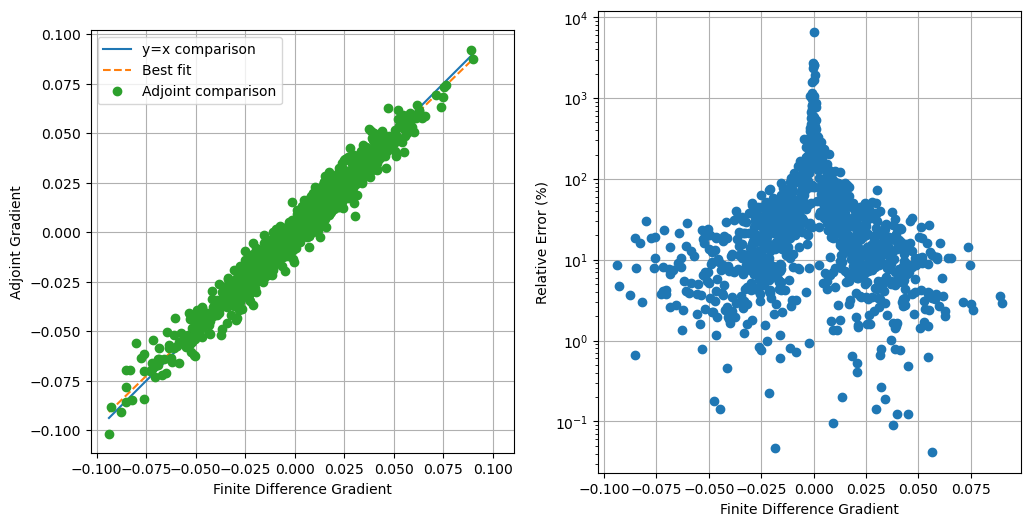

In [14]:
min_g = np.min(g_discrete)
max_g = np.max(g_discrete)

fig = plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot([min_g, max_g], [min_g, max_g], label="y=x comparison")
plt.plot([min_g, max_g], [m * min_g + b, m * max_g + b], "--", label="Best fit")
plt.plot(g_discrete, dJ_du_sum[idx], "o", label="Adjoint comparison")
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Adjoint Gradient")
plt.legend()
plt.grid(True)
plt.axis("square")

plt.subplot(1, 2, 2)
rel_err = (
    np.abs(np.squeeze(g_discrete) - np.squeeze(dJ_du_sum[idx]))
    / np.abs(np.squeeze(g_discrete))
    * 100
)
plt.semilogy(g_discrete, rel_err, "o")
plt.grid(True)
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Relative Error (%)")
plt.show()

plt.savefig("graph.png")
plt.cla()   # clear the current axes
plt.clf()   # clear the current figure
plt.close() # closes the current figure
plt.show()

     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (3.68,3.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (3.68,3.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)


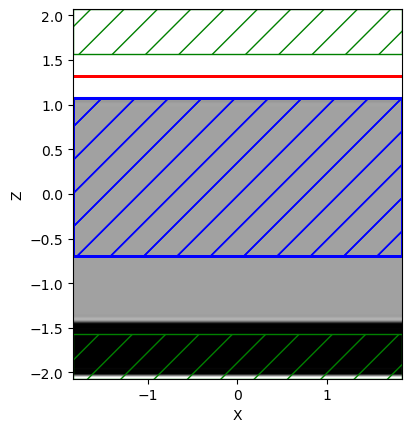

In [15]:
opt.plot2D(True,output_plane = mp.Volume(size = (np.inf, 0, np.inf), center = (0,0,0)))

In [16]:
print(design_variables.weights)

[0. 0. 0. ... 0. 0. 0.]


In [20]:
dJ_du.reshape(Nx *Ny, Nz)

ValueError: cannot reshape array of size 2234496 into shape (2116,44)

ValueError: cannot reshape array of size 2234496 into shape (2116,44)

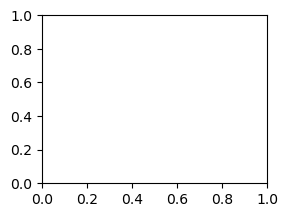

In [18]:
f=2

plt.subplot(2, 2, 1)
dJ_du_0 = dJ_du.reshape(Nx *Ny, Nz).transpose()[f]
plt.imshow(np.rot90(dJ_du_0.reshape(Nx, Ny)), )
plt.ylabel("Adjoint Gradient")
plt.colorbar()

# plt.subplot(2, 2, 2)
# g_discrete_0 = np.squeeze(g_discrete).reshape(Nx *Ny, Nz).transpose()[f]
# plt.imshow(np.rot90(g_discrete_0.reshape(Nx, Ny)), )
# plt.ylabel("Finite Difference Gradient")
# plt.colorbar()



# plt.subplot(2, 2, 3)
# err_p=rel_err.reshape(Nx *Ny, Nz).transpose()[f]
# plt.imshow(np.rot90(err_p.reshape(Nx, Ny)),)
# plt.ylabel("Relative Error (%)")
# plt.colorbar()


# plt.subplot(2, 2, 4)
# r_err = (
#     np.abs(np.squeeze(g_discrete_0) - np.squeeze(dJ_du_0)))
# plt.imshow(np.rot90(r_err.reshape(Nx, Ny)),)
# plt.ylabel("Error")
# plt.colorbar()